**This is a NLP problem where the task is to classify Fake News in an article. This notebook consists of various stages needed for identifying fake news such as data preprocessing, model experimentation, and evaluation of results.**

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
import re
from nltk.corpus import stopwords
# nltk.download('stopwords')
from tensorflow.keras.layers import Embedding,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM,Bidirectional,GRU
from tensorflow.keras.layers import Dense

In [2]:
# Dataset Link: https://www.kaggle.com/pnkjgpt/fake-news-dataset

# Reading data from csv
train = pd.read_csv("dataset-2/train.csv")
test  = pd.read_csv("dataset-2/test.csv")
train.head()

index                                              title  \
0      0  PRESIDENT TRUMP Explains New “America First” R...   
1      1  TERMINALLY ILL FORMER MISS WI: “Until my last ...   
2      2   Cruz Humiliated By Moderator After Lie About ...   
3      3  Russia revels in Trump victory, looks to sanct...   
4      4  Trump's bid to open U.S. monuments to developm...   

                                                text       subject  \
0  That s what we re talking about! Another campa...      politics   
1  How is it that Sean Hannity is the only media ...      politics   
2  Almost immediately after learning that longtim...          News   
3  MOSCOW (Reuters) - For all their mutual praise...  politicsNews   
4  WASHINGTON (Reuters) - The Trump administratio...  politicsNews   

                date class Unnamed: 6  
0        Aug 2, 2017  Fake        NaN  
1        Oct 4, 2016  Fake        NaN  
2  February 13, 2016  Fake        NaN  
3  November 9, 2016   Real        NaN  
4      May 26, 2017   Real        NaN

In [3]:
test.head()

index                                              title  \
0      0  STUNNING TESTIMONY On The Devastation Illegal ...   
1      1  Pena Nieto told Trump Mexico won't pay for wal...   
2      2   Actor George Clooney: I Support Hillary, And ...   
3      3  AWESOME LETTER TO OBAMA: Who is unfit to be pr...   
4      4   This Ridiculously Creepy Vine May Prove Ted C...   

                                                text          subject  \
0   Fantastic testimony on the disastrous results...  Government News   
1  MEXICO CITY (Reuters) - Mexican President Enri...     politicsNews   
2  Hillary Clinton has picked up a huge endorseme...             News   
3  Did anyone else think it was the ultimate iron...        left-news   
4  There have been a lot of strange this that hav...             News   

               date  
0      Mar 21, 2016  
1  August 31, 2016   
2     March 4, 2016  
3       Aug 5, 2016  
4  February 8, 2016

In [4]:
# Displaying rows and columns in dataset
print("There are {} number of rows and {} number of columns for training.".format(train.shape[0],train.shape[1]))
print("There are {} number of rows and {} number of columns for testing.".format(test.shape[0],test.shape[1]))

There are 40000 number of rows and 7 number of columns for training.
There are 4000 number of rows and 5 number of columns for testing.


**Checking Null Values**

In [5]:
# Checking the null values in training data.
train.isnull().sum()

index             0
title             0
text              0
subject           0
date              0
class             0
Unnamed: 6    39999
dtype: int64

In [6]:
# Checking the null values in testing data.
test.isnull().sum()

index      0
title      0
text       0
subject    0
date       0
dtype: int64

In [7]:
# Handling nan values in dataset using empty spaces
def handle_nan(train_data,test_data):
    '''Input: Data to the function containing Nan values.
       Output : Cleaned data containing no Nan values.
       Function: Cleaning Nan values.
     '''
    train = train_data.fillna(" ")
    test  = test_data.fillna(" ")
    return train,test

train,test = handle_nan(train,test)


In [8]:
# Dropping useless columns
train.drop(['index', 'subject', 'date', 'Unnamed: 6'], axis = 1, inplace = True)
test.drop(['index', 'subject', 'date'], axis = 1, inplace = True)

In [9]:
train.rename(columns={'class':'label'}, inplace = True)

In [10]:
train.head()

title  \
0  PRESIDENT TRUMP Explains New “America First” R...   
1  TERMINALLY ILL FORMER MISS WI: “Until my last ...   
2   Cruz Humiliated By Moderator After Lie About ...   
3  Russia revels in Trump victory, looks to sanct...   
4  Trump's bid to open U.S. monuments to developm...   

                                                text label  
0  That s what we re talking about! Another campa...  Fake  
1  How is it that Sean Hannity is the only media ...  Fake  
2  Almost immediately after learning that longtim...  Fake  
3  MOSCOW (Reuters) - For all their mutual praise...  Real  
4  WASHINGTON (Reuters) - The Trump administratio...  Real

In [11]:
test.head()

title  \
0  STUNNING TESTIMONY On The Devastation Illegal ...   
1  Pena Nieto told Trump Mexico won't pay for wal...   
2   Actor George Clooney: I Support Hillary, And ...   
3  AWESOME LETTER TO OBAMA: Who is unfit to be pr...   
4   This Ridiculously Creepy Vine May Prove Ted C...   

                                                text  
0   Fantastic testimony on the disastrous results...  
1  MEXICO CITY (Reuters) - Mexican President Enri...  
2  Hillary Clinton has picked up a huge endorseme...  
3  Did anyone else think it was the ultimate iron...  
4  There have been a lot of strange this that hav...

In [12]:
train['label'] = train['label'].replace(['Fake'], 1)
train['label'] = train['label'].replace(['Real'], 0)

In [13]:
train.head()

title  \
0  PRESIDENT TRUMP Explains New “America First” R...   
1  TERMINALLY ILL FORMER MISS WI: “Until my last ...   
2   Cruz Humiliated By Moderator After Lie About ...   
3  Russia revels in Trump victory, looks to sanct...   
4  Trump's bid to open U.S. monuments to developm...   

                                                text label  
0  That s what we re talking about! Another campa...     1  
1  How is it that Sean Hannity is the only media ...     1  
2  Almost immediately after learning that longtim...     1  
3  MOSCOW (Reuters) - For all their mutual praise...     0  
4  WASHINGTON (Reuters) - The Trump administratio...     0

In [14]:
train['label'].value_counts()

1                   20886
0                   19113
February 5, 2017        1
Name: label, dtype: int64

In [15]:
i = train[((train.label == 'February 5, 2017'))].index
train = train.drop(i)

In [16]:
train['label'] = train['label'].astype(int)

In [17]:
train['label'].value_counts()

1    20886
0    19113
Name: label, dtype: int64

In [18]:
# Seperating Independent and dependent features
X = train.drop(columns=['label'],axis=1)
y = train['label']

In [19]:
# Creating One-Hot Representations
messages = X.copy()
messages.reset_index(inplace=True)
messages_test = test.copy()
messages_test.reset_index(inplace=True)

In [20]:
messages["text"][0]

'That s what we re talking about! Another campaign promise kept. No wonder the Democrats and their media allies fear President Trump. When is the last time a politician actually followed through on a promise they made to the American voters that helped them to get elected?President Trump joined two Republican senators on Wednesday to champion legislation overhauling legal immigration in America, calling for a merit-based system that would significantly cut admissions over the next decade.Speaking at the White House, the president called it  the most significant reform to our immigration system in a half century. As a candidate, I campaigned on creating a merit-based immigration system that protects U.S. workers and taxpayers, and that is why we are here today,  Trump said.He was joined by Georgia Sen. David Perdue and Arkansas Sen. Tom Cotton, the Republicans who first introduced the Reforming American Immigration for a Strong Economy, or the RAISE Act, in February. They have said the 

In [21]:
messages.head()

index                                              title  \
0      0  PRESIDENT TRUMP Explains New “America First” R...   
1      1  TERMINALLY ILL FORMER MISS WI: “Until my last ...   
2      2   Cruz Humiliated By Moderator After Lie About ...   
3      3  Russia revels in Trump victory, looks to sanct...   
4      4  Trump's bid to open U.S. monuments to developm...   

                                                text  
0  That s what we re talking about! Another campa...  
1  How is it that Sean Hannity is the only media ...  
2  Almost immediately after learning that longtim...  
3  MOSCOW (Reuters) - For all their mutual praise...  
4  WASHINGTON (Reuters) - The Trump administratio...

In [22]:
messages_test.head()

index                                              title  \
0      0  STUNNING TESTIMONY On The Devastation Illegal ...   
1      1  Pena Nieto told Trump Mexico won't pay for wal...   
2      2   Actor George Clooney: I Support Hillary, And ...   
3      3  AWESOME LETTER TO OBAMA: Who is unfit to be pr...   
4      4   This Ridiculously Creepy Vine May Prove Ted C...   

                                                text  
0   Fantastic testimony on the disastrous results...  
1  MEXICO CITY (Reuters) - Mexican President Enri...  
2  Hillary Clinton has picked up a huge endorseme...  
3  Did anyone else think it was the ultimate iron...  
4  There have been a lot of strange this that hav...

# Data Pre-processing
**In Data Pre-processing following steps are followed:** 
**1. Firstly, all the sequences except english characters are removed from the string.**
**2. Next, to avoid false predictions or ambiguity with upper and lowercase, all the characters in strings are converted    to lowercase.**
**3. Next, all the sentences are tokenized into words.**
**4. To facilitate fast processing, stemming is applied to the tokenized words.**
**5. Next, words are joined together and stored in the corpus.**

**Note: In this tutorial, we have used "merged" column for classification task. Also, the loop inside the function runs over all the examples in the merged column.**

In [23]:
# Performing data preprocessing on column 'title'
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
def perform_preprocess(data):
    '''Input: Data to be processed
       Output: Preprocessed data
    '''
    corpus = []
    for i in range(0,len(data)):
        review = re.sub('[^a-zA-Z]',' ',data['title'][i])
        review = review.lower()
        review = review.split()
        review = [ps.stem(word) for word in review if word not in stopwords.words('english')]
        review = ' '.join(review)
        corpus.append(review)
    return corpus
    
train_corpus = perform_preprocess(messages)
test_corpus  = perform_preprocess(messages_test)
train_corpus[1]

'termin ill former miss wi last breath use voic tell mr trump realli video'

In [24]:
test_corpus[1]

'pena nieto told trump mexico pay wall presidenti spokesman'

**Below code converts the pre-processed words to one-hot vectors in the range of vocabulary size=5000. This is done to obtain numerical feature matrix**

In [25]:
# Converting to one-hot repr.
vocab_size = 5000
one_hot_train = [one_hot(word,vocab_size) for word in train_corpus]
one_hot_test  = [one_hot(word,vocab_size) for word in test_corpus]

In [26]:
one_hot_test[1]

[4758, 3625, 206, 3099, 660, 851, 3321, 2585, 4169]

**Below code creates an embedding layer which applies "pre" padding to the one-hot encoded features with sentence length = 20. Padding is applied so that the length of every sequence in the dataset should be same.**

In [27]:
# Embedding Representation 
sent_length = 20
embedd_docs_train = pad_sequences(one_hot_train,padding='pre',maxlen=sent_length)
embedd_docs_test  = pad_sequences(one_hot_test,padding='pre',maxlen=sent_length)
print(embedd_docs_train)

[[3475 2856 3547 ... 4290 2119 2779]
 [   0    0    0 ... 3099  803 2779]
 [   0    0    0 ...   99 4439 4580]
 ...
 [   0  563 2889 ... 3087 3021 2779]
 [   0    0    0 ... 3601 3567 4576]
 [   0    0    0 ...  386 3447 3071]]


In [28]:
embedd_docs_train[0]

array([3475, 2856, 3547, 2298, 3513, 2586, 3475, 2893, 1753, 1756,  267,
        902, 2893, 4799, 1320,  758, 3473, 4290, 2119, 2779])

In [29]:
print(embedd_docs_test)

[[   0    0    0 ... 1321 2856 2779]
 [   0    0    0 ... 3321 2585 4169]
 [   0    0    0 ... 3835 3099 4074]
 ...
 [   0    0    0 ... 1993  395 1137]
 [   0    0    0 ... 4989 1451 3087]
 [   0    0    0 ... 2732 1320 3798]]


In [30]:
# Converting Embedding repr. to array
x_final = np.array(embedd_docs_train)
y_final = np.array(y)
x_test_final = np.array(embedd_docs_test)

In [31]:
# Dimensions of prev. array repr.
x_final.shape,y_final.shape,x_test_final.shape

((39999, 20), (39999,), (4000, 20))

**Dividing the dataset into training,validation and testing data (ratio: 80/10/10) using train_test_split technique.**

In [32]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.1, random_state=42, stratify = y_final)
X_train, x_valid, Y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42, stratify = y_train)
x_test_final = x_test_final

# Creating Models
**In this phase, several models are created and evaluated against various metrics shown using classification report.**

## Baseline Models

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [34]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier(),
          "Naive Bayes": MultinomialNB(),
          "Decision Tree Classifier": DecisionTreeClassifier(),
          "XGBoost Classifier": XGBClassifier(),
          "CatBoost Classifier": CatBoostClassifier(iterations=150)}

# Create a function to fit and score models
def fit_and_score(models, X_train, x_test, Y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models: a dict of different Scikit-Learn Machine Learning models
    X_train: Training data (no labels)
    X_test: Testing data (no labels)
    y_train: Training labels
    y_test: Test labels
    """
    
    # Set random seed
    np.random.seed(12)
    
    # Make a dictionary to keep model scores
    model_scores = {}
    
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, Y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(x_test, y_test)
        
    return model_scores

In [35]:
model_scores = fit_and_score(models=models, X_train=X_train, x_test=x_test, Y_train=Y_train, y_test=y_test)
model_scores

C:\Users\khand\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Learning rate set to 0.259093
0:	learn: 0.5775989	total: 166ms	remaining: 24.7s
1:	learn: 0.5232055	total: 176ms	remaining: 13s
2:	learn: 0.4927059	total: 187ms	remaining: 9.16s
3:	learn: 0.4808760	total: 199ms	remaining: 7.25s
4:	learn: 0.4755256	total: 210ms	remaining: 6.08s
5:	learn: 0.4580304	total: 221ms	remaining: 5.29s
6:	learn: 0.4529208	total: 232ms	remaining: 4.73s
7:	learn: 0.4489751	total: 243ms	remaining: 4.31s
8:	learn: 0.4459767	total: 254ms	remaining: 3.97s
9:	learn: 0.4435532	total: 265ms	remaining: 3.71s
10:	learn: 0.4401947	total: 277ms	remaining: 3.5s
11:	learn: 0.4382969	total: 288ms	remaining: 3.31s
12:	learn: 0.4330772	total: 300ms	remaining: 3.16s
13:	learn: 0.4315926	total: 311ms	remaining: 3.02s
14:	learn: 0.4300545	total: 323ms	remaining: 2.9s
15:	learn: 0.4284231	total: 334ms	remaining: 2.8s
16:	learn: 0.4273073	total: 345ms	remaining: 2.7s
17:	learn: 0.4237091	total: 357ms	remaining: 2.62s
18:	learn: 0.4230368	total: 368ms	remaining: 2.54s
19:	learn: 0.4216

{'Logistic Regression': 0.74425,
 'KNN': 0.71575,
 'Random Forest': 0.85625,
 'Naive Bayes': 0.72225,
 'Decision Tree Classifier': 0.7915,
 'XGBoost Classifier': 0.8115,
 'CatBoost Classifier': 0.861}

**LSTM**

**In this model, 1.) The value for embedding feature vectors = 40 which are target feature vectors for the embedding layer. 2.) Single LSTM Layer with 100 nodes are used. 3.)Dense Layer with 1 neuron and sigmoid activation function is used since, this is a binary classification problem. 4) Dropout technique is used to avoid overfiiting and adam optimizer is used for optimizing the loss function.**

In [36]:
# Creating the LSTM Model for prediction
embedding_feature_vector = 40
model = Sequential()
model.add(Embedding(vocab_size,embedding_feature_vector,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 40)            200000    
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
# Training the model
model.fit(X_train,Y_train,validation_data=(x_valid,y_valid),epochs=10,batch_size=64)

Epoch 1/10
507/507 [==============================] - 10s 16ms/step - loss: 0.3554 - accuracy: 0.8272 - val_loss: 0.1857 - val_accuracy: 0.9347
Epoch 2/10
507/507 [==============================] - 9s 17ms/step - loss: 0.1330 - accuracy: 0.9479 - val_loss: 0.1536 - val_accuracy: 0.9381
Epoch 3/10
507/507 [==============================] - 8s 17ms/step - loss: 0.0968 - accuracy: 0.9617 - val_loss: 0.1535 - val_accuracy: 0.9428
Epoch 4/10
507/507 [==============================] - 8s 17ms/step - loss: 0.0834 - accuracy: 0.9682 - val_loss: 0.1725 - val_accuracy: 0.9361
Epoch 5/10
507/507 [==============================] - 9s 17ms/step - loss: 0.0648 - accuracy: 0.9765 - val_loss: 0.1703 - val_accuracy: 0.9419
Epoch 6/10
507/507 [==============================] - 8s 17ms/step - loss: 0.0568 - accuracy: 0.9788 - val_loss: 0.1768 - val_accuracy: 0.9389
Epoch 7/10
507/507 [==============================] - 9s 17ms/step - loss: 0.0457 - accuracy: 0.9841 - val_loss: 0.1989 - val_accuracy: 0.938

In [38]:
# predictions = model.predict_classes(x_test)
# cr = classification_report(y_test,predictions)
# print(cr)

predictions = model.predict_classes(x_test)
score_lstm = accuracy_score(y_test,predictions)
score_lstm

C:\Users\khand\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.94225

In [39]:
y_preds = model.predict_classes(x_test)

print(accuracy_score(y_test, y_preds))
print(precision_score(y_test, y_preds))
print(recall_score(y_test, y_preds))
print(f1_score(y_test, y_preds))

C:\Users\khand\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.94225
0.9470644850818094
0.9420775490665391
0.9445644348452124


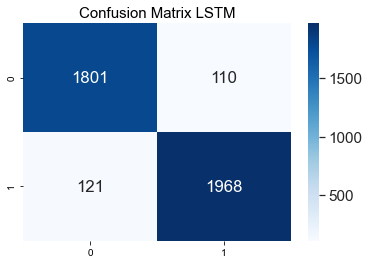

In [40]:
import seaborn as sns

cf_matrix = confusion_matrix(y_test, y_preds)
# print(cf_matrix)

ax = plt.subplot()
title_font = {'size':'15'}  # Adjust to fit
sns.set(font_scale=1.4) 
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g")
ax.set_title('Confusion Matrix LSTM', fontdict=title_font);
plt.savefig('plot_LSTM_2.png', dpi=300, bbox_inches='tight')

In [41]:
model_compare = pd.DataFrame(model_scores, index=["Accuracy"])
model_compare["LSTM"] = score_lstm
model_compare = model_compare.T.sort_values(by="Accuracy").T

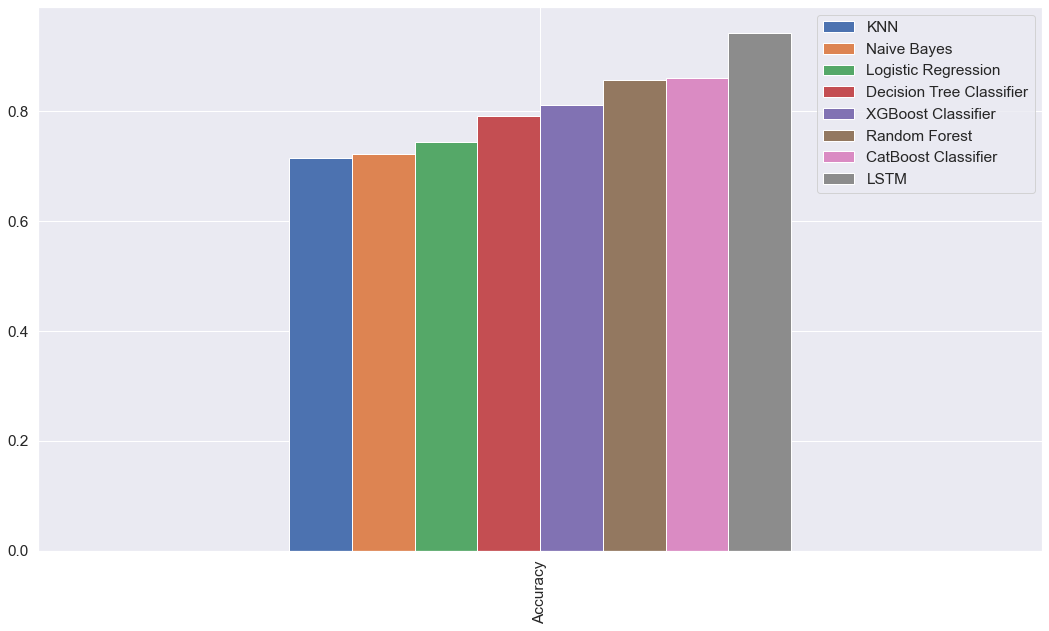

In [42]:
model_compare.plot(kind="bar", figsize=(18, 10));
plt.savefig('plot_model_compare_2.png', dpi=300, bbox_inches='tight')

In [43]:
model_compare

KNN  Naive Bayes  Logistic Regression  Decision Tree Classifier  \
Accuracy  0.71575      0.72225              0.74425                    0.7915   

          XGBoost Classifier  Random Forest  CatBoost Classifier     LSTM  
Accuracy              0.8115        0.85625                0.861  0.94225

In [44]:
# model_compare.plot(kind="bar", color=['blue', 'red','pink','green', 'cyan', 'yellow', 'black','orange'], figsize=(20, 10));

# Classification Report For Baseline Models That Are Not Hyperparameter Tuned

In [45]:
# CR for Logistic Regression
clf = LogisticRegression()

# Fit the model to the data
clf.fit(X_train, Y_train)

print(clf.score(x_test, y_test))

0.74425


C:\Users\khand\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [46]:
y_preds = clf.predict(x_test)

print(accuracy_score(y_test, y_preds))
print(precision_score(y_test, y_preds))
print(recall_score(y_test, y_preds))
print(f1_score(y_test, y_preds))

0.74425
0.8377693282636248
0.6328386787936812
0.7210253613307881


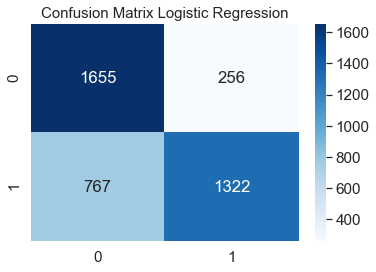

In [47]:
cf_matrix = confusion_matrix(y_test, y_preds)

ax = plt.subplot()
title_font = {'size':'15'}  # Adjust to fit
sns.set(font_scale=1.4) 
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g")
ax.set_title('Confusion Matrix Logistic Regression', fontdict=title_font);
plt.savefig('plot_Logistic_Regression_2.png', dpi=300, bbox_inches='tight')

In [48]:
# CR for NaiveBayes
clf = MultinomialNB()

# Fit the model to the data
clf.fit(X_train, Y_train)

print(clf.score(x_test, y_test))

0.72225


In [49]:
y_preds = clf.predict(x_test)

print(accuracy_score(y_test, y_preds))
print(precision_score(y_test, y_preds))
print(recall_score(y_test, y_preds))
print(f1_score(y_test, y_preds))

0.72225
0.9014778325123153
0.5256103398755385
0.6640459631085577


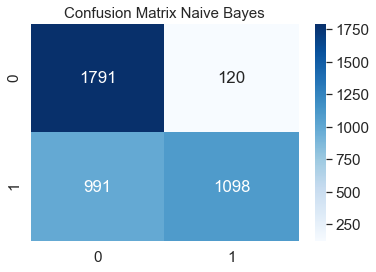

In [50]:
cf_matrix = confusion_matrix(y_test, y_preds)

ax = plt.subplot()
title_font = {'size':'15'}  # Adjust to fit
sns.set(font_scale=1.4) 
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g")
ax.set_title('Confusion Matrix Naive Bayes', fontdict=title_font);
plt.savefig('plot_Naive_Bayes_2.png', dpi=300, bbox_inches='tight')

In [51]:
# CR for KNN
clf = KNeighborsClassifier()

# Fit the model to the data
clf.fit(X_train, Y_train)

print(clf.score(x_test, y_test))

0.71575


In [52]:
y_preds = clf.predict(x_test)

print(accuracy_score(y_test, y_preds))
print(precision_score(y_test, y_preds))
print(recall_score(y_test, y_preds))
print(f1_score(y_test, y_preds))

0.71575
0.7413793103448276
0.6998563906175204
0.720019699581384


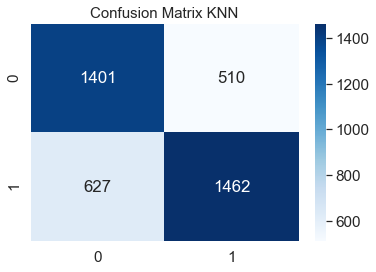

In [53]:
cf_matrix = confusion_matrix(y_test, y_preds)

ax = plt.subplot()
title_font = {'size':'15'}  # Adjust to fit
sns.set(font_scale=1.4) 
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g")
ax.set_title('Confusion Matrix KNN', fontdict=title_font);
plt.savefig('plot_KNN_2.png', dpi=300, bbox_inches='tight')

## RandomizedSearch CV

### Only trying this on RF, CatBoost, XGBoost and Decision Trees

In [54]:
# Create a hyperparameter grid for RandomForestClassifier
rfc_grid = {"n_estimators": np.arange(800, 1000, 100),
           "max_depth": [None],
           "min_samples_split": np.arange(5, 9, 2),
           "min_samples_leaf": np.arange(0, 2, 1),
           "bootstrap": [True]}

# Create a hyperparameter grid for DecisionTreesClassifier
dtc_grid = {"max_depth": np.arange(70, 80, 1),
           "min_samples_split": np.arange(10, 20, 1),
           "min_samples_leaf": np.arange(20, 30, 1),
           "max_leaf_nodes": np.arange(80, 90, 1),
           "criterion": ["gini", "entropy"]}

# Create a hyperparameter grid for XGBoostClassifier
xgb_grid = {"max_depth" : np.arange(70, 80, 1),
            "learning_rate" : [0.1, 0.2],
            "n_estimators" : np.arange(700, 800, 10),
            "verbosity" : [1],
            "min_child_weight": [1, 3],
            "subsample": [0.5, 0.7],
            "colsample_bytree": [0.5, 0.7]}

# Create a hyperparameter grid for CatBoostClassifier
catb_grid = {'depth':[8,9,10],
             'iterations':[500,1000],
             'learning_rate':[0.1,0.2], 
             'l2_leaf_reg':[1, 2, 3],
             'border_count':[100, 110, 120],
             'thread_count': [4, 5]}

In [55]:
# Tune RFC
np.random.seed(12)

# Setup random hyperparameeter search for RFC
rs_rfc = RandomizedSearchCV(RandomForestClassifier(),
                                param_distributions=rfc_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparameter search model for RFC
rs_rfc.fit(X_train, Y_train)

C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\khand\anaco

C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\khand\anaco

C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\khand\anaco

C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\khand\anaco

C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\khand\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\khand\anaco

C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.83740262 0.83690875
 0.83505689 0.8349643 ]
  category=UserWarning


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [None],
                                        'min_samples_leaf': array([0, 1]),
                                        'min_samples_split': array([5, 7]),
                                        'n_estimators': array([800, 900])},
                   verbose=True)

In [56]:
# Find the best hyperparameters
rs_rfc.best_params_

{'n_estimators': 800,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': None,
 'bootstrap': True}

In [57]:
# Best score
rs_rfc.score(x_test, y_test)

0.86

In [58]:
# Setup random seed
np.random.seed(12)

# Setup random hyperparameter search for DecisionTreeClassifier
rs_dtc = RandomizedSearchCV(DecisionTreeClassifier(),
                           param_distributions=dtc_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit the random hyperparameter search model for DecisionTreeClassifier()
rs_dtc.fit(X_train, Y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=20,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79]),
                                        'max_leaf_nodes': array([80, 81, 82, 83, 84, 85, 86, 87, 88, 89]),
                                        'min_samples_leaf': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                        'min_samples_split': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])},
                   verbose=True)

In [59]:
# Find the best hyperparameters
rs_dtc.best_params_

{'min_samples_split': 19,
 'min_samples_leaf': 20,
 'max_leaf_nodes': 84,
 'max_depth': 77,
 'criterion': 'gini'}

In [60]:
# Best score
rs_dtc.score(x_test, y_test)

0.8115

In [61]:
# Setup random seed
np.random.seed(12)

# Setup random hyperparameter search for XGB Classifier
rs_xgb = RandomizedSearchCV(XGBClassifier(),
                           param_distributions=xgb_grid,
                           cv=5,
                           n_iter=10,
                           verbose=True)

# Fit the random hyperparameter search model for XGBClassifier()
rs_xgb.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=XGBClassifier(),
                   param_distributions={'colsample_bytree': [0.5, 0.7],
                                        'learning_rate': [0.1, 0.2],
                                        'max_depth': array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79]),
                                        'min_child_weight': [1, 3],
                                        'n_estimators': array([700, 710, 720, 730, 740, 750, 760, 770, 780, 790]),
                                        'subsample': [0.5, 0.7],
                                        'verbosity': [1]},
                   verbose=True)

In [62]:
# Find the best hyperparameters
rs_xgb.best_params_

{'verbosity': 1,
 'subsample': 0.7,
 'n_estimators': 740,
 'min_child_weight': 1,
 'max_depth': 71,
 'learning_rate': 0.1,
 'colsample_bytree': 0.5}

In [63]:
# Best score
rs_xgb.score(x_test, y_test)

0.8975

In [64]:
# Setup random seed
np.random.seed(24)

# Setup random hyperparameter search for XGB Classifier
rs_cbc = RandomizedSearchCV(CatBoostClassifier(),
                           param_distributions=catb_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit the random hyperparameter search model for XGBClassifier()
rs_cbc.fit(X_train, Y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
0:	learn: 0.5704331	total: 50.9ms	remaining: 25.4s
1:	learn: 0.5240971	total: 95.9ms	remaining: 23.9s
2:	learn: 0.4957762	total: 138ms	remaining: 22.9s
3:	learn: 0.4782382	total: 181ms	remaining: 22.5s
4:	learn: 0.4659456	total: 224ms	remaining: 22.2s
5:	learn: 0.4603469	total: 273ms	remaining: 22.5s
6:	learn: 0.4519202	total: 316ms	remaining: 22.2s
7:	learn: 0.4481879	total: 359ms	remaining: 22.1s
8:	learn: 0.4400553	total: 402ms	remaining: 22s
9:	learn: 0.4368275	total: 446ms	remaining: 21.8s
10:	learn: 0.4341154	total: 494ms	remaining: 22s
11:	learn: 0.4310359	total: 538ms	remaining: 21.9s
12:	learn: 0.4266040	total: 582ms	remaining: 21.8s
13:	learn: 0.4214281	total: 626ms	remaining: 21.7s
14:	learn: 0.4193709	total: 670ms	remaining: 21.7s
15:	learn: 0.4151257	total: 717ms	remaining: 21.7s
16:	learn: 0.4131930	total: 762ms	remaining: 21.7s
17:	learn: 0.4110152	total: 806ms	remaining: 21.6s
18:	learn: 0.4088846	total: 858m

163:	learn: 0.1863472	total: 7.53s	remaining: 15.4s
164:	learn: 0.1858143	total: 7.58s	remaining: 15.4s
165:	learn: 0.1849469	total: 7.63s	remaining: 15.4s
166:	learn: 0.1842726	total: 7.68s	remaining: 15.3s
167:	learn: 0.1827676	total: 7.74s	remaining: 15.3s
168:	learn: 0.1815343	total: 7.8s	remaining: 15.3s
169:	learn: 0.1807170	total: 7.85s	remaining: 15.2s
170:	learn: 0.1801237	total: 7.9s	remaining: 15.2s
171:	learn: 0.1796762	total: 7.95s	remaining: 15.2s
172:	learn: 0.1784477	total: 8s	remaining: 15.1s
173:	learn: 0.1773829	total: 8.06s	remaining: 15.1s
174:	learn: 0.1763224	total: 8.11s	remaining: 15.1s
175:	learn: 0.1756209	total: 8.16s	remaining: 15s
176:	learn: 0.1752474	total: 8.21s	remaining: 15s
177:	learn: 0.1745159	total: 8.26s	remaining: 14.9s
178:	learn: 0.1741069	total: 8.31s	remaining: 14.9s
179:	learn: 0.1732278	total: 8.36s	remaining: 14.9s
180:	learn: 0.1726373	total: 8.41s	remaining: 14.8s
181:	learn: 0.1715848	total: 8.46s	remaining: 14.8s
182:	learn: 0.1710714

322:	learn: 0.0927988	total: 15.9s	remaining: 8.69s
323:	learn: 0.0922896	total: 15.9s	remaining: 8.64s
324:	learn: 0.0921121	total: 16s	remaining: 8.59s
325:	learn: 0.0917535	total: 16s	remaining: 8.54s
326:	learn: 0.0913120	total: 16.1s	remaining: 8.49s
327:	learn: 0.0910910	total: 16.1s	remaining: 8.45s
328:	learn: 0.0908853	total: 16.2s	remaining: 8.4s
329:	learn: 0.0905078	total: 16.2s	remaining: 8.35s
330:	learn: 0.0901591	total: 16.3s	remaining: 8.3s
331:	learn: 0.0895774	total: 16.3s	remaining: 8.26s
332:	learn: 0.0891670	total: 16.4s	remaining: 8.21s
333:	learn: 0.0888427	total: 16.4s	remaining: 8.16s
334:	learn: 0.0885385	total: 16.5s	remaining: 8.11s
335:	learn: 0.0883811	total: 16.5s	remaining: 8.06s
336:	learn: 0.0880938	total: 16.6s	remaining: 8.02s
337:	learn: 0.0878003	total: 16.6s	remaining: 7.97s
338:	learn: 0.0873365	total: 16.7s	remaining: 7.92s
339:	learn: 0.0871269	total: 16.7s	remaining: 7.87s
340:	learn: 0.0869352	total: 16.8s	remaining: 7.83s
341:	learn: 0.0865

482:	learn: 0.0526651	total: 24.1s	remaining: 850ms
483:	learn: 0.0525156	total: 24.2s	remaining: 800ms
484:	learn: 0.0523675	total: 24.2s	remaining: 750ms
485:	learn: 0.0521523	total: 24.3s	remaining: 700ms
486:	learn: 0.0519873	total: 24.4s	remaining: 650ms
487:	learn: 0.0517974	total: 24.4s	remaining: 600ms
488:	learn: 0.0516028	total: 24.5s	remaining: 550ms
489:	learn: 0.0514085	total: 24.5s	remaining: 500ms
490:	learn: 0.0511338	total: 24.6s	remaining: 450ms
491:	learn: 0.0509771	total: 24.6s	remaining: 400ms
492:	learn: 0.0508208	total: 24.7s	remaining: 350ms
493:	learn: 0.0504208	total: 24.7s	remaining: 300ms
494:	learn: 0.0502427	total: 24.8s	remaining: 250ms
495:	learn: 0.0501039	total: 24.8s	remaining: 200ms
496:	learn: 0.0499671	total: 24.9s	remaining: 150ms
497:	learn: 0.0497692	total: 24.9s	remaining: 100ms
498:	learn: 0.0496681	total: 25s	remaining: 50.1ms
499:	learn: 0.0495564	total: 25s	remaining: 0us
0:	learn: 0.5743069	total: 46.5ms	remaining: 23.2s
1:	learn: 0.519708

147:	learn: 0.1995842	total: 7.57s	remaining: 18s
148:	learn: 0.1987957	total: 7.63s	remaining: 18s
149:	learn: 0.1977623	total: 7.67s	remaining: 17.9s
150:	learn: 0.1971568	total: 7.73s	remaining: 17.9s
151:	learn: 0.1960926	total: 7.78s	remaining: 17.8s
152:	learn: 0.1949629	total: 7.83s	remaining: 17.8s
153:	learn: 0.1941480	total: 7.88s	remaining: 17.7s
154:	learn: 0.1929858	total: 7.93s	remaining: 17.7s
155:	learn: 0.1923944	total: 7.98s	remaining: 17.6s
156:	learn: 0.1910772	total: 8.04s	remaining: 17.6s
157:	learn: 0.1903386	total: 8.09s	remaining: 17.5s
158:	learn: 0.1896473	total: 8.14s	remaining: 17.5s
159:	learn: 0.1888141	total: 8.19s	remaining: 17.4s
160:	learn: 0.1878810	total: 8.24s	remaining: 17.4s
161:	learn: 0.1867125	total: 8.3s	remaining: 17.3s
162:	learn: 0.1860156	total: 8.35s	remaining: 17.3s
163:	learn: 0.1849245	total: 8.4s	remaining: 17.2s
164:	learn: 0.1840149	total: 8.46s	remaining: 17.2s
165:	learn: 0.1828776	total: 8.52s	remaining: 17.1s
166:	learn: 0.1822

310:	learn: 0.0959137	total: 16.1s	remaining: 9.76s
311:	learn: 0.0955604	total: 16.1s	remaining: 9.71s
312:	learn: 0.0952569	total: 16.2s	remaining: 9.65s
313:	learn: 0.0949111	total: 16.2s	remaining: 9.6s
314:	learn: 0.0945922	total: 16.3s	remaining: 9.55s
315:	learn: 0.0943487	total: 16.3s	remaining: 9.5s
316:	learn: 0.0940612	total: 16.4s	remaining: 9.45s
317:	learn: 0.0935803	total: 16.4s	remaining: 9.39s
318:	learn: 0.0933453	total: 16.5s	remaining: 9.34s
319:	learn: 0.0928741	total: 16.5s	remaining: 9.29s
320:	learn: 0.0925948	total: 16.6s	remaining: 9.24s
321:	learn: 0.0923228	total: 16.6s	remaining: 9.19s
322:	learn: 0.0921340	total: 16.7s	remaining: 9.13s
323:	learn: 0.0918224	total: 16.7s	remaining: 9.08s
324:	learn: 0.0915942	total: 16.8s	remaining: 9.03s
325:	learn: 0.0913432	total: 16.8s	remaining: 8.98s
326:	learn: 0.0909319	total: 16.9s	remaining: 8.93s
327:	learn: 0.0902759	total: 16.9s	remaining: 8.88s
328:	learn: 0.0899716	total: 17s	remaining: 8.82s
329:	learn: 0.08

472:	learn: 0.0519940	total: 24.9s	remaining: 1.42s
473:	learn: 0.0518235	total: 24.9s	remaining: 1.37s
474:	learn: 0.0516297	total: 25s	remaining: 1.32s
475:	learn: 0.0514828	total: 25.1s	remaining: 1.26s
476:	learn: 0.0513722	total: 25.1s	remaining: 1.21s
477:	learn: 0.0512513	total: 25.2s	remaining: 1.16s
478:	learn: 0.0511690	total: 25.2s	remaining: 1.1s
479:	learn: 0.0510192	total: 25.3s	remaining: 1.05s
480:	learn: 0.0508929	total: 25.3s	remaining: 1s
481:	learn: 0.0507505	total: 25.4s	remaining: 948ms
482:	learn: 0.0506374	total: 25.4s	remaining: 895ms
483:	learn: 0.0505385	total: 25.5s	remaining: 843ms
484:	learn: 0.0503578	total: 25.6s	remaining: 790ms
485:	learn: 0.0502700	total: 25.6s	remaining: 737ms
486:	learn: 0.0500964	total: 25.7s	remaining: 685ms
487:	learn: 0.0499648	total: 25.7s	remaining: 632ms
488:	learn: 0.0498616	total: 25.8s	remaining: 579ms
489:	learn: 0.0496540	total: 25.8s	remaining: 527ms
490:	learn: 0.0495188	total: 25.9s	remaining: 474ms
491:	learn: 0.0492

136:	learn: 0.2119712	total: 7.26s	remaining: 19.3s
137:	learn: 0.2109403	total: 7.32s	remaining: 19.2s
138:	learn: 0.2104555	total: 7.37s	remaining: 19.1s
139:	learn: 0.2097025	total: 7.41s	remaining: 19.1s
140:	learn: 0.2085292	total: 7.47s	remaining: 19s
141:	learn: 0.2077504	total: 7.52s	remaining: 19s
142:	learn: 0.2066504	total: 7.58s	remaining: 18.9s
143:	learn: 0.2056222	total: 7.62s	remaining: 18.8s
144:	learn: 0.2046168	total: 7.67s	remaining: 18.8s
145:	learn: 0.2036748	total: 7.73s	remaining: 18.7s
146:	learn: 0.2030760	total: 7.78s	remaining: 18.7s
147:	learn: 0.2021171	total: 7.83s	remaining: 18.6s
148:	learn: 0.2011175	total: 7.88s	remaining: 18.6s
149:	learn: 0.2002797	total: 7.93s	remaining: 18.5s
150:	learn: 0.1995205	total: 7.99s	remaining: 18.5s
151:	learn: 0.1986394	total: 8.04s	remaining: 18.4s
152:	learn: 0.1979916	total: 8.09s	remaining: 18.3s
153:	learn: 0.1974824	total: 8.14s	remaining: 18.3s
154:	learn: 0.1963658	total: 8.19s	remaining: 18.2s
155:	learn: 0.19

299:	learn: 0.1029009	total: 15.7s	remaining: 10.5s
300:	learn: 0.1022244	total: 15.8s	remaining: 10.4s
301:	learn: 0.1018757	total: 15.8s	remaining: 10.4s
302:	learn: 0.1014124	total: 15.9s	remaining: 10.3s
303:	learn: 0.1008619	total: 16s	remaining: 10.3s
304:	learn: 0.1003749	total: 16s	remaining: 10.2s
305:	learn: 0.1000625	total: 16.1s	remaining: 10.2s
306:	learn: 0.0996829	total: 16.1s	remaining: 10.1s
307:	learn: 0.0992850	total: 16.2s	remaining: 10.1s
308:	learn: 0.0989583	total: 16.2s	remaining: 10s
309:	learn: 0.0985501	total: 16.3s	remaining: 9.97s
310:	learn: 0.0981195	total: 16.3s	remaining: 9.91s
311:	learn: 0.0972906	total: 16.4s	remaining: 9.86s
312:	learn: 0.0969883	total: 16.4s	remaining: 9.81s
313:	learn: 0.0966584	total: 16.5s	remaining: 9.76s
314:	learn: 0.0962282	total: 16.5s	remaining: 9.71s
315:	learn: 0.0959205	total: 16.6s	remaining: 9.65s
316:	learn: 0.0956061	total: 16.6s	remaining: 9.6s
317:	learn: 0.0951593	total: 16.7s	remaining: 9.55s
318:	learn: 0.09476

459:	learn: 0.0563896	total: 24.1s	remaining: 2.09s
460:	learn: 0.0561562	total: 24.1s	remaining: 2.04s
461:	learn: 0.0559533	total: 24.2s	remaining: 1.99s
462:	learn: 0.0558268	total: 24.2s	remaining: 1.94s
463:	learn: 0.0555686	total: 24.3s	remaining: 1.88s
464:	learn: 0.0554720	total: 24.3s	remaining: 1.83s
465:	learn: 0.0551702	total: 24.4s	remaining: 1.78s
466:	learn: 0.0550432	total: 24.4s	remaining: 1.73s
467:	learn: 0.0547126	total: 24.5s	remaining: 1.68s
468:	learn: 0.0544076	total: 24.6s	remaining: 1.62s
469:	learn: 0.0542567	total: 24.6s	remaining: 1.57s
470:	learn: 0.0540881	total: 24.7s	remaining: 1.52s
471:	learn: 0.0538736	total: 24.7s	remaining: 1.47s
472:	learn: 0.0536650	total: 24.8s	remaining: 1.41s
473:	learn: 0.0534988	total: 24.8s	remaining: 1.36s
474:	learn: 0.0533525	total: 24.9s	remaining: 1.31s
475:	learn: 0.0531854	total: 24.9s	remaining: 1.26s
476:	learn: 0.0529495	total: 25s	remaining: 1.2s
477:	learn: 0.0528707	total: 25s	remaining: 1.15s
478:	learn: 0.052

120:	learn: 0.2357463	total: 6.22s	remaining: 19.5s
121:	learn: 0.2346734	total: 6.28s	remaining: 19.5s
122:	learn: 0.2337070	total: 6.33s	remaining: 19.4s
123:	learn: 0.2324094	total: 6.38s	remaining: 19.4s
124:	learn: 0.2314322	total: 6.44s	remaining: 19.3s
125:	learn: 0.2303272	total: 6.49s	remaining: 19.3s
126:	learn: 0.2288809	total: 6.54s	remaining: 19.2s
127:	learn: 0.2275751	total: 6.59s	remaining: 19.2s
128:	learn: 0.2264711	total: 6.64s	remaining: 19.1s
129:	learn: 0.2255755	total: 6.69s	remaining: 19.1s
130:	learn: 0.2248163	total: 6.74s	remaining: 19s
131:	learn: 0.2234438	total: 6.79s	remaining: 18.9s
132:	learn: 0.2225558	total: 6.84s	remaining: 18.9s
133:	learn: 0.2216868	total: 6.89s	remaining: 18.8s
134:	learn: 0.2205430	total: 6.95s	remaining: 18.8s
135:	learn: 0.2194417	total: 7.01s	remaining: 18.8s
136:	learn: 0.2184001	total: 7.07s	remaining: 18.7s
137:	learn: 0.2176064	total: 7.13s	remaining: 18.7s
138:	learn: 0.2166847	total: 7.19s	remaining: 18.7s
139:	learn: 0.

281:	learn: 0.1121922	total: 14.8s	remaining: 11.4s
282:	learn: 0.1118374	total: 14.9s	remaining: 11.4s
283:	learn: 0.1112892	total: 14.9s	remaining: 11.3s
284:	learn: 0.1109393	total: 15s	remaining: 11.3s
285:	learn: 0.1106687	total: 15s	remaining: 11.2s
286:	learn: 0.1104023	total: 15.1s	remaining: 11.2s
287:	learn: 0.1100894	total: 15.1s	remaining: 11.1s
288:	learn: 0.1098259	total: 15.2s	remaining: 11.1s
289:	learn: 0.1092539	total: 15.2s	remaining: 11s
290:	learn: 0.1088774	total: 15.3s	remaining: 11s
291:	learn: 0.1082367	total: 15.3s	remaining: 10.9s
292:	learn: 0.1078067	total: 15.4s	remaining: 10.9s
293:	learn: 0.1072216	total: 15.4s	remaining: 10.8s
294:	learn: 0.1066756	total: 15.5s	remaining: 10.8s
295:	learn: 0.1060507	total: 15.5s	remaining: 10.7s
296:	learn: 0.1056199	total: 15.6s	remaining: 10.6s
297:	learn: 0.1052758	total: 15.6s	remaining: 10.6s
298:	learn: 0.1050330	total: 15.7s	remaining: 10.5s
299:	learn: 0.1041231	total: 15.7s	remaining: 10.5s
300:	learn: 0.103770

443:	learn: 0.0607448	total: 23.2s	remaining: 2.92s
444:	learn: 0.0605461	total: 23.2s	remaining: 2.87s
445:	learn: 0.0602652	total: 23.3s	remaining: 2.82s
446:	learn: 0.0600847	total: 23.3s	remaining: 2.77s
447:	learn: 0.0599527	total: 23.4s	remaining: 2.71s
448:	learn: 0.0596688	total: 23.4s	remaining: 2.66s
449:	learn: 0.0593704	total: 23.5s	remaining: 2.61s
450:	learn: 0.0591059	total: 23.5s	remaining: 2.56s
451:	learn: 0.0589057	total: 23.6s	remaining: 2.5s
452:	learn: 0.0586579	total: 23.6s	remaining: 2.45s
453:	learn: 0.0584888	total: 23.7s	remaining: 2.4s
454:	learn: 0.0583799	total: 23.7s	remaining: 2.35s
455:	learn: 0.0581880	total: 23.8s	remaining: 2.29s
456:	learn: 0.0579934	total: 23.8s	remaining: 2.24s
457:	learn: 0.0577760	total: 23.9s	remaining: 2.19s
458:	learn: 0.0576308	total: 23.9s	remaining: 2.14s
459:	learn: 0.0573801	total: 24s	remaining: 2.09s
460:	learn: 0.0572406	total: 24s	remaining: 2.03s
461:	learn: 0.0570710	total: 24.1s	remaining: 1.98s
462:	learn: 0.0568

104:	learn: 0.2573174	total: 5.38s	remaining: 20.2s
105:	learn: 0.2558417	total: 5.43s	remaining: 20.2s
106:	learn: 0.2546526	total: 5.48s	remaining: 20.1s
107:	learn: 0.2535905	total: 5.53s	remaining: 20.1s
108:	learn: 0.2525134	total: 5.58s	remaining: 20s
109:	learn: 0.2512496	total: 5.64s	remaining: 20s
110:	learn: 0.2497345	total: 5.69s	remaining: 19.9s
111:	learn: 0.2475644	total: 5.74s	remaining: 19.9s
112:	learn: 0.2464927	total: 5.79s	remaining: 19.8s
113:	learn: 0.2454013	total: 5.84s	remaining: 19.8s
114:	learn: 0.2436699	total: 5.89s	remaining: 19.7s
115:	learn: 0.2422081	total: 5.94s	remaining: 19.7s
116:	learn: 0.2410624	total: 5.99s	remaining: 19.6s
117:	learn: 0.2395489	total: 6.05s	remaining: 19.6s
118:	learn: 0.2381227	total: 6.1s	remaining: 19.5s
119:	learn: 0.2366136	total: 6.15s	remaining: 19.5s
120:	learn: 0.2350959	total: 6.2s	remaining: 19.4s
121:	learn: 0.2329116	total: 6.25s	remaining: 19.4s
122:	learn: 0.2320822	total: 6.31s	remaining: 19.3s
123:	learn: 0.2310

263:	learn: 0.1209534	total: 13.6s	remaining: 12.2s
264:	learn: 0.1202253	total: 13.7s	remaining: 12.1s
265:	learn: 0.1200308	total: 13.7s	remaining: 12.1s
266:	learn: 0.1195349	total: 13.8s	remaining: 12s
267:	learn: 0.1190967	total: 13.8s	remaining: 12s
268:	learn: 0.1188156	total: 13.9s	remaining: 11.9s
269:	learn: 0.1180198	total: 14s	remaining: 11.9s
270:	learn: 0.1172174	total: 14s	remaining: 11.8s
271:	learn: 0.1166859	total: 14.1s	remaining: 11.8s
272:	learn: 0.1160897	total: 14.1s	remaining: 11.7s
273:	learn: 0.1154769	total: 14.2s	remaining: 11.7s
274:	learn: 0.1149825	total: 14.2s	remaining: 11.6s
275:	learn: 0.1146298	total: 14.3s	remaining: 11.6s
276:	learn: 0.1140222	total: 14.3s	remaining: 11.5s
277:	learn: 0.1134232	total: 14.4s	remaining: 11.5s
278:	learn: 0.1131532	total: 14.4s	remaining: 11.4s
279:	learn: 0.1128668	total: 14.5s	remaining: 11.4s
280:	learn: 0.1124652	total: 14.5s	remaining: 11.3s
281:	learn: 0.1122133	total: 14.6s	remaining: 11.3s
282:	learn: 0.111753

424:	learn: 0.0640182	total: 22s	remaining: 3.88s
425:	learn: 0.0638156	total: 22.1s	remaining: 3.83s
426:	learn: 0.0634969	total: 22.1s	remaining: 3.78s
427:	learn: 0.0632333	total: 22.2s	remaining: 3.73s
428:	learn: 0.0630109	total: 22.2s	remaining: 3.68s
429:	learn: 0.0628395	total: 22.3s	remaining: 3.63s
430:	learn: 0.0625371	total: 22.3s	remaining: 3.58s
431:	learn: 0.0623024	total: 22.4s	remaining: 3.52s
432:	learn: 0.0619417	total: 22.4s	remaining: 3.47s
433:	learn: 0.0618193	total: 22.5s	remaining: 3.42s
434:	learn: 0.0615489	total: 22.5s	remaining: 3.37s
435:	learn: 0.0614172	total: 22.6s	remaining: 3.31s
436:	learn: 0.0612293	total: 22.6s	remaining: 3.26s
437:	learn: 0.0609577	total: 22.7s	remaining: 3.21s
438:	learn: 0.0606495	total: 22.7s	remaining: 3.16s
439:	learn: 0.0604087	total: 22.8s	remaining: 3.11s
440:	learn: 0.0602043	total: 22.9s	remaining: 3.06s
441:	learn: 0.0600598	total: 22.9s	remaining: 3s
442:	learn: 0.0598715	total: 23s	remaining: 2.95s
443:	learn: 0.05975

92:	learn: 0.3192667	total: 1.68s	remaining: 16.4s
93:	learn: 0.3180898	total: 1.7s	remaining: 16.4s
94:	learn: 0.3171462	total: 1.72s	remaining: 16.3s
95:	learn: 0.3163225	total: 1.73s	remaining: 16.3s
96:	learn: 0.3152377	total: 1.75s	remaining: 16.3s
97:	learn: 0.3141625	total: 1.77s	remaining: 16.3s
98:	learn: 0.3132086	total: 1.79s	remaining: 16.3s
99:	learn: 0.3123503	total: 1.8s	remaining: 16.3s
100:	learn: 0.3116269	total: 1.82s	remaining: 16.2s
101:	learn: 0.3106021	total: 1.84s	remaining: 16.2s
102:	learn: 0.3096049	total: 1.86s	remaining: 16.2s
103:	learn: 0.3085023	total: 1.88s	remaining: 16.2s
104:	learn: 0.3075692	total: 1.9s	remaining: 16.2s
105:	learn: 0.3062318	total: 1.92s	remaining: 16.2s
106:	learn: 0.3053203	total: 1.93s	remaining: 16.1s
107:	learn: 0.3041702	total: 1.95s	remaining: 16.1s
108:	learn: 0.3030707	total: 1.97s	remaining: 16.1s
109:	learn: 0.3021137	total: 1.99s	remaining: 16.1s
110:	learn: 0.3008018	total: 2.01s	remaining: 16.1s
111:	learn: 0.2998760	t

260:	learn: 0.1948457	total: 4.79s	remaining: 13.6s
261:	learn: 0.1943577	total: 4.81s	remaining: 13.6s
262:	learn: 0.1940276	total: 4.83s	remaining: 13.5s
263:	learn: 0.1935998	total: 4.85s	remaining: 13.5s
264:	learn: 0.1930867	total: 4.87s	remaining: 13.5s
265:	learn: 0.1926755	total: 4.88s	remaining: 13.5s
266:	learn: 0.1921129	total: 4.91s	remaining: 13.5s
267:	learn: 0.1916686	total: 4.92s	remaining: 13.4s
268:	learn: 0.1910503	total: 4.94s	remaining: 13.4s
269:	learn: 0.1903032	total: 4.96s	remaining: 13.4s
270:	learn: 0.1896119	total: 4.98s	remaining: 13.4s
271:	learn: 0.1889461	total: 5s	remaining: 13.4s
272:	learn: 0.1883708	total: 5.02s	remaining: 13.4s
273:	learn: 0.1877399	total: 5.04s	remaining: 13.4s
274:	learn: 0.1869790	total: 5.06s	remaining: 13.3s
275:	learn: 0.1866103	total: 5.08s	remaining: 13.3s
276:	learn: 0.1861709	total: 5.1s	remaining: 13.3s
277:	learn: 0.1857664	total: 5.12s	remaining: 13.3s
278:	learn: 0.1853476	total: 5.13s	remaining: 13.3s
279:	learn: 0.18

426:	learn: 0.1283364	total: 7.89s	remaining: 10.6s
427:	learn: 0.1281401	total: 7.91s	remaining: 10.6s
428:	learn: 0.1278096	total: 7.93s	remaining: 10.6s
429:	learn: 0.1274790	total: 7.95s	remaining: 10.5s
430:	learn: 0.1272715	total: 7.96s	remaining: 10.5s
431:	learn: 0.1270699	total: 7.98s	remaining: 10.5s
432:	learn: 0.1268266	total: 8s	remaining: 10.5s
433:	learn: 0.1265931	total: 8.02s	remaining: 10.5s
434:	learn: 0.1262363	total: 8.04s	remaining: 10.4s
435:	learn: 0.1258913	total: 8.06s	remaining: 10.4s
436:	learn: 0.1255043	total: 8.08s	remaining: 10.4s
437:	learn: 0.1251974	total: 8.09s	remaining: 10.4s
438:	learn: 0.1249059	total: 8.11s	remaining: 10.4s
439:	learn: 0.1247293	total: 8.13s	remaining: 10.3s
440:	learn: 0.1243665	total: 8.15s	remaining: 10.3s
441:	learn: 0.1241376	total: 8.17s	remaining: 10.3s
442:	learn: 0.1237237	total: 8.19s	remaining: 10.3s
443:	learn: 0.1234303	total: 8.21s	remaining: 10.3s
444:	learn: 0.1229920	total: 8.23s	remaining: 10.3s
445:	learn: 0.1

593:	learn: 0.0880068	total: 11s	remaining: 7.52s
594:	learn: 0.0877468	total: 11s	remaining: 7.5s
595:	learn: 0.0875552	total: 11s	remaining: 7.48s
596:	learn: 0.0873354	total: 11.1s	remaining: 7.46s
597:	learn: 0.0871797	total: 11.1s	remaining: 7.45s
598:	learn: 0.0870312	total: 11.1s	remaining: 7.43s
599:	learn: 0.0868905	total: 11.1s	remaining: 7.41s
600:	learn: 0.0867423	total: 11.1s	remaining: 7.39s
601:	learn: 0.0865520	total: 11.1s	remaining: 7.37s
602:	learn: 0.0864075	total: 11.2s	remaining: 7.35s
603:	learn: 0.0862449	total: 11.2s	remaining: 7.33s
604:	learn: 0.0860595	total: 11.2s	remaining: 7.32s
605:	learn: 0.0857691	total: 11.2s	remaining: 7.3s
606:	learn: 0.0854992	total: 11.2s	remaining: 7.28s
607:	learn: 0.0853290	total: 11.3s	remaining: 7.26s
608:	learn: 0.0851693	total: 11.3s	remaining: 7.24s
609:	learn: 0.0850338	total: 11.3s	remaining: 7.22s
610:	learn: 0.0848671	total: 11.3s	remaining: 7.2s
611:	learn: 0.0846820	total: 11.3s	remaining: 7.18s
612:	learn: 0.0845260

762:	learn: 0.0617862	total: 14.1s	remaining: 4.39s
763:	learn: 0.0617205	total: 14.2s	remaining: 4.37s
764:	learn: 0.0616038	total: 14.2s	remaining: 4.35s
765:	learn: 0.0614736	total: 14.2s	remaining: 4.33s
766:	learn: 0.0613394	total: 14.2s	remaining: 4.32s
767:	learn: 0.0612137	total: 14.2s	remaining: 4.3s
768:	learn: 0.0610537	total: 14.2s	remaining: 4.28s
769:	learn: 0.0608807	total: 14.3s	remaining: 4.26s
770:	learn: 0.0608149	total: 14.3s	remaining: 4.24s
771:	learn: 0.0606722	total: 14.3s	remaining: 4.22s
772:	learn: 0.0605779	total: 14.3s	remaining: 4.21s
773:	learn: 0.0604395	total: 14.3s	remaining: 4.19s
774:	learn: 0.0603461	total: 14.4s	remaining: 4.17s
775:	learn: 0.0602060	total: 14.4s	remaining: 4.15s
776:	learn: 0.0600061	total: 14.4s	remaining: 4.13s
777:	learn: 0.0599070	total: 14.4s	remaining: 4.11s
778:	learn: 0.0597711	total: 14.4s	remaining: 4.09s
779:	learn: 0.0596186	total: 14.5s	remaining: 4.08s
780:	learn: 0.0595201	total: 14.5s	remaining: 4.06s
781:	learn: 0

928:	learn: 0.0450584	total: 17.2s	remaining: 1.32s
929:	learn: 0.0449639	total: 17.3s	remaining: 1.3s
930:	learn: 0.0448815	total: 17.3s	remaining: 1.28s
931:	learn: 0.0447943	total: 17.3s	remaining: 1.26s
932:	learn: 0.0447460	total: 17.3s	remaining: 1.24s
933:	learn: 0.0446471	total: 17.3s	remaining: 1.22s
934:	learn: 0.0445660	total: 17.3s	remaining: 1.21s
935:	learn: 0.0444947	total: 17.4s	remaining: 1.19s
936:	learn: 0.0444068	total: 17.4s	remaining: 1.17s
937:	learn: 0.0443394	total: 17.4s	remaining: 1.15s
938:	learn: 0.0442688	total: 17.4s	remaining: 1.13s
939:	learn: 0.0441946	total: 17.4s	remaining: 1.11s
940:	learn: 0.0441444	total: 17.5s	remaining: 1.09s
941:	learn: 0.0439789	total: 17.5s	remaining: 1.08s
942:	learn: 0.0438818	total: 17.5s	remaining: 1.06s
943:	learn: 0.0438031	total: 17.5s	remaining: 1.04s
944:	learn: 0.0437393	total: 17.5s	remaining: 1.02s
945:	learn: 0.0436748	total: 17.6s	remaining: 1s
946:	learn: 0.0435840	total: 17.6s	remaining: 983ms
947:	learn: 0.04

91:	learn: 0.3201386	total: 1.67s	remaining: 16.5s
92:	learn: 0.3188241	total: 1.69s	remaining: 16.5s
93:	learn: 0.3178216	total: 1.71s	remaining: 16.5s
94:	learn: 0.3166820	total: 1.73s	remaining: 16.4s
95:	learn: 0.3155619	total: 1.74s	remaining: 16.4s
96:	learn: 0.3147639	total: 1.76s	remaining: 16.4s
97:	learn: 0.3137460	total: 1.78s	remaining: 16.4s
98:	learn: 0.3126187	total: 1.8s	remaining: 16.4s
99:	learn: 0.3116077	total: 1.81s	remaining: 16.3s
100:	learn: 0.3107076	total: 1.83s	remaining: 16.3s
101:	learn: 0.3096715	total: 1.85s	remaining: 16.3s
102:	learn: 0.3086136	total: 1.87s	remaining: 16.3s
103:	learn: 0.3077153	total: 1.89s	remaining: 16.3s
104:	learn: 0.3060127	total: 1.91s	remaining: 16.3s
105:	learn: 0.3046945	total: 1.93s	remaining: 16.2s
106:	learn: 0.3038570	total: 1.94s	remaining: 16.2s
107:	learn: 0.3029982	total: 1.96s	remaining: 16.2s
108:	learn: 0.3018941	total: 1.98s	remaining: 16.2s
109:	learn: 0.3011233	total: 2s	remaining: 16.2s
110:	learn: 0.3004151	tot

260:	learn: 0.1944415	total: 4.8s	remaining: 13.6s
261:	learn: 0.1940016	total: 4.82s	remaining: 13.6s
262:	learn: 0.1934559	total: 4.84s	remaining: 13.6s
263:	learn: 0.1930014	total: 4.86s	remaining: 13.5s
264:	learn: 0.1923221	total: 4.88s	remaining: 13.5s
265:	learn: 0.1916918	total: 4.9s	remaining: 13.5s
266:	learn: 0.1912537	total: 4.92s	remaining: 13.5s
267:	learn: 0.1906830	total: 4.93s	remaining: 13.5s
268:	learn: 0.1900275	total: 4.95s	remaining: 13.5s
269:	learn: 0.1896091	total: 4.97s	remaining: 13.4s
270:	learn: 0.1890879	total: 4.99s	remaining: 13.4s
271:	learn: 0.1886152	total: 5.01s	remaining: 13.4s
272:	learn: 0.1879668	total: 5.03s	remaining: 13.4s
273:	learn: 0.1873259	total: 5.05s	remaining: 13.4s
274:	learn: 0.1869774	total: 5.07s	remaining: 13.4s
275:	learn: 0.1864895	total: 5.08s	remaining: 13.3s
276:	learn: 0.1861202	total: 5.1s	remaining: 13.3s
277:	learn: 0.1857128	total: 5.12s	remaining: 13.3s
278:	learn: 0.1853432	total: 5.14s	remaining: 13.3s
279:	learn: 0.1

426:	learn: 0.1276805	total: 7.91s	remaining: 10.6s
427:	learn: 0.1274157	total: 7.93s	remaining: 10.6s
428:	learn: 0.1271474	total: 7.95s	remaining: 10.6s
429:	learn: 0.1267416	total: 7.97s	remaining: 10.6s
430:	learn: 0.1264575	total: 7.99s	remaining: 10.5s
431:	learn: 0.1261615	total: 8.01s	remaining: 10.5s
432:	learn: 0.1258067	total: 8.02s	remaining: 10.5s
433:	learn: 0.1255662	total: 8.04s	remaining: 10.5s
434:	learn: 0.1252737	total: 8.06s	remaining: 10.5s
435:	learn: 0.1249082	total: 8.08s	remaining: 10.4s
436:	learn: 0.1244592	total: 8.1s	remaining: 10.4s
437:	learn: 0.1241987	total: 8.12s	remaining: 10.4s
438:	learn: 0.1239519	total: 8.13s	remaining: 10.4s
439:	learn: 0.1235814	total: 8.16s	remaining: 10.4s
440:	learn: 0.1233911	total: 8.17s	remaining: 10.4s
441:	learn: 0.1231439	total: 8.19s	remaining: 10.3s
442:	learn: 0.1228778	total: 8.21s	remaining: 10.3s
443:	learn: 0.1226107	total: 8.23s	remaining: 10.3s
444:	learn: 0.1223567	total: 8.25s	remaining: 10.3s
445:	learn: 0

595:	learn: 0.0874795	total: 11.1s	remaining: 7.5s
596:	learn: 0.0872903	total: 11.1s	remaining: 7.48s
597:	learn: 0.0871227	total: 11.1s	remaining: 7.46s
598:	learn: 0.0868739	total: 11.1s	remaining: 7.44s
599:	learn: 0.0867148	total: 11.1s	remaining: 7.42s
600:	learn: 0.0865248	total: 11.2s	remaining: 7.4s
601:	learn: 0.0864258	total: 11.2s	remaining: 7.38s
602:	learn: 0.0862641	total: 11.2s	remaining: 7.37s
603:	learn: 0.0861114	total: 11.2s	remaining: 7.35s
604:	learn: 0.0859095	total: 11.2s	remaining: 7.33s
605:	learn: 0.0857548	total: 11.2s	remaining: 7.31s
606:	learn: 0.0855075	total: 11.3s	remaining: 7.29s
607:	learn: 0.0853849	total: 11.3s	remaining: 7.27s
608:	learn: 0.0851569	total: 11.3s	remaining: 7.25s
609:	learn: 0.0850067	total: 11.3s	remaining: 7.24s
610:	learn: 0.0848180	total: 11.3s	remaining: 7.22s
611:	learn: 0.0845849	total: 11.4s	remaining: 7.2s
612:	learn: 0.0844414	total: 11.4s	remaining: 7.18s
613:	learn: 0.0841833	total: 11.4s	remaining: 7.16s
614:	learn: 0.0

762:	learn: 0.0613677	total: 14.2s	remaining: 4.41s
763:	learn: 0.0612495	total: 14.2s	remaining: 4.39s
764:	learn: 0.0611373	total: 14.2s	remaining: 4.37s
765:	learn: 0.0610351	total: 14.2s	remaining: 4.35s
766:	learn: 0.0609622	total: 14.3s	remaining: 4.33s
767:	learn: 0.0608718	total: 14.3s	remaining: 4.31s
768:	learn: 0.0607120	total: 14.3s	remaining: 4.29s
769:	learn: 0.0606359	total: 14.3s	remaining: 4.28s
770:	learn: 0.0605077	total: 14.3s	remaining: 4.26s
771:	learn: 0.0604153	total: 14.4s	remaining: 4.24s
772:	learn: 0.0603234	total: 14.4s	remaining: 4.22s
773:	learn: 0.0602516	total: 14.4s	remaining: 4.2s
774:	learn: 0.0601142	total: 14.4s	remaining: 4.18s
775:	learn: 0.0599582	total: 14.4s	remaining: 4.16s
776:	learn: 0.0598255	total: 14.4s	remaining: 4.14s
777:	learn: 0.0597357	total: 14.5s	remaining: 4.13s
778:	learn: 0.0596383	total: 14.5s	remaining: 4.11s
779:	learn: 0.0595472	total: 14.5s	remaining: 4.09s
780:	learn: 0.0594399	total: 14.5s	remaining: 4.07s
781:	learn: 0

925:	learn: 0.0448244	total: 17.2s	remaining: 1.38s
926:	learn: 0.0447473	total: 17.3s	remaining: 1.36s
927:	learn: 0.0446485	total: 17.3s	remaining: 1.34s
928:	learn: 0.0445839	total: 17.3s	remaining: 1.32s
929:	learn: 0.0445224	total: 17.3s	remaining: 1.3s
930:	learn: 0.0444064	total: 17.3s	remaining: 1.28s
931:	learn: 0.0442869	total: 17.3s	remaining: 1.26s
932:	learn: 0.0442167	total: 17.4s	remaining: 1.25s
933:	learn: 0.0441615	total: 17.4s	remaining: 1.23s
934:	learn: 0.0440300	total: 17.4s	remaining: 1.21s
935:	learn: 0.0439386	total: 17.4s	remaining: 1.19s
936:	learn: 0.0438828	total: 17.4s	remaining: 1.17s
937:	learn: 0.0437977	total: 17.5s	remaining: 1.15s
938:	learn: 0.0437239	total: 17.5s	remaining: 1.14s
939:	learn: 0.0436495	total: 17.5s	remaining: 1.12s
940:	learn: 0.0435663	total: 17.5s	remaining: 1.1s
941:	learn: 0.0434924	total: 17.5s	remaining: 1.08s
942:	learn: 0.0433705	total: 17.6s	remaining: 1.06s
943:	learn: 0.0432500	total: 17.6s	remaining: 1.04s
944:	learn: 0.

92:	learn: 0.3205756	total: 1.67s	remaining: 16.3s
93:	learn: 0.3194241	total: 1.69s	remaining: 16.3s
94:	learn: 0.3184952	total: 1.7s	remaining: 16.2s
95:	learn: 0.3174090	total: 1.72s	remaining: 16.2s
96:	learn: 0.3166536	total: 1.74s	remaining: 16.2s
97:	learn: 0.3158865	total: 1.76s	remaining: 16.2s
98:	learn: 0.3147252	total: 1.77s	remaining: 16.2s
99:	learn: 0.3136496	total: 1.79s	remaining: 16.1s
100:	learn: 0.3129848	total: 1.81s	remaining: 16.1s
101:	learn: 0.3122906	total: 1.83s	remaining: 16.1s
102:	learn: 0.3104761	total: 1.85s	remaining: 16.1s
103:	learn: 0.3095440	total: 1.87s	remaining: 16.1s
104:	learn: 0.3086281	total: 1.89s	remaining: 16.1s
105:	learn: 0.3078393	total: 1.91s	remaining: 16.1s
106:	learn: 0.3067464	total: 1.92s	remaining: 16.1s
107:	learn: 0.3058460	total: 1.94s	remaining: 16s
108:	learn: 0.3050633	total: 1.96s	remaining: 16s
109:	learn: 0.3043456	total: 1.98s	remaining: 16s
110:	learn: 0.3034578	total: 2s	remaining: 16s
111:	learn: 0.3022715	total: 2.0

256:	learn: 0.1991547	total: 4.8s	remaining: 13.9s
257:	learn: 0.1988225	total: 4.82s	remaining: 13.9s
258:	learn: 0.1982982	total: 4.83s	remaining: 13.8s
259:	learn: 0.1975949	total: 4.85s	remaining: 13.8s
260:	learn: 0.1968692	total: 4.87s	remaining: 13.8s
261:	learn: 0.1962547	total: 4.89s	remaining: 13.8s
262:	learn: 0.1955218	total: 4.91s	remaining: 13.8s
263:	learn: 0.1950405	total: 4.93s	remaining: 13.7s
264:	learn: 0.1944222	total: 4.95s	remaining: 13.7s
265:	learn: 0.1939903	total: 4.97s	remaining: 13.7s
266:	learn: 0.1934552	total: 4.99s	remaining: 13.7s
267:	learn: 0.1927083	total: 5.02s	remaining: 13.7s
268:	learn: 0.1923542	total: 5.04s	remaining: 13.7s
269:	learn: 0.1916829	total: 5.06s	remaining: 13.7s
270:	learn: 0.1911820	total: 5.08s	remaining: 13.7s
271:	learn: 0.1906752	total: 5.1s	remaining: 13.6s
272:	learn: 0.1900746	total: 5.12s	remaining: 13.6s
273:	learn: 0.1897619	total: 5.13s	remaining: 13.6s
274:	learn: 0.1893840	total: 5.15s	remaining: 13.6s
275:	learn: 0.

423:	learn: 0.1301534	total: 7.94s	remaining: 10.8s
424:	learn: 0.1299356	total: 7.96s	remaining: 10.8s
425:	learn: 0.1296015	total: 7.98s	remaining: 10.7s
426:	learn: 0.1293831	total: 7.99s	remaining: 10.7s
427:	learn: 0.1290364	total: 8.01s	remaining: 10.7s
428:	learn: 0.1286758	total: 8.03s	remaining: 10.7s
429:	learn: 0.1283901	total: 8.05s	remaining: 10.7s
430:	learn: 0.1281927	total: 8.07s	remaining: 10.6s
431:	learn: 0.1278871	total: 8.09s	remaining: 10.6s
432:	learn: 0.1275745	total: 8.1s	remaining: 10.6s
433:	learn: 0.1272579	total: 8.12s	remaining: 10.6s
434:	learn: 0.1270152	total: 8.14s	remaining: 10.6s
435:	learn: 0.1267303	total: 8.16s	remaining: 10.6s
436:	learn: 0.1265339	total: 8.18s	remaining: 10.5s
437:	learn: 0.1262310	total: 8.2s	remaining: 10.5s
438:	learn: 0.1259205	total: 8.22s	remaining: 10.5s
439:	learn: 0.1254196	total: 8.24s	remaining: 10.5s
440:	learn: 0.1252166	total: 8.26s	remaining: 10.5s
441:	learn: 0.1248645	total: 8.28s	remaining: 10.4s
442:	learn: 0.

590:	learn: 0.0890661	total: 11s	remaining: 7.64s
591:	learn: 0.0888532	total: 11.1s	remaining: 7.62s
592:	learn: 0.0885851	total: 11.1s	remaining: 7.61s
593:	learn: 0.0883092	total: 11.1s	remaining: 7.59s
594:	learn: 0.0881551	total: 11.1s	remaining: 7.57s
595:	learn: 0.0879384	total: 11.1s	remaining: 7.55s
596:	learn: 0.0877454	total: 11.2s	remaining: 7.53s
597:	learn: 0.0875931	total: 11.2s	remaining: 7.51s
598:	learn: 0.0874208	total: 11.2s	remaining: 7.49s
599:	learn: 0.0871967	total: 11.2s	remaining: 7.47s
600:	learn: 0.0869136	total: 11.2s	remaining: 7.45s
601:	learn: 0.0867596	total: 11.2s	remaining: 7.43s
602:	learn: 0.0865377	total: 11.3s	remaining: 7.42s
603:	learn: 0.0863555	total: 11.3s	remaining: 7.4s
604:	learn: 0.0862256	total: 11.3s	remaining: 7.38s
605:	learn: 0.0859543	total: 11.3s	remaining: 7.36s
606:	learn: 0.0858110	total: 11.3s	remaining: 7.34s
607:	learn: 0.0855254	total: 11.4s	remaining: 7.32s
608:	learn: 0.0853318	total: 11.4s	remaining: 7.3s
609:	learn: 0.08

758:	learn: 0.0620656	total: 14.1s	remaining: 4.49s
759:	learn: 0.0619599	total: 14.2s	remaining: 4.47s
760:	learn: 0.0618429	total: 14.2s	remaining: 4.46s
761:	learn: 0.0617194	total: 14.2s	remaining: 4.44s
762:	learn: 0.0616243	total: 14.2s	remaining: 4.42s
763:	learn: 0.0614828	total: 14.2s	remaining: 4.4s
764:	learn: 0.0613683	total: 14.3s	remaining: 4.38s
765:	learn: 0.0611920	total: 14.3s	remaining: 4.36s
766:	learn: 0.0609801	total: 14.3s	remaining: 4.34s
767:	learn: 0.0607777	total: 14.3s	remaining: 4.33s
768:	learn: 0.0606899	total: 14.3s	remaining: 4.31s
769:	learn: 0.0605679	total: 14.4s	remaining: 4.29s
770:	learn: 0.0605005	total: 14.4s	remaining: 4.27s
771:	learn: 0.0604045	total: 14.4s	remaining: 4.25s
772:	learn: 0.0603254	total: 14.4s	remaining: 4.23s
773:	learn: 0.0601718	total: 14.4s	remaining: 4.21s
774:	learn: 0.0600962	total: 14.4s	remaining: 4.19s
775:	learn: 0.0599914	total: 14.5s	remaining: 4.17s
776:	learn: 0.0599164	total: 14.5s	remaining: 4.16s
777:	learn: 0

927:	learn: 0.0450661	total: 17.3s	remaining: 1.34s
928:	learn: 0.0450197	total: 17.3s	remaining: 1.32s
929:	learn: 0.0449118	total: 17.3s	remaining: 1.3s
930:	learn: 0.0448190	total: 17.3s	remaining: 1.28s
931:	learn: 0.0447774	total: 17.3s	remaining: 1.26s
932:	learn: 0.0446801	total: 17.4s	remaining: 1.25s
933:	learn: 0.0446165	total: 17.4s	remaining: 1.23s
934:	learn: 0.0445642	total: 17.4s	remaining: 1.21s
935:	learn: 0.0444562	total: 17.4s	remaining: 1.19s
936:	learn: 0.0444184	total: 17.4s	remaining: 1.17s
937:	learn: 0.0442564	total: 17.4s	remaining: 1.15s
938:	learn: 0.0441894	total: 17.5s	remaining: 1.13s
939:	learn: 0.0441211	total: 17.5s	remaining: 1.12s
940:	learn: 0.0440261	total: 17.5s	remaining: 1.1s
941:	learn: 0.0439512	total: 17.5s	remaining: 1.08s
942:	learn: 0.0438494	total: 17.5s	remaining: 1.06s
943:	learn: 0.0437562	total: 17.6s	remaining: 1.04s
944:	learn: 0.0436983	total: 17.6s	remaining: 1.02s
945:	learn: 0.0436252	total: 17.6s	remaining: 1s
946:	learn: 0.043

91:	learn: 0.3221389	total: 1.66s	remaining: 16.4s
92:	learn: 0.3211696	total: 1.68s	remaining: 16.4s
93:	learn: 0.3200243	total: 1.7s	remaining: 16.4s
94:	learn: 0.3192666	total: 1.72s	remaining: 16.3s
95:	learn: 0.3186321	total: 1.74s	remaining: 16.3s
96:	learn: 0.3177307	total: 1.75s	remaining: 16.3s
97:	learn: 0.3167820	total: 1.77s	remaining: 16.3s
98:	learn: 0.3158645	total: 1.79s	remaining: 16.3s
99:	learn: 0.3144335	total: 1.81s	remaining: 16.3s
100:	learn: 0.3134892	total: 1.83s	remaining: 16.3s
101:	learn: 0.3122486	total: 1.85s	remaining: 16.3s
102:	learn: 0.3111933	total: 1.87s	remaining: 16.3s
103:	learn: 0.3099334	total: 1.89s	remaining: 16.3s
104:	learn: 0.3091042	total: 1.91s	remaining: 16.2s
105:	learn: 0.3078698	total: 1.92s	remaining: 16.2s
106:	learn: 0.3069608	total: 1.94s	remaining: 16.2s
107:	learn: 0.3059233	total: 1.96s	remaining: 16.2s
108:	learn: 0.3049978	total: 1.98s	remaining: 16.2s
109:	learn: 0.3038926	total: 2s	remaining: 16.2s
110:	learn: 0.3029383	tot

258:	learn: 0.1994027	total: 4.76s	remaining: 13.6s
259:	learn: 0.1988348	total: 4.78s	remaining: 13.6s
260:	learn: 0.1981873	total: 4.8s	remaining: 13.6s
261:	learn: 0.1976467	total: 4.82s	remaining: 13.6s
262:	learn: 0.1971715	total: 4.84s	remaining: 13.6s
263:	learn: 0.1965269	total: 4.86s	remaining: 13.5s
264:	learn: 0.1958313	total: 4.88s	remaining: 13.5s
265:	learn: 0.1952519	total: 4.9s	remaining: 13.5s
266:	learn: 0.1945378	total: 4.92s	remaining: 13.5s
267:	learn: 0.1940743	total: 4.93s	remaining: 13.5s
268:	learn: 0.1937168	total: 4.96s	remaining: 13.5s
269:	learn: 0.1931609	total: 4.98s	remaining: 13.5s
270:	learn: 0.1927518	total: 5s	remaining: 13.4s
271:	learn: 0.1923365	total: 5.02s	remaining: 13.4s
272:	learn: 0.1915407	total: 5.04s	remaining: 13.4s
273:	learn: 0.1910672	total: 5.06s	remaining: 13.4s
274:	learn: 0.1905906	total: 5.08s	remaining: 13.4s
275:	learn: 0.1900312	total: 5.1s	remaining: 13.4s
276:	learn: 0.1894323	total: 5.12s	remaining: 13.4s
277:	learn: 0.1886

423:	learn: 0.1310537	total: 7.94s	remaining: 10.8s
424:	learn: 0.1307834	total: 7.96s	remaining: 10.8s
425:	learn: 0.1304643	total: 7.98s	remaining: 10.7s
426:	learn: 0.1301865	total: 7.99s	remaining: 10.7s
427:	learn: 0.1298015	total: 8.01s	remaining: 10.7s
428:	learn: 0.1294742	total: 8.03s	remaining: 10.7s
429:	learn: 0.1292035	total: 8.05s	remaining: 10.7s
430:	learn: 0.1288086	total: 8.07s	remaining: 10.7s
431:	learn: 0.1285389	total: 8.09s	remaining: 10.6s
432:	learn: 0.1282051	total: 8.11s	remaining: 10.6s
433:	learn: 0.1279561	total: 8.12s	remaining: 10.6s
434:	learn: 0.1274933	total: 8.14s	remaining: 10.6s
435:	learn: 0.1270527	total: 8.16s	remaining: 10.6s
436:	learn: 0.1266847	total: 8.18s	remaining: 10.5s
437:	learn: 0.1262083	total: 8.2s	remaining: 10.5s
438:	learn: 0.1258606	total: 8.22s	remaining: 10.5s
439:	learn: 0.1255725	total: 8.24s	remaining: 10.5s
440:	learn: 0.1251223	total: 8.26s	remaining: 10.5s
441:	learn: 0.1247731	total: 8.28s	remaining: 10.4s
442:	learn: 0

589:	learn: 0.0891156	total: 11s	remaining: 7.67s
590:	learn: 0.0888801	total: 11.1s	remaining: 7.66s
591:	learn: 0.0887823	total: 11.1s	remaining: 7.64s
592:	learn: 0.0886253	total: 11.1s	remaining: 7.62s
593:	learn: 0.0884255	total: 11.1s	remaining: 7.6s
594:	learn: 0.0881542	total: 11.1s	remaining: 7.58s
595:	learn: 0.0880392	total: 11.2s	remaining: 7.56s
596:	learn: 0.0878715	total: 11.2s	remaining: 7.54s
597:	learn: 0.0876463	total: 11.2s	remaining: 7.52s
598:	learn: 0.0874660	total: 11.2s	remaining: 7.5s
599:	learn: 0.0872797	total: 11.2s	remaining: 7.48s
600:	learn: 0.0871353	total: 11.2s	remaining: 7.46s
601:	learn: 0.0869361	total: 11.3s	remaining: 7.44s
602:	learn: 0.0867421	total: 11.3s	remaining: 7.42s
603:	learn: 0.0865748	total: 11.3s	remaining: 7.41s
604:	learn: 0.0864049	total: 11.3s	remaining: 7.39s
605:	learn: 0.0862284	total: 11.3s	remaining: 7.37s
606:	learn: 0.0860974	total: 11.4s	remaining: 7.35s
607:	learn: 0.0859238	total: 11.4s	remaining: 7.33s
608:	learn: 0.08

754:	learn: 0.0624788	total: 14.1s	remaining: 4.59s
755:	learn: 0.0623667	total: 14.2s	remaining: 4.57s
756:	learn: 0.0621911	total: 14.2s	remaining: 4.55s
757:	learn: 0.0620947	total: 14.2s	remaining: 4.53s
758:	learn: 0.0619803	total: 14.2s	remaining: 4.51s
759:	learn: 0.0618754	total: 14.2s	remaining: 4.49s
760:	learn: 0.0617285	total: 14.2s	remaining: 4.47s
761:	learn: 0.0615864	total: 14.3s	remaining: 4.45s
762:	learn: 0.0614853	total: 14.3s	remaining: 4.43s
763:	learn: 0.0614332	total: 14.3s	remaining: 4.42s
764:	learn: 0.0613550	total: 14.3s	remaining: 4.4s
765:	learn: 0.0611730	total: 14.3s	remaining: 4.38s
766:	learn: 0.0609716	total: 14.4s	remaining: 4.36s
767:	learn: 0.0607712	total: 14.4s	remaining: 4.34s
768:	learn: 0.0606560	total: 14.4s	remaining: 4.32s
769:	learn: 0.0605773	total: 14.4s	remaining: 4.3s
770:	learn: 0.0605026	total: 14.4s	remaining: 4.29s
771:	learn: 0.0603898	total: 14.4s	remaining: 4.27s
772:	learn: 0.0602542	total: 14.5s	remaining: 4.25s
773:	learn: 0.

920:	learn: 0.0451797	total: 17.3s	remaining: 1.48s
921:	learn: 0.0451223	total: 17.3s	remaining: 1.46s
922:	learn: 0.0450236	total: 17.3s	remaining: 1.44s
923:	learn: 0.0449342	total: 17.3s	remaining: 1.42s
924:	learn: 0.0448577	total: 17.3s	remaining: 1.4s
925:	learn: 0.0447952	total: 17.3s	remaining: 1.39s
926:	learn: 0.0446879	total: 17.4s	remaining: 1.37s
927:	learn: 0.0446124	total: 17.4s	remaining: 1.35s
928:	learn: 0.0445378	total: 17.4s	remaining: 1.33s
929:	learn: 0.0444713	total: 17.4s	remaining: 1.31s
930:	learn: 0.0444028	total: 17.4s	remaining: 1.29s
931:	learn: 0.0443005	total: 17.5s	remaining: 1.27s
932:	learn: 0.0442329	total: 17.5s	remaining: 1.25s
933:	learn: 0.0441024	total: 17.5s	remaining: 1.24s
934:	learn: 0.0440157	total: 17.5s	remaining: 1.22s
935:	learn: 0.0438864	total: 17.5s	remaining: 1.2s
936:	learn: 0.0437765	total: 17.5s	remaining: 1.18s
937:	learn: 0.0436740	total: 17.6s	remaining: 1.16s
938:	learn: 0.0435786	total: 17.6s	remaining: 1.14s
939:	learn: 0.

81:	learn: 0.3352968	total: 1.48s	remaining: 16.6s
82:	learn: 0.3338335	total: 1.5s	remaining: 16.6s
83:	learn: 0.3327592	total: 1.52s	remaining: 16.6s
84:	learn: 0.3315491	total: 1.54s	remaining: 16.6s
85:	learn: 0.3304236	total: 1.56s	remaining: 16.6s
86:	learn: 0.3289640	total: 1.58s	remaining: 16.6s
87:	learn: 0.3279241	total: 1.6s	remaining: 16.5s
88:	learn: 0.3268607	total: 1.61s	remaining: 16.5s
89:	learn: 0.3256401	total: 1.63s	remaining: 16.5s
90:	learn: 0.3245613	total: 1.65s	remaining: 16.5s
91:	learn: 0.3235646	total: 1.67s	remaining: 16.5s
92:	learn: 0.3225005	total: 1.69s	remaining: 16.5s
93:	learn: 0.3217047	total: 1.71s	remaining: 16.4s
94:	learn: 0.3204421	total: 1.73s	remaining: 16.4s
95:	learn: 0.3195005	total: 1.74s	remaining: 16.4s
96:	learn: 0.3186754	total: 1.76s	remaining: 16.4s
97:	learn: 0.3174960	total: 1.78s	remaining: 16.4s
98:	learn: 0.3165586	total: 1.8s	remaining: 16.3s
99:	learn: 0.3156338	total: 1.81s	remaining: 16.3s
100:	learn: 0.3146387	total: 1.83s

248:	learn: 0.2058655	total: 4.6s	remaining: 13.9s
249:	learn: 0.2051546	total: 4.62s	remaining: 13.9s
250:	learn: 0.2046656	total: 4.64s	remaining: 13.8s
251:	learn: 0.2042862	total: 4.66s	remaining: 13.8s
252:	learn: 0.2037993	total: 4.67s	remaining: 13.8s
253:	learn: 0.2031462	total: 4.69s	remaining: 13.8s
254:	learn: 0.2023973	total: 4.71s	remaining: 13.8s
255:	learn: 0.2017733	total: 4.73s	remaining: 13.8s
256:	learn: 0.2013208	total: 4.75s	remaining: 13.7s
257:	learn: 0.2009151	total: 4.77s	remaining: 13.7s
258:	learn: 0.2000861	total: 4.79s	remaining: 13.7s
259:	learn: 0.1995765	total: 4.81s	remaining: 13.7s
260:	learn: 0.1989637	total: 4.83s	remaining: 13.7s
261:	learn: 0.1983911	total: 4.84s	remaining: 13.6s
262:	learn: 0.1978491	total: 4.86s	remaining: 13.6s
263:	learn: 0.1972237	total: 4.88s	remaining: 13.6s
264:	learn: 0.1967133	total: 4.9s	remaining: 13.6s
265:	learn: 0.1961841	total: 4.92s	remaining: 13.6s
266:	learn: 0.1956555	total: 4.94s	remaining: 13.6s
267:	learn: 0.

414:	learn: 0.1354551	total: 7.72s	remaining: 10.9s
415:	learn: 0.1351675	total: 7.74s	remaining: 10.9s
416:	learn: 0.1348618	total: 7.76s	remaining: 10.9s
417:	learn: 0.1345067	total: 7.78s	remaining: 10.8s
418:	learn: 0.1341683	total: 7.8s	remaining: 10.8s
419:	learn: 0.1338801	total: 7.82s	remaining: 10.8s
420:	learn: 0.1334566	total: 7.84s	remaining: 10.8s
421:	learn: 0.1331347	total: 7.86s	remaining: 10.8s
422:	learn: 0.1327461	total: 7.87s	remaining: 10.7s
423:	learn: 0.1324750	total: 7.89s	remaining: 10.7s
424:	learn: 0.1320660	total: 7.91s	remaining: 10.7s
425:	learn: 0.1317667	total: 7.93s	remaining: 10.7s
426:	learn: 0.1314129	total: 7.95s	remaining: 10.7s
427:	learn: 0.1311776	total: 7.97s	remaining: 10.6s
428:	learn: 0.1308634	total: 7.99s	remaining: 10.6s
429:	learn: 0.1305784	total: 8s	remaining: 10.6s
430:	learn: 0.1303052	total: 8.02s	remaining: 10.6s
431:	learn: 0.1299881	total: 8.04s	remaining: 10.6s
432:	learn: 0.1295384	total: 8.06s	remaining: 10.6s
433:	learn: 0.12

579:	learn: 0.0931213	total: 10.8s	remaining: 7.83s
580:	learn: 0.0928618	total: 10.8s	remaining: 7.82s
581:	learn: 0.0927308	total: 10.9s	remaining: 7.8s
582:	learn: 0.0925717	total: 10.9s	remaining: 7.78s
583:	learn: 0.0923080	total: 10.9s	remaining: 7.76s
584:	learn: 0.0921290	total: 10.9s	remaining: 7.74s
585:	learn: 0.0919703	total: 10.9s	remaining: 7.72s
586:	learn: 0.0917683	total: 10.9s	remaining: 7.7s
587:	learn: 0.0914707	total: 11s	remaining: 7.68s
588:	learn: 0.0912948	total: 11s	remaining: 7.67s
589:	learn: 0.0910567	total: 11s	remaining: 7.65s
590:	learn: 0.0908965	total: 11s	remaining: 7.63s
591:	learn: 0.0906841	total: 11s	remaining: 7.61s
592:	learn: 0.0904337	total: 11.1s	remaining: 7.6s
593:	learn: 0.0901859	total: 11.1s	remaining: 7.58s
594:	learn: 0.0899746	total: 11.1s	remaining: 7.56s
595:	learn: 0.0897659	total: 11.1s	remaining: 7.55s
596:	learn: 0.0895305	total: 11.2s	remaining: 7.53s
597:	learn: 0.0893603	total: 11.2s	remaining: 7.51s
598:	learn: 0.0891240	tot

745:	learn: 0.0669249	total: 13.9s	remaining: 4.74s
746:	learn: 0.0667669	total: 13.9s	remaining: 4.72s
747:	learn: 0.0666521	total: 14s	remaining: 4.71s
748:	learn: 0.0665710	total: 14s	remaining: 4.69s
749:	learn: 0.0663671	total: 14s	remaining: 4.67s
750:	learn: 0.0662204	total: 14s	remaining: 4.65s
751:	learn: 0.0660620	total: 14s	remaining: 4.63s
752:	learn: 0.0659605	total: 14.1s	remaining: 4.61s
753:	learn: 0.0658299	total: 14.1s	remaining: 4.59s
754:	learn: 0.0656711	total: 14.1s	remaining: 4.58s
755:	learn: 0.0655346	total: 14.1s	remaining: 4.56s
756:	learn: 0.0653712	total: 14.1s	remaining: 4.54s
757:	learn: 0.0652326	total: 14.2s	remaining: 4.52s
758:	learn: 0.0651255	total: 14.2s	remaining: 4.5s
759:	learn: 0.0649126	total: 14.2s	remaining: 4.48s
760:	learn: 0.0647458	total: 14.2s	remaining: 4.46s
761:	learn: 0.0645966	total: 14.2s	remaining: 4.45s
762:	learn: 0.0644077	total: 14.3s	remaining: 4.43s
763:	learn: 0.0643398	total: 14.3s	remaining: 4.41s
764:	learn: 0.0642018	t

912:	learn: 0.0484150	total: 17.1s	remaining: 1.63s
913:	learn: 0.0483041	total: 17.1s	remaining: 1.61s
914:	learn: 0.0482099	total: 17.1s	remaining: 1.59s
915:	learn: 0.0480887	total: 17.1s	remaining: 1.57s
916:	learn: 0.0479974	total: 17.1s	remaining: 1.55s
917:	learn: 0.0479301	total: 17.2s	remaining: 1.53s
918:	learn: 0.0478426	total: 17.2s	remaining: 1.51s
919:	learn: 0.0477752	total: 17.2s	remaining: 1.5s
920:	learn: 0.0476927	total: 17.2s	remaining: 1.48s
921:	learn: 0.0476038	total: 17.2s	remaining: 1.46s
922:	learn: 0.0475560	total: 17.3s	remaining: 1.44s
923:	learn: 0.0474802	total: 17.3s	remaining: 1.42s
924:	learn: 0.0473900	total: 17.3s	remaining: 1.4s
925:	learn: 0.0472836	total: 17.3s	remaining: 1.38s
926:	learn: 0.0472174	total: 17.3s	remaining: 1.36s
927:	learn: 0.0471622	total: 17.3s	remaining: 1.34s
928:	learn: 0.0470239	total: 17.4s	remaining: 1.33s
929:	learn: 0.0469665	total: 17.4s	remaining: 1.31s
930:	learn: 0.0468672	total: 17.4s	remaining: 1.29s
931:	learn: 0.

82:	learn: 0.3897454	total: 1.46s	remaining: 7.33s
83:	learn: 0.3890194	total: 1.48s	remaining: 7.31s
84:	learn: 0.3884339	total: 1.49s	remaining: 7.29s
85:	learn: 0.3878017	total: 1.51s	remaining: 7.27s
86:	learn: 0.3869802	total: 1.53s	remaining: 7.25s
87:	learn: 0.3862626	total: 1.54s	remaining: 7.23s
88:	learn: 0.3856640	total: 1.56s	remaining: 7.21s
89:	learn: 0.3851859	total: 1.58s	remaining: 7.19s
90:	learn: 0.3844616	total: 1.6s	remaining: 7.18s
91:	learn: 0.3839585	total: 1.61s	remaining: 7.16s
92:	learn: 0.3836074	total: 1.63s	remaining: 7.14s
93:	learn: 0.3828445	total: 1.65s	remaining: 7.12s
94:	learn: 0.3816373	total: 1.67s	remaining: 7.11s
95:	learn: 0.3812250	total: 1.68s	remaining: 7.09s
96:	learn: 0.3807439	total: 1.7s	remaining: 7.07s
97:	learn: 0.3799150	total: 1.72s	remaining: 7.06s
98:	learn: 0.3782364	total: 1.74s	remaining: 7.04s
99:	learn: 0.3773572	total: 1.76s	remaining: 7.03s
100:	learn: 0.3769046	total: 1.77s	remaining: 7.01s
101:	learn: 0.3763247	total: 1.7

245:	learn: 0.2887120	total: 4.36s	remaining: 4.5s
246:	learn: 0.2884012	total: 4.38s	remaining: 4.49s
247:	learn: 0.2878854	total: 4.4s	remaining: 4.47s
248:	learn: 0.2873529	total: 4.41s	remaining: 4.45s
249:	learn: 0.2868795	total: 4.43s	remaining: 4.43s
250:	learn: 0.2865431	total: 4.45s	remaining: 4.41s
251:	learn: 0.2861929	total: 4.46s	remaining: 4.39s
252:	learn: 0.2855998	total: 4.48s	remaining: 4.38s
253:	learn: 0.2850471	total: 4.5s	remaining: 4.36s
254:	learn: 0.2845218	total: 4.52s	remaining: 4.34s
255:	learn: 0.2841454	total: 4.54s	remaining: 4.32s
256:	learn: 0.2836729	total: 4.55s	remaining: 4.31s
257:	learn: 0.2832603	total: 4.58s	remaining: 4.29s
258:	learn: 0.2829454	total: 4.59s	remaining: 4.27s
259:	learn: 0.2825395	total: 4.61s	remaining: 4.25s
260:	learn: 0.2820563	total: 4.63s	remaining: 4.24s
261:	learn: 0.2815607	total: 4.64s	remaining: 4.22s
262:	learn: 0.2811942	total: 4.66s	remaining: 4.2s
263:	learn: 0.2807250	total: 4.68s	remaining: 4.18s
264:	learn: 0.28

409:	learn: 0.2290932	total: 7.31s	remaining: 1.6s
410:	learn: 0.2286263	total: 7.33s	remaining: 1.59s
411:	learn: 0.2284064	total: 7.34s	remaining: 1.57s
412:	learn: 0.2280746	total: 7.36s	remaining: 1.55s
413:	learn: 0.2276995	total: 7.38s	remaining: 1.53s
414:	learn: 0.2273596	total: 7.4s	remaining: 1.51s
415:	learn: 0.2270406	total: 7.41s	remaining: 1.5s
416:	learn: 0.2266083	total: 7.43s	remaining: 1.48s
417:	learn: 0.2263414	total: 7.45s	remaining: 1.46s
418:	learn: 0.2260743	total: 7.47s	remaining: 1.44s
419:	learn: 0.2257615	total: 7.49s	remaining: 1.43s
420:	learn: 0.2254441	total: 7.5s	remaining: 1.41s
421:	learn: 0.2251085	total: 7.52s	remaining: 1.39s
422:	learn: 0.2247105	total: 7.54s	remaining: 1.37s
423:	learn: 0.2245245	total: 7.56s	remaining: 1.35s
424:	learn: 0.2241862	total: 7.58s	remaining: 1.34s
425:	learn: 0.2238505	total: 7.6s	remaining: 1.32s
426:	learn: 0.2233552	total: 7.62s	remaining: 1.3s
427:	learn: 0.2229447	total: 7.63s	remaining: 1.28s
428:	learn: 0.2225

69:	learn: 0.3916073	total: 1.32s	remaining: 8.09s
70:	learn: 0.3907903	total: 1.33s	remaining: 8.06s
71:	learn: 0.3899119	total: 1.35s	remaining: 8.03s
72:	learn: 0.3893007	total: 1.37s	remaining: 8.01s
73:	learn: 0.3888917	total: 1.39s	remaining: 7.98s
74:	learn: 0.3882325	total: 1.41s	remaining: 7.96s
75:	learn: 0.3877685	total: 1.42s	remaining: 7.94s
76:	learn: 0.3870795	total: 1.44s	remaining: 7.92s
77:	learn: 0.3864268	total: 1.46s	remaining: 7.89s
78:	learn: 0.3852559	total: 1.48s	remaining: 7.87s
79:	learn: 0.3848731	total: 1.49s	remaining: 7.84s
80:	learn: 0.3843512	total: 1.51s	remaining: 7.82s
81:	learn: 0.3837019	total: 1.53s	remaining: 7.8s
82:	learn: 0.3832769	total: 1.55s	remaining: 7.78s
83:	learn: 0.3828206	total: 1.56s	remaining: 7.75s
84:	learn: 0.3826763	total: 1.58s	remaining: 7.73s
85:	learn: 0.3820109	total: 1.6s	remaining: 7.71s
86:	learn: 0.3813296	total: 1.62s	remaining: 7.68s
87:	learn: 0.3807716	total: 1.63s	remaining: 7.65s
88:	learn: 0.3801628	total: 1.65s

235:	learn: 0.2923881	total: 4.44s	remaining: 4.96s
236:	learn: 0.2919147	total: 4.46s	remaining: 4.95s
237:	learn: 0.2914780	total: 4.47s	remaining: 4.92s
238:	learn: 0.2911348	total: 4.49s	remaining: 4.91s
239:	learn: 0.2905892	total: 4.51s	remaining: 4.88s
240:	learn: 0.2901334	total: 4.53s	remaining: 4.87s
241:	learn: 0.2895567	total: 4.54s	remaining: 4.84s
242:	learn: 0.2891797	total: 4.56s	remaining: 4.83s
243:	learn: 0.2888452	total: 4.58s	remaining: 4.81s
244:	learn: 0.2884893	total: 4.6s	remaining: 4.79s
245:	learn: 0.2881339	total: 4.63s	remaining: 4.78s
246:	learn: 0.2876868	total: 4.65s	remaining: 4.76s
247:	learn: 0.2871235	total: 4.67s	remaining: 4.75s
248:	learn: 0.2866201	total: 4.69s	remaining: 4.73s
249:	learn: 0.2861217	total: 4.71s	remaining: 4.71s
250:	learn: 0.2856378	total: 4.73s	remaining: 4.69s
251:	learn: 0.2851738	total: 4.75s	remaining: 4.67s
252:	learn: 0.2846389	total: 4.76s	remaining: 4.65s
253:	learn: 0.2841784	total: 4.78s	remaining: 4.63s
254:	learn: 0

403:	learn: 0.2266449	total: 7.56s	remaining: 1.79s
404:	learn: 0.2263320	total: 7.57s	remaining: 1.78s
405:	learn: 0.2259814	total: 7.59s	remaining: 1.76s
406:	learn: 0.2256549	total: 7.61s	remaining: 1.74s
407:	learn: 0.2253532	total: 7.63s	remaining: 1.72s
408:	learn: 0.2251382	total: 7.64s	remaining: 1.7s
409:	learn: 0.2248376	total: 7.66s	remaining: 1.68s
410:	learn: 0.2245192	total: 7.68s	remaining: 1.66s
411:	learn: 0.2242379	total: 7.7s	remaining: 1.64s
412:	learn: 0.2238451	total: 7.71s	remaining: 1.63s
413:	learn: 0.2236601	total: 7.73s	remaining: 1.61s
414:	learn: 0.2233476	total: 7.75s	remaining: 1.59s
415:	learn: 0.2229385	total: 7.77s	remaining: 1.57s
416:	learn: 0.2226416	total: 7.79s	remaining: 1.55s
417:	learn: 0.2222315	total: 7.81s	remaining: 1.53s
418:	learn: 0.2219589	total: 7.83s	remaining: 1.51s
419:	learn: 0.2215602	total: 7.84s	remaining: 1.49s
420:	learn: 0.2213247	total: 7.86s	remaining: 1.48s
421:	learn: 0.2211521	total: 7.88s	remaining: 1.46s
422:	learn: 0.

69:	learn: 0.3936473	total: 1.24s	remaining: 7.64s
70:	learn: 0.3929123	total: 1.26s	remaining: 7.64s
71:	learn: 0.3923946	total: 1.28s	remaining: 7.62s
72:	learn: 0.3917619	total: 1.3s	remaining: 7.61s
73:	learn: 0.3912903	total: 1.32s	remaining: 7.59s
74:	learn: 0.3904442	total: 1.34s	remaining: 7.57s
75:	learn: 0.3899155	total: 1.35s	remaining: 7.56s
76:	learn: 0.3892529	total: 1.37s	remaining: 7.54s
77:	learn: 0.3883436	total: 1.39s	remaining: 7.53s
78:	learn: 0.3876513	total: 1.41s	remaining: 7.5s
79:	learn: 0.3869786	total: 1.43s	remaining: 7.49s
80:	learn: 0.3864129	total: 1.45s	remaining: 7.48s
81:	learn: 0.3856829	total: 1.46s	remaining: 7.46s
82:	learn: 0.3853203	total: 1.48s	remaining: 7.44s
83:	learn: 0.3845792	total: 1.5s	remaining: 7.42s
84:	learn: 0.3840960	total: 1.51s	remaining: 7.4s
85:	learn: 0.3833590	total: 1.53s	remaining: 7.38s
86:	learn: 0.3827559	total: 1.55s	remaining: 7.36s
87:	learn: 0.3820358	total: 1.57s	remaining: 7.34s
88:	learn: 0.3817222	total: 1.58s	r

229:	learn: 0.2977448	total: 4.12s	remaining: 4.83s
230:	learn: 0.2972497	total: 4.14s	remaining: 4.82s
231:	learn: 0.2968513	total: 4.15s	remaining: 4.8s
232:	learn: 0.2962244	total: 4.17s	remaining: 4.78s
233:	learn: 0.2959400	total: 4.19s	remaining: 4.76s
234:	learn: 0.2954231	total: 4.21s	remaining: 4.75s
235:	learn: 0.2947715	total: 4.23s	remaining: 4.73s
236:	learn: 0.2943536	total: 4.24s	remaining: 4.71s
237:	learn: 0.2938821	total: 4.26s	remaining: 4.69s
238:	learn: 0.2935603	total: 4.28s	remaining: 4.67s
239:	learn: 0.2931235	total: 4.29s	remaining: 4.65s
240:	learn: 0.2927701	total: 4.31s	remaining: 4.63s
241:	learn: 0.2923346	total: 4.33s	remaining: 4.62s
242:	learn: 0.2918936	total: 4.35s	remaining: 4.6s
243:	learn: 0.2915543	total: 4.37s	remaining: 4.58s
244:	learn: 0.2910757	total: 4.39s	remaining: 4.57s
245:	learn: 0.2906679	total: 4.41s	remaining: 4.55s
246:	learn: 0.2902195	total: 4.42s	remaining: 4.53s
247:	learn: 0.2896259	total: 4.44s	remaining: 4.52s
248:	learn: 0.

397:	learn: 0.2324300	total: 7.19s	remaining: 1.84s
398:	learn: 0.2321667	total: 7.21s	remaining: 1.82s
399:	learn: 0.2319152	total: 7.22s	remaining: 1.8s
400:	learn: 0.2315478	total: 7.24s	remaining: 1.79s
401:	learn: 0.2312532	total: 7.26s	remaining: 1.77s
402:	learn: 0.2309703	total: 7.28s	remaining: 1.75s
403:	learn: 0.2307273	total: 7.29s	remaining: 1.73s
404:	learn: 0.2304711	total: 7.31s	remaining: 1.71s
405:	learn: 0.2300395	total: 7.33s	remaining: 1.7s
406:	learn: 0.2297347	total: 7.34s	remaining: 1.68s
407:	learn: 0.2295223	total: 7.36s	remaining: 1.66s
408:	learn: 0.2292281	total: 7.38s	remaining: 1.64s
409:	learn: 0.2288554	total: 7.4s	remaining: 1.62s
410:	learn: 0.2286658	total: 7.42s	remaining: 1.61s
411:	learn: 0.2283395	total: 7.43s	remaining: 1.59s
412:	learn: 0.2279522	total: 7.45s	remaining: 1.57s
413:	learn: 0.2276071	total: 7.47s	remaining: 1.55s
414:	learn: 0.2273556	total: 7.49s	remaining: 1.53s
415:	learn: 0.2270327	total: 7.51s	remaining: 1.51s
416:	learn: 0.2

59:	learn: 0.4077752	total: 1.05s	remaining: 7.72s
60:	learn: 0.4056915	total: 1.07s	remaining: 7.71s
61:	learn: 0.4048095	total: 1.09s	remaining: 7.69s
62:	learn: 0.4041485	total: 1.11s	remaining: 7.67s
63:	learn: 0.4034896	total: 1.13s	remaining: 7.67s
64:	learn: 0.4025077	total: 1.14s	remaining: 7.65s
65:	learn: 0.4017526	total: 1.16s	remaining: 7.63s
66:	learn: 0.4011209	total: 1.18s	remaining: 7.61s
67:	learn: 0.4005462	total: 1.19s	remaining: 7.59s
68:	learn: 0.3999347	total: 1.21s	remaining: 7.57s
69:	learn: 0.3994829	total: 1.23s	remaining: 7.55s
70:	learn: 0.3988776	total: 1.25s	remaining: 7.55s
71:	learn: 0.3983726	total: 1.27s	remaining: 7.53s
72:	learn: 0.3977730	total: 1.28s	remaining: 7.51s
73:	learn: 0.3970364	total: 1.3s	remaining: 7.5s
74:	learn: 0.3963254	total: 1.32s	remaining: 7.48s
75:	learn: 0.3956187	total: 1.34s	remaining: 7.47s
76:	learn: 0.3952015	total: 1.36s	remaining: 7.45s
77:	learn: 0.3942833	total: 1.37s	remaining: 7.43s
78:	learn: 0.3937823	total: 1.39s

218:	learn: 0.3044489	total: 3.91s	remaining: 5.02s
219:	learn: 0.3039047	total: 3.93s	remaining: 5s
220:	learn: 0.3034871	total: 3.95s	remaining: 4.98s
221:	learn: 0.3030396	total: 3.96s	remaining: 4.96s
222:	learn: 0.3025675	total: 3.98s	remaining: 4.95s
223:	learn: 0.3019780	total: 4s	remaining: 4.93s
224:	learn: 0.3015240	total: 4.02s	remaining: 4.91s
225:	learn: 0.3009425	total: 4.04s	remaining: 4.89s
226:	learn: 0.3004524	total: 4.05s	remaining: 4.88s
227:	learn: 0.2998500	total: 4.07s	remaining: 4.86s
228:	learn: 0.2994178	total: 4.09s	remaining: 4.84s
229:	learn: 0.2989731	total: 4.11s	remaining: 4.83s
230:	learn: 0.2984473	total: 4.13s	remaining: 4.81s
231:	learn: 0.2981316	total: 4.14s	remaining: 4.79s
232:	learn: 0.2976669	total: 4.16s	remaining: 4.77s
233:	learn: 0.2971334	total: 4.18s	remaining: 4.75s
234:	learn: 0.2967889	total: 4.2s	remaining: 4.73s
235:	learn: 0.2963101	total: 4.21s	remaining: 4.71s
236:	learn: 0.2958634	total: 4.23s	remaining: 4.7s
237:	learn: 0.295249

381:	learn: 0.2380526	total: 6.86s	remaining: 2.12s
382:	learn: 0.2376106	total: 6.88s	remaining: 2.1s
383:	learn: 0.2373454	total: 6.89s	remaining: 2.08s
384:	learn: 0.2371403	total: 6.91s	remaining: 2.06s
385:	learn: 0.2367930	total: 6.93s	remaining: 2.05s
386:	learn: 0.2364738	total: 6.95s	remaining: 2.03s
387:	learn: 0.2361214	total: 6.96s	remaining: 2.01s
388:	learn: 0.2356520	total: 6.98s	remaining: 1.99s
389:	learn: 0.2353161	total: 7s	remaining: 1.97s
390:	learn: 0.2349888	total: 7.02s	remaining: 1.96s
391:	learn: 0.2346324	total: 7.04s	remaining: 1.94s
392:	learn: 0.2343009	total: 7.05s	remaining: 1.92s
393:	learn: 0.2339585	total: 7.07s	remaining: 1.9s
394:	learn: 0.2336588	total: 7.09s	remaining: 1.89s
395:	learn: 0.2333314	total: 7.11s	remaining: 1.87s
396:	learn: 0.2329664	total: 7.13s	remaining: 1.85s
397:	learn: 0.2326382	total: 7.14s	remaining: 1.83s
398:	learn: 0.2322714	total: 7.16s	remaining: 1.81s
399:	learn: 0.2319784	total: 7.18s	remaining: 1.79s
400:	learn: 0.231

48:	learn: 0.4150408	total: 864ms	remaining: 7.95s
49:	learn: 0.4145647	total: 882ms	remaining: 7.94s
50:	learn: 0.4136988	total: 901ms	remaining: 7.93s
51:	learn: 0.4132938	total: 919ms	remaining: 7.92s
52:	learn: 0.4118931	total: 937ms	remaining: 7.9s
53:	learn: 0.4111789	total: 955ms	remaining: 7.88s
54:	learn: 0.4105156	total: 974ms	remaining: 7.88s
55:	learn: 0.4095974	total: 992ms	remaining: 7.87s
56:	learn: 0.4089442	total: 1.01s	remaining: 7.85s
57:	learn: 0.4079408	total: 1.03s	remaining: 7.83s
58:	learn: 0.4073631	total: 1.04s	remaining: 7.82s
59:	learn: 0.4063242	total: 1.07s	remaining: 7.82s
60:	learn: 0.4058460	total: 1.08s	remaining: 7.8s
61:	learn: 0.4054022	total: 1.1s	remaining: 7.78s
62:	learn: 0.4050351	total: 1.12s	remaining: 7.76s
63:	learn: 0.4041803	total: 1.14s	remaining: 7.75s
64:	learn: 0.4030078	total: 1.15s	remaining: 7.73s
65:	learn: 0.4024208	total: 1.17s	remaining: 7.71s
66:	learn: 0.4017743	total: 1.19s	remaining: 7.69s
67:	learn: 0.4007572	total: 1.21s	

211:	learn: 0.3126366	total: 3.77s	remaining: 5.13s
212:	learn: 0.3121979	total: 3.79s	remaining: 5.11s
213:	learn: 0.3115494	total: 3.81s	remaining: 5.09s
214:	learn: 0.3110901	total: 3.83s	remaining: 5.07s
215:	learn: 0.3105896	total: 3.85s	remaining: 5.05s
216:	learn: 0.3103228	total: 3.86s	remaining: 5.04s
217:	learn: 0.3099363	total: 3.88s	remaining: 5.02s
218:	learn: 0.3095052	total: 3.9s	remaining: 5s
219:	learn: 0.3089270	total: 3.91s	remaining: 4.98s
220:	learn: 0.3083965	total: 3.93s	remaining: 4.96s
221:	learn: 0.3077443	total: 3.95s	remaining: 4.95s
222:	learn: 0.3070893	total: 3.97s	remaining: 4.93s
223:	learn: 0.3062953	total: 3.99s	remaining: 4.92s
224:	learn: 0.3058304	total: 4.01s	remaining: 4.9s
225:	learn: 0.3055608	total: 4.02s	remaining: 4.88s
226:	learn: 0.3051857	total: 4.04s	remaining: 4.86s
227:	learn: 0.3046514	total: 4.06s	remaining: 4.84s
228:	learn: 0.3040967	total: 4.08s	remaining: 4.83s
229:	learn: 0.3037356	total: 4.09s	remaining: 4.81s
230:	learn: 0.303

372:	learn: 0.2463501	total: 6.69s	remaining: 2.28s
373:	learn: 0.2459648	total: 6.71s	remaining: 2.26s
374:	learn: 0.2454758	total: 6.72s	remaining: 2.24s
375:	learn: 0.2450370	total: 6.74s	remaining: 2.22s
376:	learn: 0.2446919	total: 6.76s	remaining: 2.21s
377:	learn: 0.2441383	total: 6.78s	remaining: 2.19s
378:	learn: 0.2437912	total: 6.8s	remaining: 2.17s
379:	learn: 0.2434886	total: 6.82s	remaining: 2.15s
380:	learn: 0.2431880	total: 6.83s	remaining: 2.13s
381:	learn: 0.2429957	total: 6.85s	remaining: 2.12s
382:	learn: 0.2426470	total: 6.87s	remaining: 2.1s
383:	learn: 0.2423014	total: 6.89s	remaining: 2.08s
384:	learn: 0.2418508	total: 6.91s	remaining: 2.06s
385:	learn: 0.2415393	total: 6.93s	remaining: 2.05s
386:	learn: 0.2412699	total: 6.95s	remaining: 2.03s
387:	learn: 0.2409640	total: 6.97s	remaining: 2.01s
388:	learn: 0.2405888	total: 6.99s	remaining: 1.99s
389:	learn: 0.2403339	total: 7s	remaining: 1.98s
390:	learn: 0.2399123	total: 7.02s	remaining: 1.96s
391:	learn: 0.239

32:	learn: 0.4223337	total: 891ms	remaining: 26.1s
33:	learn: 0.4211664	total: 918ms	remaining: 26.1s
34:	learn: 0.4197315	total: 944ms	remaining: 26s
35:	learn: 0.4178215	total: 972ms	remaining: 26s
36:	learn: 0.4169255	total: 999ms	remaining: 26s
37:	learn: 0.4147395	total: 1.02s	remaining: 26s
38:	learn: 0.4131625	total: 1.05s	remaining: 25.9s
39:	learn: 0.4123341	total: 1.08s	remaining: 26s
40:	learn: 0.4113481	total: 1.11s	remaining: 26s
41:	learn: 0.4108837	total: 1.14s	remaining: 26s
42:	learn: 0.4101403	total: 1.17s	remaining: 26s
43:	learn: 0.4096443	total: 1.19s	remaining: 25.9s
44:	learn: 0.4086282	total: 1.22s	remaining: 25.9s
45:	learn: 0.4076044	total: 1.25s	remaining: 26s
46:	learn: 0.4065989	total: 1.28s	remaining: 26s
47:	learn: 0.4057437	total: 1.31s	remaining: 26s
48:	learn: 0.4042439	total: 1.34s	remaining: 26s
49:	learn: 0.4038171	total: 1.37s	remaining: 26s
50:	learn: 0.4031415	total: 1.39s	remaining: 25.9s
51:	learn: 0.4027161	total: 1.42s	remaining: 25.9s
52:	le

200:	learn: 0.2899656	total: 5.55s	remaining: 22.1s
201:	learn: 0.2895794	total: 5.58s	remaining: 22s
202:	learn: 0.2891162	total: 5.6s	remaining: 22s
203:	learn: 0.2886249	total: 5.63s	remaining: 22s
204:	learn: 0.2881740	total: 5.66s	remaining: 21.9s
205:	learn: 0.2876449	total: 5.68s	remaining: 21.9s
206:	learn: 0.2869978	total: 5.71s	remaining: 21.9s
207:	learn: 0.2863277	total: 5.74s	remaining: 21.9s
208:	learn: 0.2855026	total: 5.77s	remaining: 21.9s
209:	learn: 0.2845903	total: 5.8s	remaining: 21.8s
210:	learn: 0.2840307	total: 5.83s	remaining: 21.8s
211:	learn: 0.2833608	total: 5.86s	remaining: 21.8s
212:	learn: 0.2827812	total: 5.89s	remaining: 21.8s
213:	learn: 0.2819190	total: 5.91s	remaining: 21.7s
214:	learn: 0.2812511	total: 5.94s	remaining: 21.7s
215:	learn: 0.2805247	total: 5.97s	remaining: 21.7s
216:	learn: 0.2800988	total: 6s	remaining: 21.6s
217:	learn: 0.2796710	total: 6.02s	remaining: 21.6s
218:	learn: 0.2790248	total: 6.05s	remaining: 21.6s
219:	learn: 0.2785241	t

364:	learn: 0.2129322	total: 10.2s	remaining: 17.7s
365:	learn: 0.2123467	total: 10.2s	remaining: 17.7s
366:	learn: 0.2120888	total: 10.2s	remaining: 17.6s
367:	learn: 0.2118396	total: 10.2s	remaining: 17.6s
368:	learn: 0.2113127	total: 10.3s	remaining: 17.6s
369:	learn: 0.2110290	total: 10.3s	remaining: 17.5s
370:	learn: 0.2106412	total: 10.3s	remaining: 17.5s
371:	learn: 0.2102837	total: 10.4s	remaining: 17.5s
372:	learn: 0.2099141	total: 10.4s	remaining: 17.5s
373:	learn: 0.2094681	total: 10.4s	remaining: 17.4s
374:	learn: 0.2091887	total: 10.4s	remaining: 17.4s
375:	learn: 0.2088615	total: 10.5s	remaining: 17.4s
376:	learn: 0.2084219	total: 10.5s	remaining: 17.4s
377:	learn: 0.2080351	total: 10.5s	remaining: 17.3s
378:	learn: 0.2077625	total: 10.6s	remaining: 17.3s
379:	learn: 0.2073319	total: 10.6s	remaining: 17.3s
380:	learn: 0.2068260	total: 10.6s	remaining: 17.3s
381:	learn: 0.2061359	total: 10.6s	remaining: 17.2s
382:	learn: 0.2058519	total: 10.7s	remaining: 17.2s
383:	learn: 

524:	learn: 0.1617464	total: 14.7s	remaining: 13.3s
525:	learn: 0.1615414	total: 14.7s	remaining: 13.3s
526:	learn: 0.1613133	total: 14.7s	remaining: 13.2s
527:	learn: 0.1610631	total: 14.8s	remaining: 13.2s
528:	learn: 0.1606675	total: 14.8s	remaining: 13.2s
529:	learn: 0.1604551	total: 14.8s	remaining: 13.2s
530:	learn: 0.1601575	total: 14.9s	remaining: 13.1s
531:	learn: 0.1597526	total: 14.9s	remaining: 13.1s
532:	learn: 0.1594824	total: 14.9s	remaining: 13.1s
533:	learn: 0.1592744	total: 15s	remaining: 13s
534:	learn: 0.1590569	total: 15s	remaining: 13s
535:	learn: 0.1587837	total: 15s	remaining: 13s
536:	learn: 0.1584208	total: 15s	remaining: 13s
537:	learn: 0.1582771	total: 15.1s	remaining: 12.9s
538:	learn: 0.1579906	total: 15.1s	remaining: 12.9s
539:	learn: 0.1577396	total: 15.1s	remaining: 12.9s
540:	learn: 0.1575299	total: 15.2s	remaining: 12.9s
541:	learn: 0.1570971	total: 15.2s	remaining: 12.8s
542:	learn: 0.1568579	total: 15.2s	remaining: 12.8s
543:	learn: 0.1564590	total:

688:	learn: 0.1251690	total: 19.4s	remaining: 8.77s
689:	learn: 0.1249998	total: 19.5s	remaining: 8.74s
690:	learn: 0.1248435	total: 19.5s	remaining: 8.72s
691:	learn: 0.1246016	total: 19.5s	remaining: 8.69s
692:	learn: 0.1242459	total: 19.6s	remaining: 8.66s
693:	learn: 0.1239910	total: 19.6s	remaining: 8.64s
694:	learn: 0.1238470	total: 19.6s	remaining: 8.61s
695:	learn: 0.1235656	total: 19.7s	remaining: 8.58s
696:	learn: 0.1233704	total: 19.7s	remaining: 8.55s
697:	learn: 0.1231483	total: 19.7s	remaining: 8.53s
698:	learn: 0.1229951	total: 19.7s	remaining: 8.5s
699:	learn: 0.1227408	total: 19.8s	remaining: 8.47s
700:	learn: 0.1225680	total: 19.8s	remaining: 8.44s
701:	learn: 0.1224271	total: 19.8s	remaining: 8.42s
702:	learn: 0.1223176	total: 19.9s	remaining: 8.39s
703:	learn: 0.1221272	total: 19.9s	remaining: 8.36s
704:	learn: 0.1219068	total: 19.9s	remaining: 8.33s
705:	learn: 0.1216483	total: 19.9s	remaining: 8.3s
706:	learn: 0.1214258	total: 20s	remaining: 8.28s
707:	learn: 0.12

848:	learn: 0.0987596	total: 24.2s	remaining: 4.3s
849:	learn: 0.0986190	total: 24.2s	remaining: 4.28s
850:	learn: 0.0984845	total: 24.3s	remaining: 4.25s
851:	learn: 0.0983750	total: 24.3s	remaining: 4.22s
852:	learn: 0.0982530	total: 24.3s	remaining: 4.19s
853:	learn: 0.0981592	total: 24.3s	remaining: 4.16s
854:	learn: 0.0979846	total: 24.4s	remaining: 4.13s
855:	learn: 0.0977716	total: 24.4s	remaining: 4.11s
856:	learn: 0.0976242	total: 24.4s	remaining: 4.08s
857:	learn: 0.0974440	total: 24.5s	remaining: 4.05s
858:	learn: 0.0973272	total: 24.5s	remaining: 4.02s
859:	learn: 0.0971727	total: 24.5s	remaining: 3.99s
860:	learn: 0.0970831	total: 24.5s	remaining: 3.96s
861:	learn: 0.0969093	total: 24.6s	remaining: 3.93s
862:	learn: 0.0967819	total: 24.6s	remaining: 3.9s
863:	learn: 0.0966361	total: 24.6s	remaining: 3.88s
864:	learn: 0.0965400	total: 24.7s	remaining: 3.85s
865:	learn: 0.0964728	total: 24.7s	remaining: 3.82s
866:	learn: 0.0962780	total: 24.7s	remaining: 3.79s
867:	learn: 0.

14:	learn: 0.4490661	total: 480ms	remaining: 31.5s
15:	learn: 0.4470738	total: 509ms	remaining: 31.3s
16:	learn: 0.4450143	total: 539ms	remaining: 31.2s
17:	learn: 0.4434294	total: 567ms	remaining: 31s
18:	learn: 0.4411522	total: 603ms	remaining: 31.1s
19:	learn: 0.4389821	total: 632ms	remaining: 30.9s
20:	learn: 0.4380128	total: 661ms	remaining: 30.8s
21:	learn: 0.4362518	total: 689ms	remaining: 30.6s
22:	learn: 0.4345988	total: 716ms	remaining: 30.4s
23:	learn: 0.4335234	total: 746ms	remaining: 30.3s
24:	learn: 0.4323694	total: 775ms	remaining: 30.2s
25:	learn: 0.4312494	total: 805ms	remaining: 30.1s
26:	learn: 0.4300426	total: 833ms	remaining: 30s
27:	learn: 0.4282821	total: 861ms	remaining: 29.9s
28:	learn: 0.4273559	total: 888ms	remaining: 29.7s
29:	learn: 0.4262632	total: 918ms	remaining: 29.7s
30:	learn: 0.4240743	total: 944ms	remaining: 29.5s
31:	learn: 0.4232901	total: 972ms	remaining: 29.4s
32:	learn: 0.4209393	total: 1000ms	remaining: 29.3s
33:	learn: 0.4195457	total: 1.03s	

178:	learn: 0.3006770	total: 5.08s	remaining: 23.3s
179:	learn: 0.3000810	total: 5.11s	remaining: 23.3s
180:	learn: 0.2995944	total: 5.14s	remaining: 23.2s
181:	learn: 0.2991729	total: 5.16s	remaining: 23.2s
182:	learn: 0.2986771	total: 5.19s	remaining: 23.2s
183:	learn: 0.2979595	total: 5.22s	remaining: 23.2s
184:	learn: 0.2970766	total: 5.25s	remaining: 23.1s
185:	learn: 0.2963303	total: 5.28s	remaining: 23.1s
186:	learn: 0.2953820	total: 5.31s	remaining: 23.1s
187:	learn: 0.2946971	total: 5.34s	remaining: 23s
188:	learn: 0.2940618	total: 5.36s	remaining: 23s
189:	learn: 0.2935804	total: 5.39s	remaining: 23s
190:	learn: 0.2928427	total: 5.42s	remaining: 23s
191:	learn: 0.2923786	total: 5.45s	remaining: 22.9s
192:	learn: 0.2916551	total: 5.47s	remaining: 22.9s
193:	learn: 0.2907221	total: 5.5s	remaining: 22.9s
194:	learn: 0.2901991	total: 5.53s	remaining: 22.8s
195:	learn: 0.2897099	total: 5.56s	remaining: 22.8s
196:	learn: 0.2892147	total: 5.58s	remaining: 22.8s
197:	learn: 0.2887467

340:	learn: 0.2173150	total: 9.65s	remaining: 18.6s
341:	learn: 0.2170323	total: 9.68s	remaining: 18.6s
342:	learn: 0.2165430	total: 9.71s	remaining: 18.6s
343:	learn: 0.2162060	total: 9.73s	remaining: 18.6s
344:	learn: 0.2157824	total: 9.76s	remaining: 18.5s
345:	learn: 0.2154956	total: 9.79s	remaining: 18.5s
346:	learn: 0.2151278	total: 9.82s	remaining: 18.5s
347:	learn: 0.2148557	total: 9.85s	remaining: 18.4s
348:	learn: 0.2143274	total: 9.88s	remaining: 18.4s
349:	learn: 0.2138544	total: 9.9s	remaining: 18.4s
350:	learn: 0.2134866	total: 9.93s	remaining: 18.4s
351:	learn: 0.2127288	total: 9.96s	remaining: 18.3s
352:	learn: 0.2122033	total: 9.99s	remaining: 18.3s
353:	learn: 0.2117642	total: 10s	remaining: 18.3s
354:	learn: 0.2112193	total: 10.1s	remaining: 18.3s
355:	learn: 0.2106778	total: 10.1s	remaining: 18.2s
356:	learn: 0.2104167	total: 10.1s	remaining: 18.2s
357:	learn: 0.2100369	total: 10.1s	remaining: 18.2s
358:	learn: 0.2096523	total: 10.2s	remaining: 18.1s
359:	learn: 0.2

501:	learn: 0.1629504	total: 14.2s	remaining: 14.1s
502:	learn: 0.1627344	total: 14.3s	remaining: 14.1s
503:	learn: 0.1624490	total: 14.3s	remaining: 14.1s
504:	learn: 0.1621943	total: 14.3s	remaining: 14s
505:	learn: 0.1619827	total: 14.4s	remaining: 14s
506:	learn: 0.1618237	total: 14.4s	remaining: 14s
507:	learn: 0.1615975	total: 14.4s	remaining: 14s
508:	learn: 0.1613014	total: 14.4s	remaining: 13.9s
509:	learn: 0.1610847	total: 14.5s	remaining: 13.9s
510:	learn: 0.1608731	total: 14.5s	remaining: 13.9s
511:	learn: 0.1606953	total: 14.5s	remaining: 13.8s
512:	learn: 0.1604442	total: 14.6s	remaining: 13.8s
513:	learn: 0.1601331	total: 14.6s	remaining: 13.8s
514:	learn: 0.1597857	total: 14.6s	remaining: 13.8s
515:	learn: 0.1595643	total: 14.6s	remaining: 13.7s
516:	learn: 0.1593738	total: 14.7s	remaining: 13.7s
517:	learn: 0.1589174	total: 14.7s	remaining: 13.7s
518:	learn: 0.1586541	total: 14.7s	remaining: 13.7s
519:	learn: 0.1583927	total: 14.8s	remaining: 13.6s
520:	learn: 0.158130

661:	learn: 0.1263500	total: 18.8s	remaining: 9.62s
662:	learn: 0.1259814	total: 18.9s	remaining: 9.59s
663:	learn: 0.1258453	total: 18.9s	remaining: 9.56s
664:	learn: 0.1255512	total: 18.9s	remaining: 9.53s
665:	learn: 0.1253718	total: 19s	remaining: 9.51s
666:	learn: 0.1252073	total: 19s	remaining: 9.48s
667:	learn: 0.1250501	total: 19s	remaining: 9.45s
668:	learn: 0.1249594	total: 19s	remaining: 9.42s
669:	learn: 0.1247726	total: 19.1s	remaining: 9.39s
670:	learn: 0.1245200	total: 19.1s	remaining: 9.36s
671:	learn: 0.1242582	total: 19.1s	remaining: 9.33s
672:	learn: 0.1240680	total: 19.1s	remaining: 9.3s
673:	learn: 0.1238582	total: 19.2s	remaining: 9.27s
674:	learn: 0.1236797	total: 19.2s	remaining: 9.25s
675:	learn: 0.1235258	total: 19.2s	remaining: 9.22s
676:	learn: 0.1233941	total: 19.3s	remaining: 9.19s
677:	learn: 0.1232777	total: 19.3s	remaining: 9.16s
678:	learn: 0.1231668	total: 19.3s	remaining: 9.13s
679:	learn: 0.1229866	total: 19.3s	remaining: 9.1s
680:	learn: 0.1228198	

821:	learn: 0.0998335	total: 23.4s	remaining: 5.07s
822:	learn: 0.0997164	total: 23.4s	remaining: 5.04s
823:	learn: 0.0996010	total: 23.5s	remaining: 5.01s
824:	learn: 0.0994478	total: 23.5s	remaining: 4.99s
825:	learn: 0.0992145	total: 23.5s	remaining: 4.96s
826:	learn: 0.0990547	total: 23.6s	remaining: 4.93s
827:	learn: 0.0988634	total: 23.6s	remaining: 4.9s
828:	learn: 0.0987315	total: 23.6s	remaining: 4.87s
829:	learn: 0.0986289	total: 23.6s	remaining: 4.84s
830:	learn: 0.0985432	total: 23.7s	remaining: 4.81s
831:	learn: 0.0984376	total: 23.7s	remaining: 4.79s
832:	learn: 0.0982858	total: 23.7s	remaining: 4.76s
833:	learn: 0.0981193	total: 23.8s	remaining: 4.73s
834:	learn: 0.0979394	total: 23.8s	remaining: 4.7s
835:	learn: 0.0978360	total: 23.8s	remaining: 4.67s
836:	learn: 0.0976700	total: 23.8s	remaining: 4.64s
837:	learn: 0.0975431	total: 23.9s	remaining: 4.62s
838:	learn: 0.0973253	total: 23.9s	remaining: 4.59s
839:	learn: 0.0971802	total: 23.9s	remaining: 4.56s
840:	learn: 0.

983:	learn: 0.0800462	total: 28.1s	remaining: 456ms
984:	learn: 0.0799324	total: 28.1s	remaining: 428ms
985:	learn: 0.0798295	total: 28.1s	remaining: 399ms
986:	learn: 0.0797553	total: 28.2s	remaining: 371ms
987:	learn: 0.0796419	total: 28.2s	remaining: 342ms
988:	learn: 0.0794541	total: 28.2s	remaining: 314ms
989:	learn: 0.0793805	total: 28.2s	remaining: 285ms
990:	learn: 0.0792795	total: 28.3s	remaining: 257ms
991:	learn: 0.0791724	total: 28.3s	remaining: 228ms
992:	learn: 0.0790710	total: 28.3s	remaining: 200ms
993:	learn: 0.0789384	total: 28.4s	remaining: 171ms
994:	learn: 0.0788386	total: 28.4s	remaining: 143ms
995:	learn: 0.0787525	total: 28.4s	remaining: 114ms
996:	learn: 0.0786766	total: 28.4s	remaining: 85.6ms
997:	learn: 0.0785693	total: 28.5s	remaining: 57ms
998:	learn: 0.0784800	total: 28.5s	remaining: 28.5ms
999:	learn: 0.0783833	total: 28.5s	remaining: 0us
0:	learn: 0.6256879	total: 46.2ms	remaining: 46.2s
1:	learn: 0.5776942	total: 68.3ms	remaining: 34.1s
2:	learn: 0.549

145:	learn: 0.3242347	total: 4.04s	remaining: 23.6s
146:	learn: 0.3235193	total: 4.07s	remaining: 23.6s
147:	learn: 0.3227259	total: 4.1s	remaining: 23.6s
148:	learn: 0.3218127	total: 4.13s	remaining: 23.6s
149:	learn: 0.3209822	total: 4.16s	remaining: 23.6s
150:	learn: 0.3202497	total: 4.18s	remaining: 23.5s
151:	learn: 0.3195652	total: 4.21s	remaining: 23.5s
152:	learn: 0.3188752	total: 4.24s	remaining: 23.5s
153:	learn: 0.3180442	total: 4.26s	remaining: 23.4s
154:	learn: 0.3173346	total: 4.29s	remaining: 23.4s
155:	learn: 0.3166286	total: 4.32s	remaining: 23.4s
156:	learn: 0.3160201	total: 4.34s	remaining: 23.3s
157:	learn: 0.3152367	total: 4.37s	remaining: 23.3s
158:	learn: 0.3145980	total: 4.4s	remaining: 23.3s
159:	learn: 0.3141555	total: 4.43s	remaining: 23.2s
160:	learn: 0.3136313	total: 4.46s	remaining: 23.2s
161:	learn: 0.3130937	total: 4.48s	remaining: 23.2s
162:	learn: 0.3123952	total: 4.51s	remaining: 23.2s
163:	learn: 0.3116375	total: 4.54s	remaining: 23.1s
164:	learn: 0.

309:	learn: 0.2334249	total: 8.64s	remaining: 19.2s
310:	learn: 0.2328225	total: 8.67s	remaining: 19.2s
311:	learn: 0.2322697	total: 8.7s	remaining: 19.2s
312:	learn: 0.2317593	total: 8.73s	remaining: 19.2s
313:	learn: 0.2313178	total: 8.76s	remaining: 19.1s
314:	learn: 0.2309375	total: 8.78s	remaining: 19.1s
315:	learn: 0.2304607	total: 8.81s	remaining: 19.1s
316:	learn: 0.2301296	total: 8.84s	remaining: 19s
317:	learn: 0.2294193	total: 8.87s	remaining: 19s
318:	learn: 0.2286814	total: 8.9s	remaining: 19s
319:	learn: 0.2283273	total: 8.93s	remaining: 19s
320:	learn: 0.2279200	total: 8.96s	remaining: 18.9s
321:	learn: 0.2275990	total: 8.98s	remaining: 18.9s
322:	learn: 0.2271398	total: 9.01s	remaining: 18.9s
323:	learn: 0.2267199	total: 9.04s	remaining: 18.9s
324:	learn: 0.2263206	total: 9.07s	remaining: 18.8s
325:	learn: 0.2258437	total: 9.1s	remaining: 18.8s
326:	learn: 0.2255491	total: 9.13s	remaining: 18.8s
327:	learn: 0.2251579	total: 9.16s	remaining: 18.8s
328:	learn: 0.2248322	t

470:	learn: 0.1757738	total: 13.2s	remaining: 14.8s
471:	learn: 0.1754870	total: 13.2s	remaining: 14.8s
472:	learn: 0.1751892	total: 13.2s	remaining: 14.8s
473:	learn: 0.1747713	total: 13.3s	remaining: 14.7s
474:	learn: 0.1744930	total: 13.3s	remaining: 14.7s
475:	learn: 0.1742923	total: 13.3s	remaining: 14.7s
476:	learn: 0.1739295	total: 13.4s	remaining: 14.6s
477:	learn: 0.1735493	total: 13.4s	remaining: 14.6s
478:	learn: 0.1731837	total: 13.4s	remaining: 14.6s
479:	learn: 0.1729149	total: 13.4s	remaining: 14.6s
480:	learn: 0.1725600	total: 13.5s	remaining: 14.5s
481:	learn: 0.1722354	total: 13.5s	remaining: 14.5s
482:	learn: 0.1718414	total: 13.5s	remaining: 14.5s
483:	learn: 0.1716118	total: 13.6s	remaining: 14.5s
484:	learn: 0.1713584	total: 13.6s	remaining: 14.4s
485:	learn: 0.1711135	total: 13.6s	remaining: 14.4s
486:	learn: 0.1706996	total: 13.7s	remaining: 14.4s
487:	learn: 0.1704985	total: 13.7s	remaining: 14.4s
488:	learn: 0.1702646	total: 13.7s	remaining: 14.3s
489:	learn: 

633:	learn: 0.1360029	total: 17.8s	remaining: 10.3s
634:	learn: 0.1356527	total: 17.8s	remaining: 10.3s
635:	learn: 0.1354783	total: 17.9s	remaining: 10.2s
636:	learn: 0.1353209	total: 17.9s	remaining: 10.2s
637:	learn: 0.1351146	total: 17.9s	remaining: 10.2s
638:	learn: 0.1349092	total: 18s	remaining: 10.1s
639:	learn: 0.1347913	total: 18s	remaining: 10.1s
640:	learn: 0.1345251	total: 18s	remaining: 10.1s
641:	learn: 0.1343052	total: 18s	remaining: 10.1s
642:	learn: 0.1340392	total: 18.1s	remaining: 10s
643:	learn: 0.1338221	total: 18.1s	remaining: 10s
644:	learn: 0.1334534	total: 18.1s	remaining: 9.98s
645:	learn: 0.1332730	total: 18.2s	remaining: 9.95s
646:	learn: 0.1330594	total: 18.2s	remaining: 9.92s
647:	learn: 0.1328358	total: 18.2s	remaining: 9.89s
648:	learn: 0.1326474	total: 18.2s	remaining: 9.87s
649:	learn: 0.1323298	total: 18.3s	remaining: 9.84s
650:	learn: 0.1321015	total: 18.3s	remaining: 9.81s
651:	learn: 0.1318888	total: 18.3s	remaining: 9.79s
652:	learn: 0.1317149	to

794:	learn: 0.1066435	total: 22.4s	remaining: 5.78s
795:	learn: 0.1064946	total: 22.5s	remaining: 5.76s
796:	learn: 0.1063258	total: 22.5s	remaining: 5.73s
797:	learn: 0.1061497	total: 22.5s	remaining: 5.7s
798:	learn: 0.1059662	total: 22.5s	remaining: 5.67s
799:	learn: 0.1058445	total: 22.6s	remaining: 5.64s
800:	learn: 0.1057337	total: 22.6s	remaining: 5.62s
801:	learn: 0.1055941	total: 22.6s	remaining: 5.59s
802:	learn: 0.1054562	total: 22.7s	remaining: 5.56s
803:	learn: 0.1053436	total: 22.7s	remaining: 5.53s
804:	learn: 0.1051539	total: 22.7s	remaining: 5.5s
805:	learn: 0.1050487	total: 22.7s	remaining: 5.47s
806:	learn: 0.1049372	total: 22.8s	remaining: 5.45s
807:	learn: 0.1047931	total: 22.8s	remaining: 5.42s
808:	learn: 0.1046792	total: 22.8s	remaining: 5.39s
809:	learn: 0.1044511	total: 22.9s	remaining: 5.36s
810:	learn: 0.1043259	total: 22.9s	remaining: 5.33s
811:	learn: 0.1040528	total: 22.9s	remaining: 5.31s
812:	learn: 0.1038674	total: 22.9s	remaining: 5.28s
813:	learn: 0.

957:	learn: 0.0854116	total: 27.3s	remaining: 1.2s
958:	learn: 0.0853083	total: 27.3s	remaining: 1.17s
959:	learn: 0.0852180	total: 27.4s	remaining: 1.14s
960:	learn: 0.0851007	total: 27.4s	remaining: 1.11s
961:	learn: 0.0849600	total: 27.4s	remaining: 1.08s
962:	learn: 0.0848472	total: 27.5s	remaining: 1.05s
963:	learn: 0.0847754	total: 27.5s	remaining: 1.03s
964:	learn: 0.0846922	total: 27.5s	remaining: 998ms
965:	learn: 0.0845874	total: 27.5s	remaining: 970ms
966:	learn: 0.0844328	total: 27.6s	remaining: 941ms
967:	learn: 0.0843371	total: 27.6s	remaining: 913ms
968:	learn: 0.0841735	total: 27.6s	remaining: 884ms
969:	learn: 0.0840083	total: 27.7s	remaining: 856ms
970:	learn: 0.0839318	total: 27.7s	remaining: 827ms
971:	learn: 0.0838465	total: 27.7s	remaining: 799ms
972:	learn: 0.0837610	total: 27.7s	remaining: 770ms
973:	learn: 0.0836405	total: 27.8s	remaining: 741ms
974:	learn: 0.0835513	total: 27.8s	remaining: 713ms
975:	learn: 0.0834070	total: 27.8s	remaining: 684ms
976:	learn: 0

118:	learn: 0.3473325	total: 3.24s	remaining: 24s
119:	learn: 0.3467996	total: 3.27s	remaining: 24s
120:	learn: 0.3460920	total: 3.3s	remaining: 24s
121:	learn: 0.3453465	total: 3.33s	remaining: 24s
122:	learn: 0.3440669	total: 3.36s	remaining: 24s
123:	learn: 0.3431363	total: 3.39s	remaining: 24s
124:	learn: 0.3422546	total: 3.42s	remaining: 24s
125:	learn: 0.3415722	total: 3.45s	remaining: 23.9s
126:	learn: 0.3408998	total: 3.48s	remaining: 23.9s
127:	learn: 0.3399867	total: 3.51s	remaining: 23.9s
128:	learn: 0.3392423	total: 3.54s	remaining: 23.9s
129:	learn: 0.3382241	total: 3.57s	remaining: 23.9s
130:	learn: 0.3374329	total: 3.6s	remaining: 23.9s
131:	learn: 0.3365204	total: 3.63s	remaining: 23.9s
132:	learn: 0.3358830	total: 3.65s	remaining: 23.8s
133:	learn: 0.3349382	total: 3.68s	remaining: 23.8s
134:	learn: 0.3342204	total: 3.71s	remaining: 23.8s
135:	learn: 0.3332934	total: 3.74s	remaining: 23.7s
136:	learn: 0.3324409	total: 3.77s	remaining: 23.7s
137:	learn: 0.3316040	total:

282:	learn: 0.2461984	total: 7.89s	remaining: 20s
283:	learn: 0.2457897	total: 7.92s	remaining: 20s
284:	learn: 0.2453837	total: 7.95s	remaining: 19.9s
285:	learn: 0.2448681	total: 7.97s	remaining: 19.9s
286:	learn: 0.2443542	total: 8s	remaining: 19.9s
287:	learn: 0.2438494	total: 8.03s	remaining: 19.9s
288:	learn: 0.2433308	total: 8.06s	remaining: 19.8s
289:	learn: 0.2429308	total: 8.09s	remaining: 19.8s
290:	learn: 0.2425245	total: 8.12s	remaining: 19.8s
291:	learn: 0.2420442	total: 8.15s	remaining: 19.8s
292:	learn: 0.2416531	total: 8.17s	remaining: 19.7s
293:	learn: 0.2413144	total: 8.2s	remaining: 19.7s
294:	learn: 0.2405449	total: 8.23s	remaining: 19.7s
295:	learn: 0.2401366	total: 8.26s	remaining: 19.6s
296:	learn: 0.2397726	total: 8.29s	remaining: 19.6s
297:	learn: 0.2393323	total: 8.31s	remaining: 19.6s
298:	learn: 0.2388948	total: 8.35s	remaining: 19.6s
299:	learn: 0.2384696	total: 8.37s	remaining: 19.5s
300:	learn: 0.2380177	total: 8.4s	remaining: 19.5s
301:	learn: 0.2377302

445:	learn: 0.1848991	total: 12.5s	remaining: 15.5s
446:	learn: 0.1846182	total: 12.5s	remaining: 15.5s
447:	learn: 0.1843519	total: 12.6s	remaining: 15.5s
448:	learn: 0.1839116	total: 12.6s	remaining: 15.5s
449:	learn: 0.1835782	total: 12.6s	remaining: 15.4s
450:	learn: 0.1832657	total: 12.7s	remaining: 15.4s
451:	learn: 0.1829692	total: 12.7s	remaining: 15.4s
452:	learn: 0.1826625	total: 12.7s	remaining: 15.4s
453:	learn: 0.1822916	total: 12.7s	remaining: 15.3s
454:	learn: 0.1819294	total: 12.8s	remaining: 15.3s
455:	learn: 0.1816110	total: 12.8s	remaining: 15.3s
456:	learn: 0.1812242	total: 12.8s	remaining: 15.2s
457:	learn: 0.1807953	total: 12.9s	remaining: 15.2s
458:	learn: 0.1805020	total: 12.9s	remaining: 15.2s
459:	learn: 0.1801096	total: 12.9s	remaining: 15.2s
460:	learn: 0.1797875	total: 12.9s	remaining: 15.1s
461:	learn: 0.1795366	total: 13s	remaining: 15.1s
462:	learn: 0.1792225	total: 13s	remaining: 15.1s
463:	learn: 0.1790251	total: 13s	remaining: 15s
464:	learn: 0.178793

607:	learn: 0.1421869	total: 17.1s	remaining: 11s
608:	learn: 0.1420025	total: 17.1s	remaining: 11s
609:	learn: 0.1417001	total: 17.2s	remaining: 11s
610:	learn: 0.1414232	total: 17.2s	remaining: 11s
611:	learn: 0.1412456	total: 17.2s	remaining: 10.9s
612:	learn: 0.1409831	total: 17.3s	remaining: 10.9s
613:	learn: 0.1407331	total: 17.3s	remaining: 10.9s
614:	learn: 0.1404222	total: 17.3s	remaining: 10.8s
615:	learn: 0.1401834	total: 17.4s	remaining: 10.8s
616:	learn: 0.1399649	total: 17.4s	remaining: 10.8s
617:	learn: 0.1397810	total: 17.4s	remaining: 10.8s
618:	learn: 0.1396199	total: 17.4s	remaining: 10.7s
619:	learn: 0.1394274	total: 17.5s	remaining: 10.7s
620:	learn: 0.1391205	total: 17.5s	remaining: 10.7s
621:	learn: 0.1389223	total: 17.5s	remaining: 10.6s
622:	learn: 0.1385391	total: 17.6s	remaining: 10.6s
623:	learn: 0.1382280	total: 17.6s	remaining: 10.6s
624:	learn: 0.1379034	total: 17.6s	remaining: 10.6s
625:	learn: 0.1377399	total: 17.6s	remaining: 10.5s
626:	learn: 0.137512

769:	learn: 0.1102789	total: 21.7s	remaining: 6.49s
770:	learn: 0.1101298	total: 21.8s	remaining: 6.46s
771:	learn: 0.1099253	total: 21.8s	remaining: 6.43s
772:	learn: 0.1097343	total: 21.8s	remaining: 6.41s
773:	learn: 0.1095143	total: 21.8s	remaining: 6.38s
774:	learn: 0.1093482	total: 21.9s	remaining: 6.35s
775:	learn: 0.1091462	total: 21.9s	remaining: 6.32s
776:	learn: 0.1089997	total: 21.9s	remaining: 6.29s
777:	learn: 0.1087858	total: 22s	remaining: 6.27s
778:	learn: 0.1085832	total: 22s	remaining: 6.24s
779:	learn: 0.1083913	total: 22s	remaining: 6.21s
780:	learn: 0.1082624	total: 22s	remaining: 6.18s
781:	learn: 0.1081666	total: 22.1s	remaining: 6.15s
782:	learn: 0.1080098	total: 22.1s	remaining: 6.12s
783:	learn: 0.1078403	total: 22.1s	remaining: 6.1s
784:	learn: 0.1077636	total: 22.2s	remaining: 6.07s
785:	learn: 0.1075874	total: 22.2s	remaining: 6.04s
786:	learn: 0.1074038	total: 22.2s	remaining: 6.01s
787:	learn: 0.1072519	total: 22.2s	remaining: 5.98s
788:	learn: 0.1071253

929:	learn: 0.0876880	total: 26.3s	remaining: 1.98s
930:	learn: 0.0875791	total: 26.3s	remaining: 1.95s
931:	learn: 0.0873996	total: 26.3s	remaining: 1.92s
932:	learn: 0.0871697	total: 26.4s	remaining: 1.89s
933:	learn: 0.0870309	total: 26.4s	remaining: 1.86s
934:	learn: 0.0869177	total: 26.4s	remaining: 1.84s
935:	learn: 0.0868603	total: 26.5s	remaining: 1.81s
936:	learn: 0.0867730	total: 26.5s	remaining: 1.78s
937:	learn: 0.0866886	total: 26.5s	remaining: 1.75s
938:	learn: 0.0865518	total: 26.5s	remaining: 1.72s
939:	learn: 0.0864372	total: 26.6s	remaining: 1.7s
940:	learn: 0.0863017	total: 26.6s	remaining: 1.67s
941:	learn: 0.0861739	total: 26.6s	remaining: 1.64s
942:	learn: 0.0860427	total: 26.7s	remaining: 1.61s
943:	learn: 0.0859772	total: 26.7s	remaining: 1.58s
944:	learn: 0.0858652	total: 26.7s	remaining: 1.55s
945:	learn: 0.0857618	total: 26.7s	remaining: 1.53s
946:	learn: 0.0856366	total: 26.8s	remaining: 1.5s
947:	learn: 0.0855248	total: 26.8s	remaining: 1.47s
948:	learn: 0.

91:	learn: 0.3750019	total: 2.47s	remaining: 24.4s
92:	learn: 0.3739087	total: 2.5s	remaining: 24.4s
93:	learn: 0.3731800	total: 2.53s	remaining: 24.4s
94:	learn: 0.3722907	total: 2.56s	remaining: 24.4s
95:	learn: 0.3718314	total: 2.58s	remaining: 24.3s
96:	learn: 0.3712829	total: 2.61s	remaining: 24.3s
97:	learn: 0.3705359	total: 2.64s	remaining: 24.3s
98:	learn: 0.3694369	total: 2.66s	remaining: 24.2s
99:	learn: 0.3687245	total: 2.69s	remaining: 24.2s
100:	learn: 0.3681222	total: 2.72s	remaining: 24.2s
101:	learn: 0.3671477	total: 2.75s	remaining: 24.2s
102:	learn: 0.3661961	total: 2.78s	remaining: 24.2s
103:	learn: 0.3649748	total: 2.81s	remaining: 24.2s
104:	learn: 0.3642864	total: 2.83s	remaining: 24.2s
105:	learn: 0.3635379	total: 2.86s	remaining: 24.1s
106:	learn: 0.3629254	total: 2.89s	remaining: 24.1s
107:	learn: 0.3619079	total: 2.92s	remaining: 24.1s
108:	learn: 0.3608463	total: 2.94s	remaining: 24.1s
109:	learn: 0.3598744	total: 2.97s	remaining: 24.1s
110:	learn: 0.3588993	

256:	learn: 0.2639736	total: 7.05s	remaining: 20.4s
257:	learn: 0.2634900	total: 7.08s	remaining: 20.4s
258:	learn: 0.2629167	total: 7.11s	remaining: 20.3s
259:	learn: 0.2624293	total: 7.14s	remaining: 20.3s
260:	learn: 0.2619090	total: 7.17s	remaining: 20.3s
261:	learn: 0.2614171	total: 7.19s	remaining: 20.3s
262:	learn: 0.2608277	total: 7.22s	remaining: 20.2s
263:	learn: 0.2602644	total: 7.25s	remaining: 20.2s
264:	learn: 0.2597891	total: 7.28s	remaining: 20.2s
265:	learn: 0.2592477	total: 7.31s	remaining: 20.2s
266:	learn: 0.2585963	total: 7.34s	remaining: 20.2s
267:	learn: 0.2579533	total: 7.37s	remaining: 20.1s
268:	learn: 0.2574791	total: 7.4s	remaining: 20.1s
269:	learn: 0.2569984	total: 7.43s	remaining: 20.1s
270:	learn: 0.2565942	total: 7.46s	remaining: 20.1s
271:	learn: 0.2563105	total: 7.49s	remaining: 20s
272:	learn: 0.2558900	total: 7.51s	remaining: 20s
273:	learn: 0.2554679	total: 7.54s	remaining: 20s
274:	learn: 0.2549657	total: 7.57s	remaining: 20s
275:	learn: 0.2544666

417:	learn: 0.1972944	total: 11.7s	remaining: 16.2s
418:	learn: 0.1969966	total: 11.7s	remaining: 16.2s
419:	learn: 0.1966885	total: 11.7s	remaining: 16.2s
420:	learn: 0.1963806	total: 11.7s	remaining: 16.1s
421:	learn: 0.1960835	total: 11.8s	remaining: 16.1s
422:	learn: 0.1958275	total: 11.8s	remaining: 16.1s
423:	learn: 0.1955245	total: 11.8s	remaining: 16.1s
424:	learn: 0.1951720	total: 11.9s	remaining: 16s
425:	learn: 0.1948784	total: 11.9s	remaining: 16s
426:	learn: 0.1944050	total: 11.9s	remaining: 16s
427:	learn: 0.1941413	total: 11.9s	remaining: 16s
428:	learn: 0.1938797	total: 12s	remaining: 15.9s
429:	learn: 0.1934877	total: 12s	remaining: 15.9s
430:	learn: 0.1932464	total: 12s	remaining: 15.9s
431:	learn: 0.1927259	total: 12s	remaining: 15.8s
432:	learn: 0.1924183	total: 12.1s	remaining: 15.8s
433:	learn: 0.1920561	total: 12.1s	remaining: 15.8s
434:	learn: 0.1917326	total: 12.1s	remaining: 15.8s
435:	learn: 0.1914726	total: 12.2s	remaining: 15.7s
436:	learn: 0.1908615	total:

579:	learn: 0.1514118	total: 16.3s	remaining: 11.8s
580:	learn: 0.1511926	total: 16.3s	remaining: 11.8s
581:	learn: 0.1510310	total: 16.3s	remaining: 11.7s
582:	learn: 0.1508224	total: 16.4s	remaining: 11.7s
583:	learn: 0.1506147	total: 16.4s	remaining: 11.7s
584:	learn: 0.1504784	total: 16.4s	remaining: 11.6s
585:	learn: 0.1502045	total: 16.4s	remaining: 11.6s
586:	learn: 0.1499560	total: 16.5s	remaining: 11.6s
587:	learn: 0.1497135	total: 16.5s	remaining: 11.6s
588:	learn: 0.1494896	total: 16.5s	remaining: 11.5s
589:	learn: 0.1492867	total: 16.6s	remaining: 11.5s
590:	learn: 0.1490697	total: 16.6s	remaining: 11.5s
591:	learn: 0.1489381	total: 16.6s	remaining: 11.5s
592:	learn: 0.1487649	total: 16.6s	remaining: 11.4s
593:	learn: 0.1485706	total: 16.7s	remaining: 11.4s
594:	learn: 0.1483775	total: 16.7s	remaining: 11.4s
595:	learn: 0.1482650	total: 16.7s	remaining: 11.3s
596:	learn: 0.1480040	total: 16.8s	remaining: 11.3s
597:	learn: 0.1477054	total: 16.8s	remaining: 11.3s
598:	learn: 

742:	learn: 0.1195061	total: 20.9s	remaining: 7.24s
743:	learn: 0.1193358	total: 21s	remaining: 7.21s
744:	learn: 0.1192323	total: 21s	remaining: 7.18s
745:	learn: 0.1190942	total: 21s	remaining: 7.16s
746:	learn: 0.1189605	total: 21s	remaining: 7.13s
747:	learn: 0.1187563	total: 21.1s	remaining: 7.1s
748:	learn: 0.1185998	total: 21.1s	remaining: 7.07s
749:	learn: 0.1184591	total: 21.1s	remaining: 7.04s
750:	learn: 0.1182417	total: 21.2s	remaining: 7.02s
751:	learn: 0.1180952	total: 21.2s	remaining: 6.99s
752:	learn: 0.1179748	total: 21.2s	remaining: 6.96s
753:	learn: 0.1178288	total: 21.2s	remaining: 6.93s
754:	learn: 0.1176278	total: 21.3s	remaining: 6.9s
755:	learn: 0.1174023	total: 21.3s	remaining: 6.88s
756:	learn: 0.1172239	total: 21.3s	remaining: 6.85s
757:	learn: 0.1170005	total: 21.4s	remaining: 6.82s
758:	learn: 0.1167636	total: 21.4s	remaining: 6.79s
759:	learn: 0.1165455	total: 21.4s	remaining: 6.77s
760:	learn: 0.1162557	total: 21.5s	remaining: 6.74s
761:	learn: 0.1161252	

905:	learn: 0.0953572	total: 25.7s	remaining: 2.67s
906:	learn: 0.0951748	total: 25.8s	remaining: 2.64s
907:	learn: 0.0949570	total: 25.8s	remaining: 2.61s
908:	learn: 0.0948114	total: 25.8s	remaining: 2.59s
909:	learn: 0.0947210	total: 25.9s	remaining: 2.56s
910:	learn: 0.0944815	total: 25.9s	remaining: 2.53s
911:	learn: 0.0943929	total: 25.9s	remaining: 2.5s
912:	learn: 0.0942735	total: 25.9s	remaining: 2.47s
913:	learn: 0.0941491	total: 26s	remaining: 2.44s
914:	learn: 0.0940033	total: 26s	remaining: 2.42s
915:	learn: 0.0939042	total: 26s	remaining: 2.39s
916:	learn: 0.0938331	total: 26.1s	remaining: 2.36s
917:	learn: 0.0935873	total: 26.1s	remaining: 2.33s
918:	learn: 0.0934284	total: 26.1s	remaining: 2.3s
919:	learn: 0.0933160	total: 26.2s	remaining: 2.27s
920:	learn: 0.0931293	total: 26.2s	remaining: 2.25s
921:	learn: 0.0930537	total: 26.2s	remaining: 2.22s
922:	learn: 0.0929302	total: 26.2s	remaining: 2.19s
923:	learn: 0.0928602	total: 26.3s	remaining: 2.16s
924:	learn: 0.092753

72:	learn: 0.3785121	total: 1.96s	remaining: 11.5s
73:	learn: 0.3777334	total: 1.99s	remaining: 11.5s
74:	learn: 0.3767237	total: 2.02s	remaining: 11.4s
75:	learn: 0.3761523	total: 2.04s	remaining: 11.4s
76:	learn: 0.3752163	total: 2.07s	remaining: 11.4s
77:	learn: 0.3745915	total: 2.09s	remaining: 11.3s
78:	learn: 0.3740697	total: 2.12s	remaining: 11.3s
79:	learn: 0.3731522	total: 2.14s	remaining: 11.3s
80:	learn: 0.3723851	total: 2.17s	remaining: 11.2s
81:	learn: 0.3714300	total: 2.19s	remaining: 11.2s
82:	learn: 0.3702966	total: 2.22s	remaining: 11.2s
83:	learn: 0.3690448	total: 2.25s	remaining: 11.1s
84:	learn: 0.3680344	total: 2.27s	remaining: 11.1s
85:	learn: 0.3669008	total: 2.3s	remaining: 11.1s
86:	learn: 0.3660233	total: 2.33s	remaining: 11s
87:	learn: 0.3650798	total: 2.35s	remaining: 11s
88:	learn: 0.3642334	total: 2.38s	remaining: 11s
89:	learn: 0.3638111	total: 2.4s	remaining: 11s
90:	learn: 0.3628596	total: 2.43s	remaining: 10.9s
91:	learn: 0.3619858	total: 2.46s	remaini

236:	learn: 0.2538308	total: 6.3s	remaining: 6.99s
237:	learn: 0.2533886	total: 6.33s	remaining: 6.96s
238:	learn: 0.2528754	total: 6.35s	remaining: 6.94s
239:	learn: 0.2523035	total: 6.38s	remaining: 6.91s
240:	learn: 0.2516732	total: 6.4s	remaining: 6.88s
241:	learn: 0.2510151	total: 6.43s	remaining: 6.86s
242:	learn: 0.2505718	total: 6.46s	remaining: 6.83s
243:	learn: 0.2501822	total: 6.48s	remaining: 6.8s
244:	learn: 0.2496088	total: 6.51s	remaining: 6.78s
245:	learn: 0.2492215	total: 6.54s	remaining: 6.75s
246:	learn: 0.2487071	total: 6.56s	remaining: 6.72s
247:	learn: 0.2481577	total: 6.59s	remaining: 6.7s
248:	learn: 0.2476227	total: 6.62s	remaining: 6.67s
249:	learn: 0.2470921	total: 6.64s	remaining: 6.64s
250:	learn: 0.2464439	total: 6.67s	remaining: 6.62s
251:	learn: 0.2458867	total: 6.69s	remaining: 6.59s
252:	learn: 0.2454105	total: 6.72s	remaining: 6.56s
253:	learn: 0.2446296	total: 6.75s	remaining: 6.54s
254:	learn: 0.2441911	total: 6.77s	remaining: 6.51s
255:	learn: 0.24

400:	learn: 0.1788921	total: 10.7s	remaining: 2.64s
401:	learn: 0.1785319	total: 10.7s	remaining: 2.62s
402:	learn: 0.1781639	total: 10.8s	remaining: 2.59s
403:	learn: 0.1779678	total: 10.8s	remaining: 2.56s
404:	learn: 0.1775529	total: 10.8s	remaining: 2.54s
405:	learn: 0.1772246	total: 10.8s	remaining: 2.51s
406:	learn: 0.1768690	total: 10.9s	remaining: 2.48s
407:	learn: 0.1765084	total: 10.9s	remaining: 2.46s
408:	learn: 0.1762220	total: 10.9s	remaining: 2.43s
409:	learn: 0.1759917	total: 10.9s	remaining: 2.4s
410:	learn: 0.1755617	total: 11s	remaining: 2.38s
411:	learn: 0.1752789	total: 11s	remaining: 2.35s
412:	learn: 0.1748557	total: 11s	remaining: 2.32s
413:	learn: 0.1745881	total: 11.1s	remaining: 2.3s
414:	learn: 0.1742997	total: 11.1s	remaining: 2.27s
415:	learn: 0.1739833	total: 11.1s	remaining: 2.24s
416:	learn: 0.1737565	total: 11.1s	remaining: 2.22s
417:	learn: 0.1734155	total: 11.2s	remaining: 2.19s
418:	learn: 0.1730642	total: 11.2s	remaining: 2.16s
419:	learn: 0.172741

66:	learn: 0.3830926	total: 1.74s	remaining: 11.2s
67:	learn: 0.3825298	total: 1.76s	remaining: 11.2s
68:	learn: 0.3817559	total: 1.79s	remaining: 11.2s
69:	learn: 0.3810177	total: 1.81s	remaining: 11.1s
70:	learn: 0.3802009	total: 1.84s	remaining: 11.1s
71:	learn: 0.3785817	total: 1.87s	remaining: 11.1s
72:	learn: 0.3773220	total: 1.9s	remaining: 11.1s
73:	learn: 0.3765967	total: 1.93s	remaining: 11.1s
74:	learn: 0.3755565	total: 1.95s	remaining: 11.1s
75:	learn: 0.3746135	total: 1.98s	remaining: 11s
76:	learn: 0.3740675	total: 2s	remaining: 11s
77:	learn: 0.3733379	total: 2.03s	remaining: 11s
78:	learn: 0.3727744	total: 2.05s	remaining: 10.9s
79:	learn: 0.3715144	total: 2.08s	remaining: 10.9s
80:	learn: 0.3708511	total: 2.1s	remaining: 10.9s
81:	learn: 0.3701574	total: 2.13s	remaining: 10.8s
82:	learn: 0.3693745	total: 2.15s	remaining: 10.8s
83:	learn: 0.3680963	total: 2.18s	remaining: 10.8s
84:	learn: 0.3674082	total: 2.21s	remaining: 10.8s
85:	learn: 0.3664376	total: 2.23s	remainin

231:	learn: 0.2585237	total: 6.07s	remaining: 7.02s
232:	learn: 0.2581807	total: 6.1s	remaining: 6.99s
233:	learn: 0.2577741	total: 6.12s	remaining: 6.96s
234:	learn: 0.2572758	total: 6.15s	remaining: 6.93s
235:	learn: 0.2566040	total: 6.18s	remaining: 6.91s
236:	learn: 0.2560848	total: 6.2s	remaining: 6.88s
237:	learn: 0.2555454	total: 6.23s	remaining: 6.86s
238:	learn: 0.2546631	total: 6.26s	remaining: 6.84s
239:	learn: 0.2542600	total: 6.29s	remaining: 6.81s
240:	learn: 0.2536813	total: 6.31s	remaining: 6.79s
241:	learn: 0.2530115	total: 6.34s	remaining: 6.76s
242:	learn: 0.2524083	total: 6.37s	remaining: 6.74s
243:	learn: 0.2520254	total: 6.39s	remaining: 6.71s
244:	learn: 0.2513206	total: 6.42s	remaining: 6.68s
245:	learn: 0.2508018	total: 6.45s	remaining: 6.66s
246:	learn: 0.2501994	total: 6.48s	remaining: 6.63s
247:	learn: 0.2494169	total: 6.5s	remaining: 6.61s
248:	learn: 0.2489841	total: 6.53s	remaining: 6.58s
249:	learn: 0.2481904	total: 6.56s	remaining: 6.56s
250:	learn: 0.2

391:	learn: 0.1820107	total: 10.4s	remaining: 2.87s
392:	learn: 0.1814362	total: 10.4s	remaining: 2.84s
393:	learn: 0.1810380	total: 10.5s	remaining: 2.81s
394:	learn: 0.1807658	total: 10.5s	remaining: 2.79s
395:	learn: 0.1804290	total: 10.5s	remaining: 2.76s
396:	learn: 0.1800290	total: 10.5s	remaining: 2.73s
397:	learn: 0.1796872	total: 10.6s	remaining: 2.71s
398:	learn: 0.1793434	total: 10.6s	remaining: 2.68s
399:	learn: 0.1790393	total: 10.6s	remaining: 2.66s
400:	learn: 0.1787132	total: 10.7s	remaining: 2.63s
401:	learn: 0.1784215	total: 10.7s	remaining: 2.6s
402:	learn: 0.1779831	total: 10.7s	remaining: 2.58s
403:	learn: 0.1774870	total: 10.7s	remaining: 2.55s
404:	learn: 0.1772132	total: 10.8s	remaining: 2.52s
405:	learn: 0.1768313	total: 10.8s	remaining: 2.5s
406:	learn: 0.1764126	total: 10.8s	remaining: 2.47s
407:	learn: 0.1759879	total: 10.8s	remaining: 2.44s
408:	learn: 0.1756059	total: 10.9s	remaining: 2.42s
409:	learn: 0.1753372	total: 10.9s	remaining: 2.39s
410:	learn: 0.

52:	learn: 0.3954961	total: 1.33s	remaining: 11.3s
53:	learn: 0.3945083	total: 1.36s	remaining: 11.2s
54:	learn: 0.3936403	total: 1.39s	remaining: 11.2s
55:	learn: 0.3926319	total: 1.41s	remaining: 11.2s
56:	learn: 0.3917870	total: 1.44s	remaining: 11.2s
57:	learn: 0.3906382	total: 1.46s	remaining: 11.2s
58:	learn: 0.3891164	total: 1.49s	remaining: 11.1s
59:	learn: 0.3883275	total: 1.51s	remaining: 11.1s
60:	learn: 0.3877190	total: 1.54s	remaining: 11.1s
61:	learn: 0.3868947	total: 1.56s	remaining: 11.1s
62:	learn: 0.3861299	total: 1.59s	remaining: 11.1s
63:	learn: 0.3850135	total: 1.62s	remaining: 11s
64:	learn: 0.3840747	total: 1.65s	remaining: 11s
65:	learn: 0.3834586	total: 1.67s	remaining: 11s
66:	learn: 0.3823184	total: 1.7s	remaining: 11s
67:	learn: 0.3818149	total: 1.72s	remaining: 10.9s
68:	learn: 0.3811506	total: 1.75s	remaining: 10.9s
69:	learn: 0.3801894	total: 1.78s	remaining: 10.9s
70:	learn: 0.3795318	total: 1.8s	remaining: 10.9s
71:	learn: 0.3788305	total: 1.83s	remaini

218:	learn: 0.2650335	total: 5.71s	remaining: 7.33s
219:	learn: 0.2645308	total: 5.74s	remaining: 7.31s
220:	learn: 0.2639559	total: 5.77s	remaining: 7.28s
221:	learn: 0.2632719	total: 5.8s	remaining: 7.26s
222:	learn: 0.2626196	total: 5.82s	remaining: 7.24s
223:	learn: 0.2617912	total: 5.85s	remaining: 7.21s
224:	learn: 0.2609641	total: 5.88s	remaining: 7.19s
225:	learn: 0.2605148	total: 5.91s	remaining: 7.16s
226:	learn: 0.2595736	total: 5.93s	remaining: 7.14s
227:	learn: 0.2592404	total: 5.96s	remaining: 7.11s
228:	learn: 0.2584374	total: 5.99s	remaining: 7.09s
229:	learn: 0.2579540	total: 6.01s	remaining: 7.06s
230:	learn: 0.2574523	total: 6.04s	remaining: 7.04s
231:	learn: 0.2567953	total: 6.07s	remaining: 7.01s
232:	learn: 0.2560268	total: 6.1s	remaining: 6.99s
233:	learn: 0.2553854	total: 6.12s	remaining: 6.96s
234:	learn: 0.2547874	total: 6.15s	remaining: 6.93s
235:	learn: 0.2541146	total: 6.17s	remaining: 6.91s
236:	learn: 0.2534722	total: 6.2s	remaining: 6.88s
237:	learn: 0.2

377:	learn: 0.1861080	total: 10s	remaining: 3.23s
378:	learn: 0.1856585	total: 10s	remaining: 3.21s
379:	learn: 0.1850581	total: 10.1s	remaining: 3.18s
380:	learn: 0.1846220	total: 10.1s	remaining: 3.16s
381:	learn: 0.1841174	total: 10.1s	remaining: 3.13s
382:	learn: 0.1835214	total: 10.2s	remaining: 3.1s
383:	learn: 0.1830951	total: 10.2s	remaining: 3.08s
384:	learn: 0.1827818	total: 10.2s	remaining: 3.05s
385:	learn: 0.1823706	total: 10.2s	remaining: 3.02s
386:	learn: 0.1820921	total: 10.3s	remaining: 3s
387:	learn: 0.1817734	total: 10.3s	remaining: 2.97s
388:	learn: 0.1813792	total: 10.3s	remaining: 2.94s
389:	learn: 0.1811040	total: 10.3s	remaining: 2.92s
390:	learn: 0.1808003	total: 10.4s	remaining: 2.89s
391:	learn: 0.1805472	total: 10.4s	remaining: 2.86s
392:	learn: 0.1802873	total: 10.4s	remaining: 2.84s
393:	learn: 0.1797458	total: 10.5s	remaining: 2.81s
394:	learn: 0.1794480	total: 10.5s	remaining: 2.79s
395:	learn: 0.1791228	total: 10.5s	remaining: 2.76s
396:	learn: 0.178828

44:	learn: 0.4081636	total: 1.12s	remaining: 11.3s
45:	learn: 0.4072866	total: 1.15s	remaining: 11.3s
46:	learn: 0.4058820	total: 1.17s	remaining: 11.3s
47:	learn: 0.4048925	total: 1.19s	remaining: 11.3s
48:	learn: 0.4037174	total: 1.22s	remaining: 11.2s
49:	learn: 0.4030263	total: 1.25s	remaining: 11.2s
50:	learn: 0.4014215	total: 1.27s	remaining: 11.2s
51:	learn: 0.4006406	total: 1.3s	remaining: 11.2s
52:	learn: 0.3999231	total: 1.32s	remaining: 11.2s
53:	learn: 0.3985905	total: 1.35s	remaining: 11.2s
54:	learn: 0.3977911	total: 1.37s	remaining: 11.1s
55:	learn: 0.3968246	total: 1.4s	remaining: 11.1s
56:	learn: 0.3959236	total: 1.42s	remaining: 11.1s
57:	learn: 0.3950529	total: 1.45s	remaining: 11s
58:	learn: 0.3932563	total: 1.48s	remaining: 11s
59:	learn: 0.3926154	total: 1.5s	remaining: 11s
60:	learn: 0.3917706	total: 1.53s	remaining: 11s
61:	learn: 0.3908302	total: 1.55s	remaining: 11s
62:	learn: 0.3902706	total: 1.58s	remaining: 11s
63:	learn: 0.3896582	total: 1.61s	remaining: 1

211:	learn: 0.2734270	total: 5.51s	remaining: 7.48s
212:	learn: 0.2729375	total: 5.53s	remaining: 7.46s
213:	learn: 0.2723277	total: 5.56s	remaining: 7.43s
214:	learn: 0.2717696	total: 5.58s	remaining: 7.4s
215:	learn: 0.2710098	total: 5.61s	remaining: 7.37s
216:	learn: 0.2703249	total: 5.63s	remaining: 7.35s
217:	learn: 0.2696023	total: 5.66s	remaining: 7.32s
218:	learn: 0.2690896	total: 5.69s	remaining: 7.3s
219:	learn: 0.2685944	total: 5.72s	remaining: 7.28s
220:	learn: 0.2680391	total: 5.74s	remaining: 7.25s
221:	learn: 0.2673765	total: 5.77s	remaining: 7.23s
222:	learn: 0.2668683	total: 5.79s	remaining: 7.2s
223:	learn: 0.2662360	total: 5.82s	remaining: 7.17s
224:	learn: 0.2655680	total: 5.85s	remaining: 7.15s
225:	learn: 0.2649191	total: 5.87s	remaining: 7.12s
226:	learn: 0.2644826	total: 5.9s	remaining: 7.1s
227:	learn: 0.2634825	total: 5.93s	remaining: 7.07s
228:	learn: 0.2628475	total: 5.96s	remaining: 7.05s
229:	learn: 0.2624869	total: 5.98s	remaining: 7.02s
230:	learn: 0.262

371:	learn: 0.1930800	total: 9.81s	remaining: 3.37s
372:	learn: 0.1926123	total: 9.83s	remaining: 3.35s
373:	learn: 0.1922755	total: 9.86s	remaining: 3.32s
374:	learn: 0.1918763	total: 9.89s	remaining: 3.3s
375:	learn: 0.1914044	total: 9.91s	remaining: 3.27s
376:	learn: 0.1909339	total: 9.94s	remaining: 3.24s
377:	learn: 0.1906082	total: 9.97s	remaining: 3.22s
378:	learn: 0.1901744	total: 9.99s	remaining: 3.19s
379:	learn: 0.1896419	total: 10s	remaining: 3.17s
380:	learn: 0.1894005	total: 10s	remaining: 3.14s
381:	learn: 0.1889643	total: 10.1s	remaining: 3.11s
382:	learn: 0.1885234	total: 10.1s	remaining: 3.09s
383:	learn: 0.1881221	total: 10.1s	remaining: 3.06s
384:	learn: 0.1878610	total: 10.2s	remaining: 3.03s
385:	learn: 0.1873637	total: 10.2s	remaining: 3.01s
386:	learn: 0.1869821	total: 10.2s	remaining: 2.98s
387:	learn: 0.1864882	total: 10.2s	remaining: 2.96s
388:	learn: 0.1860409	total: 10.3s	remaining: 2.93s
389:	learn: 0.1857296	total: 10.3s	remaining: 2.9s
390:	learn: 0.1854

35:	learn: 0.4205951	total: 909ms	remaining: 11.7s
36:	learn: 0.4195620	total: 937ms	remaining: 11.7s
37:	learn: 0.4173264	total: 962ms	remaining: 11.7s
38:	learn: 0.4163667	total: 986ms	remaining: 11.7s
39:	learn: 0.4147545	total: 1.01s	remaining: 11.6s
40:	learn: 0.4137106	total: 1.04s	remaining: 11.6s
41:	learn: 0.4130653	total: 1.06s	remaining: 11.6s
42:	learn: 0.4124759	total: 1.09s	remaining: 11.6s
43:	learn: 0.4109611	total: 1.11s	remaining: 11.6s
44:	learn: 0.4100606	total: 1.14s	remaining: 11.5s
45:	learn: 0.4089973	total: 1.17s	remaining: 11.5s
46:	learn: 0.4077099	total: 1.19s	remaining: 11.5s
47:	learn: 0.4066659	total: 1.22s	remaining: 11.4s
48:	learn: 0.4052251	total: 1.24s	remaining: 11.4s
49:	learn: 0.4047162	total: 1.27s	remaining: 11.4s
50:	learn: 0.4040301	total: 1.29s	remaining: 11.4s
51:	learn: 0.4032264	total: 1.32s	remaining: 11.4s
52:	learn: 0.4018528	total: 1.34s	remaining: 11.3s
53:	learn: 0.4011412	total: 1.37s	remaining: 11.3s
54:	learn: 0.3999128	total: 1.4

200:	learn: 0.2842367	total: 5.25s	remaining: 7.81s
201:	learn: 0.2837124	total: 5.28s	remaining: 7.78s
202:	learn: 0.2833363	total: 5.3s	remaining: 7.75s
203:	learn: 0.2827585	total: 5.33s	remaining: 7.73s
204:	learn: 0.2820061	total: 5.35s	remaining: 7.7s
205:	learn: 0.2811466	total: 5.38s	remaining: 7.68s
206:	learn: 0.2804908	total: 5.41s	remaining: 7.65s
207:	learn: 0.2798914	total: 5.43s	remaining: 7.63s
208:	learn: 0.2792449	total: 5.46s	remaining: 7.61s
209:	learn: 0.2786187	total: 5.49s	remaining: 7.58s
210:	learn: 0.2778087	total: 5.52s	remaining: 7.55s
211:	learn: 0.2771468	total: 5.54s	remaining: 7.53s
212:	learn: 0.2765888	total: 5.57s	remaining: 7.5s
213:	learn: 0.2759617	total: 5.6s	remaining: 7.48s
214:	learn: 0.2755132	total: 5.62s	remaining: 7.45s
215:	learn: 0.2749069	total: 5.65s	remaining: 7.43s
216:	learn: 0.2739022	total: 5.68s	remaining: 7.41s
217:	learn: 0.2734520	total: 5.7s	remaining: 7.38s
218:	learn: 0.2729329	total: 5.73s	remaining: 7.35s
219:	learn: 0.272

361:	learn: 0.2002580	total: 9.57s	remaining: 3.65s
362:	learn: 0.1998575	total: 9.6s	remaining: 3.62s
363:	learn: 0.1994936	total: 9.62s	remaining: 3.6s
364:	learn: 0.1992378	total: 9.65s	remaining: 3.57s
365:	learn: 0.1989088	total: 9.67s	remaining: 3.54s
366:	learn: 0.1981450	total: 9.7s	remaining: 3.52s
367:	learn: 0.1977171	total: 9.73s	remaining: 3.49s
368:	learn: 0.1974637	total: 9.75s	remaining: 3.46s
369:	learn: 0.1970178	total: 9.78s	remaining: 3.44s
370:	learn: 0.1966239	total: 9.81s	remaining: 3.41s
371:	learn: 0.1963372	total: 9.83s	remaining: 3.38s
372:	learn: 0.1959716	total: 9.86s	remaining: 3.36s
373:	learn: 0.1953865	total: 9.89s	remaining: 3.33s
374:	learn: 0.1950284	total: 9.91s	remaining: 3.3s
375:	learn: 0.1946372	total: 9.94s	remaining: 3.28s
376:	learn: 0.1942537	total: 9.97s	remaining: 3.25s
377:	learn: 0.1939198	total: 9.99s	remaining: 3.23s
378:	learn: 0.1935422	total: 10s	remaining: 3.2s
379:	learn: 0.1931402	total: 10s	remaining: 3.17s
380:	learn: 0.1926090

24:	learn: 0.4111402	total: 433ms	remaining: 8.22s
25:	learn: 0.4093934	total: 450ms	remaining: 8.21s
26:	learn: 0.4071125	total: 468ms	remaining: 8.2s
27:	learn: 0.4030805	total: 487ms	remaining: 8.21s
28:	learn: 0.4013231	total: 506ms	remaining: 8.21s
29:	learn: 0.4000452	total: 523ms	remaining: 8.19s
30:	learn: 0.3986323	total: 540ms	remaining: 8.18s
31:	learn: 0.3976550	total: 559ms	remaining: 8.17s
32:	learn: 0.3956857	total: 578ms	remaining: 8.18s
33:	learn: 0.3946363	total: 596ms	remaining: 8.17s
34:	learn: 0.3929445	total: 614ms	remaining: 8.15s
35:	learn: 0.3916873	total: 632ms	remaining: 8.15s
36:	learn: 0.3905255	total: 653ms	remaining: 8.17s
37:	learn: 0.3895594	total: 671ms	remaining: 8.16s
38:	learn: 0.3870927	total: 690ms	remaining: 8.16s
39:	learn: 0.3865418	total: 711ms	remaining: 8.17s
40:	learn: 0.3851269	total: 731ms	remaining: 8.18s
41:	learn: 0.3842483	total: 752ms	remaining: 8.2s
42:	learn: 0.3834428	total: 771ms	remaining: 8.19s
43:	learn: 0.3823007	total: 789ms

191:	learn: 0.2365427	total: 3.56s	remaining: 5.72s
192:	learn: 0.2355137	total: 3.58s	remaining: 5.7s
193:	learn: 0.2347095	total: 3.6s	remaining: 5.68s
194:	learn: 0.2340100	total: 3.62s	remaining: 5.66s
195:	learn: 0.2332267	total: 3.64s	remaining: 5.64s
196:	learn: 0.2327208	total: 3.66s	remaining: 5.63s
197:	learn: 0.2318546	total: 3.68s	remaining: 5.61s
198:	learn: 0.2312855	total: 3.7s	remaining: 5.59s
199:	learn: 0.2307040	total: 3.71s	remaining: 5.57s
200:	learn: 0.2300406	total: 3.73s	remaining: 5.55s
201:	learn: 0.2295965	total: 3.75s	remaining: 5.53s
202:	learn: 0.2290171	total: 3.77s	remaining: 5.51s
203:	learn: 0.2284114	total: 3.79s	remaining: 5.5s
204:	learn: 0.2278320	total: 3.81s	remaining: 5.48s
205:	learn: 0.2273168	total: 3.82s	remaining: 5.46s
206:	learn: 0.2267658	total: 3.84s	remaining: 5.44s
207:	learn: 0.2262756	total: 3.86s	remaining: 5.42s
208:	learn: 0.2258469	total: 3.88s	remaining: 5.4s
209:	learn: 0.2252313	total: 3.9s	remaining: 5.38s
210:	learn: 0.2245

359:	learn: 0.1531517	total: 6.69s	remaining: 2.6s
360:	learn: 0.1528255	total: 6.71s	remaining: 2.58s
361:	learn: 0.1524494	total: 6.73s	remaining: 2.57s
362:	learn: 0.1521589	total: 6.75s	remaining: 2.55s
363:	learn: 0.1519087	total: 6.77s	remaining: 2.53s
364:	learn: 0.1515871	total: 6.79s	remaining: 2.51s
365:	learn: 0.1512000	total: 6.8s	remaining: 2.49s
366:	learn: 0.1509352	total: 6.82s	remaining: 2.47s
367:	learn: 0.1506133	total: 6.84s	remaining: 2.45s
368:	learn: 0.1501546	total: 6.86s	remaining: 2.43s
369:	learn: 0.1498695	total: 6.88s	remaining: 2.42s
370:	learn: 0.1495029	total: 6.89s	remaining: 2.4s
371:	learn: 0.1491639	total: 6.91s	remaining: 2.38s
372:	learn: 0.1487353	total: 6.93s	remaining: 2.36s
373:	learn: 0.1482676	total: 6.95s	remaining: 2.34s
374:	learn: 0.1477745	total: 6.97s	remaining: 2.32s
375:	learn: 0.1475242	total: 6.99s	remaining: 2.3s
376:	learn: 0.1471932	total: 7.01s	remaining: 2.29s
377:	learn: 0.1468734	total: 7.02s	remaining: 2.27s
378:	learn: 0.14

25:	learn: 0.4089035	total: 447ms	remaining: 8.16s
26:	learn: 0.4082886	total: 465ms	remaining: 8.14s
27:	learn: 0.4067140	total: 482ms	remaining: 8.12s
28:	learn: 0.4053570	total: 499ms	remaining: 8.1s
29:	learn: 0.4040993	total: 516ms	remaining: 8.09s
30:	learn: 0.4030262	total: 535ms	remaining: 8.09s
31:	learn: 0.4015008	total: 552ms	remaining: 8.08s
32:	learn: 0.3990698	total: 570ms	remaining: 8.06s
33:	learn: 0.3980512	total: 588ms	remaining: 8.06s
34:	learn: 0.3952018	total: 606ms	remaining: 8.05s
35:	learn: 0.3937890	total: 623ms	remaining: 8.04s
36:	learn: 0.3925004	total: 642ms	remaining: 8.03s
37:	learn: 0.3913660	total: 662ms	remaining: 8.05s
38:	learn: 0.3894539	total: 682ms	remaining: 8.05s
39:	learn: 0.3883642	total: 701ms	remaining: 8.07s
40:	learn: 0.3874505	total: 722ms	remaining: 8.08s
41:	learn: 0.3850847	total: 743ms	remaining: 8.1s
42:	learn: 0.3840177	total: 764ms	remaining: 8.12s
43:	learn: 0.3827033	total: 782ms	remaining: 8.11s
44:	learn: 0.3811034	total: 801ms

192:	learn: 0.2310880	total: 3.55s	remaining: 5.65s
193:	learn: 0.2302774	total: 3.57s	remaining: 5.63s
194:	learn: 0.2298326	total: 3.58s	remaining: 5.61s
195:	learn: 0.2291161	total: 3.6s	remaining: 5.59s
196:	learn: 0.2284628	total: 3.62s	remaining: 5.57s
197:	learn: 0.2276561	total: 3.64s	remaining: 5.55s
198:	learn: 0.2270046	total: 3.66s	remaining: 5.54s
199:	learn: 0.2264085	total: 3.68s	remaining: 5.51s
200:	learn: 0.2258511	total: 3.69s	remaining: 5.5s
201:	learn: 0.2248844	total: 3.71s	remaining: 5.48s
202:	learn: 0.2244758	total: 3.73s	remaining: 5.46s
203:	learn: 0.2238338	total: 3.75s	remaining: 5.45s
204:	learn: 0.2231820	total: 3.77s	remaining: 5.43s
205:	learn: 0.2225608	total: 3.79s	remaining: 5.41s
206:	learn: 0.2219688	total: 3.81s	remaining: 5.39s
207:	learn: 0.2211457	total: 3.83s	remaining: 5.37s
208:	learn: 0.2204647	total: 3.85s	remaining: 5.36s
209:	learn: 0.2199140	total: 3.87s	remaining: 5.34s
210:	learn: 0.2191877	total: 3.89s	remaining: 5.32s
211:	learn: 0.

360:	learn: 0.1498122	total: 6.68s	remaining: 2.57s
361:	learn: 0.1493558	total: 6.7s	remaining: 2.55s
362:	learn: 0.1489454	total: 6.73s	remaining: 2.54s
363:	learn: 0.1485662	total: 6.75s	remaining: 2.52s
364:	learn: 0.1481056	total: 6.76s	remaining: 2.5s
365:	learn: 0.1476948	total: 6.78s	remaining: 2.48s
366:	learn: 0.1470663	total: 6.8s	remaining: 2.46s
367:	learn: 0.1466784	total: 6.82s	remaining: 2.45s
368:	learn: 0.1462921	total: 6.84s	remaining: 2.43s
369:	learn: 0.1460730	total: 6.86s	remaining: 2.41s
370:	learn: 0.1456406	total: 6.88s	remaining: 2.39s
371:	learn: 0.1451047	total: 6.9s	remaining: 2.37s
372:	learn: 0.1448007	total: 6.92s	remaining: 2.35s
373:	learn: 0.1444155	total: 6.93s	remaining: 2.34s
374:	learn: 0.1440499	total: 6.95s	remaining: 2.32s
375:	learn: 0.1438147	total: 6.97s	remaining: 2.3s
376:	learn: 0.1433508	total: 6.99s	remaining: 2.28s
377:	learn: 0.1429247	total: 7.01s	remaining: 2.26s
378:	learn: 0.1424278	total: 7.03s	remaining: 2.24s
379:	learn: 0.142

25:	learn: 0.4081063	total: 465ms	remaining: 8.47s
26:	learn: 0.4075821	total: 484ms	remaining: 8.47s
27:	learn: 0.4066294	total: 502ms	remaining: 8.46s
28:	learn: 0.4051629	total: 520ms	remaining: 8.45s
29:	learn: 0.4038862	total: 539ms	remaining: 8.44s
30:	learn: 0.4022886	total: 557ms	remaining: 8.42s
31:	learn: 0.3998862	total: 575ms	remaining: 8.41s
32:	learn: 0.3969336	total: 594ms	remaining: 8.4s
33:	learn: 0.3955416	total: 611ms	remaining: 8.38s
34:	learn: 0.3932595	total: 630ms	remaining: 8.37s
35:	learn: 0.3928726	total: 647ms	remaining: 8.34s
36:	learn: 0.3918139	total: 668ms	remaining: 8.35s
37:	learn: 0.3907113	total: 687ms	remaining: 8.35s
38:	learn: 0.3890950	total: 706ms	remaining: 8.35s
39:	learn: 0.3884854	total: 729ms	remaining: 8.38s
40:	learn: 0.3876462	total: 748ms	remaining: 8.38s
41:	learn: 0.3849141	total: 771ms	remaining: 8.41s
42:	learn: 0.3838691	total: 792ms	remaining: 8.41s
43:	learn: 0.3826799	total: 811ms	remaining: 8.41s
44:	learn: 0.3809232	total: 830m

189:	learn: 0.2380608	total: 3.55s	remaining: 5.79s
190:	learn: 0.2373220	total: 3.57s	remaining: 5.77s
191:	learn: 0.2368856	total: 3.58s	remaining: 5.75s
192:	learn: 0.2363646	total: 3.6s	remaining: 5.73s
193:	learn: 0.2357277	total: 3.62s	remaining: 5.71s
194:	learn: 0.2351297	total: 3.64s	remaining: 5.69s
195:	learn: 0.2345062	total: 3.66s	remaining: 5.67s
196:	learn: 0.2339407	total: 3.68s	remaining: 5.65s
197:	learn: 0.2333426	total: 3.69s	remaining: 5.63s
198:	learn: 0.2328081	total: 3.71s	remaining: 5.61s
199:	learn: 0.2321339	total: 3.73s	remaining: 5.59s
200:	learn: 0.2314587	total: 3.75s	remaining: 5.58s
201:	learn: 0.2308443	total: 3.77s	remaining: 5.56s
202:	learn: 0.2302409	total: 3.79s	remaining: 5.54s
203:	learn: 0.2297113	total: 3.8s	remaining: 5.52s
204:	learn: 0.2293143	total: 3.82s	remaining: 5.5s
205:	learn: 0.2286746	total: 3.84s	remaining: 5.48s
206:	learn: 0.2278329	total: 3.86s	remaining: 5.46s
207:	learn: 0.2270105	total: 3.88s	remaining: 5.44s
208:	learn: 0.2

354:	learn: 0.1543069	total: 6.64s	remaining: 2.71s
355:	learn: 0.1538836	total: 6.66s	remaining: 2.69s
356:	learn: 0.1535077	total: 6.68s	remaining: 2.67s
357:	learn: 0.1530926	total: 6.7s	remaining: 2.66s
358:	learn: 0.1527306	total: 6.71s	remaining: 2.64s
359:	learn: 0.1524592	total: 6.73s	remaining: 2.62s
360:	learn: 0.1521671	total: 6.75s	remaining: 2.6s
361:	learn: 0.1517729	total: 6.77s	remaining: 2.58s
362:	learn: 0.1514901	total: 6.79s	remaining: 2.56s
363:	learn: 0.1512036	total: 6.8s	remaining: 2.54s
364:	learn: 0.1508458	total: 6.82s	remaining: 2.52s
365:	learn: 0.1504112	total: 6.84s	remaining: 2.5s
366:	learn: 0.1500020	total: 6.86s	remaining: 2.49s
367:	learn: 0.1495325	total: 6.88s	remaining: 2.47s
368:	learn: 0.1491492	total: 6.9s	remaining: 2.45s
369:	learn: 0.1488719	total: 6.92s	remaining: 2.43s
370:	learn: 0.1484587	total: 6.94s	remaining: 2.41s
371:	learn: 0.1481362	total: 6.96s	remaining: 2.39s
372:	learn: 0.1476193	total: 6.98s	remaining: 2.38s
373:	learn: 0.147

13:	learn: 0.4359628	total: 245ms	remaining: 8.52s
14:	learn: 0.4333108	total: 263ms	remaining: 8.49s
15:	learn: 0.4316075	total: 280ms	remaining: 8.48s
16:	learn: 0.4289565	total: 297ms	remaining: 8.45s
17:	learn: 0.4251198	total: 314ms	remaining: 8.4s
18:	learn: 0.4239925	total: 331ms	remaining: 8.37s
19:	learn: 0.4220991	total: 348ms	remaining: 8.35s
20:	learn: 0.4200488	total: 366ms	remaining: 8.35s
21:	learn: 0.4191323	total: 383ms	remaining: 8.32s
22:	learn: 0.4180994	total: 399ms	remaining: 8.28s
23:	learn: 0.4165451	total: 418ms	remaining: 8.29s
24:	learn: 0.4145938	total: 435ms	remaining: 8.27s
25:	learn: 0.4131901	total: 454ms	remaining: 8.28s
26:	learn: 0.4122691	total: 471ms	remaining: 8.26s
27:	learn: 0.4118012	total: 488ms	remaining: 8.23s
28:	learn: 0.4102483	total: 507ms	remaining: 8.23s
29:	learn: 0.4086066	total: 528ms	remaining: 8.27s
30:	learn: 0.4072041	total: 545ms	remaining: 8.25s
31:	learn: 0.4056752	total: 564ms	remaining: 8.24s
32:	learn: 0.4043500	total: 583m

181:	learn: 0.2444870	total: 3.37s	remaining: 5.88s
182:	learn: 0.2435368	total: 3.39s	remaining: 5.87s
183:	learn: 0.2426996	total: 3.41s	remaining: 5.85s
184:	learn: 0.2420104	total: 3.42s	remaining: 5.83s
185:	learn: 0.2412806	total: 3.44s	remaining: 5.81s
186:	learn: 0.2405629	total: 3.46s	remaining: 5.79s
187:	learn: 0.2400958	total: 3.48s	remaining: 5.78s
188:	learn: 0.2394612	total: 3.5s	remaining: 5.76s
189:	learn: 0.2389197	total: 3.52s	remaining: 5.75s
190:	learn: 0.2383833	total: 3.54s	remaining: 5.72s
191:	learn: 0.2376582	total: 3.56s	remaining: 5.71s
192:	learn: 0.2372440	total: 3.58s	remaining: 5.69s
193:	learn: 0.2365653	total: 3.6s	remaining: 5.67s
194:	learn: 0.2360950	total: 3.61s	remaining: 5.65s
195:	learn: 0.2355421	total: 3.63s	remaining: 5.63s
196:	learn: 0.2347373	total: 3.65s	remaining: 5.62s
197:	learn: 0.2340279	total: 3.67s	remaining: 5.6s
198:	learn: 0.2333817	total: 3.69s	remaining: 5.58s
199:	learn: 0.2329849	total: 3.7s	remaining: 5.56s
200:	learn: 0.23

347:	learn: 0.1567925	total: 6.48s	remaining: 2.83s
348:	learn: 0.1562731	total: 6.5s	remaining: 2.81s
349:	learn: 0.1557529	total: 6.52s	remaining: 2.79s
350:	learn: 0.1553359	total: 6.54s	remaining: 2.78s
351:	learn: 0.1550976	total: 6.56s	remaining: 2.76s
352:	learn: 0.1547145	total: 6.58s	remaining: 2.74s
353:	learn: 0.1544696	total: 6.6s	remaining: 2.72s
354:	learn: 0.1540337	total: 6.62s	remaining: 2.7s
355:	learn: 0.1536170	total: 6.63s	remaining: 2.68s
356:	learn: 0.1532106	total: 6.65s	remaining: 2.67s
357:	learn: 0.1528609	total: 6.67s	remaining: 2.65s
358:	learn: 0.1526163	total: 6.69s	remaining: 2.63s
359:	learn: 0.1522647	total: 6.71s	remaining: 2.61s
360:	learn: 0.1519605	total: 6.73s	remaining: 2.59s
361:	learn: 0.1515455	total: 6.75s	remaining: 2.57s
362:	learn: 0.1512669	total: 6.76s	remaining: 2.55s
363:	learn: 0.1508327	total: 6.78s	remaining: 2.53s
364:	learn: 0.1504950	total: 6.8s	remaining: 2.52s
365:	learn: 0.1500976	total: 6.82s	remaining: 2.5s
366:	learn: 0.149

13:	learn: 0.4378830	total: 248ms	remaining: 8.61s
14:	learn: 0.4361992	total: 265ms	remaining: 8.58s
15:	learn: 0.4344906	total: 283ms	remaining: 8.55s
16:	learn: 0.4328493	total: 300ms	remaining: 8.51s
17:	learn: 0.4316517	total: 316ms	remaining: 8.47s
18:	learn: 0.4297800	total: 334ms	remaining: 8.45s
19:	learn: 0.4276445	total: 351ms	remaining: 8.43s
20:	learn: 0.4255756	total: 369ms	remaining: 8.43s
21:	learn: 0.4243017	total: 387ms	remaining: 8.4s
22:	learn: 0.4210738	total: 404ms	remaining: 8.37s
23:	learn: 0.4199033	total: 422ms	remaining: 8.38s
24:	learn: 0.4171847	total: 440ms	remaining: 8.36s
25:	learn: 0.4162286	total: 459ms	remaining: 8.37s
26:	learn: 0.4148643	total: 477ms	remaining: 8.35s
27:	learn: 0.4131592	total: 493ms	remaining: 8.32s
28:	learn: 0.4114632	total: 511ms	remaining: 8.31s
29:	learn: 0.4103907	total: 530ms	remaining: 8.3s
30:	learn: 0.4084621	total: 548ms	remaining: 8.29s
31:	learn: 0.4074243	total: 566ms	remaining: 8.28s
32:	learn: 0.4038820	total: 585ms

180:	learn: 0.2481131	total: 3.36s	remaining: 5.92s
181:	learn: 0.2474440	total: 3.38s	remaining: 5.91s
182:	learn: 0.2468836	total: 3.4s	remaining: 5.89s
183:	learn: 0.2465208	total: 3.42s	remaining: 5.87s
184:	learn: 0.2459040	total: 3.43s	remaining: 5.85s
185:	learn: 0.2452120	total: 3.45s	remaining: 5.83s
186:	learn: 0.2445783	total: 3.47s	remaining: 5.81s
187:	learn: 0.2438948	total: 3.49s	remaining: 5.79s
188:	learn: 0.2431250	total: 3.51s	remaining: 5.77s
189:	learn: 0.2428060	total: 3.52s	remaining: 5.75s
190:	learn: 0.2421256	total: 3.54s	remaining: 5.73s
191:	learn: 0.2412113	total: 3.56s	remaining: 5.71s
192:	learn: 0.2406736	total: 3.58s	remaining: 5.7s
193:	learn: 0.2399545	total: 3.6s	remaining: 5.68s
194:	learn: 0.2392296	total: 3.62s	remaining: 5.66s
195:	learn: 0.2384944	total: 3.64s	remaining: 5.64s
196:	learn: 0.2378299	total: 3.65s	remaining: 5.62s
197:	learn: 0.2372356	total: 3.67s	remaining: 5.6s
198:	learn: 0.2365126	total: 3.69s	remaining: 5.58s
199:	learn: 0.23

341:	learn: 0.1629856	total: 6.5s	remaining: 3s
342:	learn: 0.1624378	total: 6.52s	remaining: 2.98s
343:	learn: 0.1619799	total: 6.54s	remaining: 2.97s
344:	learn: 0.1615829	total: 6.56s	remaining: 2.95s
345:	learn: 0.1611835	total: 6.58s	remaining: 2.93s
346:	learn: 0.1609480	total: 6.6s	remaining: 2.91s
347:	learn: 0.1606938	total: 6.61s	remaining: 2.89s
348:	learn: 0.1604702	total: 6.63s	remaining: 2.87s
349:	learn: 0.1599688	total: 6.65s	remaining: 2.85s
350:	learn: 0.1597318	total: 6.67s	remaining: 2.83s
351:	learn: 0.1592311	total: 6.69s	remaining: 2.81s
352:	learn: 0.1587227	total: 6.71s	remaining: 2.79s
353:	learn: 0.1583118	total: 6.73s	remaining: 2.78s
354:	learn: 0.1578443	total: 6.75s	remaining: 2.76s
355:	learn: 0.1574701	total: 6.77s	remaining: 2.74s
356:	learn: 0.1569468	total: 6.79s	remaining: 2.72s
357:	learn: 0.1564992	total: 6.81s	remaining: 2.7s
358:	learn: 0.1562184	total: 6.83s	remaining: 2.68s
359:	learn: 0.1556810	total: 6.85s	remaining: 2.66s
360:	learn: 0.1553

0:	learn: 0.6244913	total: 29.5ms	remaining: 29.5s
1:	learn: 0.5817636	total: 42.6ms	remaining: 21.2s
2:	learn: 0.5515248	total: 56.7ms	remaining: 18.8s
3:	learn: 0.5259883	total: 70.8ms	remaining: 17.6s
4:	learn: 0.5103397	total: 85.2ms	remaining: 17s
5:	learn: 0.4948604	total: 99.3ms	remaining: 16.4s
6:	learn: 0.4838654	total: 115ms	remaining: 16.3s
7:	learn: 0.4783981	total: 130ms	remaining: 16.1s
8:	learn: 0.4731061	total: 144ms	remaining: 15.9s
9:	learn: 0.4694753	total: 159ms	remaining: 15.7s
10:	learn: 0.4663922	total: 174ms	remaining: 15.7s
11:	learn: 0.4619748	total: 190ms	remaining: 15.7s
12:	learn: 0.4590647	total: 206ms	remaining: 15.6s
13:	learn: 0.4554724	total: 222ms	remaining: 15.6s
14:	learn: 0.4522051	total: 239ms	remaining: 15.7s
15:	learn: 0.4485046	total: 255ms	remaining: 15.7s
16:	learn: 0.4454034	total: 271ms	remaining: 15.7s
17:	learn: 0.4435351	total: 287ms	remaining: 15.7s
18:	learn: 0.4410534	total: 303ms	remaining: 15.7s
19:	learn: 0.4397157	total: 320ms	rem

161:	learn: 0.3281719	total: 3.16s	remaining: 16.4s
162:	learn: 0.3275084	total: 3.19s	remaining: 16.4s
163:	learn: 0.3268562	total: 3.21s	remaining: 16.4s
164:	learn: 0.3264052	total: 3.23s	remaining: 16.3s
165:	learn: 0.3258834	total: 3.25s	remaining: 16.3s
166:	learn: 0.3253842	total: 3.27s	remaining: 16.3s
167:	learn: 0.3246855	total: 3.29s	remaining: 16.3s
168:	learn: 0.3241631	total: 3.31s	remaining: 16.3s
169:	learn: 0.3236346	total: 3.33s	remaining: 16.3s
170:	learn: 0.3231968	total: 3.35s	remaining: 16.3s
171:	learn: 0.3227231	total: 3.37s	remaining: 16.2s
172:	learn: 0.3222858	total: 3.4s	remaining: 16.2s
173:	learn: 0.3216295	total: 3.42s	remaining: 16.2s
174:	learn: 0.3210177	total: 3.44s	remaining: 16.2s
175:	learn: 0.3204961	total: 3.46s	remaining: 16.2s
176:	learn: 0.3199869	total: 3.48s	remaining: 16.2s
177:	learn: 0.3190720	total: 3.5s	remaining: 16.2s
178:	learn: 0.3185713	total: 3.52s	remaining: 16.2s
179:	learn: 0.3179101	total: 3.55s	remaining: 16.2s
180:	learn: 0.

330:	learn: 0.2494440	total: 6.25s	remaining: 12.6s
331:	learn: 0.2489672	total: 6.27s	remaining: 12.6s
332:	learn: 0.2487486	total: 6.28s	remaining: 12.6s
333:	learn: 0.2483309	total: 6.3s	remaining: 12.6s
334:	learn: 0.2478522	total: 6.32s	remaining: 12.5s
335:	learn: 0.2474624	total: 6.34s	remaining: 12.5s
336:	learn: 0.2470193	total: 6.36s	remaining: 12.5s
337:	learn: 0.2466989	total: 6.38s	remaining: 12.5s
338:	learn: 0.2463236	total: 6.39s	remaining: 12.5s
339:	learn: 0.2460701	total: 6.41s	remaining: 12.4s
340:	learn: 0.2456408	total: 6.43s	remaining: 12.4s
341:	learn: 0.2453313	total: 6.45s	remaining: 12.4s
342:	learn: 0.2451565	total: 6.46s	remaining: 12.4s
343:	learn: 0.2446111	total: 6.48s	remaining: 12.4s
344:	learn: 0.2442646	total: 6.5s	remaining: 12.3s
345:	learn: 0.2439571	total: 6.52s	remaining: 12.3s
346:	learn: 0.2436387	total: 6.53s	remaining: 12.3s
347:	learn: 0.2432813	total: 6.55s	remaining: 12.3s
348:	learn: 0.2427741	total: 6.57s	remaining: 12.3s
349:	learn: 0.

492:	learn: 0.1960254	total: 9.16s	remaining: 9.42s
493:	learn: 0.1957882	total: 9.18s	remaining: 9.4s
494:	learn: 0.1954884	total: 9.19s	remaining: 9.38s
495:	learn: 0.1951395	total: 9.21s	remaining: 9.36s
496:	learn: 0.1948063	total: 9.23s	remaining: 9.34s
497:	learn: 0.1944507	total: 9.25s	remaining: 9.32s
498:	learn: 0.1940639	total: 9.27s	remaining: 9.3s
499:	learn: 0.1937999	total: 9.28s	remaining: 9.28s
500:	learn: 0.1935447	total: 9.3s	remaining: 9.26s
501:	learn: 0.1932328	total: 9.32s	remaining: 9.24s
502:	learn: 0.1930387	total: 9.34s	remaining: 9.22s
503:	learn: 0.1928010	total: 9.35s	remaining: 9.2s
504:	learn: 0.1924312	total: 9.37s	remaining: 9.19s
505:	learn: 0.1921354	total: 9.39s	remaining: 9.17s
506:	learn: 0.1918144	total: 9.41s	remaining: 9.15s
507:	learn: 0.1916168	total: 9.43s	remaining: 9.13s
508:	learn: 0.1913219	total: 9.44s	remaining: 9.11s
509:	learn: 0.1910119	total: 9.46s	remaining: 9.09s
510:	learn: 0.1906697	total: 9.48s	remaining: 9.07s
511:	learn: 0.19

651:	learn: 0.1573856	total: 12s	remaining: 6.43s
652:	learn: 0.1571827	total: 12.1s	remaining: 6.41s
653:	learn: 0.1569275	total: 12.1s	remaining: 6.39s
654:	learn: 0.1566926	total: 12.1s	remaining: 6.37s
655:	learn: 0.1565351	total: 12.1s	remaining: 6.35s
656:	learn: 0.1563216	total: 12.1s	remaining: 6.33s
657:	learn: 0.1561422	total: 12.1s	remaining: 6.31s
658:	learn: 0.1559028	total: 12.2s	remaining: 6.29s
659:	learn: 0.1557345	total: 12.2s	remaining: 6.28s
660:	learn: 0.1554577	total: 12.2s	remaining: 6.26s
661:	learn: 0.1552276	total: 12.2s	remaining: 6.24s
662:	learn: 0.1549932	total: 12.2s	remaining: 6.22s
663:	learn: 0.1547341	total: 12.3s	remaining: 6.2s
664:	learn: 0.1544907	total: 12.3s	remaining: 6.18s
665:	learn: 0.1543877	total: 12.3s	remaining: 6.16s
666:	learn: 0.1542793	total: 12.3s	remaining: 6.14s
667:	learn: 0.1541570	total: 12.3s	remaining: 6.13s
668:	learn: 0.1539661	total: 12.3s	remaining: 6.11s
669:	learn: 0.1538337	total: 12.4s	remaining: 6.09s
670:	learn: 0.1

819:	learn: 0.1264510	total: 15.1s	remaining: 3.31s
820:	learn: 0.1263146	total: 15.1s	remaining: 3.3s
821:	learn: 0.1261687	total: 15.1s	remaining: 3.28s
822:	learn: 0.1260594	total: 15.2s	remaining: 3.26s
823:	learn: 0.1259443	total: 15.2s	remaining: 3.24s
824:	learn: 0.1257786	total: 15.2s	remaining: 3.22s
825:	learn: 0.1255615	total: 15.2s	remaining: 3.2s
826:	learn: 0.1254066	total: 15.2s	remaining: 3.19s
827:	learn: 0.1252262	total: 15.2s	remaining: 3.17s
828:	learn: 0.1250995	total: 15.3s	remaining: 3.15s
829:	learn: 0.1249496	total: 15.3s	remaining: 3.13s
830:	learn: 0.1248614	total: 15.3s	remaining: 3.11s
831:	learn: 0.1246556	total: 15.3s	remaining: 3.09s
832:	learn: 0.1245088	total: 15.3s	remaining: 3.08s
833:	learn: 0.1243911	total: 15.4s	remaining: 3.06s
834:	learn: 0.1242067	total: 15.4s	remaining: 3.04s
835:	learn: 0.1239983	total: 15.4s	remaining: 3.02s
836:	learn: 0.1238107	total: 15.4s	remaining: 3s
837:	learn: 0.1235988	total: 15.4s	remaining: 2.98s
838:	learn: 0.123

980:	learn: 0.1040089	total: 18s	remaining: 349ms
981:	learn: 0.1038832	total: 18s	remaining: 331ms
982:	learn: 0.1037300	total: 18.1s	remaining: 312ms
983:	learn: 0.1036444	total: 18.1s	remaining: 294ms
984:	learn: 0.1034981	total: 18.1s	remaining: 276ms
985:	learn: 0.1034227	total: 18.1s	remaining: 257ms
986:	learn: 0.1032745	total: 18.1s	remaining: 239ms
987:	learn: 0.1031789	total: 18.1s	remaining: 220ms
988:	learn: 0.1030070	total: 18.2s	remaining: 202ms
989:	learn: 0.1028921	total: 18.2s	remaining: 184ms
990:	learn: 0.1027961	total: 18.2s	remaining: 165ms
991:	learn: 0.1026700	total: 18.2s	remaining: 147ms
992:	learn: 0.1025303	total: 18.2s	remaining: 129ms
993:	learn: 0.1024027	total: 18.3s	remaining: 110ms
994:	learn: 0.1022436	total: 18.3s	remaining: 91.8ms
995:	learn: 0.1020620	total: 18.3s	remaining: 73.5ms
996:	learn: 0.1019248	total: 18.3s	remaining: 55.1ms
997:	learn: 0.1018126	total: 18.3s	remaining: 36.7ms
998:	learn: 0.1016749	total: 18.3s	remaining: 18.4ms
999:	learn:

147:	learn: 0.3375952	total: 2.66s	remaining: 15.3s
148:	learn: 0.3369521	total: 2.68s	remaining: 15.3s
149:	learn: 0.3362452	total: 2.7s	remaining: 15.3s
150:	learn: 0.3356518	total: 2.71s	remaining: 15.3s
151:	learn: 0.3348872	total: 2.73s	remaining: 15.2s
152:	learn: 0.3341967	total: 2.75s	remaining: 15.2s
153:	learn: 0.3338028	total: 2.77s	remaining: 15.2s
154:	learn: 0.3331837	total: 2.79s	remaining: 15.2s
155:	learn: 0.3326788	total: 2.81s	remaining: 15.2s
156:	learn: 0.3319923	total: 2.82s	remaining: 15.2s
157:	learn: 0.3313976	total: 2.84s	remaining: 15.1s
158:	learn: 0.3308209	total: 2.86s	remaining: 15.1s
159:	learn: 0.3302280	total: 2.88s	remaining: 15.1s
160:	learn: 0.3291130	total: 2.9s	remaining: 15.1s
161:	learn: 0.3286469	total: 2.91s	remaining: 15.1s
162:	learn: 0.3280567	total: 2.93s	remaining: 15.1s
163:	learn: 0.3271950	total: 2.95s	remaining: 15s
164:	learn: 0.3265864	total: 2.97s	remaining: 15s
165:	learn: 0.3259310	total: 2.99s	remaining: 15s
166:	learn: 0.325330

315:	learn: 0.2534245	total: 5.77s	remaining: 12.5s
316:	learn: 0.2529656	total: 5.79s	remaining: 12.5s
317:	learn: 0.2526802	total: 5.8s	remaining: 12.5s
318:	learn: 0.2522463	total: 5.82s	remaining: 12.4s
319:	learn: 0.2519939	total: 5.84s	remaining: 12.4s
320:	learn: 0.2513753	total: 5.86s	remaining: 12.4s
321:	learn: 0.2510144	total: 5.88s	remaining: 12.4s
322:	learn: 0.2506504	total: 5.9s	remaining: 12.4s
323:	learn: 0.2503872	total: 5.92s	remaining: 12.3s
324:	learn: 0.2500121	total: 5.94s	remaining: 12.3s
325:	learn: 0.2497993	total: 5.95s	remaining: 12.3s
326:	learn: 0.2494754	total: 5.97s	remaining: 12.3s
327:	learn: 0.2491027	total: 5.99s	remaining: 12.3s
328:	learn: 0.2487857	total: 6.01s	remaining: 12.3s
329:	learn: 0.2483070	total: 6.03s	remaining: 12.2s
330:	learn: 0.2480141	total: 6.05s	remaining: 12.2s
331:	learn: 0.2475809	total: 6.07s	remaining: 12.2s
332:	learn: 0.2471513	total: 6.09s	remaining: 12.2s
333:	learn: 0.2467900	total: 6.1s	remaining: 12.2s
334:	learn: 0.2

482:	learn: 0.1982740	total: 8.87s	remaining: 9.49s
483:	learn: 0.1980462	total: 8.89s	remaining: 9.47s
484:	learn: 0.1978276	total: 8.9s	remaining: 9.46s
485:	learn: 0.1975379	total: 8.92s	remaining: 9.44s
486:	learn: 0.1971487	total: 8.94s	remaining: 9.42s
487:	learn: 0.1969301	total: 8.96s	remaining: 9.4s
488:	learn: 0.1967575	total: 8.98s	remaining: 9.38s
489:	learn: 0.1965244	total: 9s	remaining: 9.37s
490:	learn: 0.1963366	total: 9.02s	remaining: 9.35s
491:	learn: 0.1959295	total: 9.04s	remaining: 9.33s
492:	learn: 0.1956152	total: 9.05s	remaining: 9.31s
493:	learn: 0.1952884	total: 9.07s	remaining: 9.29s
494:	learn: 0.1950051	total: 9.09s	remaining: 9.28s
495:	learn: 0.1946857	total: 9.11s	remaining: 9.26s
496:	learn: 0.1944215	total: 9.13s	remaining: 9.24s
497:	learn: 0.1940937	total: 9.15s	remaining: 9.22s
498:	learn: 0.1937910	total: 9.17s	remaining: 9.2s
499:	learn: 0.1934899	total: 9.19s	remaining: 9.19s
500:	learn: 0.1930886	total: 9.21s	remaining: 9.17s
501:	learn: 0.1925

648:	learn: 0.1571059	total: 12s	remaining: 6.48s
649:	learn: 0.1569033	total: 12s	remaining: 6.46s
650:	learn: 0.1567919	total: 12s	remaining: 6.44s
651:	learn: 0.1566533	total: 12s	remaining: 6.42s
652:	learn: 0.1564783	total: 12.1s	remaining: 6.41s
653:	learn: 0.1562148	total: 12.1s	remaining: 6.39s
654:	learn: 0.1560561	total: 12.1s	remaining: 6.37s
655:	learn: 0.1558129	total: 12.1s	remaining: 6.35s
656:	learn: 0.1556613	total: 12.1s	remaining: 6.33s
657:	learn: 0.1553945	total: 12.1s	remaining: 6.31s
658:	learn: 0.1551421	total: 12.2s	remaining: 6.29s
659:	learn: 0.1549274	total: 12.2s	remaining: 6.28s
660:	learn: 0.1547506	total: 12.2s	remaining: 6.26s
661:	learn: 0.1545296	total: 12.2s	remaining: 6.24s
662:	learn: 0.1542537	total: 12.2s	remaining: 6.22s
663:	learn: 0.1540751	total: 12.3s	remaining: 6.2s
664:	learn: 0.1538630	total: 12.3s	remaining: 6.18s
665:	learn: 0.1536695	total: 12.3s	remaining: 6.17s
666:	learn: 0.1535245	total: 12.3s	remaining: 6.15s
667:	learn: 0.1533767

813:	learn: 0.1261797	total: 15.1s	remaining: 3.45s
814:	learn: 0.1259305	total: 15.1s	remaining: 3.43s
815:	learn: 0.1258228	total: 15.1s	remaining: 3.41s
816:	learn: 0.1256756	total: 15.1s	remaining: 3.39s
817:	learn: 0.1254892	total: 15.2s	remaining: 3.37s
818:	learn: 0.1254016	total: 15.2s	remaining: 3.35s
819:	learn: 0.1251452	total: 15.2s	remaining: 3.34s
820:	learn: 0.1249199	total: 15.2s	remaining: 3.32s
821:	learn: 0.1247531	total: 15.2s	remaining: 3.3s
822:	learn: 0.1245681	total: 15.3s	remaining: 3.28s
823:	learn: 0.1243208	total: 15.3s	remaining: 3.26s
824:	learn: 0.1241650	total: 15.3s	remaining: 3.25s
825:	learn: 0.1239567	total: 15.3s	remaining: 3.23s
826:	learn: 0.1236988	total: 15.3s	remaining: 3.21s
827:	learn: 0.1235532	total: 15.4s	remaining: 3.19s
828:	learn: 0.1234371	total: 15.4s	remaining: 3.17s
829:	learn: 0.1232784	total: 15.4s	remaining: 3.15s
830:	learn: 0.1230822	total: 15.4s	remaining: 3.13s
831:	learn: 0.1229485	total: 15.4s	remaining: 3.12s
832:	learn: 0

978:	learn: 0.1017395	total: 18.2s	remaining: 391ms
979:	learn: 0.1016232	total: 18.2s	remaining: 372ms
980:	learn: 0.1014937	total: 18.2s	remaining: 353ms
981:	learn: 0.1013710	total: 18.3s	remaining: 335ms
982:	learn: 0.1012535	total: 18.3s	remaining: 316ms
983:	learn: 0.1010623	total: 18.3s	remaining: 298ms
984:	learn: 0.1009824	total: 18.3s	remaining: 279ms
985:	learn: 0.1008449	total: 18.3s	remaining: 260ms
986:	learn: 0.1007288	total: 18.4s	remaining: 242ms
987:	learn: 0.1006187	total: 18.4s	remaining: 223ms
988:	learn: 0.1004632	total: 18.4s	remaining: 205ms
989:	learn: 0.1003799	total: 18.4s	remaining: 186ms
990:	learn: 0.1003011	total: 18.4s	remaining: 167ms
991:	learn: 0.1001357	total: 18.5s	remaining: 149ms
992:	learn: 0.1000174	total: 18.5s	remaining: 130ms
993:	learn: 0.0998936	total: 18.5s	remaining: 112ms
994:	learn: 0.0997684	total: 18.5s	remaining: 93ms
995:	learn: 0.0996819	total: 18.5s	remaining: 74.4ms
996:	learn: 0.0995668	total: 18.5s	remaining: 55.8ms
997:	learn:

139:	learn: 0.3444157	total: 2.77s	remaining: 17s
140:	learn: 0.3436929	total: 2.79s	remaining: 17s
141:	learn: 0.3430654	total: 2.81s	remaining: 17s
142:	learn: 0.3423733	total: 2.83s	remaining: 16.9s
143:	learn: 0.3417311	total: 2.85s	remaining: 16.9s
144:	learn: 0.3411571	total: 2.87s	remaining: 16.9s
145:	learn: 0.3406023	total: 2.88s	remaining: 16.9s
146:	learn: 0.3398773	total: 2.9s	remaining: 16.8s
147:	learn: 0.3391541	total: 2.92s	remaining: 16.8s
148:	learn: 0.3385773	total: 2.94s	remaining: 16.8s
149:	learn: 0.3378893	total: 2.96s	remaining: 16.8s
150:	learn: 0.3372743	total: 2.98s	remaining: 16.8s
151:	learn: 0.3367544	total: 3s	remaining: 16.7s
152:	learn: 0.3359922	total: 3.02s	remaining: 16.7s
153:	learn: 0.3352797	total: 3.04s	remaining: 16.7s
154:	learn: 0.3342187	total: 3.05s	remaining: 16.6s
155:	learn: 0.3336811	total: 3.07s	remaining: 16.6s
156:	learn: 0.3329611	total: 3.09s	remaining: 16.6s
157:	learn: 0.3322134	total: 3.11s	remaining: 16.6s
158:	learn: 0.3314016	

303:	learn: 0.2596860	total: 5.88s	remaining: 13.5s
304:	learn: 0.2593066	total: 5.9s	remaining: 13.4s
305:	learn: 0.2588786	total: 5.92s	remaining: 13.4s
306:	learn: 0.2584447	total: 5.94s	remaining: 13.4s
307:	learn: 0.2581138	total: 5.96s	remaining: 13.4s
308:	learn: 0.2577926	total: 5.98s	remaining: 13.4s
309:	learn: 0.2572902	total: 6s	remaining: 13.3s
310:	learn: 0.2568126	total: 6.01s	remaining: 13.3s
311:	learn: 0.2563952	total: 6.03s	remaining: 13.3s
312:	learn: 0.2559123	total: 6.05s	remaining: 13.3s
313:	learn: 0.2556120	total: 6.07s	remaining: 13.3s
314:	learn: 0.2553265	total: 6.09s	remaining: 13.2s
315:	learn: 0.2549532	total: 6.11s	remaining: 13.2s
316:	learn: 0.2545760	total: 6.13s	remaining: 13.2s
317:	learn: 0.2541042	total: 6.15s	remaining: 13.2s
318:	learn: 0.2538131	total: 6.17s	remaining: 13.2s
319:	learn: 0.2533235	total: 6.18s	remaining: 13.1s
320:	learn: 0.2529247	total: 6.2s	remaining: 13.1s
321:	learn: 0.2524852	total: 6.22s	remaining: 13.1s
322:	learn: 0.252

467:	learn: 0.2028394	total: 9s	remaining: 10.2s
468:	learn: 0.2025876	total: 9.02s	remaining: 10.2s
469:	learn: 0.2022484	total: 9.04s	remaining: 10.2s
470:	learn: 0.2019642	total: 9.06s	remaining: 10.2s
471:	learn: 0.2017400	total: 9.07s	remaining: 10.2s
472:	learn: 0.2014648	total: 9.09s	remaining: 10.1s
473:	learn: 0.2011847	total: 9.11s	remaining: 10.1s
474:	learn: 0.2010161	total: 9.13s	remaining: 10.1s
475:	learn: 0.2007204	total: 9.15s	remaining: 10.1s
476:	learn: 0.2004567	total: 9.16s	remaining: 10s
477:	learn: 0.2002329	total: 9.18s	remaining: 10s
478:	learn: 0.1999751	total: 9.2s	remaining: 10s
479:	learn: 0.1996860	total: 9.22s	remaining: 9.99s
480:	learn: 0.1993373	total: 9.24s	remaining: 9.97s
481:	learn: 0.1990620	total: 9.26s	remaining: 9.95s
482:	learn: 0.1986889	total: 9.28s	remaining: 9.93s
483:	learn: 0.1983324	total: 9.3s	remaining: 9.91s
484:	learn: 0.1981171	total: 9.31s	remaining: 9.89s
485:	learn: 0.1978396	total: 9.33s	remaining: 9.87s
486:	learn: 0.1975420	t

631:	learn: 0.1613508	total: 12.1s	remaining: 7.05s
632:	learn: 0.1612179	total: 12.1s	remaining: 7.03s
633:	learn: 0.1609806	total: 12.1s	remaining: 7.01s
634:	learn: 0.1607512	total: 12.2s	remaining: 6.99s
635:	learn: 0.1605352	total: 12.2s	remaining: 6.97s
636:	learn: 0.1602785	total: 12.2s	remaining: 6.95s
637:	learn: 0.1600744	total: 12.2s	remaining: 6.93s
638:	learn: 0.1598038	total: 12.2s	remaining: 6.92s
639:	learn: 0.1596291	total: 12.3s	remaining: 6.89s
640:	learn: 0.1594427	total: 12.3s	remaining: 6.88s
641:	learn: 0.1592592	total: 12.3s	remaining: 6.86s
642:	learn: 0.1590361	total: 12.3s	remaining: 6.84s
643:	learn: 0.1587925	total: 12.3s	remaining: 6.82s
644:	learn: 0.1585830	total: 12.4s	remaining: 6.8s
645:	learn: 0.1583127	total: 12.4s	remaining: 6.78s
646:	learn: 0.1581285	total: 12.4s	remaining: 6.76s
647:	learn: 0.1578989	total: 12.4s	remaining: 6.74s
648:	learn: 0.1575923	total: 12.4s	remaining: 6.72s
649:	learn: 0.1574352	total: 12.4s	remaining: 6.7s
650:	learn: 0.

798:	learn: 0.1301115	total: 15.3s	remaining: 3.84s
799:	learn: 0.1299724	total: 15.3s	remaining: 3.82s
800:	learn: 0.1298534	total: 15.3s	remaining: 3.8s
801:	learn: 0.1297444	total: 15.3s	remaining: 3.78s
802:	learn: 0.1295039	total: 15.3s	remaining: 3.76s
803:	learn: 0.1292752	total: 15.4s	remaining: 3.74s
804:	learn: 0.1291448	total: 15.4s	remaining: 3.72s
805:	learn: 0.1289321	total: 15.4s	remaining: 3.7s
806:	learn: 0.1287795	total: 15.4s	remaining: 3.69s
807:	learn: 0.1285990	total: 15.4s	remaining: 3.67s
808:	learn: 0.1284865	total: 15.4s	remaining: 3.65s
809:	learn: 0.1283178	total: 15.5s	remaining: 3.63s
810:	learn: 0.1282354	total: 15.5s	remaining: 3.61s
811:	learn: 0.1280796	total: 15.5s	remaining: 3.59s
812:	learn: 0.1278332	total: 15.5s	remaining: 3.57s
813:	learn: 0.1276827	total: 15.5s	remaining: 3.55s
814:	learn: 0.1275256	total: 15.6s	remaining: 3.53s
815:	learn: 0.1272953	total: 15.6s	remaining: 3.51s
816:	learn: 0.1271905	total: 15.6s	remaining: 3.49s
817:	learn: 0.

960:	learn: 0.1059574	total: 18.4s	remaining: 746ms
961:	learn: 0.1058069	total: 18.4s	remaining: 727ms
962:	learn: 0.1056764	total: 18.4s	remaining: 708ms
963:	learn: 0.1055152	total: 18.4s	remaining: 689ms
964:	learn: 0.1054114	total: 18.5s	remaining: 670ms
965:	learn: 0.1052978	total: 18.5s	remaining: 650ms
966:	learn: 0.1051554	total: 18.5s	remaining: 631ms
967:	learn: 0.1050212	total: 18.5s	remaining: 612ms
968:	learn: 0.1049147	total: 18.5s	remaining: 593ms
969:	learn: 0.1047981	total: 18.6s	remaining: 574ms
970:	learn: 0.1046614	total: 18.6s	remaining: 555ms
971:	learn: 0.1045691	total: 18.6s	remaining: 536ms
972:	learn: 0.1044461	total: 18.6s	remaining: 517ms
973:	learn: 0.1043009	total: 18.6s	remaining: 497ms
974:	learn: 0.1041533	total: 18.7s	remaining: 478ms
975:	learn: 0.1039470	total: 18.7s	remaining: 459ms
976:	learn: 0.1038633	total: 18.7s	remaining: 440ms
977:	learn: 0.1037392	total: 18.7s	remaining: 421ms
978:	learn: 0.1036230	total: 18.7s	remaining: 402ms
979:	learn: 

125:	learn: 0.3547201	total: 2.32s	remaining: 16.1s
126:	learn: 0.3539749	total: 2.34s	remaining: 16.1s
127:	learn: 0.3533367	total: 2.36s	remaining: 16.1s
128:	learn: 0.3525717	total: 2.38s	remaining: 16.1s
129:	learn: 0.3517907	total: 2.4s	remaining: 16s
130:	learn: 0.3506235	total: 2.41s	remaining: 16s
131:	learn: 0.3498529	total: 2.43s	remaining: 16s
132:	learn: 0.3487320	total: 2.45s	remaining: 16s
133:	learn: 0.3481414	total: 2.47s	remaining: 16s
134:	learn: 0.3473589	total: 2.49s	remaining: 15.9s
135:	learn: 0.3466003	total: 2.51s	remaining: 15.9s
136:	learn: 0.3455059	total: 2.52s	remaining: 15.9s
137:	learn: 0.3447344	total: 2.54s	remaining: 15.9s
138:	learn: 0.3441984	total: 2.56s	remaining: 15.9s
139:	learn: 0.3434554	total: 2.58s	remaining: 15.8s
140:	learn: 0.3427140	total: 2.6s	remaining: 15.8s
141:	learn: 0.3420779	total: 2.62s	remaining: 15.8s
142:	learn: 0.3413164	total: 2.63s	remaining: 15.8s
143:	learn: 0.3408569	total: 2.65s	remaining: 15.8s
144:	learn: 0.3402214	to

292:	learn: 0.2650045	total: 5.39s	remaining: 13s
293:	learn: 0.2646679	total: 5.41s	remaining: 13s
294:	learn: 0.2643331	total: 5.43s	remaining: 13s
295:	learn: 0.2639638	total: 5.45s	remaining: 13s
296:	learn: 0.2635129	total: 5.46s	remaining: 12.9s
297:	learn: 0.2630962	total: 5.48s	remaining: 12.9s
298:	learn: 0.2627814	total: 5.5s	remaining: 12.9s
299:	learn: 0.2625336	total: 5.52s	remaining: 12.9s
300:	learn: 0.2620792	total: 5.54s	remaining: 12.9s
301:	learn: 0.2616582	total: 5.55s	remaining: 12.8s
302:	learn: 0.2610591	total: 5.57s	remaining: 12.8s
303:	learn: 0.2606919	total: 5.59s	remaining: 12.8s
304:	learn: 0.2602440	total: 5.61s	remaining: 12.8s
305:	learn: 0.2598788	total: 5.63s	remaining: 12.8s
306:	learn: 0.2592690	total: 5.65s	remaining: 12.8s
307:	learn: 0.2587279	total: 5.67s	remaining: 12.7s
308:	learn: 0.2583476	total: 5.68s	remaining: 12.7s
309:	learn: 0.2580362	total: 5.7s	remaining: 12.7s
310:	learn: 0.2577492	total: 5.72s	remaining: 12.7s
311:	learn: 0.2573474	

460:	learn: 0.2064759	total: 8.5s	remaining: 9.94s
461:	learn: 0.2060581	total: 8.52s	remaining: 9.93s
462:	learn: 0.2056825	total: 8.54s	remaining: 9.91s
463:	learn: 0.2053027	total: 8.56s	remaining: 9.89s
464:	learn: 0.2050631	total: 8.58s	remaining: 9.87s
465:	learn: 0.2047292	total: 8.6s	remaining: 9.86s
466:	learn: 0.2043913	total: 8.62s	remaining: 9.84s
467:	learn: 0.2040447	total: 8.64s	remaining: 9.82s
468:	learn: 0.2036983	total: 8.66s	remaining: 9.8s
469:	learn: 0.2033225	total: 8.68s	remaining: 9.79s
470:	learn: 0.2031201	total: 8.7s	remaining: 9.77s
471:	learn: 0.2028355	total: 8.72s	remaining: 9.75s
472:	learn: 0.2025375	total: 8.74s	remaining: 9.73s
473:	learn: 0.2022447	total: 8.75s	remaining: 9.71s
474:	learn: 0.2020357	total: 8.77s	remaining: 9.7s
475:	learn: 0.2017155	total: 8.79s	remaining: 9.68s
476:	learn: 0.2012997	total: 8.81s	remaining: 9.66s
477:	learn: 0.2010542	total: 8.83s	remaining: 9.64s
478:	learn: 0.2008217	total: 8.84s	remaining: 9.62s
479:	learn: 0.200

625:	learn: 0.1645112	total: 11.6s	remaining: 6.93s
626:	learn: 0.1643071	total: 11.6s	remaining: 6.91s
627:	learn: 0.1640542	total: 11.6s	remaining: 6.89s
628:	learn: 0.1638297	total: 11.6s	remaining: 6.87s
629:	learn: 0.1635904	total: 11.7s	remaining: 6.85s
630:	learn: 0.1633186	total: 11.7s	remaining: 6.83s
631:	learn: 0.1631475	total: 11.7s	remaining: 6.81s
632:	learn: 0.1628912	total: 11.7s	remaining: 6.79s
633:	learn: 0.1626282	total: 11.7s	remaining: 6.78s
634:	learn: 0.1623805	total: 11.8s	remaining: 6.76s
635:	learn: 0.1621963	total: 11.8s	remaining: 6.74s
636:	learn: 0.1619741	total: 11.8s	remaining: 6.72s
637:	learn: 0.1617934	total: 11.8s	remaining: 6.7s
638:	learn: 0.1615794	total: 11.8s	remaining: 6.68s
639:	learn: 0.1613360	total: 11.9s	remaining: 6.67s
640:	learn: 0.1611786	total: 11.9s	remaining: 6.65s
641:	learn: 0.1608556	total: 11.9s	remaining: 6.63s
642:	learn: 0.1606691	total: 11.9s	remaining: 6.61s
643:	learn: 0.1604495	total: 11.9s	remaining: 6.59s
644:	learn: 0

791:	learn: 0.1318102	total: 14.7s	remaining: 3.86s
792:	learn: 0.1316263	total: 14.7s	remaining: 3.85s
793:	learn: 0.1314770	total: 14.8s	remaining: 3.83s
794:	learn: 0.1313081	total: 14.8s	remaining: 3.81s
795:	learn: 0.1311766	total: 14.8s	remaining: 3.79s
796:	learn: 0.1310444	total: 14.8s	remaining: 3.77s
797:	learn: 0.1308295	total: 14.8s	remaining: 3.75s
798:	learn: 0.1306836	total: 14.8s	remaining: 3.73s
799:	learn: 0.1304663	total: 14.9s	remaining: 3.72s
800:	learn: 0.1303035	total: 14.9s	remaining: 3.7s
801:	learn: 0.1301526	total: 14.9s	remaining: 3.68s
802:	learn: 0.1299649	total: 14.9s	remaining: 3.66s
803:	learn: 0.1298015	total: 14.9s	remaining: 3.64s
804:	learn: 0.1296551	total: 15s	remaining: 3.63s
805:	learn: 0.1295089	total: 15s	remaining: 3.61s
806:	learn: 0.1292475	total: 15s	remaining: 3.59s
807:	learn: 0.1290300	total: 15s	remaining: 3.57s
808:	learn: 0.1288376	total: 15s	remaining: 3.55s
809:	learn: 0.1286865	total: 15.1s	remaining: 3.53s
810:	learn: 0.1285907	t

955:	learn: 0.1070075	total: 17.8s	remaining: 821ms
956:	learn: 0.1068756	total: 17.9s	remaining: 803ms
957:	learn: 0.1066775	total: 17.9s	remaining: 784ms
958:	learn: 0.1065518	total: 17.9s	remaining: 765ms
959:	learn: 0.1064526	total: 17.9s	remaining: 747ms
960:	learn: 0.1063125	total: 17.9s	remaining: 728ms
961:	learn: 0.1061549	total: 18s	remaining: 709ms
962:	learn: 0.1060479	total: 18s	remaining: 691ms
963:	learn: 0.1059122	total: 18s	remaining: 672ms
964:	learn: 0.1058197	total: 18s	remaining: 653ms
965:	learn: 0.1056702	total: 18s	remaining: 635ms
966:	learn: 0.1056045	total: 18.1s	remaining: 616ms
967:	learn: 0.1054170	total: 18.1s	remaining: 598ms
968:	learn: 0.1053569	total: 18.1s	remaining: 579ms
969:	learn: 0.1052337	total: 18.1s	remaining: 560ms
970:	learn: 0.1050416	total: 18.1s	remaining: 542ms
971:	learn: 0.1048752	total: 18.1s	remaining: 523ms
972:	learn: 0.1047599	total: 18.2s	remaining: 504ms
973:	learn: 0.1046524	total: 18.2s	remaining: 486ms
974:	learn: 0.1045457	

125:	learn: 0.3587447	total: 2.28s	remaining: 15.8s
126:	learn: 0.3579293	total: 2.29s	remaining: 15.8s
127:	learn: 0.3568806	total: 2.31s	remaining: 15.8s
128:	learn: 0.3561146	total: 2.33s	remaining: 15.7s
129:	learn: 0.3556049	total: 2.35s	remaining: 15.7s
130:	learn: 0.3551327	total: 2.37s	remaining: 15.7s
131:	learn: 0.3546243	total: 2.39s	remaining: 15.7s
132:	learn: 0.3539752	total: 2.4s	remaining: 15.7s
133:	learn: 0.3531527	total: 2.42s	remaining: 15.7s
134:	learn: 0.3522593	total: 2.44s	remaining: 15.7s
135:	learn: 0.3516255	total: 2.46s	remaining: 15.6s
136:	learn: 0.3509761	total: 2.48s	remaining: 15.6s
137:	learn: 0.3503727	total: 2.5s	remaining: 15.6s
138:	learn: 0.3498247	total: 2.52s	remaining: 15.6s
139:	learn: 0.3492186	total: 2.54s	remaining: 15.6s
140:	learn: 0.3486384	total: 2.55s	remaining: 15.6s
141:	learn: 0.3480470	total: 2.57s	remaining: 15.5s
142:	learn: 0.3474540	total: 2.59s	remaining: 15.5s
143:	learn: 0.3466500	total: 2.61s	remaining: 15.5s
144:	learn: 0.

292:	learn: 0.2694640	total: 5.37s	remaining: 13s
293:	learn: 0.2689968	total: 5.39s	remaining: 12.9s
294:	learn: 0.2685202	total: 5.41s	remaining: 12.9s
295:	learn: 0.2681501	total: 5.42s	remaining: 12.9s
296:	learn: 0.2678343	total: 5.44s	remaining: 12.9s
297:	learn: 0.2673792	total: 5.46s	remaining: 12.9s
298:	learn: 0.2669899	total: 5.48s	remaining: 12.8s
299:	learn: 0.2665387	total: 5.5s	remaining: 12.8s
300:	learn: 0.2661243	total: 5.52s	remaining: 12.8s
301:	learn: 0.2658367	total: 5.53s	remaining: 12.8s
302:	learn: 0.2655187	total: 5.55s	remaining: 12.8s
303:	learn: 0.2650821	total: 5.57s	remaining: 12.8s
304:	learn: 0.2646274	total: 5.59s	remaining: 12.7s
305:	learn: 0.2643871	total: 5.61s	remaining: 12.7s
306:	learn: 0.2638440	total: 5.63s	remaining: 12.7s
307:	learn: 0.2635739	total: 5.65s	remaining: 12.7s
308:	learn: 0.2633163	total: 5.66s	remaining: 12.7s
309:	learn: 0.2629305	total: 5.68s	remaining: 12.6s
310:	learn: 0.2623694	total: 5.7s	remaining: 12.6s
311:	learn: 0.26

460:	learn: 0.2102697	total: 8.5s	remaining: 9.94s
461:	learn: 0.2100522	total: 8.52s	remaining: 9.92s
462:	learn: 0.2097171	total: 8.53s	remaining: 9.9s
463:	learn: 0.2093993	total: 8.55s	remaining: 9.88s
464:	learn: 0.2091322	total: 8.57s	remaining: 9.86s
465:	learn: 0.2088340	total: 8.59s	remaining: 9.84s
466:	learn: 0.2085412	total: 8.61s	remaining: 9.82s
467:	learn: 0.2082448	total: 8.63s	remaining: 9.8s
468:	learn: 0.2079017	total: 8.64s	remaining: 9.79s
469:	learn: 0.2075678	total: 8.66s	remaining: 9.77s
470:	learn: 0.2072095	total: 8.68s	remaining: 9.75s
471:	learn: 0.2068577	total: 8.7s	remaining: 9.74s
472:	learn: 0.2065698	total: 8.72s	remaining: 9.72s
473:	learn: 0.2063929	total: 8.74s	remaining: 9.7s
474:	learn: 0.2061979	total: 8.76s	remaining: 9.68s
475:	learn: 0.2058162	total: 8.78s	remaining: 9.67s
476:	learn: 0.2054969	total: 8.8s	remaining: 9.65s
477:	learn: 0.2051687	total: 8.82s	remaining: 9.63s
478:	learn: 0.2049324	total: 8.84s	remaining: 9.61s
479:	learn: 0.2046

626:	learn: 0.1685035	total: 11.6s	remaining: 6.9s
627:	learn: 0.1682118	total: 11.6s	remaining: 6.89s
628:	learn: 0.1679341	total: 11.6s	remaining: 6.87s
629:	learn: 0.1676297	total: 11.7s	remaining: 6.85s
630:	learn: 0.1674629	total: 11.7s	remaining: 6.83s
631:	learn: 0.1673015	total: 11.7s	remaining: 6.81s
632:	learn: 0.1671343	total: 11.7s	remaining: 6.79s
633:	learn: 0.1669943	total: 11.7s	remaining: 6.78s
634:	learn: 0.1668805	total: 11.8s	remaining: 6.76s
635:	learn: 0.1667431	total: 11.8s	remaining: 6.74s
636:	learn: 0.1665639	total: 11.8s	remaining: 6.72s
637:	learn: 0.1663144	total: 11.8s	remaining: 6.7s
638:	learn: 0.1660854	total: 11.8s	remaining: 6.68s
639:	learn: 0.1659301	total: 11.8s	remaining: 6.66s
640:	learn: 0.1657589	total: 11.9s	remaining: 6.64s
641:	learn: 0.1655790	total: 11.9s	remaining: 6.63s
642:	learn: 0.1653346	total: 11.9s	remaining: 6.61s
643:	learn: 0.1651103	total: 11.9s	remaining: 6.59s
644:	learn: 0.1648472	total: 11.9s	remaining: 6.57s
645:	learn: 0.

791:	learn: 0.1356662	total: 14.7s	remaining: 3.87s
792:	learn: 0.1355049	total: 14.7s	remaining: 3.85s
793:	learn: 0.1353507	total: 14.8s	remaining: 3.83s
794:	learn: 0.1352183	total: 14.8s	remaining: 3.81s
795:	learn: 0.1351384	total: 14.8s	remaining: 3.79s
796:	learn: 0.1349041	total: 14.8s	remaining: 3.77s
797:	learn: 0.1346821	total: 14.8s	remaining: 3.76s
798:	learn: 0.1345450	total: 14.9s	remaining: 3.74s
799:	learn: 0.1343922	total: 14.9s	remaining: 3.72s
800:	learn: 0.1342418	total: 14.9s	remaining: 3.7s
801:	learn: 0.1340721	total: 14.9s	remaining: 3.68s
802:	learn: 0.1339297	total: 14.9s	remaining: 3.66s
803:	learn: 0.1338006	total: 15s	remaining: 3.65s
804:	learn: 0.1337108	total: 15s	remaining: 3.63s
805:	learn: 0.1335741	total: 15s	remaining: 3.61s
806:	learn: 0.1333049	total: 15s	remaining: 3.59s
807:	learn: 0.1331464	total: 15s	remaining: 3.57s
808:	learn: 0.1329462	total: 15s	remaining: 3.55s
809:	learn: 0.1327413	total: 15.1s	remaining: 3.53s
810:	learn: 0.1325875	tot

957:	learn: 0.1100755	total: 17.9s	remaining: 786ms
958:	learn: 0.1099535	total: 17.9s	remaining: 767ms
959:	learn: 0.1098401	total: 18s	remaining: 748ms
960:	learn: 0.1096130	total: 18s	remaining: 730ms
961:	learn: 0.1095257	total: 18s	remaining: 711ms
962:	learn: 0.1093677	total: 18s	remaining: 692ms
963:	learn: 0.1092778	total: 18s	remaining: 674ms
964:	learn: 0.1091458	total: 18.1s	remaining: 655ms
965:	learn: 0.1090070	total: 18.1s	remaining: 636ms
966:	learn: 0.1088771	total: 18.1s	remaining: 617ms
967:	learn: 0.1087862	total: 18.1s	remaining: 599ms
968:	learn: 0.1086771	total: 18.1s	remaining: 580ms
969:	learn: 0.1085227	total: 18.1s	remaining: 561ms
970:	learn: 0.1083959	total: 18.2s	remaining: 543ms
971:	learn: 0.1083021	total: 18.2s	remaining: 524ms
972:	learn: 0.1082048	total: 18.2s	remaining: 505ms
973:	learn: 0.1080796	total: 18.2s	remaining: 487ms
974:	learn: 0.1079623	total: 18.2s	remaining: 468ms
975:	learn: 0.1078586	total: 18.3s	remaining: 449ms
976:	learn: 0.1077572	

124:	learn: 0.3398134	total: 3.27s	remaining: 9.83s
125:	learn: 0.3390575	total: 3.3s	remaining: 9.8s
126:	learn: 0.3381589	total: 3.33s	remaining: 9.78s
127:	learn: 0.3373988	total: 3.36s	remaining: 9.75s
128:	learn: 0.3364642	total: 3.38s	remaining: 9.73s
129:	learn: 0.3354482	total: 3.41s	remaining: 9.7s
130:	learn: 0.3346530	total: 3.44s	remaining: 9.68s
131:	learn: 0.3337108	total: 3.46s	remaining: 9.65s
132:	learn: 0.3328624	total: 3.49s	remaining: 9.63s
133:	learn: 0.3320550	total: 3.52s	remaining: 9.62s
134:	learn: 0.3311832	total: 3.55s	remaining: 9.6s
135:	learn: 0.3302639	total: 3.58s	remaining: 9.57s
136:	learn: 0.3294695	total: 3.6s	remaining: 9.54s
137:	learn: 0.3283012	total: 3.63s	remaining: 9.51s
138:	learn: 0.3276446	total: 3.65s	remaining: 9.48s
139:	learn: 0.3266536	total: 3.68s	remaining: 9.46s
140:	learn: 0.3261500	total: 3.7s	remaining: 9.43s
141:	learn: 0.3252858	total: 3.73s	remaining: 9.41s
142:	learn: 0.3243940	total: 3.76s	remaining: 9.39s
143:	learn: 0.3234

283:	learn: 0.2398568	total: 7.67s	remaining: 5.83s
284:	learn: 0.2392021	total: 7.69s	remaining: 5.8s
285:	learn: 0.2388377	total: 7.72s	remaining: 5.78s
286:	learn: 0.2385436	total: 7.75s	remaining: 5.75s
287:	learn: 0.2382778	total: 7.77s	remaining: 5.72s
288:	learn: 0.2379404	total: 7.8s	remaining: 5.69s
289:	learn: 0.2374456	total: 7.82s	remaining: 5.67s
290:	learn: 0.2369782	total: 7.85s	remaining: 5.64s
291:	learn: 0.2364051	total: 7.88s	remaining: 5.61s
292:	learn: 0.2359963	total: 7.91s	remaining: 5.59s
293:	learn: 0.2354798	total: 7.94s	remaining: 5.56s
294:	learn: 0.2348974	total: 7.96s	remaining: 5.54s
295:	learn: 0.2344615	total: 7.99s	remaining: 5.51s
296:	learn: 0.2339404	total: 8.02s	remaining: 5.48s
297:	learn: 0.2335687	total: 8.05s	remaining: 5.46s
298:	learn: 0.2332006	total: 8.07s	remaining: 5.43s
299:	learn: 0.2326048	total: 8.1s	remaining: 5.4s
300:	learn: 0.2322343	total: 8.13s	remaining: 5.38s
301:	learn: 0.2316628	total: 8.16s	remaining: 5.35s
302:	learn: 0.23

448:	learn: 0.1762393	total: 12.2s	remaining: 1.39s
449:	learn: 0.1759725	total: 12.3s	remaining: 1.36s
450:	learn: 0.1756760	total: 12.3s	remaining: 1.34s
451:	learn: 0.1754608	total: 12.3s	remaining: 1.31s
452:	learn: 0.1750935	total: 12.4s	remaining: 1.28s
453:	learn: 0.1747963	total: 12.4s	remaining: 1.25s
454:	learn: 0.1744783	total: 12.4s	remaining: 1.23s
455:	learn: 0.1741516	total: 12.4s	remaining: 1.2s
456:	learn: 0.1738517	total: 12.5s	remaining: 1.17s
457:	learn: 0.1735154	total: 12.5s	remaining: 1.15s
458:	learn: 0.1730955	total: 12.5s	remaining: 1.12s
459:	learn: 0.1727536	total: 12.6s	remaining: 1.09s
460:	learn: 0.1722848	total: 12.6s	remaining: 1.06s
461:	learn: 0.1720026	total: 12.6s	remaining: 1.04s
462:	learn: 0.1717039	total: 12.6s	remaining: 1.01s
463:	learn: 0.1713366	total: 12.7s	remaining: 983ms
464:	learn: 0.1709617	total: 12.7s	remaining: 956ms
465:	learn: 0.1706768	total: 12.7s	remaining: 928ms
466:	learn: 0.1703927	total: 12.8s	remaining: 901ms
467:	learn: 0

114:	learn: 0.3434460	total: 3.05s	remaining: 10.2s
115:	learn: 0.3423667	total: 3.07s	remaining: 10.2s
116:	learn: 0.3415667	total: 3.1s	remaining: 10.1s
117:	learn: 0.3405488	total: 3.13s	remaining: 10.1s
118:	learn: 0.3395867	total: 3.16s	remaining: 10.1s
119:	learn: 0.3387312	total: 3.18s	remaining: 10.1s
120:	learn: 0.3378969	total: 3.21s	remaining: 10s
121:	learn: 0.3370166	total: 3.23s	remaining: 10s
122:	learn: 0.3360795	total: 3.26s	remaining: 9.99s
123:	learn: 0.3352060	total: 3.29s	remaining: 9.97s
124:	learn: 0.3343737	total: 3.31s	remaining: 9.94s
125:	learn: 0.3333470	total: 3.34s	remaining: 9.92s
126:	learn: 0.3326906	total: 3.37s	remaining: 9.89s
127:	learn: 0.3318940	total: 3.39s	remaining: 9.86s
128:	learn: 0.3314977	total: 3.42s	remaining: 9.83s
129:	learn: 0.3308977	total: 3.44s	remaining: 9.8s
130:	learn: 0.3298921	total: 3.47s	remaining: 9.78s
131:	learn: 0.3283743	total: 3.5s	remaining: 9.76s
132:	learn: 0.3275989	total: 3.52s	remaining: 9.73s
133:	learn: 0.32687

277:	learn: 0.2381440	total: 7.65s	remaining: 6.11s
278:	learn: 0.2377159	total: 7.68s	remaining: 6.08s
279:	learn: 0.2372997	total: 7.71s	remaining: 6.06s
280:	learn: 0.2368397	total: 7.74s	remaining: 6.03s
281:	learn: 0.2362689	total: 7.76s	remaining: 6s
282:	learn: 0.2358445	total: 7.79s	remaining: 5.97s
283:	learn: 0.2353969	total: 7.82s	remaining: 5.95s
284:	learn: 0.2350175	total: 7.85s	remaining: 5.92s
285:	learn: 0.2345884	total: 7.88s	remaining: 5.89s
286:	learn: 0.2341631	total: 7.91s	remaining: 5.87s
287:	learn: 0.2339192	total: 7.93s	remaining: 5.84s
288:	learn: 0.2334157	total: 7.96s	remaining: 5.81s
289:	learn: 0.2331302	total: 7.99s	remaining: 5.78s
290:	learn: 0.2326596	total: 8.02s	remaining: 5.76s
291:	learn: 0.2322604	total: 8.05s	remaining: 5.73s
292:	learn: 0.2318605	total: 8.08s	remaining: 5.71s
293:	learn: 0.2314059	total: 8.11s	remaining: 5.68s
294:	learn: 0.2309514	total: 8.14s	remaining: 5.65s
295:	learn: 0.2303410	total: 8.16s	remaining: 5.63s
296:	learn: 0.2

440:	learn: 0.1740951	total: 12.2s	remaining: 1.64s
441:	learn: 0.1738683	total: 12.2s	remaining: 1.61s
442:	learn: 0.1735809	total: 12.3s	remaining: 1.58s
443:	learn: 0.1732048	total: 12.3s	remaining: 1.55s
444:	learn: 0.1729014	total: 12.3s	remaining: 1.52s
445:	learn: 0.1725253	total: 12.4s	remaining: 1.5s
446:	learn: 0.1722621	total: 12.4s	remaining: 1.47s
447:	learn: 0.1719303	total: 12.4s	remaining: 1.44s
448:	learn: 0.1713930	total: 12.5s	remaining: 1.41s
449:	learn: 0.1710925	total: 12.5s	remaining: 1.39s
450:	learn: 0.1707196	total: 12.5s	remaining: 1.36s
451:	learn: 0.1704705	total: 12.5s	remaining: 1.33s
452:	learn: 0.1702074	total: 12.6s	remaining: 1.3s
453:	learn: 0.1698263	total: 12.6s	remaining: 1.27s
454:	learn: 0.1695873	total: 12.6s	remaining: 1.25s
455:	learn: 0.1693386	total: 12.6s	remaining: 1.22s
456:	learn: 0.1691024	total: 12.7s	remaining: 1.19s
457:	learn: 0.1688221	total: 12.7s	remaining: 1.16s
458:	learn: 0.1685239	total: 12.7s	remaining: 1.14s
459:	learn: 0.

106:	learn: 0.3533747	total: 2.87s	remaining: 10.6s
107:	learn: 0.3526910	total: 2.9s	remaining: 10.5s
108:	learn: 0.3518879	total: 2.93s	remaining: 10.5s
109:	learn: 0.3512363	total: 2.95s	remaining: 10.5s
110:	learn: 0.3504967	total: 2.98s	remaining: 10.4s
111:	learn: 0.3497586	total: 3.01s	remaining: 10.4s
112:	learn: 0.3490761	total: 3.03s	remaining: 10.4s
113:	learn: 0.3484681	total: 3.06s	remaining: 10.4s
114:	learn: 0.3473842	total: 3.09s	remaining: 10.3s
115:	learn: 0.3460975	total: 3.12s	remaining: 10.3s
116:	learn: 0.3447210	total: 3.14s	remaining: 10.3s
117:	learn: 0.3437661	total: 3.17s	remaining: 10.3s
118:	learn: 0.3426681	total: 3.19s	remaining: 10.2s
119:	learn: 0.3419158	total: 3.22s	remaining: 10.2s
120:	learn: 0.3410928	total: 3.24s	remaining: 10.2s
121:	learn: 0.3406351	total: 3.27s	remaining: 10.1s
122:	learn: 0.3396826	total: 3.3s	remaining: 10.1s
123:	learn: 0.3387872	total: 3.32s	remaining: 10.1s
124:	learn: 0.3379278	total: 3.35s	remaining: 10.1s
125:	learn: 0.

269:	learn: 0.2466208	total: 7.51s	remaining: 6.4s
270:	learn: 0.2459573	total: 7.54s	remaining: 6.38s
271:	learn: 0.2454513	total: 7.57s	remaining: 6.34s
272:	learn: 0.2448069	total: 7.6s	remaining: 6.32s
273:	learn: 0.2442250	total: 7.63s	remaining: 6.29s
274:	learn: 0.2436619	total: 7.66s	remaining: 6.26s
275:	learn: 0.2431290	total: 7.68s	remaining: 6.23s
276:	learn: 0.2427874	total: 7.71s	remaining: 6.2s
277:	learn: 0.2422324	total: 7.73s	remaining: 6.17s
278:	learn: 0.2418390	total: 7.76s	remaining: 6.15s
279:	learn: 0.2413990	total: 7.79s	remaining: 6.12s
280:	learn: 0.2407590	total: 7.82s	remaining: 6.09s
281:	learn: 0.2403642	total: 7.84s	remaining: 6.07s
282:	learn: 0.2397577	total: 7.87s	remaining: 6.04s
283:	learn: 0.2394450	total: 7.9s	remaining: 6.01s
284:	learn: 0.2390558	total: 7.93s	remaining: 5.98s
285:	learn: 0.2383029	total: 7.96s	remaining: 5.96s
286:	learn: 0.2377962	total: 7.99s	remaining: 5.93s
287:	learn: 0.2373599	total: 8.02s	remaining: 5.9s
288:	learn: 0.236

432:	learn: 0.1778470	total: 12.1s	remaining: 1.88s
433:	learn: 0.1774154	total: 12.2s	remaining: 1.85s
434:	learn: 0.1769869	total: 12.2s	remaining: 1.82s
435:	learn: 0.1768122	total: 12.2s	remaining: 1.79s
436:	learn: 0.1764421	total: 12.3s	remaining: 1.77s
437:	learn: 0.1761122	total: 12.3s	remaining: 1.74s
438:	learn: 0.1756538	total: 12.3s	remaining: 1.71s
439:	learn: 0.1753492	total: 12.3s	remaining: 1.68s
440:	learn: 0.1750026	total: 12.4s	remaining: 1.66s
441:	learn: 0.1745272	total: 12.4s	remaining: 1.63s
442:	learn: 0.1742348	total: 12.4s	remaining: 1.6s
443:	learn: 0.1739599	total: 12.5s	remaining: 1.57s
444:	learn: 0.1736689	total: 12.5s	remaining: 1.54s
445:	learn: 0.1734160	total: 12.5s	remaining: 1.51s
446:	learn: 0.1729629	total: 12.5s	remaining: 1.49s
447:	learn: 0.1727864	total: 12.6s	remaining: 1.46s
448:	learn: 0.1724914	total: 12.6s	remaining: 1.43s
449:	learn: 0.1722738	total: 12.6s	remaining: 1.4s
450:	learn: 0.1719498	total: 12.7s	remaining: 1.37s
451:	learn: 0.

96:	learn: 0.3648337	total: 2.6s	remaining: 10.8s
97:	learn: 0.3641509	total: 2.63s	remaining: 10.8s
98:	learn: 0.3635122	total: 2.66s	remaining: 10.8s
99:	learn: 0.3629111	total: 2.68s	remaining: 10.7s
100:	learn: 0.3619996	total: 2.71s	remaining: 10.7s
101:	learn: 0.3615378	total: 2.73s	remaining: 10.7s
102:	learn: 0.3602804	total: 2.76s	remaining: 10.6s
103:	learn: 0.3596826	total: 2.79s	remaining: 10.6s
104:	learn: 0.3582649	total: 2.81s	remaining: 10.6s
105:	learn: 0.3571908	total: 2.84s	remaining: 10.6s
106:	learn: 0.3563214	total: 2.87s	remaining: 10.5s
107:	learn: 0.3556868	total: 2.89s	remaining: 10.5s
108:	learn: 0.3548808	total: 2.92s	remaining: 10.5s
109:	learn: 0.3537079	total: 2.94s	remaining: 10.4s
110:	learn: 0.3530359	total: 2.97s	remaining: 10.4s
111:	learn: 0.3520222	total: 3s	remaining: 10.4s
112:	learn: 0.3513598	total: 3.02s	remaining: 10.4s
113:	learn: 0.3507700	total: 3.05s	remaining: 10.3s
114:	learn: 0.3498236	total: 3.08s	remaining: 10.3s
115:	learn: 0.348916

261:	learn: 0.2524904	total: 7.11s	remaining: 6.46s
262:	learn: 0.2520853	total: 7.14s	remaining: 6.43s
263:	learn: 0.2516459	total: 7.17s	remaining: 6.41s
264:	learn: 0.2509696	total: 7.2s	remaining: 6.38s
265:	learn: 0.2503425	total: 7.22s	remaining: 6.36s
266:	learn: 0.2498146	total: 7.25s	remaining: 6.33s
267:	learn: 0.2493908	total: 7.28s	remaining: 6.3s
268:	learn: 0.2487196	total: 7.3s	remaining: 6.27s
269:	learn: 0.2481584	total: 7.33s	remaining: 6.25s
270:	learn: 0.2477286	total: 7.36s	remaining: 6.22s
271:	learn: 0.2473496	total: 7.39s	remaining: 6.19s
272:	learn: 0.2470604	total: 7.41s	remaining: 6.16s
273:	learn: 0.2463798	total: 7.44s	remaining: 6.14s
274:	learn: 0.2458553	total: 7.47s	remaining: 6.11s
275:	learn: 0.2454137	total: 7.49s	remaining: 6.08s
276:	learn: 0.2449038	total: 7.52s	remaining: 6.06s
277:	learn: 0.2443664	total: 7.55s	remaining: 6.03s
278:	learn: 0.2438617	total: 7.58s	remaining: 6s
279:	learn: 0.2433690	total: 7.61s	remaining: 5.98s
280:	learn: 0.2428

424:	learn: 0.1841790	total: 11.7s	remaining: 2.06s
425:	learn: 0.1836710	total: 11.7s	remaining: 2.03s
426:	learn: 0.1833195	total: 11.7s	remaining: 2s
427:	learn: 0.1830238	total: 11.8s	remaining: 1.98s
428:	learn: 0.1827188	total: 11.8s	remaining: 1.95s
429:	learn: 0.1822537	total: 11.8s	remaining: 1.92s
430:	learn: 0.1820251	total: 11.8s	remaining: 1.9s
431:	learn: 0.1818344	total: 11.9s	remaining: 1.87s
432:	learn: 0.1815492	total: 11.9s	remaining: 1.84s
433:	learn: 0.1813615	total: 11.9s	remaining: 1.81s
434:	learn: 0.1810008	total: 11.9s	remaining: 1.78s
435:	learn: 0.1805967	total: 12s	remaining: 1.76s
436:	learn: 0.1802329	total: 12s	remaining: 1.73s
437:	learn: 0.1799764	total: 12s	remaining: 1.7s
438:	learn: 0.1795859	total: 12.1s	remaining: 1.68s
439:	learn: 0.1793794	total: 12.1s	remaining: 1.65s
440:	learn: 0.1789972	total: 12.1s	remaining: 1.62s
441:	learn: 0.1786848	total: 12.1s	remaining: 1.59s
442:	learn: 0.1783322	total: 12.2s	remaining: 1.57s
443:	learn: 0.1779266	t

92:	learn: 0.3705115	total: 2.44s	remaining: 10.7s
93:	learn: 0.3699829	total: 2.47s	remaining: 10.7s
94:	learn: 0.3690564	total: 2.49s	remaining: 10.6s
95:	learn: 0.3677188	total: 2.52s	remaining: 10.6s
96:	learn: 0.3664816	total: 2.55s	remaining: 10.6s
97:	learn: 0.3653144	total: 2.58s	remaining: 10.6s
98:	learn: 0.3637866	total: 2.6s	remaining: 10.6s
99:	learn: 0.3629294	total: 2.63s	remaining: 10.5s
100:	learn: 0.3621319	total: 2.66s	remaining: 10.5s
101:	learn: 0.3613860	total: 2.69s	remaining: 10.5s
102:	learn: 0.3604205	total: 2.71s	remaining: 10.5s
103:	learn: 0.3597841	total: 2.74s	remaining: 10.4s
104:	learn: 0.3590244	total: 2.77s	remaining: 10.4s
105:	learn: 0.3583930	total: 2.79s	remaining: 10.4s
106:	learn: 0.3577558	total: 2.82s	remaining: 10.4s
107:	learn: 0.3570311	total: 2.85s	remaining: 10.3s
108:	learn: 0.3561377	total: 2.87s	remaining: 10.3s
109:	learn: 0.3556557	total: 2.9s	remaining: 10.3s
110:	learn: 0.3546541	total: 2.93s	remaining: 10.3s
111:	learn: 0.3535776	

251:	learn: 0.2587742	total: 6.77s	remaining: 6.66s
252:	learn: 0.2582278	total: 6.8s	remaining: 6.64s
253:	learn: 0.2577962	total: 6.82s	remaining: 6.61s
254:	learn: 0.2571933	total: 6.85s	remaining: 6.58s
255:	learn: 0.2569104	total: 6.88s	remaining: 6.55s
256:	learn: 0.2565719	total: 6.9s	remaining: 6.53s
257:	learn: 0.2560824	total: 6.93s	remaining: 6.5s
258:	learn: 0.2556059	total: 6.96s	remaining: 6.47s
259:	learn: 0.2552161	total: 6.98s	remaining: 6.45s
260:	learn: 0.2544892	total: 7.01s	remaining: 6.42s
261:	learn: 0.2541739	total: 7.04s	remaining: 6.39s
262:	learn: 0.2537727	total: 7.06s	remaining: 6.36s
263:	learn: 0.2534491	total: 7.09s	remaining: 6.34s
264:	learn: 0.2529905	total: 7.12s	remaining: 6.31s
265:	learn: 0.2524477	total: 7.14s	remaining: 6.28s
266:	learn: 0.2517986	total: 7.17s	remaining: 6.26s
267:	learn: 0.2512380	total: 7.2s	remaining: 6.23s
268:	learn: 0.2506256	total: 7.22s	remaining: 6.2s
269:	learn: 0.2502355	total: 7.25s	remaining: 6.18s
270:	learn: 0.249

410:	learn: 0.1914824	total: 11.2s	remaining: 2.42s
411:	learn: 0.1911986	total: 11.2s	remaining: 2.39s
412:	learn: 0.1906035	total: 11.2s	remaining: 2.36s
413:	learn: 0.1903528	total: 11.2s	remaining: 2.34s
414:	learn: 0.1899335	total: 11.3s	remaining: 2.31s
415:	learn: 0.1894976	total: 11.3s	remaining: 2.28s
416:	learn: 0.1890935	total: 11.3s	remaining: 2.25s
417:	learn: 0.1886565	total: 11.4s	remaining: 2.23s
418:	learn: 0.1884448	total: 11.4s	remaining: 2.2s
419:	learn: 0.1882342	total: 11.4s	remaining: 2.17s
420:	learn: 0.1878103	total: 11.4s	remaining: 2.15s
421:	learn: 0.1874859	total: 11.5s	remaining: 2.12s
422:	learn: 0.1870614	total: 11.5s	remaining: 2.09s
423:	learn: 0.1866268	total: 11.5s	remaining: 2.07s
424:	learn: 0.1863976	total: 11.6s	remaining: 2.04s
425:	learn: 0.1859559	total: 11.6s	remaining: 2.01s
426:	learn: 0.1856886	total: 11.6s	remaining: 1.98s
427:	learn: 0.1853151	total: 11.6s	remaining: 1.96s
428:	learn: 0.1849020	total: 11.7s	remaining: 1.93s
429:	learn: 0

73:	learn: 0.2998357	total: 3.74s	remaining: 21.5s
74:	learn: 0.2979853	total: 3.79s	remaining: 21.5s
75:	learn: 0.2965073	total: 3.84s	remaining: 21.4s
76:	learn: 0.2950965	total: 3.89s	remaining: 21.4s
77:	learn: 0.2930108	total: 3.94s	remaining: 21.3s
78:	learn: 0.2912142	total: 4s	remaining: 21.3s
79:	learn: 0.2894023	total: 4.05s	remaining: 21.2s
80:	learn: 0.2868927	total: 4.1s	remaining: 21.2s
81:	learn: 0.2851712	total: 4.15s	remaining: 21.1s
82:	learn: 0.2838722	total: 4.2s	remaining: 21.1s
83:	learn: 0.2828111	total: 4.25s	remaining: 21s
84:	learn: 0.2809793	total: 4.3s	remaining: 21s
85:	learn: 0.2795870	total: 4.35s	remaining: 20.9s
86:	learn: 0.2779042	total: 4.39s	remaining: 20.9s
87:	learn: 0.2765478	total: 4.45s	remaining: 20.8s
88:	learn: 0.2751589	total: 4.5s	remaining: 20.8s
89:	learn: 0.2725462	total: 4.55s	remaining: 20.7s
90:	learn: 0.2709930	total: 4.6s	remaining: 20.7s
91:	learn: 0.2695316	total: 4.65s	remaining: 20.6s
92:	learn: 0.2674658	total: 4.71s	remaining

236:	learn: 0.1312233	total: 12.1s	remaining: 13.4s
237:	learn: 0.1306536	total: 12.1s	remaining: 13.3s
238:	learn: 0.1299109	total: 12.2s	remaining: 13.3s
239:	learn: 0.1295474	total: 12.2s	remaining: 13.2s
240:	learn: 0.1291330	total: 12.3s	remaining: 13.2s
241:	learn: 0.1286251	total: 12.3s	remaining: 13.1s
242:	learn: 0.1282366	total: 12.4s	remaining: 13.1s
243:	learn: 0.1274727	total: 12.4s	remaining: 13s
244:	learn: 0.1270516	total: 12.5s	remaining: 13s
245:	learn: 0.1264891	total: 12.5s	remaining: 12.9s
246:	learn: 0.1257901	total: 12.6s	remaining: 12.9s
247:	learn: 0.1254963	total: 12.6s	remaining: 12.8s
248:	learn: 0.1251493	total: 12.7s	remaining: 12.8s
249:	learn: 0.1249396	total: 12.7s	remaining: 12.7s
250:	learn: 0.1242258	total: 12.8s	remaining: 12.7s
251:	learn: 0.1235140	total: 12.8s	remaining: 12.6s
252:	learn: 0.1230535	total: 12.9s	remaining: 12.6s
253:	learn: 0.1222423	total: 12.9s	remaining: 12.5s
254:	learn: 0.1217704	total: 13s	remaining: 12.5s
255:	learn: 0.1214

398:	learn: 0.0696509	total: 20.6s	remaining: 5.21s
399:	learn: 0.0694073	total: 20.7s	remaining: 5.16s
400:	learn: 0.0691008	total: 20.7s	remaining: 5.11s
401:	learn: 0.0688772	total: 20.8s	remaining: 5.06s
402:	learn: 0.0685853	total: 20.8s	remaining: 5.01s
403:	learn: 0.0682702	total: 20.9s	remaining: 4.96s
404:	learn: 0.0680680	total: 20.9s	remaining: 4.91s
405:	learn: 0.0679090	total: 21s	remaining: 4.85s
406:	learn: 0.0674128	total: 21s	remaining: 4.8s
407:	learn: 0.0671748	total: 21.1s	remaining: 4.75s
408:	learn: 0.0669235	total: 21.1s	remaining: 4.7s
409:	learn: 0.0667658	total: 21.2s	remaining: 4.65s
410:	learn: 0.0664374	total: 21.2s	remaining: 4.59s
411:	learn: 0.0662842	total: 21.3s	remaining: 4.54s
412:	learn: 0.0659650	total: 21.3s	remaining: 4.49s
413:	learn: 0.0657153	total: 21.4s	remaining: 4.44s
414:	learn: 0.0654439	total: 21.4s	remaining: 4.39s
415:	learn: 0.0652547	total: 21.5s	remaining: 4.33s
416:	learn: 0.0649929	total: 21.5s	remaining: 4.28s
417:	learn: 0.0646

62:	learn: 0.3145925	total: 3.11s	remaining: 21.6s
63:	learn: 0.3121907	total: 3.16s	remaining: 21.5s
64:	learn: 0.3102311	total: 3.21s	remaining: 21.5s
65:	learn: 0.3083560	total: 3.25s	remaining: 21.4s
66:	learn: 0.3063812	total: 3.3s	remaining: 21.4s
67:	learn: 0.3048105	total: 3.35s	remaining: 21.3s
68:	learn: 0.3023561	total: 3.4s	remaining: 21.3s
69:	learn: 0.3006116	total: 3.45s	remaining: 21.2s
70:	learn: 0.2987650	total: 3.5s	remaining: 21.2s
71:	learn: 0.2969960	total: 3.55s	remaining: 21.1s
72:	learn: 0.2956253	total: 3.6s	remaining: 21.1s
73:	learn: 0.2938481	total: 3.65s	remaining: 21s
74:	learn: 0.2923901	total: 3.7s	remaining: 21s
75:	learn: 0.2908331	total: 3.75s	remaining: 20.9s
76:	learn: 0.2887677	total: 3.8s	remaining: 20.9s
77:	learn: 0.2874048	total: 3.85s	remaining: 20.8s
78:	learn: 0.2853883	total: 3.9s	remaining: 20.8s
79:	learn: 0.2840760	total: 3.94s	remaining: 20.7s
80:	learn: 0.2825519	total: 4s	remaining: 20.7s
81:	learn: 0.2815350	total: 4.04s	remaining: 

226:	learn: 0.1343939	total: 11.3s	remaining: 13.6s
227:	learn: 0.1339544	total: 11.3s	remaining: 13.5s
228:	learn: 0.1328761	total: 11.4s	remaining: 13.5s
229:	learn: 0.1321701	total: 11.4s	remaining: 13.4s
230:	learn: 0.1315212	total: 11.5s	remaining: 13.4s
231:	learn: 0.1308714	total: 11.5s	remaining: 13.3s
232:	learn: 0.1304503	total: 11.6s	remaining: 13.3s
233:	learn: 0.1298052	total: 11.6s	remaining: 13.2s
234:	learn: 0.1292100	total: 11.7s	remaining: 13.2s
235:	learn: 0.1286298	total: 11.7s	remaining: 13.1s
236:	learn: 0.1280084	total: 11.8s	remaining: 13.1s
237:	learn: 0.1274555	total: 11.9s	remaining: 13s
238:	learn: 0.1266166	total: 11.9s	remaining: 13s
239:	learn: 0.1260414	total: 11.9s	remaining: 12.9s
240:	learn: 0.1252840	total: 12s	remaining: 12.9s
241:	learn: 0.1247810	total: 12.1s	remaining: 12.8s
242:	learn: 0.1240718	total: 12.1s	remaining: 12.8s
243:	learn: 0.1236958	total: 12.1s	remaining: 12.7s
244:	learn: 0.1230332	total: 12.2s	remaining: 12.7s
245:	learn: 0.1226

386:	learn: 0.0708861	total: 19.3s	remaining: 5.63s
387:	learn: 0.0706470	total: 19.3s	remaining: 5.58s
388:	learn: 0.0703807	total: 19.4s	remaining: 5.53s
389:	learn: 0.0700412	total: 19.4s	remaining: 5.48s
390:	learn: 0.0697792	total: 19.5s	remaining: 5.43s
391:	learn: 0.0696109	total: 19.5s	remaining: 5.38s
392:	learn: 0.0693612	total: 19.6s	remaining: 5.33s
393:	learn: 0.0691739	total: 19.6s	remaining: 5.28s
394:	learn: 0.0688810	total: 19.7s	remaining: 5.23s
395:	learn: 0.0684150	total: 19.7s	remaining: 5.18s
396:	learn: 0.0680206	total: 19.8s	remaining: 5.13s
397:	learn: 0.0677537	total: 19.8s	remaining: 5.08s
398:	learn: 0.0676198	total: 19.9s	remaining: 5.03s
399:	learn: 0.0674119	total: 19.9s	remaining: 4.98s
400:	learn: 0.0672023	total: 20s	remaining: 4.93s
401:	learn: 0.0668578	total: 20s	remaining: 4.88s
402:	learn: 0.0666103	total: 20.1s	remaining: 4.83s
403:	learn: 0.0663925	total: 20.1s	remaining: 4.78s
404:	learn: 0.0661588	total: 20.2s	remaining: 4.73s
405:	learn: 0.06

48:	learn: 0.3492449	total: 2.37s	remaining: 21.8s
49:	learn: 0.3465949	total: 2.42s	remaining: 21.7s
50:	learn: 0.3449726	total: 2.46s	remaining: 21.7s
51:	learn: 0.3412375	total: 2.51s	remaining: 21.7s
52:	learn: 0.3386720	total: 2.56s	remaining: 21.6s
53:	learn: 0.3367782	total: 2.61s	remaining: 21.6s
54:	learn: 0.3347476	total: 2.66s	remaining: 21.5s
55:	learn: 0.3328652	total: 2.7s	remaining: 21.4s
56:	learn: 0.3316888	total: 2.75s	remaining: 21.4s
57:	learn: 0.3298289	total: 2.8s	remaining: 21.3s
58:	learn: 0.3280618	total: 2.85s	remaining: 21.3s
59:	learn: 0.3259195	total: 2.9s	remaining: 21.2s
60:	learn: 0.3235381	total: 2.95s	remaining: 21.2s
61:	learn: 0.3207730	total: 3s	remaining: 21.2s
62:	learn: 0.3190212	total: 3.04s	remaining: 21.1s
63:	learn: 0.3173785	total: 3.1s	remaining: 21.1s
64:	learn: 0.3157635	total: 3.15s	remaining: 21.1s
65:	learn: 0.3136731	total: 3.19s	remaining: 21s
66:	learn: 0.3120579	total: 3.24s	remaining: 20.9s
67:	learn: 0.3100621	total: 3.29s	remain

208:	learn: 0.1512015	total: 10.2s	remaining: 14.2s
209:	learn: 0.1504923	total: 10.3s	remaining: 14.2s
210:	learn: 0.1497597	total: 10.3s	remaining: 14.1s
211:	learn: 0.1490981	total: 10.4s	remaining: 14.1s
212:	learn: 0.1483393	total: 10.4s	remaining: 14s
213:	learn: 0.1478215	total: 10.4s	remaining: 14s
214:	learn: 0.1471275	total: 10.5s	remaining: 13.9s
215:	learn: 0.1462254	total: 10.5s	remaining: 13.9s
216:	learn: 0.1455278	total: 10.6s	remaining: 13.8s
217:	learn: 0.1446049	total: 10.6s	remaining: 13.8s
218:	learn: 0.1440089	total: 10.7s	remaining: 13.7s
219:	learn: 0.1435064	total: 10.7s	remaining: 13.7s
220:	learn: 0.1425170	total: 10.8s	remaining: 13.6s
221:	learn: 0.1416537	total: 10.8s	remaining: 13.6s
222:	learn: 0.1410636	total: 10.9s	remaining: 13.5s
223:	learn: 0.1400270	total: 11s	remaining: 13.5s
224:	learn: 0.1393667	total: 11s	remaining: 13.4s
225:	learn: 0.1388926	total: 11.1s	remaining: 13.4s
226:	learn: 0.1380173	total: 11.1s	remaining: 13.4s
227:	learn: 0.137380

367:	learn: 0.0761806	total: 18.2s	remaining: 6.53s
368:	learn: 0.0759589	total: 18.3s	remaining: 6.48s
369:	learn: 0.0755920	total: 18.3s	remaining: 6.43s
370:	learn: 0.0752702	total: 18.4s	remaining: 6.38s
371:	learn: 0.0750593	total: 18.4s	remaining: 6.34s
372:	learn: 0.0748869	total: 18.5s	remaining: 6.29s
373:	learn: 0.0745588	total: 18.5s	remaining: 6.24s
374:	learn: 0.0741225	total: 18.6s	remaining: 6.19s
375:	learn: 0.0736714	total: 18.6s	remaining: 6.14s
376:	learn: 0.0734238	total: 18.7s	remaining: 6.09s
377:	learn: 0.0731199	total: 18.7s	remaining: 6.04s
378:	learn: 0.0729176	total: 18.8s	remaining: 5.99s
379:	learn: 0.0726452	total: 18.8s	remaining: 5.94s
380:	learn: 0.0723511	total: 18.9s	remaining: 5.89s
381:	learn: 0.0721601	total: 18.9s	remaining: 5.84s
382:	learn: 0.0718870	total: 19s	remaining: 5.79s
383:	learn: 0.0716425	total: 19s	remaining: 5.74s
384:	learn: 0.0713651	total: 19.1s	remaining: 5.69s
385:	learn: 0.0710607	total: 19.1s	remaining: 5.64s
386:	learn: 0.07

29:	learn: 0.3912871	total: 1.45s	remaining: 22.6s
30:	learn: 0.3893447	total: 1.49s	remaining: 22.6s
31:	learn: 0.3868511	total: 1.54s	remaining: 22.6s
32:	learn: 0.3848065	total: 1.59s	remaining: 22.5s
33:	learn: 0.3831418	total: 1.64s	remaining: 22.5s
34:	learn: 0.3808940	total: 1.69s	remaining: 22.4s
35:	learn: 0.3794548	total: 1.74s	remaining: 22.4s
36:	learn: 0.3770704	total: 1.79s	remaining: 22.4s
37:	learn: 0.3749957	total: 1.84s	remaining: 22.3s
38:	learn: 0.3722813	total: 1.89s	remaining: 22.3s
39:	learn: 0.3708114	total: 1.94s	remaining: 22.3s
40:	learn: 0.3680025	total: 1.99s	remaining: 22.2s
41:	learn: 0.3664837	total: 2.04s	remaining: 22.3s
42:	learn: 0.3645138	total: 2.09s	remaining: 22.3s
43:	learn: 0.3629175	total: 2.14s	remaining: 22.2s
44:	learn: 0.3593355	total: 2.19s	remaining: 22.2s
45:	learn: 0.3577588	total: 2.24s	remaining: 22.1s
46:	learn: 0.3567026	total: 2.29s	remaining: 22.1s
47:	learn: 0.3544345	total: 2.34s	remaining: 22s
48:	learn: 0.3522795	total: 2.39s

191:	learn: 0.1654379	total: 9.45s	remaining: 15.2s
192:	learn: 0.1650821	total: 9.5s	remaining: 15.1s
193:	learn: 0.1642744	total: 9.55s	remaining: 15.1s
194:	learn: 0.1634655	total: 9.6s	remaining: 15s
195:	learn: 0.1630367	total: 9.64s	remaining: 15s
196:	learn: 0.1623312	total: 9.7s	remaining: 14.9s
197:	learn: 0.1607075	total: 9.75s	remaining: 14.9s
198:	learn: 0.1600807	total: 9.79s	remaining: 14.8s
199:	learn: 0.1591539	total: 9.85s	remaining: 14.8s
200:	learn: 0.1585486	total: 9.89s	remaining: 14.7s
201:	learn: 0.1580294	total: 9.94s	remaining: 14.7s
202:	learn: 0.1571114	total: 9.99s	remaining: 14.6s
203:	learn: 0.1565586	total: 10s	remaining: 14.6s
204:	learn: 0.1561111	total: 10.1s	remaining: 14.5s
205:	learn: 0.1554301	total: 10.1s	remaining: 14.5s
206:	learn: 0.1547318	total: 10.2s	remaining: 14.4s
207:	learn: 0.1542199	total: 10.2s	remaining: 14.4s
208:	learn: 0.1533384	total: 10.3s	remaining: 14.3s
209:	learn: 0.1530279	total: 10.3s	remaining: 14.3s
210:	learn: 0.1525075

354:	learn: 0.0827645	total: 17.5s	remaining: 7.15s
355:	learn: 0.0824510	total: 17.6s	remaining: 7.1s
356:	learn: 0.0822663	total: 17.6s	remaining: 7.05s
357:	learn: 0.0820653	total: 17.7s	remaining: 7s
358:	learn: 0.0818641	total: 17.7s	remaining: 6.96s
359:	learn: 0.0816160	total: 17.8s	remaining: 6.91s
360:	learn: 0.0813860	total: 17.8s	remaining: 6.86s
361:	learn: 0.0811236	total: 17.9s	remaining: 6.81s
362:	learn: 0.0805646	total: 17.9s	remaining: 6.76s
363:	learn: 0.0800060	total: 18s	remaining: 6.71s
364:	learn: 0.0797905	total: 18s	remaining: 6.66s
365:	learn: 0.0794267	total: 18.1s	remaining: 6.61s
366:	learn: 0.0791496	total: 18.1s	remaining: 6.56s
367:	learn: 0.0788749	total: 18.2s	remaining: 6.51s
368:	learn: 0.0786112	total: 18.2s	remaining: 6.46s
369:	learn: 0.0781628	total: 18.3s	remaining: 6.41s
370:	learn: 0.0778034	total: 18.3s	remaining: 6.36s
371:	learn: 0.0775000	total: 18.4s	remaining: 6.32s
372:	learn: 0.0772264	total: 18.4s	remaining: 6.26s
373:	learn: 0.077019

14:	learn: 0.4225437	total: 704ms	remaining: 22.8s
15:	learn: 0.4196441	total: 756ms	remaining: 22.9s
16:	learn: 0.4166062	total: 806ms	remaining: 22.9s
17:	learn: 0.4145791	total: 855ms	remaining: 22.9s
18:	learn: 0.4122218	total: 905ms	remaining: 22.9s
19:	learn: 0.4093893	total: 955ms	remaining: 22.9s
20:	learn: 0.4061729	total: 1s	remaining: 22.9s
21:	learn: 0.4036540	total: 1.05s	remaining: 22.8s
22:	learn: 0.4015204	total: 1.1s	remaining: 22.8s
23:	learn: 0.3976178	total: 1.15s	remaining: 22.9s
24:	learn: 0.3952457	total: 1.2s	remaining: 22.8s
25:	learn: 0.3941501	total: 1.25s	remaining: 22.8s
26:	learn: 0.3912504	total: 1.3s	remaining: 22.8s
27:	learn: 0.3888920	total: 1.35s	remaining: 22.8s
28:	learn: 0.3859151	total: 1.4s	remaining: 22.8s
29:	learn: 0.3849809	total: 1.45s	remaining: 22.7s
30:	learn: 0.3832436	total: 1.5s	remaining: 22.7s
31:	learn: 0.3807703	total: 1.55s	remaining: 22.7s
32:	learn: 0.3771189	total: 1.61s	remaining: 22.7s
33:	learn: 0.3757891	total: 1.65s	remai

177:	learn: 0.1788478	total: 9.05s	remaining: 16.4s
178:	learn: 0.1781838	total: 9.11s	remaining: 16.3s
179:	learn: 0.1775868	total: 9.17s	remaining: 16.3s
180:	learn: 0.1765266	total: 9.24s	remaining: 16.3s
181:	learn: 0.1755659	total: 9.3s	remaining: 16.3s
182:	learn: 0.1749173	total: 9.36s	remaining: 16.2s
183:	learn: 0.1739251	total: 9.41s	remaining: 16.2s
184:	learn: 0.1731245	total: 9.46s	remaining: 16.1s
185:	learn: 0.1727716	total: 9.51s	remaining: 16.1s
186:	learn: 0.1716054	total: 9.56s	remaining: 16s
187:	learn: 0.1706647	total: 9.61s	remaining: 16s
188:	learn: 0.1698487	total: 9.66s	remaining: 15.9s
189:	learn: 0.1692768	total: 9.71s	remaining: 15.8s
190:	learn: 0.1684209	total: 9.76s	remaining: 15.8s
191:	learn: 0.1676183	total: 9.81s	remaining: 15.7s
192:	learn: 0.1670453	total: 9.86s	remaining: 15.7s
193:	learn: 0.1662248	total: 9.91s	remaining: 15.6s
194:	learn: 0.1658035	total: 9.96s	remaining: 15.6s
195:	learn: 0.1649789	total: 10s	remaining: 15.5s
196:	learn: 0.16400

340:	learn: 0.0895325	total: 17.3s	remaining: 8.07s
341:	learn: 0.0893400	total: 17.3s	remaining: 8.02s
342:	learn: 0.0890811	total: 17.4s	remaining: 7.96s
343:	learn: 0.0887953	total: 17.4s	remaining: 7.91s
344:	learn: 0.0885902	total: 17.5s	remaining: 7.86s
345:	learn: 0.0882914	total: 17.5s	remaining: 7.81s
346:	learn: 0.0880122	total: 17.6s	remaining: 7.76s
347:	learn: 0.0876747	total: 17.6s	remaining: 7.71s
348:	learn: 0.0874099	total: 17.7s	remaining: 7.66s
349:	learn: 0.0870287	total: 17.7s	remaining: 7.6s
350:	learn: 0.0866223	total: 17.8s	remaining: 7.55s
351:	learn: 0.0863742	total: 17.8s	remaining: 7.5s
352:	learn: 0.0861605	total: 17.9s	remaining: 7.45s
353:	learn: 0.0856488	total: 17.9s	remaining: 7.4s
354:	learn: 0.0852521	total: 18s	remaining: 7.35s
355:	learn: 0.0848328	total: 18s	remaining: 7.3s
356:	learn: 0.0845345	total: 18.1s	remaining: 7.25s
357:	learn: 0.0842439	total: 18.1s	remaining: 7.2s
358:	learn: 0.0839489	total: 18.2s	remaining: 7.14s
359:	learn: 0.0836450

499:	learn: 0.0511700	total: 25s	remaining: 0us
0:	learn: 0.6303395	total: 39.2ms	remaining: 39.2s
1:	learn: 0.5908779	total: 82.2ms	remaining: 41s
2:	learn: 0.5524023	total: 123ms	remaining: 40.8s
3:	learn: 0.5296418	total: 164ms	remaining: 40.8s
4:	learn: 0.5125257	total: 205ms	remaining: 40.9s
5:	learn: 0.4988418	total: 249ms	remaining: 41.2s
6:	learn: 0.4861320	total: 290ms	remaining: 41.1s
7:	learn: 0.4776002	total: 332ms	remaining: 41.1s
8:	learn: 0.4691975	total: 374ms	remaining: 41.2s
9:	learn: 0.4649923	total: 418ms	remaining: 41.4s
10:	learn: 0.4612578	total: 462ms	remaining: 41.6s
11:	learn: 0.4552838	total: 507ms	remaining: 41.8s
12:	learn: 0.4524621	total: 549ms	remaining: 41.7s
13:	learn: 0.4502821	total: 593ms	remaining: 41.7s
14:	learn: 0.4464407	total: 637ms	remaining: 41.9s
15:	learn: 0.4444078	total: 684ms	remaining: 42.1s
16:	learn: 0.4417558	total: 734ms	remaining: 42.5s
17:	learn: 0.4392169	total: 785ms	remaining: 42.8s
18:	learn: 0.4372703	total: 830ms	remaining:

163:	learn: 0.2834488	total: 7.42s	remaining: 37.8s
164:	learn: 0.2828002	total: 7.47s	remaining: 37.8s
165:	learn: 0.2819431	total: 7.51s	remaining: 37.7s
166:	learn: 0.2812911	total: 7.56s	remaining: 37.7s
167:	learn: 0.2803682	total: 7.6s	remaining: 37.6s
168:	learn: 0.2798961	total: 7.65s	remaining: 37.6s
169:	learn: 0.2793025	total: 7.69s	remaining: 37.6s
170:	learn: 0.2787553	total: 7.74s	remaining: 37.5s
171:	learn: 0.2779834	total: 7.78s	remaining: 37.5s
172:	learn: 0.2769818	total: 7.83s	remaining: 37.4s
173:	learn: 0.2762224	total: 7.88s	remaining: 37.4s
174:	learn: 0.2751366	total: 7.93s	remaining: 37.4s
175:	learn: 0.2745267	total: 7.97s	remaining: 37.3s
176:	learn: 0.2739531	total: 8.02s	remaining: 37.3s
177:	learn: 0.2729841	total: 8.06s	remaining: 37.2s
178:	learn: 0.2725938	total: 8.11s	remaining: 37.2s
179:	learn: 0.2718260	total: 8.16s	remaining: 37.2s
180:	learn: 0.2711681	total: 8.2s	remaining: 37.1s
181:	learn: 0.2705395	total: 8.25s	remaining: 37.1s
182:	learn: 0.

324:	learn: 0.1872659	total: 15.2s	remaining: 31.5s
325:	learn: 0.1866920	total: 15.2s	remaining: 31.5s
326:	learn: 0.1860291	total: 15.3s	remaining: 31.4s
327:	learn: 0.1853547	total: 15.3s	remaining: 31.4s
328:	learn: 0.1850405	total: 15.4s	remaining: 31.3s
329:	learn: 0.1847564	total: 15.4s	remaining: 31.3s
330:	learn: 0.1841692	total: 15.5s	remaining: 31.3s
331:	learn: 0.1836806	total: 15.5s	remaining: 31.2s
332:	learn: 0.1831919	total: 15.6s	remaining: 31.2s
333:	learn: 0.1829311	total: 15.6s	remaining: 31.1s
334:	learn: 0.1825927	total: 15.7s	remaining: 31.1s
335:	learn: 0.1823218	total: 15.7s	remaining: 31s
336:	learn: 0.1820104	total: 15.8s	remaining: 31s
337:	learn: 0.1817528	total: 15.8s	remaining: 30.9s
338:	learn: 0.1814266	total: 15.8s	remaining: 30.9s
339:	learn: 0.1810310	total: 15.9s	remaining: 30.8s
340:	learn: 0.1806305	total: 15.9s	remaining: 30.8s
341:	learn: 0.1802794	total: 16s	remaining: 30.8s
342:	learn: 0.1797233	total: 16s	remaining: 30.7s
343:	learn: 0.179197

485:	learn: 0.1312891	total: 23.4s	remaining: 24.7s
486:	learn: 0.1311321	total: 23.4s	remaining: 24.7s
487:	learn: 0.1308083	total: 23.5s	remaining: 24.6s
488:	learn: 0.1305806	total: 23.5s	remaining: 24.6s
489:	learn: 0.1303351	total: 23.6s	remaining: 24.5s
490:	learn: 0.1300174	total: 23.6s	remaining: 24.5s
491:	learn: 0.1297528	total: 23.7s	remaining: 24.5s
492:	learn: 0.1294265	total: 23.7s	remaining: 24.4s
493:	learn: 0.1291492	total: 23.8s	remaining: 24.4s
494:	learn: 0.1287507	total: 23.8s	remaining: 24.3s
495:	learn: 0.1282990	total: 23.9s	remaining: 24.3s
496:	learn: 0.1278880	total: 24s	remaining: 24.2s
497:	learn: 0.1276300	total: 24s	remaining: 24.2s
498:	learn: 0.1274032	total: 24.1s	remaining: 24.2s
499:	learn: 0.1271151	total: 24.1s	remaining: 24.1s
500:	learn: 0.1269348	total: 24.2s	remaining: 24.1s
501:	learn: 0.1267751	total: 24.2s	remaining: 24s
502:	learn: 0.1264134	total: 24.3s	remaining: 24s
503:	learn: 0.1261653	total: 24.3s	remaining: 23.9s
504:	learn: 0.125903

644:	learn: 0.0947572	total: 32.3s	remaining: 17.8s
645:	learn: 0.0946055	total: 32.4s	remaining: 17.7s
646:	learn: 0.0944944	total: 32.4s	remaining: 17.7s
647:	learn: 0.0943630	total: 32.5s	remaining: 17.6s
648:	learn: 0.0941549	total: 32.6s	remaining: 17.6s
649:	learn: 0.0940229	total: 32.6s	remaining: 17.6s
650:	learn: 0.0938667	total: 32.7s	remaining: 17.5s
651:	learn: 0.0937169	total: 32.7s	remaining: 17.5s
652:	learn: 0.0935698	total: 32.8s	remaining: 17.4s
653:	learn: 0.0933152	total: 32.8s	remaining: 17.4s
654:	learn: 0.0931663	total: 32.9s	remaining: 17.3s
655:	learn: 0.0930447	total: 33s	remaining: 17.3s
656:	learn: 0.0929013	total: 33s	remaining: 17.2s
657:	learn: 0.0927379	total: 33.1s	remaining: 17.2s
658:	learn: 0.0925589	total: 33.1s	remaining: 17.2s
659:	learn: 0.0922637	total: 33.2s	remaining: 17.1s
660:	learn: 0.0920741	total: 33.3s	remaining: 17.1s
661:	learn: 0.0919083	total: 33.3s	remaining: 17s
662:	learn: 0.0917109	total: 33.4s	remaining: 17s
663:	learn: 0.091519

803:	learn: 0.0710142	total: 42.2s	remaining: 10.3s
804:	learn: 0.0708777	total: 42.3s	remaining: 10.2s
805:	learn: 0.0707030	total: 42.3s	remaining: 10.2s
806:	learn: 0.0706369	total: 42.4s	remaining: 10.1s
807:	learn: 0.0705732	total: 42.5s	remaining: 10.1s
808:	learn: 0.0704905	total: 42.5s	remaining: 10s
809:	learn: 0.0703332	total: 42.6s	remaining: 9.99s
810:	learn: 0.0701940	total: 42.6s	remaining: 9.94s
811:	learn: 0.0701186	total: 42.7s	remaining: 9.89s
812:	learn: 0.0700039	total: 42.8s	remaining: 9.84s
813:	learn: 0.0698648	total: 42.8s	remaining: 9.79s
814:	learn: 0.0697588	total: 42.9s	remaining: 9.74s
815:	learn: 0.0696738	total: 43s	remaining: 9.69s
816:	learn: 0.0695517	total: 43s	remaining: 9.64s
817:	learn: 0.0694109	total: 43.1s	remaining: 9.59s
818:	learn: 0.0692740	total: 43.2s	remaining: 9.54s
819:	learn: 0.0691648	total: 43.2s	remaining: 9.49s
820:	learn: 0.0690870	total: 43.3s	remaining: 9.44s
821:	learn: 0.0690098	total: 43.3s	remaining: 9.39s
822:	learn: 0.0689

962:	learn: 0.0543582	total: 52.6s	remaining: 2.02s
963:	learn: 0.0543040	total: 52.7s	remaining: 1.97s
964:	learn: 0.0542128	total: 52.7s	remaining: 1.91s
965:	learn: 0.0541189	total: 52.8s	remaining: 1.86s
966:	learn: 0.0540370	total: 52.9s	remaining: 1.8s
967:	learn: 0.0539476	total: 52.9s	remaining: 1.75s
968:	learn: 0.0538824	total: 53s	remaining: 1.7s
969:	learn: 0.0538050	total: 53.1s	remaining: 1.64s
970:	learn: 0.0537247	total: 53.1s	remaining: 1.59s
971:	learn: 0.0536746	total: 53.2s	remaining: 1.53s
972:	learn: 0.0536259	total: 53.3s	remaining: 1.48s
973:	learn: 0.0535504	total: 53.3s	remaining: 1.42s
974:	learn: 0.0534356	total: 53.4s	remaining: 1.37s
975:	learn: 0.0533946	total: 53.5s	remaining: 1.31s
976:	learn: 0.0532704	total: 53.5s	remaining: 1.26s
977:	learn: 0.0531424	total: 53.6s	remaining: 1.21s
978:	learn: 0.0530157	total: 53.7s	remaining: 1.15s
979:	learn: 0.0529202	total: 53.7s	remaining: 1.1s
980:	learn: 0.0528437	total: 53.8s	remaining: 1.04s
981:	learn: 0.052

125:	learn: 0.3193440	total: 8.62s	remaining: 59.8s
126:	learn: 0.3187879	total: 8.69s	remaining: 59.7s
127:	learn: 0.3179589	total: 8.76s	remaining: 59.6s
128:	learn: 0.3170845	total: 8.82s	remaining: 59.6s
129:	learn: 0.3164509	total: 8.89s	remaining: 59.5s
130:	learn: 0.3156002	total: 8.96s	remaining: 59.4s
131:	learn: 0.3145225	total: 9.03s	remaining: 59.4s
132:	learn: 0.3135141	total: 9.1s	remaining: 59.3s
133:	learn: 0.3124918	total: 9.17s	remaining: 59.2s
134:	learn: 0.3115586	total: 9.23s	remaining: 59.2s
135:	learn: 0.3105712	total: 9.3s	remaining: 59.1s
136:	learn: 0.3096373	total: 9.37s	remaining: 59s
137:	learn: 0.3086958	total: 9.44s	remaining: 58.9s
138:	learn: 0.3079739	total: 9.5s	remaining: 58.9s
139:	learn: 0.3066296	total: 9.57s	remaining: 58.8s
140:	learn: 0.3057792	total: 9.64s	remaining: 58.7s
141:	learn: 0.3051288	total: 9.7s	remaining: 58.6s
142:	learn: 0.3045547	total: 9.77s	remaining: 58.5s
143:	learn: 0.3034461	total: 9.84s	remaining: 58.5s
144:	learn: 0.3025

284:	learn: 0.2088821	total: 19.4s	remaining: 48.7s
285:	learn: 0.2084320	total: 19.5s	remaining: 48.6s
286:	learn: 0.2080151	total: 19.5s	remaining: 48.5s
287:	learn: 0.2075481	total: 19.6s	remaining: 48.4s
288:	learn: 0.2070539	total: 19.7s	remaining: 48.4s
289:	learn: 0.2064426	total: 19.7s	remaining: 48.3s
290:	learn: 0.2060446	total: 19.8s	remaining: 48.2s
291:	learn: 0.2051155	total: 19.9s	remaining: 48.2s
292:	learn: 0.2046069	total: 19.9s	remaining: 48.1s
293:	learn: 0.2042345	total: 20s	remaining: 48.1s
294:	learn: 0.2038738	total: 20.1s	remaining: 48s
295:	learn: 0.2034344	total: 20.2s	remaining: 47.9s
296:	learn: 0.2024808	total: 20.2s	remaining: 47.9s
297:	learn: 0.2019406	total: 20.3s	remaining: 47.8s
298:	learn: 0.2012577	total: 20.4s	remaining: 47.8s
299:	learn: 0.2008520	total: 20.4s	remaining: 47.7s
300:	learn: 0.2002976	total: 20.5s	remaining: 47.6s
301:	learn: 0.2000544	total: 20.6s	remaining: 47.6s
302:	learn: 0.1997149	total: 20.6s	remaining: 47.5s
303:	learn: 0.19

445:	learn: 0.1425913	total: 30.4s	remaining: 37.7s
446:	learn: 0.1424140	total: 30.4s	remaining: 37.6s
447:	learn: 0.1422255	total: 30.5s	remaining: 37.6s
448:	learn: 0.1419121	total: 30.5s	remaining: 37.5s
449:	learn: 0.1414887	total: 30.6s	remaining: 37.4s
450:	learn: 0.1413188	total: 30.7s	remaining: 37.3s
451:	learn: 0.1410406	total: 30.7s	remaining: 37.3s
452:	learn: 0.1406071	total: 30.8s	remaining: 37.2s
453:	learn: 0.1403932	total: 30.9s	remaining: 37.1s
454:	learn: 0.1401075	total: 30.9s	remaining: 37.1s
455:	learn: 0.1398327	total: 31s	remaining: 37s
456:	learn: 0.1396599	total: 31.1s	remaining: 36.9s
457:	learn: 0.1394412	total: 31.1s	remaining: 36.9s
458:	learn: 0.1391826	total: 31.2s	remaining: 36.8s
459:	learn: 0.1386223	total: 31.3s	remaining: 36.7s
460:	learn: 0.1384061	total: 31.3s	remaining: 36.6s
461:	learn: 0.1381003	total: 31.4s	remaining: 36.6s
462:	learn: 0.1378989	total: 31.5s	remaining: 36.5s
463:	learn: 0.1376933	total: 31.5s	remaining: 36.4s
464:	learn: 0.13

605:	learn: 0.1020415	total: 41.1s	remaining: 26.7s
606:	learn: 0.1019136	total: 41.2s	remaining: 26.7s
607:	learn: 0.1016239	total: 41.3s	remaining: 26.6s
608:	learn: 0.1014433	total: 41.4s	remaining: 26.5s
609:	learn: 0.1012434	total: 41.4s	remaining: 26.5s
610:	learn: 0.1010104	total: 41.5s	remaining: 26.4s
611:	learn: 0.1008481	total: 41.5s	remaining: 26.3s
612:	learn: 0.1005909	total: 41.6s	remaining: 26.3s
613:	learn: 0.1003260	total: 41.7s	remaining: 26.2s
614:	learn: 0.1000250	total: 41.8s	remaining: 26.1s
615:	learn: 0.0998598	total: 41.8s	remaining: 26.1s
616:	learn: 0.0995555	total: 41.9s	remaining: 26s
617:	learn: 0.0992771	total: 42s	remaining: 25.9s
618:	learn: 0.0991474	total: 42s	remaining: 25.9s
619:	learn: 0.0989578	total: 42.1s	remaining: 25.8s
620:	learn: 0.0986666	total: 42.2s	remaining: 25.7s
621:	learn: 0.0985183	total: 42.2s	remaining: 25.7s
622:	learn: 0.0983032	total: 42.3s	remaining: 25.6s
623:	learn: 0.0981975	total: 42.4s	remaining: 25.5s
624:	learn: 0.0980

767:	learn: 0.0748268	total: 52.1s	remaining: 15.7s
768:	learn: 0.0747010	total: 52.2s	remaining: 15.7s
769:	learn: 0.0744777	total: 52.3s	remaining: 15.6s
770:	learn: 0.0741957	total: 52.3s	remaining: 15.5s
771:	learn: 0.0740611	total: 52.4s	remaining: 15.5s
772:	learn: 0.0739958	total: 52.5s	remaining: 15.4s
773:	learn: 0.0739083	total: 52.5s	remaining: 15.3s
774:	learn: 0.0737978	total: 52.6s	remaining: 15.3s
775:	learn: 0.0737145	total: 52.7s	remaining: 15.2s
776:	learn: 0.0735497	total: 52.7s	remaining: 15.1s
777:	learn: 0.0733311	total: 52.8s	remaining: 15.1s
778:	learn: 0.0731520	total: 52.9s	remaining: 15s
779:	learn: 0.0729730	total: 52.9s	remaining: 14.9s
780:	learn: 0.0728121	total: 53s	remaining: 14.9s
781:	learn: 0.0726923	total: 53.1s	remaining: 14.8s
782:	learn: 0.0725451	total: 53.1s	remaining: 14.7s
783:	learn: 0.0724256	total: 53.2s	remaining: 14.7s
784:	learn: 0.0723246	total: 53.3s	remaining: 14.6s
785:	learn: 0.0722032	total: 53.3s	remaining: 14.5s
786:	learn: 0.07

927:	learn: 0.0566157	total: 1m 2s	remaining: 4.88s
928:	learn: 0.0564714	total: 1m 2s	remaining: 4.81s
929:	learn: 0.0563423	total: 1m 3s	remaining: 4.74s
930:	learn: 0.0562311	total: 1m 3s	remaining: 4.68s
931:	learn: 0.0561252	total: 1m 3s	remaining: 4.61s
932:	learn: 0.0560383	total: 1m 3s	remaining: 4.54s
933:	learn: 0.0559545	total: 1m 3s	remaining: 4.47s
934:	learn: 0.0558742	total: 1m 3s	remaining: 4.4s
935:	learn: 0.0557269	total: 1m 3s	remaining: 4.34s
936:	learn: 0.0556307	total: 1m 3s	remaining: 4.27s
937:	learn: 0.0555463	total: 1m 3s	remaining: 4.2s
938:	learn: 0.0554868	total: 1m 3s	remaining: 4.13s
939:	learn: 0.0553943	total: 1m 3s	remaining: 4.07s
940:	learn: 0.0551973	total: 1m 3s	remaining: 4s
941:	learn: 0.0551348	total: 1m 3s	remaining: 3.93s
942:	learn: 0.0550419	total: 1m 3s	remaining: 3.86s
943:	learn: 0.0549895	total: 1m 3s	remaining: 3.79s
944:	learn: 0.0548876	total: 1m 4s	remaining: 3.73s
945:	learn: 0.0548125	total: 1m 4s	remaining: 3.66s
946:	learn: 0.054

89:	learn: 0.3568925	total: 5.81s	remaining: 58.8s
90:	learn: 0.3560288	total: 5.88s	remaining: 58.7s
91:	learn: 0.3542595	total: 5.95s	remaining: 58.7s
92:	learn: 0.3533120	total: 6.01s	remaining: 58.6s
93:	learn: 0.3523928	total: 6.08s	remaining: 58.6s
94:	learn: 0.3518525	total: 6.14s	remaining: 58.5s
95:	learn: 0.3509482	total: 6.2s	remaining: 58.4s
96:	learn: 0.3499383	total: 6.27s	remaining: 58.4s
97:	learn: 0.3489785	total: 6.33s	remaining: 58.3s
98:	learn: 0.3482061	total: 6.39s	remaining: 58.2s
99:	learn: 0.3472755	total: 6.46s	remaining: 58.1s
100:	learn: 0.3458780	total: 6.52s	remaining: 58.1s
101:	learn: 0.3452552	total: 6.58s	remaining: 58s
102:	learn: 0.3444704	total: 6.65s	remaining: 57.9s
103:	learn: 0.3435505	total: 6.71s	remaining: 57.8s
104:	learn: 0.3423121	total: 6.78s	remaining: 57.8s
105:	learn: 0.3411798	total: 6.85s	remaining: 57.8s
106:	learn: 0.3402451	total: 6.91s	remaining: 57.7s
107:	learn: 0.3394173	total: 6.98s	remaining: 57.6s
108:	learn: 0.3384924	tota

248:	learn: 0.2298464	total: 16.1s	remaining: 48.7s
249:	learn: 0.2294324	total: 16.2s	remaining: 48.6s
250:	learn: 0.2287277	total: 16.3s	remaining: 48.6s
251:	learn: 0.2280755	total: 16.3s	remaining: 48.5s
252:	learn: 0.2274485	total: 16.4s	remaining: 48.5s
253:	learn: 0.2268089	total: 16.5s	remaining: 48.4s
254:	learn: 0.2263622	total: 16.5s	remaining: 48.3s
255:	learn: 0.2255106	total: 16.6s	remaining: 48.3s
256:	learn: 0.2248694	total: 16.7s	remaining: 48.2s
257:	learn: 0.2243966	total: 16.7s	remaining: 48.1s
258:	learn: 0.2238608	total: 16.8s	remaining: 48.1s
259:	learn: 0.2231482	total: 16.9s	remaining: 48s
260:	learn: 0.2226570	total: 16.9s	remaining: 48s
261:	learn: 0.2221443	total: 17s	remaining: 47.9s
262:	learn: 0.2215066	total: 17.1s	remaining: 47.8s
263:	learn: 0.2211501	total: 17.1s	remaining: 47.8s
264:	learn: 0.2206730	total: 17.2s	remaining: 47.7s
265:	learn: 0.2202129	total: 17.3s	remaining: 47.6s
266:	learn: 0.2196173	total: 17.3s	remaining: 47.6s
267:	learn: 0.2191

407:	learn: 0.1567702	total: 26.9s	remaining: 39s
408:	learn: 0.1564875	total: 27s	remaining: 39s
409:	learn: 0.1561128	total: 27s	remaining: 38.9s
410:	learn: 0.1557884	total: 27.1s	remaining: 38.8s
411:	learn: 0.1552513	total: 27.2s	remaining: 38.8s
412:	learn: 0.1549871	total: 27.2s	remaining: 38.7s
413:	learn: 0.1547662	total: 27.3s	remaining: 38.6s
414:	learn: 0.1541111	total: 27.4s	remaining: 38.6s
415:	learn: 0.1537652	total: 27.4s	remaining: 38.5s
416:	learn: 0.1534909	total: 27.5s	remaining: 38.4s
417:	learn: 0.1530104	total: 27.6s	remaining: 38.4s
418:	learn: 0.1525565	total: 27.6s	remaining: 38.3s
419:	learn: 0.1523338	total: 27.7s	remaining: 38.2s
420:	learn: 0.1519202	total: 27.8s	remaining: 38.2s
421:	learn: 0.1517485	total: 27.8s	remaining: 38.1s
422:	learn: 0.1515653	total: 27.9s	remaining: 38s
423:	learn: 0.1512938	total: 27.9s	remaining: 38s
424:	learn: 0.1510735	total: 28s	remaining: 37.9s
425:	learn: 0.1508336	total: 28.1s	remaining: 37.8s
426:	learn: 0.1503267	tota

566:	learn: 0.1110384	total: 37.5s	remaining: 28.6s
567:	learn: 0.1108837	total: 37.6s	remaining: 28.6s
568:	learn: 0.1107374	total: 37.6s	remaining: 28.5s
569:	learn: 0.1104762	total: 37.7s	remaining: 28.4s
570:	learn: 0.1101998	total: 37.8s	remaining: 28.4s
571:	learn: 0.1099927	total: 37.8s	remaining: 28.3s
572:	learn: 0.1097273	total: 37.9s	remaining: 28.3s
573:	learn: 0.1095529	total: 38s	remaining: 28.2s
574:	learn: 0.1094054	total: 38s	remaining: 28.1s
575:	learn: 0.1092605	total: 38.1s	remaining: 28s
576:	learn: 0.1090299	total: 38.2s	remaining: 28s
577:	learn: 0.1087089	total: 38.2s	remaining: 27.9s
578:	learn: 0.1084733	total: 38.3s	remaining: 27.8s
579:	learn: 0.1082890	total: 38.4s	remaining: 27.8s
580:	learn: 0.1081189	total: 38.4s	remaining: 27.7s
581:	learn: 0.1079846	total: 38.5s	remaining: 27.6s
582:	learn: 0.1077255	total: 38.6s	remaining: 27.6s
583:	learn: 0.1075603	total: 38.6s	remaining: 27.5s
584:	learn: 0.1074261	total: 38.7s	remaining: 27.4s
585:	learn: 0.107182

726:	learn: 0.0805772	total: 48.1s	remaining: 18.1s
727:	learn: 0.0804011	total: 48.1s	remaining: 18s
728:	learn: 0.0803200	total: 48.2s	remaining: 17.9s
729:	learn: 0.0801865	total: 48.3s	remaining: 17.9s
730:	learn: 0.0800993	total: 48.3s	remaining: 17.8s
731:	learn: 0.0799858	total: 48.4s	remaining: 17.7s
732:	learn: 0.0798899	total: 48.5s	remaining: 17.6s
733:	learn: 0.0797669	total: 48.5s	remaining: 17.6s
734:	learn: 0.0796695	total: 48.6s	remaining: 17.5s
735:	learn: 0.0794211	total: 48.7s	remaining: 17.5s
736:	learn: 0.0792578	total: 48.7s	remaining: 17.4s
737:	learn: 0.0791267	total: 48.8s	remaining: 17.3s
738:	learn: 0.0789799	total: 48.9s	remaining: 17.3s
739:	learn: 0.0788328	total: 48.9s	remaining: 17.2s
740:	learn: 0.0786586	total: 49s	remaining: 17.1s
741:	learn: 0.0785213	total: 49.1s	remaining: 17.1s
742:	learn: 0.0784068	total: 49.1s	remaining: 17s
743:	learn: 0.0782829	total: 49.2s	remaining: 16.9s
744:	learn: 0.0781181	total: 49.3s	remaining: 16.9s
745:	learn: 0.0780

887:	learn: 0.0607749	total: 59s	remaining: 7.43s
888:	learn: 0.0606392	total: 59s	remaining: 7.37s
889:	learn: 0.0605470	total: 59.1s	remaining: 7.3s
890:	learn: 0.0604489	total: 59.2s	remaining: 7.24s
891:	learn: 0.0603679	total: 59.2s	remaining: 7.17s
892:	learn: 0.0602732	total: 59.3s	remaining: 7.11s
893:	learn: 0.0601981	total: 59.4s	remaining: 7.04s
894:	learn: 0.0600342	total: 59.4s	remaining: 6.97s
895:	learn: 0.0599666	total: 59.5s	remaining: 6.91s
896:	learn: 0.0598384	total: 59.6s	remaining: 6.84s
897:	learn: 0.0597496	total: 59.6s	remaining: 6.77s
898:	learn: 0.0596707	total: 59.7s	remaining: 6.71s
899:	learn: 0.0595865	total: 59.8s	remaining: 6.64s
900:	learn: 0.0594834	total: 59.8s	remaining: 6.57s
901:	learn: 0.0593546	total: 59.9s	remaining: 6.51s
902:	learn: 0.0592839	total: 60s	remaining: 6.44s
903:	learn: 0.0591708	total: 1m	remaining: 6.37s
904:	learn: 0.0590981	total: 1m	remaining: 6.31s
905:	learn: 0.0590245	total: 1m	remaining: 6.24s
906:	learn: 0.0588460	total:

50:	learn: 0.3961259	total: 3.39s	remaining: 1m 3s
51:	learn: 0.3947166	total: 3.46s	remaining: 1m 3s
52:	learn: 0.3936180	total: 3.53s	remaining: 1m 3s
53:	learn: 0.3930621	total: 3.6s	remaining: 1m 3s
54:	learn: 0.3912406	total: 3.67s	remaining: 1m 3s
55:	learn: 0.3904407	total: 3.73s	remaining: 1m 2s
56:	learn: 0.3882148	total: 3.8s	remaining: 1m 2s
57:	learn: 0.3865662	total: 3.87s	remaining: 1m 2s
58:	learn: 0.3859786	total: 3.94s	remaining: 1m 2s
59:	learn: 0.3850239	total: 4s	remaining: 1m 2s
60:	learn: 0.3840263	total: 4.07s	remaining: 1m 2s
61:	learn: 0.3833432	total: 4.14s	remaining: 1m 2s
62:	learn: 0.3825637	total: 4.21s	remaining: 1m 2s
63:	learn: 0.3821066	total: 4.28s	remaining: 1m 2s
64:	learn: 0.3811374	total: 4.34s	remaining: 1m 2s
65:	learn: 0.3793283	total: 4.41s	remaining: 1m 2s
66:	learn: 0.3781604	total: 4.48s	remaining: 1m 2s
67:	learn: 0.3777572	total: 4.54s	remaining: 1m 2s
68:	learn: 0.3768721	total: 4.61s	remaining: 1m 2s
69:	learn: 0.3755479	total: 4.68s	re

213:	learn: 0.2484490	total: 14.4s	remaining: 53s
214:	learn: 0.2477848	total: 14.5s	remaining: 53s
215:	learn: 0.2471060	total: 14.6s	remaining: 52.9s
216:	learn: 0.2463596	total: 14.6s	remaining: 52.8s
217:	learn: 0.2457743	total: 14.7s	remaining: 52.8s
218:	learn: 0.2450391	total: 14.8s	remaining: 52.7s
219:	learn: 0.2441474	total: 14.9s	remaining: 52.7s
220:	learn: 0.2435761	total: 14.9s	remaining: 52.6s
221:	learn: 0.2429206	total: 15s	remaining: 52.5s
222:	learn: 0.2421989	total: 15.1s	remaining: 52.5s
223:	learn: 0.2417225	total: 15.1s	remaining: 52.4s
224:	learn: 0.2410819	total: 15.2s	remaining: 52.4s
225:	learn: 0.2404334	total: 15.3s	remaining: 52.3s
226:	learn: 0.2400922	total: 15.3s	remaining: 52.2s
227:	learn: 0.2396313	total: 15.4s	remaining: 52.1s
228:	learn: 0.2388796	total: 15.5s	remaining: 52.1s
229:	learn: 0.2382919	total: 15.5s	remaining: 52s
230:	learn: 0.2378126	total: 15.6s	remaining: 51.9s
231:	learn: 0.2372119	total: 15.7s	remaining: 51.8s
232:	learn: 0.236759

372:	learn: 0.1691753	total: 25.3s	remaining: 42.5s
373:	learn: 0.1688759	total: 25.3s	remaining: 42.4s
374:	learn: 0.1685392	total: 25.4s	remaining: 42.3s
375:	learn: 0.1682203	total: 25.5s	remaining: 42.3s
376:	learn: 0.1679168	total: 25.5s	remaining: 42.2s
377:	learn: 0.1675075	total: 25.6s	remaining: 42.2s
378:	learn: 0.1671207	total: 25.7s	remaining: 42.1s
379:	learn: 0.1666840	total: 25.8s	remaining: 42s
380:	learn: 0.1663401	total: 25.8s	remaining: 42s
381:	learn: 0.1661112	total: 25.9s	remaining: 41.9s
382:	learn: 0.1656284	total: 26s	remaining: 41.8s
383:	learn: 0.1652612	total: 26s	remaining: 41.7s
384:	learn: 0.1647612	total: 26.1s	remaining: 41.7s
385:	learn: 0.1642189	total: 26.2s	remaining: 41.6s
386:	learn: 0.1637790	total: 26.2s	remaining: 41.6s
387:	learn: 0.1635067	total: 26.3s	remaining: 41.5s
388:	learn: 0.1630695	total: 26.4s	remaining: 41.4s
389:	learn: 0.1626022	total: 26.4s	remaining: 41.4s
390:	learn: 0.1624298	total: 26.5s	remaining: 41.3s
391:	learn: 0.162239

532:	learn: 0.1176743	total: 36.2s	remaining: 31.7s
533:	learn: 0.1174321	total: 36.3s	remaining: 31.7s
534:	learn: 0.1171157	total: 36.4s	remaining: 31.6s
535:	learn: 0.1169068	total: 36.4s	remaining: 31.5s
536:	learn: 0.1166809	total: 36.5s	remaining: 31.5s
537:	learn: 0.1165064	total: 36.6s	remaining: 31.4s
538:	learn: 0.1162790	total: 36.6s	remaining: 31.3s
539:	learn: 0.1161025	total: 36.7s	remaining: 31.3s
540:	learn: 0.1159115	total: 36.8s	remaining: 31.2s
541:	learn: 0.1157915	total: 36.8s	remaining: 31.1s
542:	learn: 0.1155198	total: 36.9s	remaining: 31.1s
543:	learn: 0.1152959	total: 37s	remaining: 31s
544:	learn: 0.1150819	total: 37s	remaining: 30.9s
545:	learn: 0.1149472	total: 37.1s	remaining: 30.9s
546:	learn: 0.1147412	total: 37.2s	remaining: 30.8s
547:	learn: 0.1145365	total: 37.2s	remaining: 30.7s
548:	learn: 0.1143614	total: 37.3s	remaining: 30.6s
549:	learn: 0.1141756	total: 37.4s	remaining: 30.6s
550:	learn: 0.1140005	total: 37.4s	remaining: 30.5s
551:	learn: 0.1137

693:	learn: 0.0854699	total: 47.2s	remaining: 20.8s
694:	learn: 0.0852929	total: 47.3s	remaining: 20.7s
695:	learn: 0.0851155	total: 47.3s	remaining: 20.7s
696:	learn: 0.0849372	total: 47.4s	remaining: 20.6s
697:	learn: 0.0847147	total: 47.5s	remaining: 20.5s
698:	learn: 0.0845686	total: 47.5s	remaining: 20.5s
699:	learn: 0.0843671	total: 47.6s	remaining: 20.4s
700:	learn: 0.0842527	total: 47.7s	remaining: 20.3s
701:	learn: 0.0840359	total: 47.7s	remaining: 20.3s
702:	learn: 0.0839092	total: 47.8s	remaining: 20.2s
703:	learn: 0.0836907	total: 47.9s	remaining: 20.1s
704:	learn: 0.0835796	total: 47.9s	remaining: 20.1s
705:	learn: 0.0834690	total: 48s	remaining: 20s
706:	learn: 0.0833458	total: 48.1s	remaining: 19.9s
707:	learn: 0.0832045	total: 48.1s	remaining: 19.9s
708:	learn: 0.0830374	total: 48.2s	remaining: 19.8s
709:	learn: 0.0829355	total: 48.3s	remaining: 19.7s
710:	learn: 0.0827429	total: 48.3s	remaining: 19.6s
711:	learn: 0.0826220	total: 48.4s	remaining: 19.6s
712:	learn: 0.08

852:	learn: 0.0635696	total: 58.1s	remaining: 10s
853:	learn: 0.0634586	total: 58.2s	remaining: 9.95s
854:	learn: 0.0633766	total: 58.2s	remaining: 9.88s
855:	learn: 0.0631884	total: 58.3s	remaining: 9.81s
856:	learn: 0.0631136	total: 58.4s	remaining: 9.74s
857:	learn: 0.0630112	total: 58.5s	remaining: 9.67s
858:	learn: 0.0629365	total: 58.5s	remaining: 9.61s
859:	learn: 0.0627655	total: 58.6s	remaining: 9.54s
860:	learn: 0.0626676	total: 58.7s	remaining: 9.47s
861:	learn: 0.0625304	total: 58.7s	remaining: 9.4s
862:	learn: 0.0624231	total: 58.8s	remaining: 9.33s
863:	learn: 0.0623563	total: 58.9s	remaining: 9.27s
864:	learn: 0.0621767	total: 58.9s	remaining: 9.2s
865:	learn: 0.0620970	total: 59s	remaining: 9.13s
866:	learn: 0.0619684	total: 59.1s	remaining: 9.06s
867:	learn: 0.0618540	total: 59.1s	remaining: 8.99s
868:	learn: 0.0617670	total: 59.2s	remaining: 8.93s
869:	learn: 0.0616326	total: 59.3s	remaining: 8.86s
870:	learn: 0.0614907	total: 59.4s	remaining: 8.79s
871:	learn: 0.0613

12:	learn: 0.4554573	total: 797ms	remaining: 1m
13:	learn: 0.4530259	total: 862ms	remaining: 1m
14:	learn: 0.4506052	total: 927ms	remaining: 1m
15:	learn: 0.4483474	total: 991ms	remaining: 1m
16:	learn: 0.4439715	total: 1.05s	remaining: 1m 1s
17:	learn: 0.4424078	total: 1.12s	remaining: 1m 1s
18:	learn: 0.4406599	total: 1.18s	remaining: 1m 1s
19:	learn: 0.4385324	total: 1.25s	remaining: 1m 1s
20:	learn: 0.4362545	total: 1.32s	remaining: 1m 1s
21:	learn: 0.4340809	total: 1.38s	remaining: 1m 1s
22:	learn: 0.4326595	total: 1.45s	remaining: 1m 1s
23:	learn: 0.4313872	total: 1.51s	remaining: 1m 1s
24:	learn: 0.4297240	total: 1.58s	remaining: 1m 1s
25:	learn: 0.4274752	total: 1.64s	remaining: 1m 1s
26:	learn: 0.4261621	total: 1.7s	remaining: 1m 1s
27:	learn: 0.4250073	total: 1.77s	remaining: 1m 1s
28:	learn: 0.4235788	total: 1.83s	remaining: 1m 1s
29:	learn: 0.4224630	total: 1.9s	remaining: 1m 1s
30:	learn: 0.4211731	total: 1.96s	remaining: 1m 1s
31:	learn: 0.4195650	total: 2.03s	remaining: 

176:	learn: 0.2801066	total: 11.5s	remaining: 53.4s
177:	learn: 0.2794765	total: 11.6s	remaining: 53.4s
178:	learn: 0.2784857	total: 11.6s	remaining: 53.3s
179:	learn: 0.2778382	total: 11.7s	remaining: 53.3s
180:	learn: 0.2771832	total: 11.8s	remaining: 53.2s
181:	learn: 0.2763471	total: 11.8s	remaining: 53.1s
182:	learn: 0.2754687	total: 11.9s	remaining: 53.1s
183:	learn: 0.2749109	total: 12s	remaining: 53s
184:	learn: 0.2741819	total: 12s	remaining: 52.9s
185:	learn: 0.2734463	total: 12.1s	remaining: 52.9s
186:	learn: 0.2723348	total: 12.1s	remaining: 52.8s
187:	learn: 0.2715156	total: 12.2s	remaining: 52.8s
188:	learn: 0.2707160	total: 12.3s	remaining: 52.7s
189:	learn: 0.2701858	total: 12.3s	remaining: 52.6s
190:	learn: 0.2695840	total: 12.4s	remaining: 52.6s
191:	learn: 0.2689719	total: 12.5s	remaining: 52.5s
192:	learn: 0.2680314	total: 12.5s	remaining: 52.5s
193:	learn: 0.2674785	total: 12.6s	remaining: 52.4s
194:	learn: 0.2668809	total: 12.7s	remaining: 52.3s
195:	learn: 0.2663

338:	learn: 0.1881385	total: 22.1s	remaining: 43.1s
339:	learn: 0.1876532	total: 22.2s	remaining: 43.1s
340:	learn: 0.1872534	total: 22.3s	remaining: 43s
341:	learn: 0.1868918	total: 22.3s	remaining: 42.9s
342:	learn: 0.1866037	total: 22.4s	remaining: 42.9s
343:	learn: 0.1862050	total: 22.4s	remaining: 42.8s
344:	learn: 0.1857526	total: 22.5s	remaining: 42.7s
345:	learn: 0.1849328	total: 22.6s	remaining: 42.7s
346:	learn: 0.1843771	total: 22.7s	remaining: 42.6s
347:	learn: 0.1838267	total: 22.7s	remaining: 42.6s
348:	learn: 0.1833238	total: 22.8s	remaining: 42.5s
349:	learn: 0.1828941	total: 22.9s	remaining: 42.5s
350:	learn: 0.1823461	total: 22.9s	remaining: 42.4s
351:	learn: 0.1819067	total: 23s	remaining: 42.3s
352:	learn: 0.1812756	total: 23.1s	remaining: 42.3s
353:	learn: 0.1807678	total: 23.1s	remaining: 42.2s
354:	learn: 0.1803723	total: 23.2s	remaining: 42.1s
355:	learn: 0.1801339	total: 23.2s	remaining: 42.1s
356:	learn: 0.1798628	total: 23.3s	remaining: 42s
357:	learn: 0.1794

500:	learn: 0.1306199	total: 32.8s	remaining: 32.7s
501:	learn: 0.1302666	total: 32.9s	remaining: 32.6s
502:	learn: 0.1300600	total: 33s	remaining: 32.6s
503:	learn: 0.1299002	total: 33s	remaining: 32.5s
504:	learn: 0.1296752	total: 33.1s	remaining: 32.4s
505:	learn: 0.1291971	total: 33.1s	remaining: 32.4s
506:	learn: 0.1290198	total: 33.2s	remaining: 32.3s
507:	learn: 0.1287527	total: 33.3s	remaining: 32.2s
508:	learn: 0.1285060	total: 33.3s	remaining: 32.2s
509:	learn: 0.1280849	total: 33.4s	remaining: 32.1s
510:	learn: 0.1278458	total: 33.5s	remaining: 32s
511:	learn: 0.1275202	total: 33.5s	remaining: 32s
512:	learn: 0.1272999	total: 33.6s	remaining: 31.9s
513:	learn: 0.1271056	total: 33.7s	remaining: 31.8s
514:	learn: 0.1267647	total: 33.7s	remaining: 31.8s
515:	learn: 0.1265586	total: 33.8s	remaining: 31.7s
516:	learn: 0.1262907	total: 33.9s	remaining: 31.6s
517:	learn: 0.1260148	total: 33.9s	remaining: 31.6s
518:	learn: 0.1258250	total: 34s	remaining: 31.5s
519:	learn: 0.1254791	

659:	learn: 0.0947769	total: 43.5s	remaining: 22.4s
660:	learn: 0.0946902	total: 43.6s	remaining: 22.4s
661:	learn: 0.0944441	total: 43.7s	remaining: 22.3s
662:	learn: 0.0942948	total: 43.7s	remaining: 22.2s
663:	learn: 0.0940770	total: 43.8s	remaining: 22.2s
664:	learn: 0.0939581	total: 43.9s	remaining: 22.1s
665:	learn: 0.0937734	total: 43.9s	remaining: 22s
666:	learn: 0.0935025	total: 44s	remaining: 22s
667:	learn: 0.0933234	total: 44.1s	remaining: 21.9s
668:	learn: 0.0931824	total: 44.1s	remaining: 21.8s
669:	learn: 0.0929640	total: 44.2s	remaining: 21.8s
670:	learn: 0.0927563	total: 44.3s	remaining: 21.7s
671:	learn: 0.0926430	total: 44.3s	remaining: 21.6s
672:	learn: 0.0925296	total: 44.4s	remaining: 21.6s
673:	learn: 0.0922777	total: 44.5s	remaining: 21.5s
674:	learn: 0.0921294	total: 44.5s	remaining: 21.4s
675:	learn: 0.0919769	total: 44.6s	remaining: 21.4s
676:	learn: 0.0918499	total: 44.7s	remaining: 21.3s
677:	learn: 0.0916697	total: 44.7s	remaining: 21.2s
678:	learn: 0.0915

819:	learn: 0.0713147	total: 54.1s	remaining: 11.9s
820:	learn: 0.0711999	total: 54.1s	remaining: 11.8s
821:	learn: 0.0710690	total: 54.2s	remaining: 11.7s
822:	learn: 0.0709370	total: 54.3s	remaining: 11.7s
823:	learn: 0.0708218	total: 54.3s	remaining: 11.6s
824:	learn: 0.0707646	total: 54.4s	remaining: 11.5s
825:	learn: 0.0706122	total: 54.5s	remaining: 11.5s
826:	learn: 0.0705310	total: 54.5s	remaining: 11.4s
827:	learn: 0.0704342	total: 54.6s	remaining: 11.3s
828:	learn: 0.0703697	total: 54.7s	remaining: 11.3s
829:	learn: 0.0703211	total: 54.7s	remaining: 11.2s
830:	learn: 0.0702387	total: 54.8s	remaining: 11.1s
831:	learn: 0.0701625	total: 54.9s	remaining: 11.1s
832:	learn: 0.0700451	total: 54.9s	remaining: 11s
833:	learn: 0.0699311	total: 55s	remaining: 10.9s
834:	learn: 0.0698227	total: 55.1s	remaining: 10.9s
835:	learn: 0.0696051	total: 55.1s	remaining: 10.8s
836:	learn: 0.0694574	total: 55.2s	remaining: 10.7s
837:	learn: 0.0693940	total: 55.3s	remaining: 10.7s
838:	learn: 0.06

979:	learn: 0.0548102	total: 1m 4s	remaining: 1.32s
980:	learn: 0.0546691	total: 1m 4s	remaining: 1.25s
981:	learn: 0.0545679	total: 1m 4s	remaining: 1.19s
982:	learn: 0.0544475	total: 1m 4s	remaining: 1.12s
983:	learn: 0.0543984	total: 1m 4s	remaining: 1.05s
984:	learn: 0.0543606	total: 1m 4s	remaining: 988ms
985:	learn: 0.0542444	total: 1m 4s	remaining: 922ms
986:	learn: 0.0541302	total: 1m 5s	remaining: 856ms
987:	learn: 0.0540057	total: 1m 5s	remaining: 790ms
988:	learn: 0.0539136	total: 1m 5s	remaining: 725ms
989:	learn: 0.0538213	total: 1m 5s	remaining: 659ms
990:	learn: 0.0537655	total: 1m 5s	remaining: 593ms
991:	learn: 0.0536642	total: 1m 5s	remaining: 527ms
992:	learn: 0.0536190	total: 1m 5s	remaining: 461ms
993:	learn: 0.0535574	total: 1m 5s	remaining: 395ms
994:	learn: 0.0534481	total: 1m 5s	remaining: 329ms
995:	learn: 0.0533669	total: 1m 5s	remaining: 263ms
996:	learn: 0.0533174	total: 1m 5s	remaining: 198ms
997:	learn: 0.0532354	total: 1m 5s	remaining: 132ms
998:	learn: 

142:	learn: 0.2405363	total: 5.05s	remaining: 12.6s
143:	learn: 0.2394079	total: 5.08s	remaining: 12.6s
144:	learn: 0.2384447	total: 5.12s	remaining: 12.5s
145:	learn: 0.2377283	total: 5.15s	remaining: 12.5s
146:	learn: 0.2365645	total: 5.19s	remaining: 12.5s
147:	learn: 0.2358036	total: 5.22s	remaining: 12.4s
148:	learn: 0.2343442	total: 5.26s	remaining: 12.4s
149:	learn: 0.2332320	total: 5.3s	remaining: 12.4s
150:	learn: 0.2321638	total: 5.33s	remaining: 12.3s
151:	learn: 0.2312307	total: 5.37s	remaining: 12.3s
152:	learn: 0.2304601	total: 5.41s	remaining: 12.3s
153:	learn: 0.2296819	total: 5.44s	remaining: 12.2s
154:	learn: 0.2285810	total: 5.48s	remaining: 12.2s
155:	learn: 0.2269965	total: 5.52s	remaining: 12.2s
156:	learn: 0.2258554	total: 5.56s	remaining: 12.1s
157:	learn: 0.2250364	total: 5.59s	remaining: 12.1s
158:	learn: 0.2241731	total: 5.63s	remaining: 12.1s
159:	learn: 0.2232365	total: 5.66s	remaining: 12s
160:	learn: 0.2220989	total: 5.7s	remaining: 12s
161:	learn: 0.2208

306:	learn: 0.1290545	total: 11s	remaining: 6.92s
307:	learn: 0.1284750	total: 11s	remaining: 6.89s
308:	learn: 0.1280149	total: 11.1s	remaining: 6.85s
309:	learn: 0.1274959	total: 11.1s	remaining: 6.81s
310:	learn: 0.1271669	total: 11.2s	remaining: 6.78s
311:	learn: 0.1269203	total: 11.2s	remaining: 6.74s
312:	learn: 0.1265451	total: 11.2s	remaining: 6.7s
313:	learn: 0.1261064	total: 11.3s	remaining: 6.67s
314:	learn: 0.1256315	total: 11.3s	remaining: 6.63s
315:	learn: 0.1252666	total: 11.3s	remaining: 6.6s
316:	learn: 0.1247430	total: 11.4s	remaining: 6.56s
317:	learn: 0.1242370	total: 11.4s	remaining: 6.53s
318:	learn: 0.1237445	total: 11.4s	remaining: 6.5s
319:	learn: 0.1228965	total: 11.5s	remaining: 6.46s
320:	learn: 0.1226467	total: 11.5s	remaining: 6.42s
321:	learn: 0.1223167	total: 11.6s	remaining: 6.39s
322:	learn: 0.1219745	total: 11.6s	remaining: 6.35s
323:	learn: 0.1213762	total: 11.6s	remaining: 6.32s
324:	learn: 0.1211247	total: 11.7s	remaining: 6.28s
325:	learn: 0.12076

465:	learn: 0.0762883	total: 16.8s	remaining: 1.22s
466:	learn: 0.0760416	total: 16.8s	remaining: 1.19s
467:	learn: 0.0757881	total: 16.8s	remaining: 1.15s
468:	learn: 0.0756091	total: 16.9s	remaining: 1.11s
469:	learn: 0.0754082	total: 16.9s	remaining: 1.08s
470:	learn: 0.0751799	total: 16.9s	remaining: 1.04s
471:	learn: 0.0749938	total: 17s	remaining: 1.01s
472:	learn: 0.0747841	total: 17s	remaining: 971ms
473:	learn: 0.0745174	total: 17s	remaining: 935ms
474:	learn: 0.0743125	total: 17.1s	remaining: 899ms
475:	learn: 0.0741774	total: 17.1s	remaining: 863ms
476:	learn: 0.0737371	total: 17.2s	remaining: 827ms
477:	learn: 0.0733618	total: 17.2s	remaining: 792ms
478:	learn: 0.0731536	total: 17.2s	remaining: 756ms
479:	learn: 0.0728777	total: 17.3s	remaining: 720ms
480:	learn: 0.0727166	total: 17.3s	remaining: 684ms
481:	learn: 0.0724904	total: 17.3s	remaining: 648ms
482:	learn: 0.0722992	total: 17.4s	remaining: 612ms
483:	learn: 0.0720515	total: 17.4s	remaining: 576ms
484:	learn: 0.0717

131:	learn: 0.2469447	total: 4.67s	remaining: 13s
132:	learn: 0.2461366	total: 4.71s	remaining: 13s
133:	learn: 0.2449706	total: 4.74s	remaining: 13s
134:	learn: 0.2440925	total: 4.78s	remaining: 12.9s
135:	learn: 0.2432183	total: 4.81s	remaining: 12.9s
136:	learn: 0.2422700	total: 4.85s	remaining: 12.8s
137:	learn: 0.2414425	total: 4.88s	remaining: 12.8s
138:	learn: 0.2406076	total: 4.92s	remaining: 12.8s
139:	learn: 0.2397367	total: 4.95s	remaining: 12.7s
140:	learn: 0.2387261	total: 4.99s	remaining: 12.7s
141:	learn: 0.2376594	total: 5.02s	remaining: 12.7s
142:	learn: 0.2359842	total: 5.06s	remaining: 12.6s
143:	learn: 0.2346053	total: 5.1s	remaining: 12.6s
144:	learn: 0.2334810	total: 5.14s	remaining: 12.6s
145:	learn: 0.2327076	total: 5.17s	remaining: 12.5s
146:	learn: 0.2319654	total: 5.21s	remaining: 12.5s
147:	learn: 0.2310644	total: 5.25s	remaining: 12.5s
148:	learn: 0.2301693	total: 5.28s	remaining: 12.4s
149:	learn: 0.2296701	total: 5.32s	remaining: 12.4s
150:	learn: 0.22863

290:	learn: 0.1333222	total: 10.4s	remaining: 7.47s
291:	learn: 0.1329832	total: 10.4s	remaining: 7.44s
292:	learn: 0.1324685	total: 10.5s	remaining: 7.4s
293:	learn: 0.1321001	total: 10.5s	remaining: 7.36s
294:	learn: 0.1316337	total: 10.5s	remaining: 7.33s
295:	learn: 0.1311532	total: 10.6s	remaining: 7.29s
296:	learn: 0.1307696	total: 10.6s	remaining: 7.25s
297:	learn: 0.1303034	total: 10.7s	remaining: 7.22s
298:	learn: 0.1296899	total: 10.7s	remaining: 7.19s
299:	learn: 0.1292926	total: 10.7s	remaining: 7.15s
300:	learn: 0.1289472	total: 10.8s	remaining: 7.12s
301:	learn: 0.1286180	total: 10.8s	remaining: 7.08s
302:	learn: 0.1283185	total: 10.8s	remaining: 7.04s
303:	learn: 0.1280087	total: 10.9s	remaining: 7.01s
304:	learn: 0.1274855	total: 10.9s	remaining: 6.97s
305:	learn: 0.1271251	total: 10.9s	remaining: 6.94s
306:	learn: 0.1266921	total: 11s	remaining: 6.9s
307:	learn: 0.1263044	total: 11s	remaining: 6.86s
308:	learn: 0.1260453	total: 11s	remaining: 6.83s
309:	learn: 0.125506

451:	learn: 0.0787813	total: 16.2s	remaining: 1.72s
452:	learn: 0.0786167	total: 16.2s	remaining: 1.69s
453:	learn: 0.0783476	total: 16.3s	remaining: 1.65s
454:	learn: 0.0781757	total: 16.3s	remaining: 1.61s
455:	learn: 0.0778152	total: 16.4s	remaining: 1.58s
456:	learn: 0.0775373	total: 16.4s	remaining: 1.54s
457:	learn: 0.0773516	total: 16.4s	remaining: 1.51s
458:	learn: 0.0771286	total: 16.5s	remaining: 1.47s
459:	learn: 0.0769128	total: 16.5s	remaining: 1.43s
460:	learn: 0.0767911	total: 16.5s	remaining: 1.4s
461:	learn: 0.0765829	total: 16.6s	remaining: 1.36s
462:	learn: 0.0762610	total: 16.6s	remaining: 1.33s
463:	learn: 0.0760285	total: 16.6s	remaining: 1.29s
464:	learn: 0.0757674	total: 16.7s	remaining: 1.25s
465:	learn: 0.0756221	total: 16.7s	remaining: 1.22s
466:	learn: 0.0753729	total: 16.7s	remaining: 1.18s
467:	learn: 0.0750320	total: 16.8s	remaining: 1.15s
468:	learn: 0.0748900	total: 16.8s	remaining: 1.11s
469:	learn: 0.0746784	total: 16.9s	remaining: 1.08s
470:	learn: 0

116:	learn: 0.2683852	total: 4.2s	remaining: 13.7s
117:	learn: 0.2677784	total: 4.23s	remaining: 13.7s
118:	learn: 0.2667667	total: 4.27s	remaining: 13.7s
119:	learn: 0.2657835	total: 4.3s	remaining: 13.6s
120:	learn: 0.2649477	total: 4.34s	remaining: 13.6s
121:	learn: 0.2641345	total: 4.37s	remaining: 13.5s
122:	learn: 0.2634128	total: 4.41s	remaining: 13.5s
123:	learn: 0.2621930	total: 4.45s	remaining: 13.5s
124:	learn: 0.2612465	total: 4.48s	remaining: 13.4s
125:	learn: 0.2601532	total: 4.52s	remaining: 13.4s
126:	learn: 0.2590936	total: 4.55s	remaining: 13.4s
127:	learn: 0.2578572	total: 4.59s	remaining: 13.3s
128:	learn: 0.2566231	total: 4.62s	remaining: 13.3s
129:	learn: 0.2556069	total: 4.66s	remaining: 13.3s
130:	learn: 0.2548055	total: 4.69s	remaining: 13.2s
131:	learn: 0.2535298	total: 4.73s	remaining: 13.2s
132:	learn: 0.2527205	total: 4.77s	remaining: 13.2s
133:	learn: 0.2517461	total: 4.8s	remaining: 13.1s
134:	learn: 0.2509490	total: 4.84s	remaining: 13.1s
135:	learn: 0.2

275:	learn: 0.1453951	total: 9.94s	remaining: 8.06s
276:	learn: 0.1445715	total: 9.97s	remaining: 8.03s
277:	learn: 0.1441711	total: 10s	remaining: 7.99s
278:	learn: 0.1437922	total: 10s	remaining: 7.96s
279:	learn: 0.1431871	total: 10.1s	remaining: 7.92s
280:	learn: 0.1427582	total: 10.1s	remaining: 7.88s
281:	learn: 0.1424228	total: 10.2s	remaining: 7.85s
282:	learn: 0.1419845	total: 10.2s	remaining: 7.81s
283:	learn: 0.1415191	total: 10.2s	remaining: 7.77s
284:	learn: 0.1411757	total: 10.3s	remaining: 7.74s
285:	learn: 0.1408331	total: 10.3s	remaining: 7.7s
286:	learn: 0.1402795	total: 10.3s	remaining: 7.66s
287:	learn: 0.1399640	total: 10.4s	remaining: 7.63s
288:	learn: 0.1393806	total: 10.4s	remaining: 7.59s
289:	learn: 0.1390369	total: 10.4s	remaining: 7.55s
290:	learn: 0.1384042	total: 10.5s	remaining: 7.52s
291:	learn: 0.1381083	total: 10.5s	remaining: 7.48s
292:	learn: 0.1376686	total: 10.5s	remaining: 7.45s
293:	learn: 0.1370749	total: 10.6s	remaining: 7.41s
294:	learn: 0.136

434:	learn: 0.0850623	total: 15.7s	remaining: 2.34s
435:	learn: 0.0848410	total: 15.7s	remaining: 2.31s
436:	learn: 0.0845725	total: 15.8s	remaining: 2.27s
437:	learn: 0.0843916	total: 15.8s	remaining: 2.23s
438:	learn: 0.0842123	total: 15.8s	remaining: 2.2s
439:	learn: 0.0839239	total: 15.9s	remaining: 2.16s
440:	learn: 0.0837020	total: 15.9s	remaining: 2.13s
441:	learn: 0.0835374	total: 15.9s	remaining: 2.09s
442:	learn: 0.0831307	total: 16s	remaining: 2.05s
443:	learn: 0.0829082	total: 16s	remaining: 2.02s
444:	learn: 0.0826774	total: 16s	remaining: 1.98s
445:	learn: 0.0824402	total: 16.1s	remaining: 1.95s
446:	learn: 0.0819837	total: 16.1s	remaining: 1.91s
447:	learn: 0.0816532	total: 16.1s	remaining: 1.87s
448:	learn: 0.0813672	total: 16.2s	remaining: 1.84s
449:	learn: 0.0811276	total: 16.2s	remaining: 1.8s
450:	learn: 0.0807443	total: 16.3s	remaining: 1.77s
451:	learn: 0.0803721	total: 16.3s	remaining: 1.73s
452:	learn: 0.0801352	total: 16.3s	remaining: 1.69s
453:	learn: 0.079944

97:	learn: 0.2900667	total: 3.48s	remaining: 14.3s
98:	learn: 0.2891120	total: 3.52s	remaining: 14.2s
99:	learn: 0.2876474	total: 3.56s	remaining: 14.2s
100:	learn: 0.2861536	total: 3.6s	remaining: 14.2s
101:	learn: 0.2850620	total: 3.63s	remaining: 14.2s
102:	learn: 0.2839591	total: 3.67s	remaining: 14.1s
103:	learn: 0.2831028	total: 3.71s	remaining: 14.1s
104:	learn: 0.2822520	total: 3.74s	remaining: 14.1s
105:	learn: 0.2807851	total: 3.78s	remaining: 14.1s
106:	learn: 0.2793488	total: 3.82s	remaining: 14s
107:	learn: 0.2777332	total: 3.85s	remaining: 14s
108:	learn: 0.2768552	total: 3.88s	remaining: 13.9s
109:	learn: 0.2752027	total: 3.92s	remaining: 13.9s
110:	learn: 0.2737942	total: 3.96s	remaining: 13.9s
111:	learn: 0.2726850	total: 4s	remaining: 13.8s
112:	learn: 0.2717212	total: 4.03s	remaining: 13.8s
113:	learn: 0.2709407	total: 4.06s	remaining: 13.8s
114:	learn: 0.2697815	total: 4.1s	remaining: 13.7s
115:	learn: 0.2682809	total: 4.14s	remaining: 13.7s
116:	learn: 0.2672697	to

260:	learn: 0.1542462	total: 9.38s	remaining: 8.59s
261:	learn: 0.1535302	total: 9.42s	remaining: 8.55s
262:	learn: 0.1528230	total: 9.45s	remaining: 8.52s
263:	learn: 0.1521065	total: 9.49s	remaining: 8.48s
264:	learn: 0.1514091	total: 9.53s	remaining: 8.45s
265:	learn: 0.1509215	total: 9.57s	remaining: 8.41s
266:	learn: 0.1505397	total: 9.6s	remaining: 8.38s
267:	learn: 0.1500476	total: 9.64s	remaining: 8.35s
268:	learn: 0.1495941	total: 9.67s	remaining: 8.31s
269:	learn: 0.1489471	total: 9.71s	remaining: 8.27s
270:	learn: 0.1486401	total: 9.74s	remaining: 8.23s
271:	learn: 0.1481877	total: 9.78s	remaining: 8.2s
272:	learn: 0.1477153	total: 9.81s	remaining: 8.16s
273:	learn: 0.1471961	total: 9.85s	remaining: 8.12s
274:	learn: 0.1464533	total: 9.88s	remaining: 8.09s
275:	learn: 0.1459141	total: 9.92s	remaining: 8.05s
276:	learn: 0.1454582	total: 9.96s	remaining: 8.02s
277:	learn: 0.1448803	total: 9.99s	remaining: 7.98s
278:	learn: 0.1444813	total: 10s	remaining: 7.95s
279:	learn: 0.14

419:	learn: 0.0908354	total: 15.2s	remaining: 2.89s
420:	learn: 0.0906232	total: 15.2s	remaining: 2.85s
421:	learn: 0.0904056	total: 15.2s	remaining: 2.81s
422:	learn: 0.0902498	total: 15.3s	remaining: 2.78s
423:	learn: 0.0899143	total: 15.3s	remaining: 2.74s
424:	learn: 0.0896025	total: 15.3s	remaining: 2.71s
425:	learn: 0.0892763	total: 15.4s	remaining: 2.67s
426:	learn: 0.0889901	total: 15.4s	remaining: 2.63s
427:	learn: 0.0887317	total: 15.4s	remaining: 2.6s
428:	learn: 0.0885158	total: 15.5s	remaining: 2.56s
429:	learn: 0.0882935	total: 15.5s	remaining: 2.52s
430:	learn: 0.0880032	total: 15.6s	remaining: 2.49s
431:	learn: 0.0877306	total: 15.6s	remaining: 2.45s
432:	learn: 0.0873475	total: 15.6s	remaining: 2.42s
433:	learn: 0.0870453	total: 15.7s	remaining: 2.38s
434:	learn: 0.0868399	total: 15.7s	remaining: 2.34s
435:	learn: 0.0864582	total: 15.7s	remaining: 2.31s
436:	learn: 0.0861588	total: 15.8s	remaining: 2.27s
437:	learn: 0.0857267	total: 15.8s	remaining: 2.24s
438:	learn: 0

82:	learn: 0.3111913	total: 2.88s	remaining: 14.5s
83:	learn: 0.3099484	total: 2.92s	remaining: 14.5s
84:	learn: 0.3077016	total: 2.96s	remaining: 14.4s
85:	learn: 0.3066598	total: 2.99s	remaining: 14.4s
86:	learn: 0.3056535	total: 3.03s	remaining: 14.4s
87:	learn: 0.3045936	total: 3.06s	remaining: 14.3s
88:	learn: 0.3029816	total: 3.1s	remaining: 14.3s
89:	learn: 0.3019205	total: 3.13s	remaining: 14.3s
90:	learn: 0.3009539	total: 3.16s	remaining: 14.2s
91:	learn: 0.2991162	total: 3.2s	remaining: 14.2s
92:	learn: 0.2974820	total: 3.24s	remaining: 14.2s
93:	learn: 0.2959605	total: 3.27s	remaining: 14.1s
94:	learn: 0.2939155	total: 3.31s	remaining: 14.1s
95:	learn: 0.2927027	total: 3.35s	remaining: 14.1s
96:	learn: 0.2913045	total: 3.38s	remaining: 14.1s
97:	learn: 0.2899136	total: 3.42s	remaining: 14s
98:	learn: 0.2886827	total: 3.45s	remaining: 14s
99:	learn: 0.2869720	total: 3.5s	remaining: 14s
100:	learn: 0.2858858	total: 3.53s	remaining: 14s
101:	learn: 0.2845961	total: 3.57s	remain

243:	learn: 0.1645078	total: 8.66s	remaining: 9.09s
244:	learn: 0.1639089	total: 8.7s	remaining: 9.06s
245:	learn: 0.1633640	total: 8.74s	remaining: 9.02s
246:	learn: 0.1629959	total: 8.77s	remaining: 8.98s
247:	learn: 0.1619903	total: 8.81s	remaining: 8.95s
248:	learn: 0.1611149	total: 8.84s	remaining: 8.91s
249:	learn: 0.1602556	total: 8.88s	remaining: 8.88s
250:	learn: 0.1596714	total: 8.92s	remaining: 8.85s
251:	learn: 0.1591628	total: 8.95s	remaining: 8.81s
252:	learn: 0.1584093	total: 8.99s	remaining: 8.77s
253:	learn: 0.1580277	total: 9.02s	remaining: 8.74s
254:	learn: 0.1572390	total: 9.06s	remaining: 8.7s
255:	learn: 0.1569161	total: 9.09s	remaining: 8.67s
256:	learn: 0.1564506	total: 9.13s	remaining: 8.63s
257:	learn: 0.1558263	total: 9.16s	remaining: 8.6s
258:	learn: 0.1554091	total: 9.2s	remaining: 8.56s
259:	learn: 0.1548249	total: 9.24s	remaining: 8.53s
260:	learn: 0.1541690	total: 9.27s	remaining: 8.49s
261:	learn: 0.1533622	total: 9.31s	remaining: 8.46s
262:	learn: 0.15

406:	learn: 0.0950696	total: 14.5s	remaining: 3.32s
407:	learn: 0.0949361	total: 14.6s	remaining: 3.29s
408:	learn: 0.0946627	total: 14.6s	remaining: 3.25s
409:	learn: 0.0942210	total: 14.6s	remaining: 3.21s
410:	learn: 0.0939391	total: 14.7s	remaining: 3.18s
411:	learn: 0.0934249	total: 14.7s	remaining: 3.14s
412:	learn: 0.0931510	total: 14.8s	remaining: 3.11s
413:	learn: 0.0929245	total: 14.8s	remaining: 3.07s
414:	learn: 0.0926725	total: 14.8s	remaining: 3.04s
415:	learn: 0.0924363	total: 14.9s	remaining: 3s
416:	learn: 0.0921912	total: 14.9s	remaining: 2.96s
417:	learn: 0.0918836	total: 14.9s	remaining: 2.93s
418:	learn: 0.0916387	total: 15s	remaining: 2.89s
419:	learn: 0.0912476	total: 15s	remaining: 2.86s
420:	learn: 0.0909646	total: 15s	remaining: 2.82s
421:	learn: 0.0907639	total: 15.1s	remaining: 2.79s
422:	learn: 0.0903812	total: 15.1s	remaining: 2.75s
423:	learn: 0.0899925	total: 15.2s	remaining: 2.72s
424:	learn: 0.0898403	total: 15.2s	remaining: 2.68s
425:	learn: 0.0895189

68:	learn: 0.3497659	total: 1.98s	remaining: 26.8s
69:	learn: 0.3482416	total: 2.01s	remaining: 26.7s
70:	learn: 0.3470138	total: 2.04s	remaining: 26.7s
71:	learn: 0.3450645	total: 2.07s	remaining: 26.6s
72:	learn: 0.3440594	total: 2.09s	remaining: 26.6s
73:	learn: 0.3428333	total: 2.12s	remaining: 26.6s
74:	learn: 0.3414500	total: 2.16s	remaining: 26.6s
75:	learn: 0.3396190	total: 2.19s	remaining: 26.7s
76:	learn: 0.3385691	total: 2.23s	remaining: 26.7s
77:	learn: 0.3376509	total: 2.26s	remaining: 26.7s
78:	learn: 0.3364280	total: 2.29s	remaining: 26.7s
79:	learn: 0.3349146	total: 2.31s	remaining: 26.6s
80:	learn: 0.3335336	total: 2.34s	remaining: 26.6s
81:	learn: 0.3323154	total: 2.37s	remaining: 26.5s
82:	learn: 0.3310340	total: 2.4s	remaining: 26.5s
83:	learn: 0.3298643	total: 2.43s	remaining: 26.5s
84:	learn: 0.3286813	total: 2.46s	remaining: 26.5s
85:	learn: 0.3277123	total: 2.49s	remaining: 26.4s
86:	learn: 0.3266189	total: 2.51s	remaining: 26.4s
87:	learn: 0.3257165	total: 2.54

233:	learn: 0.2149973	total: 6.5s	remaining: 21.3s
234:	learn: 0.2142564	total: 6.53s	remaining: 21.3s
235:	learn: 0.2138118	total: 6.56s	remaining: 21.2s
236:	learn: 0.2131212	total: 6.59s	remaining: 21.2s
237:	learn: 0.2125155	total: 6.62s	remaining: 21.2s
238:	learn: 0.2121911	total: 6.64s	remaining: 21.2s
239:	learn: 0.2114466	total: 6.67s	remaining: 21.1s
240:	learn: 0.2108400	total: 6.7s	remaining: 21.1s
241:	learn: 0.2104219	total: 6.72s	remaining: 21.1s
242:	learn: 0.2098829	total: 6.75s	remaining: 21s
243:	learn: 0.2091759	total: 6.78s	remaining: 21s
244:	learn: 0.2087302	total: 6.8s	remaining: 21s
245:	learn: 0.2079693	total: 6.83s	remaining: 20.9s
246:	learn: 0.2074853	total: 6.86s	remaining: 20.9s
247:	learn: 0.2071030	total: 6.89s	remaining: 20.9s
248:	learn: 0.2066577	total: 6.91s	remaining: 20.8s
249:	learn: 0.2060564	total: 6.94s	remaining: 20.8s
250:	learn: 0.2054389	total: 6.96s	remaining: 20.8s
251:	learn: 0.2047608	total: 6.99s	remaining: 20.8s
252:	learn: 0.2042724

393:	learn: 0.1456906	total: 10.9s	remaining: 16.7s
394:	learn: 0.1452350	total: 10.9s	remaining: 16.7s
395:	learn: 0.1448187	total: 10.9s	remaining: 16.7s
396:	learn: 0.1445095	total: 11s	remaining: 16.6s
397:	learn: 0.1441218	total: 11s	remaining: 16.6s
398:	learn: 0.1436931	total: 11s	remaining: 16.6s
399:	learn: 0.1434288	total: 11s	remaining: 16.6s
400:	learn: 0.1431253	total: 11.1s	remaining: 16.5s
401:	learn: 0.1426849	total: 11.1s	remaining: 16.5s
402:	learn: 0.1422284	total: 11.1s	remaining: 16.5s
403:	learn: 0.1418169	total: 11.2s	remaining: 16.5s
404:	learn: 0.1415052	total: 11.2s	remaining: 16.4s
405:	learn: 0.1410719	total: 11.2s	remaining: 16.4s
406:	learn: 0.1406919	total: 11.2s	remaining: 16.4s
407:	learn: 0.1403292	total: 11.3s	remaining: 16.3s
408:	learn: 0.1399570	total: 11.3s	remaining: 16.3s
409:	learn: 0.1396223	total: 11.3s	remaining: 16.3s
410:	learn: 0.1393220	total: 11.4s	remaining: 16.3s
411:	learn: 0.1390876	total: 11.4s	remaining: 16.2s
412:	learn: 0.138926

558:	learn: 0.1014581	total: 15.4s	remaining: 12.1s
559:	learn: 0.1012560	total: 15.4s	remaining: 12.1s
560:	learn: 0.1010343	total: 15.4s	remaining: 12.1s
561:	learn: 0.1008096	total: 15.4s	remaining: 12s
562:	learn: 0.1005142	total: 15.5s	remaining: 12s
563:	learn: 0.1002161	total: 15.5s	remaining: 12s
564:	learn: 0.0999551	total: 15.5s	remaining: 12s
565:	learn: 0.0997844	total: 15.6s	remaining: 11.9s
566:	learn: 0.0995846	total: 15.6s	remaining: 11.9s
567:	learn: 0.0993192	total: 15.6s	remaining: 11.9s
568:	learn: 0.0991689	total: 15.6s	remaining: 11.9s
569:	learn: 0.0989389	total: 15.7s	remaining: 11.8s
570:	learn: 0.0987474	total: 15.7s	remaining: 11.8s
571:	learn: 0.0985387	total: 15.7s	remaining: 11.8s
572:	learn: 0.0984479	total: 15.8s	remaining: 11.7s
573:	learn: 0.0982202	total: 15.8s	remaining: 11.7s
574:	learn: 0.0979053	total: 15.8s	remaining: 11.7s
575:	learn: 0.0976955	total: 15.8s	remaining: 11.7s
576:	learn: 0.0975272	total: 15.9s	remaining: 11.6s
577:	learn: 0.097321

717:	learn: 0.0741936	total: 19.7s	remaining: 7.73s
718:	learn: 0.0740072	total: 19.7s	remaining: 7.71s
719:	learn: 0.0738869	total: 19.7s	remaining: 7.68s
720:	learn: 0.0737348	total: 19.8s	remaining: 7.65s
721:	learn: 0.0736132	total: 19.8s	remaining: 7.62s
722:	learn: 0.0734978	total: 19.8s	remaining: 7.59s
723:	learn: 0.0733815	total: 19.8s	remaining: 7.57s
724:	learn: 0.0732955	total: 19.9s	remaining: 7.54s
725:	learn: 0.0732046	total: 19.9s	remaining: 7.51s
726:	learn: 0.0730419	total: 19.9s	remaining: 7.48s
727:	learn: 0.0728780	total: 20s	remaining: 7.46s
728:	learn: 0.0726970	total: 20s	remaining: 7.43s
729:	learn: 0.0725603	total: 20s	remaining: 7.4s
730:	learn: 0.0723572	total: 20s	remaining: 7.38s
731:	learn: 0.0722281	total: 20.1s	remaining: 7.35s
732:	learn: 0.0721474	total: 20.1s	remaining: 7.32s
733:	learn: 0.0720355	total: 20.1s	remaining: 7.29s
734:	learn: 0.0719073	total: 20.1s	remaining: 7.26s
735:	learn: 0.0717794	total: 20.2s	remaining: 7.24s
736:	learn: 0.0716819

883:	learn: 0.0541535	total: 24.2s	remaining: 3.18s
884:	learn: 0.0540390	total: 24.3s	remaining: 3.15s
885:	learn: 0.0539722	total: 24.3s	remaining: 3.13s
886:	learn: 0.0538954	total: 24.3s	remaining: 3.1s
887:	learn: 0.0538234	total: 24.4s	remaining: 3.07s
888:	learn: 0.0537607	total: 24.4s	remaining: 3.04s
889:	learn: 0.0536921	total: 24.4s	remaining: 3.02s
890:	learn: 0.0536154	total: 24.4s	remaining: 2.99s
891:	learn: 0.0535055	total: 24.5s	remaining: 2.96s
892:	learn: 0.0534208	total: 24.5s	remaining: 2.93s
893:	learn: 0.0533261	total: 24.5s	remaining: 2.91s
894:	learn: 0.0532563	total: 24.5s	remaining: 2.88s
895:	learn: 0.0531366	total: 24.6s	remaining: 2.85s
896:	learn: 0.0530020	total: 24.6s	remaining: 2.82s
897:	learn: 0.0528902	total: 24.6s	remaining: 2.8s
898:	learn: 0.0528152	total: 24.6s	remaining: 2.77s
899:	learn: 0.0527245	total: 24.7s	remaining: 2.74s
900:	learn: 0.0526240	total: 24.7s	remaining: 2.71s
901:	learn: 0.0525496	total: 24.7s	remaining: 2.69s
902:	learn: 0.

45:	learn: 0.3774499	total: 879ms	remaining: 18.2s
46:	learn: 0.3759693	total: 896ms	remaining: 18.2s
47:	learn: 0.3747279	total: 913ms	remaining: 18.1s
48:	learn: 0.3734682	total: 931ms	remaining: 18.1s
49:	learn: 0.3721385	total: 949ms	remaining: 18s
50:	learn: 0.3707523	total: 966ms	remaining: 18s
51:	learn: 0.3690538	total: 983ms	remaining: 17.9s
52:	learn: 0.3675110	total: 1s	remaining: 17.9s
53:	learn: 0.3664407	total: 1.02s	remaining: 17.8s
54:	learn: 0.3649643	total: 1.03s	remaining: 17.8s
55:	learn: 0.3631220	total: 1.05s	remaining: 17.7s
56:	learn: 0.3617864	total: 1.07s	remaining: 17.7s
57:	learn: 0.3589042	total: 1.09s	remaining: 17.6s
58:	learn: 0.3567724	total: 1.1s	remaining: 17.6s
59:	learn: 0.3554320	total: 1.12s	remaining: 17.5s
60:	learn: 0.3540342	total: 1.14s	remaining: 17.5s
61:	learn: 0.3526955	total: 1.15s	remaining: 17.4s
62:	learn: 0.3514025	total: 1.17s	remaining: 17.4s
63:	learn: 0.3499282	total: 1.19s	remaining: 17.3s
64:	learn: 0.3487711	total: 1.2s	remain

213:	learn: 0.2225311	total: 3.75s	remaining: 13.8s
214:	learn: 0.2219751	total: 3.77s	remaining: 13.8s
215:	learn: 0.2211192	total: 3.79s	remaining: 13.8s
216:	learn: 0.2206867	total: 3.81s	remaining: 13.7s
217:	learn: 0.2201298	total: 3.82s	remaining: 13.7s
218:	learn: 0.2196203	total: 3.84s	remaining: 13.7s
219:	learn: 0.2191068	total: 3.86s	remaining: 13.7s
220:	learn: 0.2186000	total: 3.87s	remaining: 13.7s
221:	learn: 0.2180040	total: 3.89s	remaining: 13.6s
222:	learn: 0.2175585	total: 3.91s	remaining: 13.6s
223:	learn: 0.2169762	total: 3.93s	remaining: 13.6s
224:	learn: 0.2164137	total: 3.94s	remaining: 13.6s
225:	learn: 0.2160371	total: 3.96s	remaining: 13.6s
226:	learn: 0.2154096	total: 3.98s	remaining: 13.5s
227:	learn: 0.2149561	total: 3.99s	remaining: 13.5s
228:	learn: 0.2144085	total: 4.01s	remaining: 13.5s
229:	learn: 0.2136843	total: 4.03s	remaining: 13.5s
230:	learn: 0.2128454	total: 4.05s	remaining: 13.5s
231:	learn: 0.2123709	total: 4.06s	remaining: 13.5s
232:	learn: 

382:	learn: 0.1471670	total: 6.66s	remaining: 10.7s
383:	learn: 0.1466319	total: 6.67s	remaining: 10.7s
384:	learn: 0.1462130	total: 6.69s	remaining: 10.7s
385:	learn: 0.1459422	total: 6.71s	remaining: 10.7s
386:	learn: 0.1456119	total: 6.73s	remaining: 10.7s
387:	learn: 0.1452935	total: 6.74s	remaining: 10.6s
388:	learn: 0.1447550	total: 6.76s	remaining: 10.6s
389:	learn: 0.1444046	total: 6.78s	remaining: 10.6s
390:	learn: 0.1441658	total: 6.8s	remaining: 10.6s
391:	learn: 0.1437624	total: 6.81s	remaining: 10.6s
392:	learn: 0.1434952	total: 6.83s	remaining: 10.5s
393:	learn: 0.1431830	total: 6.85s	remaining: 10.5s
394:	learn: 0.1428256	total: 6.87s	remaining: 10.5s
395:	learn: 0.1424411	total: 6.88s	remaining: 10.5s
396:	learn: 0.1420403	total: 6.9s	remaining: 10.5s
397:	learn: 0.1417070	total: 6.92s	remaining: 10.5s
398:	learn: 0.1413418	total: 6.94s	remaining: 10.4s
399:	learn: 0.1408908	total: 6.95s	remaining: 10.4s
400:	learn: 0.1405047	total: 6.97s	remaining: 10.4s
401:	learn: 0.

550:	learn: 0.1016566	total: 9.74s	remaining: 7.94s
551:	learn: 0.1014338	total: 9.76s	remaining: 7.92s
552:	learn: 0.1011933	total: 9.79s	remaining: 7.91s
553:	learn: 0.1010486	total: 9.8s	remaining: 7.89s
554:	learn: 0.1008474	total: 9.82s	remaining: 7.87s
555:	learn: 0.1007086	total: 9.84s	remaining: 7.86s
556:	learn: 0.1005315	total: 9.86s	remaining: 7.84s
557:	learn: 0.1003314	total: 9.87s	remaining: 7.82s
558:	learn: 0.1002197	total: 9.89s	remaining: 7.8s
559:	learn: 0.1000173	total: 9.9s	remaining: 7.78s
560:	learn: 0.0997495	total: 9.92s	remaining: 7.76s
561:	learn: 0.0995708	total: 9.94s	remaining: 7.75s
562:	learn: 0.0994072	total: 9.96s	remaining: 7.73s
563:	learn: 0.0992488	total: 9.98s	remaining: 7.71s
564:	learn: 0.0990599	total: 9.99s	remaining: 7.69s
565:	learn: 0.0989150	total: 10s	remaining: 7.67s
566:	learn: 0.0987340	total: 10s	remaining: 7.66s
567:	learn: 0.0985412	total: 10s	remaining: 7.64s
568:	learn: 0.0982470	total: 10.1s	remaining: 7.62s
569:	learn: 0.0979734

713:	learn: 0.0736863	total: 12.6s	remaining: 5.05s
714:	learn: 0.0734772	total: 12.6s	remaining: 5.03s
715:	learn: 0.0733061	total: 12.6s	remaining: 5.02s
716:	learn: 0.0731677	total: 12.7s	remaining: 5s
717:	learn: 0.0729562	total: 12.7s	remaining: 4.98s
718:	learn: 0.0728437	total: 12.7s	remaining: 4.96s
719:	learn: 0.0727007	total: 12.7s	remaining: 4.95s
720:	learn: 0.0725616	total: 12.7s	remaining: 4.93s
721:	learn: 0.0724425	total: 12.8s	remaining: 4.91s
722:	learn: 0.0723517	total: 12.8s	remaining: 4.89s
723:	learn: 0.0721861	total: 12.8s	remaining: 4.87s
724:	learn: 0.0720647	total: 12.8s	remaining: 4.86s
725:	learn: 0.0718927	total: 12.8s	remaining: 4.84s
726:	learn: 0.0718297	total: 12.8s	remaining: 4.82s
727:	learn: 0.0716726	total: 12.9s	remaining: 4.8s
728:	learn: 0.0714829	total: 12.9s	remaining: 4.79s
729:	learn: 0.0713111	total: 12.9s	remaining: 4.77s
730:	learn: 0.0711858	total: 12.9s	remaining: 4.75s
731:	learn: 0.0710061	total: 12.9s	remaining: 4.73s
732:	learn: 0.07

878:	learn: 0.0539817	total: 15.5s	remaining: 2.13s
879:	learn: 0.0538276	total: 15.5s	remaining: 2.11s
880:	learn: 0.0537600	total: 15.5s	remaining: 2.1s
881:	learn: 0.0536629	total: 15.5s	remaining: 2.08s
882:	learn: 0.0535621	total: 15.6s	remaining: 2.06s
883:	learn: 0.0534694	total: 15.6s	remaining: 2.04s
884:	learn: 0.0533969	total: 15.6s	remaining: 2.03s
885:	learn: 0.0532873	total: 15.6s	remaining: 2.01s
886:	learn: 0.0532213	total: 15.6s	remaining: 1.99s
887:	learn: 0.0531532	total: 15.6s	remaining: 1.97s
888:	learn: 0.0530672	total: 15.7s	remaining: 1.96s
889:	learn: 0.0529215	total: 15.7s	remaining: 1.94s
890:	learn: 0.0527734	total: 15.7s	remaining: 1.92s
891:	learn: 0.0526747	total: 15.7s	remaining: 1.9s
892:	learn: 0.0525306	total: 15.7s	remaining: 1.89s
893:	learn: 0.0524229	total: 15.8s	remaining: 1.87s
894:	learn: 0.0523596	total: 15.8s	remaining: 1.85s
895:	learn: 0.0522776	total: 15.8s	remaining: 1.83s
896:	learn: 0.0521683	total: 15.8s	remaining: 1.81s
897:	learn: 0.

46:	learn: 0.3803493	total: 807ms	remaining: 16.4s
47:	learn: 0.3786731	total: 825ms	remaining: 16.4s
48:	learn: 0.3775356	total: 841ms	remaining: 16.3s
49:	learn: 0.3765153	total: 859ms	remaining: 16.3s
50:	learn: 0.3752899	total: 877ms	remaining: 16.3s
51:	learn: 0.3736339	total: 893ms	remaining: 16.3s
52:	learn: 0.3727170	total: 911ms	remaining: 16.3s
53:	learn: 0.3716487	total: 928ms	remaining: 16.3s
54:	learn: 0.3700052	total: 945ms	remaining: 16.2s
55:	learn: 0.3684600	total: 962ms	remaining: 16.2s
56:	learn: 0.3671120	total: 979ms	remaining: 16.2s
57:	learn: 0.3659053	total: 997ms	remaining: 16.2s
58:	learn: 0.3641419	total: 1.01s	remaining: 16.2s
59:	learn: 0.3620524	total: 1.03s	remaining: 16.2s
60:	learn: 0.3607624	total: 1.05s	remaining: 16.2s
61:	learn: 0.3591301	total: 1.06s	remaining: 16.1s
62:	learn: 0.3574106	total: 1.08s	remaining: 16.1s
63:	learn: 0.3561577	total: 1.1s	remaining: 16.1s
64:	learn: 0.3541489	total: 1.11s	remaining: 16.1s
65:	learn: 0.3528088	total: 1.13

210:	learn: 0.2296264	total: 3.69s	remaining: 13.8s
211:	learn: 0.2291421	total: 3.71s	remaining: 13.8s
212:	learn: 0.2284274	total: 3.73s	remaining: 13.8s
213:	learn: 0.2280236	total: 3.74s	remaining: 13.8s
214:	learn: 0.2272699	total: 3.76s	remaining: 13.7s
215:	learn: 0.2267769	total: 3.78s	remaining: 13.7s
216:	learn: 0.2258616	total: 3.8s	remaining: 13.7s
217:	learn: 0.2251966	total: 3.82s	remaining: 13.7s
218:	learn: 0.2246541	total: 3.83s	remaining: 13.7s
219:	learn: 0.2238892	total: 3.85s	remaining: 13.7s
220:	learn: 0.2234175	total: 3.87s	remaining: 13.6s
221:	learn: 0.2227856	total: 3.89s	remaining: 13.6s
222:	learn: 0.2222528	total: 3.9s	remaining: 13.6s
223:	learn: 0.2217205	total: 3.92s	remaining: 13.6s
224:	learn: 0.2212530	total: 3.94s	remaining: 13.6s
225:	learn: 0.2206893	total: 3.96s	remaining: 13.5s
226:	learn: 0.2202128	total: 3.97s	remaining: 13.5s
227:	learn: 0.2197171	total: 3.99s	remaining: 13.5s
228:	learn: 0.2190578	total: 4.01s	remaining: 13.5s
229:	learn: 0.

372:	learn: 0.1550606	total: 6.57s	remaining: 11s
373:	learn: 0.1547480	total: 6.58s	remaining: 11s
374:	learn: 0.1544528	total: 6.6s	remaining: 11s
375:	learn: 0.1541931	total: 6.62s	remaining: 11s
376:	learn: 0.1538465	total: 6.64s	remaining: 11s
377:	learn: 0.1534084	total: 6.65s	remaining: 10.9s
378:	learn: 0.1531178	total: 6.67s	remaining: 10.9s
379:	learn: 0.1528089	total: 6.69s	remaining: 10.9s
380:	learn: 0.1524057	total: 6.71s	remaining: 10.9s
381:	learn: 0.1520624	total: 6.72s	remaining: 10.9s
382:	learn: 0.1516940	total: 6.74s	remaining: 10.9s
383:	learn: 0.1514070	total: 6.76s	remaining: 10.8s
384:	learn: 0.1508581	total: 6.78s	remaining: 10.8s
385:	learn: 0.1504462	total: 6.79s	remaining: 10.8s
386:	learn: 0.1501866	total: 6.81s	remaining: 10.8s
387:	learn: 0.1497610	total: 6.83s	remaining: 10.8s
388:	learn: 0.1493803	total: 6.85s	remaining: 10.8s
389:	learn: 0.1489028	total: 6.87s	remaining: 10.7s
390:	learn: 0.1485948	total: 6.88s	remaining: 10.7s
391:	learn: 0.1483133	t

536:	learn: 0.1074141	total: 9.49s	remaining: 8.19s
537:	learn: 0.1072481	total: 9.51s	remaining: 8.17s
538:	learn: 0.1070435	total: 9.53s	remaining: 8.15s
539:	learn: 0.1068554	total: 9.55s	remaining: 8.13s
540:	learn: 0.1066389	total: 9.57s	remaining: 8.12s
541:	learn: 0.1063439	total: 9.59s	remaining: 8.1s
542:	learn: 0.1061676	total: 9.6s	remaining: 8.08s
543:	learn: 0.1059234	total: 9.62s	remaining: 8.06s
544:	learn: 0.1057195	total: 9.64s	remaining: 8.04s
545:	learn: 0.1054874	total: 9.65s	remaining: 8.03s
546:	learn: 0.1052146	total: 9.67s	remaining: 8.01s
547:	learn: 0.1050688	total: 9.69s	remaining: 7.99s
548:	learn: 0.1048268	total: 9.71s	remaining: 7.98s
549:	learn: 0.1046758	total: 9.73s	remaining: 7.96s
550:	learn: 0.1043816	total: 9.75s	remaining: 7.94s
551:	learn: 0.1041152	total: 9.76s	remaining: 7.92s
552:	learn: 0.1039113	total: 9.78s	remaining: 7.91s
553:	learn: 0.1037223	total: 9.8s	remaining: 7.89s
554:	learn: 0.1035475	total: 9.82s	remaining: 7.87s
555:	learn: 0.1

700:	learn: 0.0777755	total: 12.4s	remaining: 5.3s
701:	learn: 0.0776272	total: 12.4s	remaining: 5.28s
702:	learn: 0.0775427	total: 12.5s	remaining: 5.27s
703:	learn: 0.0774168	total: 12.5s	remaining: 5.25s
704:	learn: 0.0772761	total: 12.5s	remaining: 5.23s
705:	learn: 0.0771812	total: 12.5s	remaining: 5.21s
706:	learn: 0.0770390	total: 12.5s	remaining: 5.2s
707:	learn: 0.0769380	total: 12.6s	remaining: 5.18s
708:	learn: 0.0768411	total: 12.6s	remaining: 5.16s
709:	learn: 0.0766680	total: 12.6s	remaining: 5.14s
710:	learn: 0.0764851	total: 12.6s	remaining: 5.12s
711:	learn: 0.0763344	total: 12.6s	remaining: 5.11s
712:	learn: 0.0761097	total: 12.6s	remaining: 5.09s
713:	learn: 0.0759551	total: 12.7s	remaining: 5.07s
714:	learn: 0.0758673	total: 12.7s	remaining: 5.05s
715:	learn: 0.0757461	total: 12.7s	remaining: 5.04s
716:	learn: 0.0755845	total: 12.7s	remaining: 5.02s
717:	learn: 0.0754831	total: 12.7s	remaining: 5s
718:	learn: 0.0753512	total: 12.8s	remaining: 4.98s
719:	learn: 0.075

860:	learn: 0.0578944	total: 15.3s	remaining: 2.47s
861:	learn: 0.0578008	total: 15.3s	remaining: 2.46s
862:	learn: 0.0576503	total: 15.4s	remaining: 2.44s
863:	learn: 0.0575758	total: 15.4s	remaining: 2.42s
864:	learn: 0.0574569	total: 15.4s	remaining: 2.4s
865:	learn: 0.0573606	total: 15.4s	remaining: 2.38s
866:	learn: 0.0572998	total: 15.4s	remaining: 2.37s
867:	learn: 0.0572409	total: 15.4s	remaining: 2.35s
868:	learn: 0.0571568	total: 15.5s	remaining: 2.33s
869:	learn: 0.0570761	total: 15.5s	remaining: 2.31s
870:	learn: 0.0570254	total: 15.5s	remaining: 2.29s
871:	learn: 0.0569324	total: 15.5s	remaining: 2.28s
872:	learn: 0.0568730	total: 15.5s	remaining: 2.26s
873:	learn: 0.0568216	total: 15.6s	remaining: 2.24s
874:	learn: 0.0567027	total: 15.6s	remaining: 2.22s
875:	learn: 0.0566319	total: 15.6s	remaining: 2.21s
876:	learn: 0.0565286	total: 15.6s	remaining: 2.19s
877:	learn: 0.0563814	total: 15.6s	remaining: 2.17s
878:	learn: 0.0562849	total: 15.6s	remaining: 2.15s
879:	learn: 0

26:	learn: 0.4137124	total: 456ms	remaining: 16.4s
27:	learn: 0.4122787	total: 473ms	remaining: 16.4s
28:	learn: 0.4109610	total: 490ms	remaining: 16.4s
29:	learn: 0.4090065	total: 506ms	remaining: 16.3s
30:	learn: 0.4065763	total: 521ms	remaining: 16.3s
31:	learn: 0.4050593	total: 538ms	remaining: 16.3s
32:	learn: 0.4028569	total: 554ms	remaining: 16.2s
33:	learn: 0.4014910	total: 573ms	remaining: 16.3s
34:	learn: 0.4004221	total: 590ms	remaining: 16.3s
35:	learn: 0.3996830	total: 609ms	remaining: 16.3s
36:	learn: 0.3989185	total: 626ms	remaining: 16.3s
37:	learn: 0.3970046	total: 644ms	remaining: 16.3s
38:	learn: 0.3956544	total: 662ms	remaining: 16.3s
39:	learn: 0.3944945	total: 679ms	remaining: 16.3s
40:	learn: 0.3930151	total: 695ms	remaining: 16.2s
41:	learn: 0.3897966	total: 712ms	remaining: 16.3s
42:	learn: 0.3886305	total: 731ms	remaining: 16.3s
43:	learn: 0.3874322	total: 752ms	remaining: 16.3s
44:	learn: 0.3863897	total: 771ms	remaining: 16.4s
45:	learn: 0.3850873	total: 788

194:	learn: 0.2397492	total: 3.35s	remaining: 13.8s
195:	learn: 0.2390821	total: 3.36s	remaining: 13.8s
196:	learn: 0.2384306	total: 3.38s	remaining: 13.8s
197:	learn: 0.2379355	total: 3.4s	remaining: 13.8s
198:	learn: 0.2371737	total: 3.42s	remaining: 13.8s
199:	learn: 0.2365771	total: 3.43s	remaining: 13.7s
200:	learn: 0.2360050	total: 3.45s	remaining: 13.7s
201:	learn: 0.2353821	total: 3.47s	remaining: 13.7s
202:	learn: 0.2345627	total: 3.48s	remaining: 13.7s
203:	learn: 0.2339749	total: 3.5s	remaining: 13.7s
204:	learn: 0.2332515	total: 3.52s	remaining: 13.6s
205:	learn: 0.2325741	total: 3.54s	remaining: 13.6s
206:	learn: 0.2319243	total: 3.56s	remaining: 13.6s
207:	learn: 0.2311116	total: 3.57s	remaining: 13.6s
208:	learn: 0.2306549	total: 3.59s	remaining: 13.6s
209:	learn: 0.2300751	total: 3.61s	remaining: 13.6s
210:	learn: 0.2296797	total: 3.62s	remaining: 13.6s
211:	learn: 0.2290238	total: 3.64s	remaining: 13.5s
212:	learn: 0.2284318	total: 3.66s	remaining: 13.5s
213:	learn: 0.

358:	learn: 0.1598409	total: 6.22s	remaining: 11.1s
359:	learn: 0.1594559	total: 6.24s	remaining: 11.1s
360:	learn: 0.1591666	total: 6.26s	remaining: 11.1s
361:	learn: 0.1587599	total: 6.28s	remaining: 11.1s
362:	learn: 0.1584650	total: 6.29s	remaining: 11s
363:	learn: 0.1581102	total: 6.31s	remaining: 11s
364:	learn: 0.1578115	total: 6.33s	remaining: 11s
365:	learn: 0.1573118	total: 6.35s	remaining: 11s
366:	learn: 0.1569602	total: 6.36s	remaining: 11s
367:	learn: 0.1565581	total: 6.38s	remaining: 11s
368:	learn: 0.1563862	total: 6.4s	remaining: 10.9s
369:	learn: 0.1560297	total: 6.42s	remaining: 10.9s
370:	learn: 0.1557062	total: 6.43s	remaining: 10.9s
371:	learn: 0.1553746	total: 6.45s	remaining: 10.9s
372:	learn: 0.1549237	total: 6.47s	remaining: 10.9s
373:	learn: 0.1545769	total: 6.49s	remaining: 10.9s
374:	learn: 0.1541327	total: 6.5s	remaining: 10.8s
375:	learn: 0.1536985	total: 6.52s	remaining: 10.8s
376:	learn: 0.1535356	total: 6.54s	remaining: 10.8s
377:	learn: 0.1533161	tota

522:	learn: 0.1107852	total: 9.12s	remaining: 8.32s
523:	learn: 0.1105069	total: 9.14s	remaining: 8.3s
524:	learn: 0.1102211	total: 9.16s	remaining: 8.29s
525:	learn: 0.1098840	total: 9.18s	remaining: 8.27s
526:	learn: 0.1096973	total: 9.19s	remaining: 8.25s
527:	learn: 0.1095579	total: 9.21s	remaining: 8.23s
528:	learn: 0.1093500	total: 9.23s	remaining: 8.21s
529:	learn: 0.1092072	total: 9.24s	remaining: 8.2s
530:	learn: 0.1089632	total: 9.26s	remaining: 8.18s
531:	learn: 0.1088052	total: 9.28s	remaining: 8.16s
532:	learn: 0.1085516	total: 9.29s	remaining: 8.14s
533:	learn: 0.1083531	total: 9.31s	remaining: 8.13s
534:	learn: 0.1081036	total: 9.33s	remaining: 8.11s
535:	learn: 0.1078379	total: 9.35s	remaining: 8.09s
536:	learn: 0.1075225	total: 9.37s	remaining: 8.07s
537:	learn: 0.1072674	total: 9.38s	remaining: 8.06s
538:	learn: 0.1070665	total: 9.4s	remaining: 8.04s
539:	learn: 0.1069354	total: 9.42s	remaining: 8.02s
540:	learn: 0.1066506	total: 9.44s	remaining: 8.01s
541:	learn: 0.1

685:	learn: 0.0796600	total: 12s	remaining: 5.49s
686:	learn: 0.0794689	total: 12s	remaining: 5.47s
687:	learn: 0.0792692	total: 12s	remaining: 5.46s
688:	learn: 0.0790676	total: 12.1s	remaining: 5.44s
689:	learn: 0.0789220	total: 12.1s	remaining: 5.42s
690:	learn: 0.0787352	total: 12.1s	remaining: 5.41s
691:	learn: 0.0786014	total: 12.1s	remaining: 5.39s
692:	learn: 0.0783883	total: 12.1s	remaining: 5.37s
693:	learn: 0.0782442	total: 12.1s	remaining: 5.35s
694:	learn: 0.0780709	total: 12.2s	remaining: 5.34s
695:	learn: 0.0779311	total: 12.2s	remaining: 5.32s
696:	learn: 0.0778032	total: 12.2s	remaining: 5.31s
697:	learn: 0.0777155	total: 12.2s	remaining: 5.29s
698:	learn: 0.0776002	total: 12.2s	remaining: 5.27s
699:	learn: 0.0774054	total: 12.3s	remaining: 5.25s
700:	learn: 0.0772620	total: 12.3s	remaining: 5.24s
701:	learn: 0.0770434	total: 12.3s	remaining: 5.22s
702:	learn: 0.0768986	total: 12.3s	remaining: 5.2s
703:	learn: 0.0766532	total: 12.3s	remaining: 5.18s
704:	learn: 0.07654

849:	learn: 0.0583271	total: 14.9s	remaining: 2.63s
850:	learn: 0.0582269	total: 14.9s	remaining: 2.61s
851:	learn: 0.0581412	total: 14.9s	remaining: 2.59s
852:	learn: 0.0580169	total: 15s	remaining: 2.58s
853:	learn: 0.0579254	total: 15s	remaining: 2.56s
854:	learn: 0.0578140	total: 15s	remaining: 2.54s
855:	learn: 0.0577402	total: 15s	remaining: 2.52s
856:	learn: 0.0576028	total: 15s	remaining: 2.51s
857:	learn: 0.0574359	total: 15s	remaining: 2.49s
858:	learn: 0.0573434	total: 15.1s	remaining: 2.47s
859:	learn: 0.0572793	total: 15.1s	remaining: 2.45s
860:	learn: 0.0571047	total: 15.1s	remaining: 2.44s
861:	learn: 0.0569718	total: 15.1s	remaining: 2.42s
862:	learn: 0.0568562	total: 15.1s	remaining: 2.4s
863:	learn: 0.0567309	total: 15.2s	remaining: 2.38s
864:	learn: 0.0565621	total: 15.2s	remaining: 2.37s
865:	learn: 0.0564091	total: 15.2s	remaining: 2.35s
866:	learn: 0.0562796	total: 15.2s	remaining: 2.33s
867:	learn: 0.0562065	total: 15.2s	remaining: 2.31s
868:	learn: 0.0561208	tot

14:	learn: 0.4372326	total: 268ms	remaining: 17.6s
15:	learn: 0.4357777	total: 284ms	remaining: 17.5s
16:	learn: 0.4341328	total: 301ms	remaining: 17.4s
17:	learn: 0.4314626	total: 319ms	remaining: 17.4s
18:	learn: 0.4300592	total: 336ms	remaining: 17.3s
19:	learn: 0.4278356	total: 353ms	remaining: 17.3s
20:	learn: 0.4266793	total: 370ms	remaining: 17.3s
21:	learn: 0.4242159	total: 387ms	remaining: 17.2s
22:	learn: 0.4210140	total: 404ms	remaining: 17.2s
23:	learn: 0.4195954	total: 421ms	remaining: 17.1s
24:	learn: 0.4180194	total: 440ms	remaining: 17.1s
25:	learn: 0.4154892	total: 457ms	remaining: 17.1s
26:	learn: 0.4148101	total: 477ms	remaining: 17.2s
27:	learn: 0.4137594	total: 494ms	remaining: 17.1s
28:	learn: 0.4117543	total: 512ms	remaining: 17.1s
29:	learn: 0.4096988	total: 530ms	remaining: 17.1s
30:	learn: 0.4079675	total: 549ms	remaining: 17.1s
31:	learn: 0.4069353	total: 566ms	remaining: 17.1s
32:	learn: 0.4051630	total: 584ms	remaining: 17.1s
33:	learn: 0.4044036	total: 601

182:	learn: 0.2514459	total: 3.36s	remaining: 15s
183:	learn: 0.2505861	total: 3.38s	remaining: 15s
184:	learn: 0.2499649	total: 3.4s	remaining: 15s
185:	learn: 0.2492971	total: 3.42s	remaining: 15s
186:	learn: 0.2487512	total: 3.43s	remaining: 14.9s
187:	learn: 0.2479674	total: 3.45s	remaining: 14.9s
188:	learn: 0.2473639	total: 3.47s	remaining: 14.9s
189:	learn: 0.2466056	total: 3.49s	remaining: 14.9s
190:	learn: 0.2462426	total: 3.51s	remaining: 14.9s
191:	learn: 0.2456198	total: 3.53s	remaining: 14.8s
192:	learn: 0.2449053	total: 3.54s	remaining: 14.8s
193:	learn: 0.2442854	total: 3.56s	remaining: 14.8s
194:	learn: 0.2437419	total: 3.58s	remaining: 14.8s
195:	learn: 0.2430302	total: 3.6s	remaining: 14.8s
196:	learn: 0.2424120	total: 3.62s	remaining: 14.7s
197:	learn: 0.2418014	total: 3.63s	remaining: 14.7s
198:	learn: 0.2411241	total: 3.65s	remaining: 14.7s
199:	learn: 0.2402875	total: 3.67s	remaining: 14.7s
200:	learn: 0.2395656	total: 3.69s	remaining: 14.7s
201:	learn: 0.2392629	

350:	learn: 0.1670380	total: 6.47s	remaining: 12s
351:	learn: 0.1667583	total: 6.49s	remaining: 11.9s
352:	learn: 0.1664003	total: 6.51s	remaining: 11.9s
353:	learn: 0.1660648	total: 6.53s	remaining: 11.9s
354:	learn: 0.1656811	total: 6.55s	remaining: 11.9s
355:	learn: 0.1652539	total: 6.57s	remaining: 11.9s
356:	learn: 0.1649550	total: 6.58s	remaining: 11.9s
357:	learn: 0.1645217	total: 6.6s	remaining: 11.8s
358:	learn: 0.1639831	total: 6.62s	remaining: 11.8s
359:	learn: 0.1635542	total: 6.64s	remaining: 11.8s
360:	learn: 0.1632015	total: 6.66s	remaining: 11.8s
361:	learn: 0.1629439	total: 6.68s	remaining: 11.8s
362:	learn: 0.1625737	total: 6.7s	remaining: 11.8s
363:	learn: 0.1622563	total: 6.72s	remaining: 11.7s
364:	learn: 0.1616457	total: 6.74s	remaining: 11.7s
365:	learn: 0.1611876	total: 6.76s	remaining: 11.7s
366:	learn: 0.1608859	total: 6.78s	remaining: 11.7s
367:	learn: 0.1605004	total: 6.8s	remaining: 11.7s
368:	learn: 0.1600514	total: 6.82s	remaining: 11.7s
369:	learn: 0.159

517:	learn: 0.1162756	total: 9.62s	remaining: 8.95s
518:	learn: 0.1159514	total: 9.64s	remaining: 8.93s
519:	learn: 0.1157067	total: 9.66s	remaining: 8.91s
520:	learn: 0.1154298	total: 9.68s	remaining: 8.89s
521:	learn: 0.1151893	total: 9.69s	remaining: 8.88s
522:	learn: 0.1149764	total: 9.71s	remaining: 8.86s
523:	learn: 0.1146434	total: 9.73s	remaining: 8.84s
524:	learn: 0.1144843	total: 9.75s	remaining: 8.82s
525:	learn: 0.1142894	total: 9.77s	remaining: 8.8s
526:	learn: 0.1140992	total: 9.78s	remaining: 8.78s
527:	learn: 0.1137227	total: 9.8s	remaining: 8.76s
528:	learn: 0.1133737	total: 9.82s	remaining: 8.74s
529:	learn: 0.1130649	total: 9.84s	remaining: 8.73s
530:	learn: 0.1128724	total: 9.86s	remaining: 8.71s
531:	learn: 0.1126833	total: 9.88s	remaining: 8.69s
532:	learn: 0.1124825	total: 9.9s	remaining: 8.67s
533:	learn: 0.1122711	total: 9.92s	remaining: 8.65s
534:	learn: 0.1119207	total: 9.94s	remaining: 8.63s
535:	learn: 0.1117084	total: 9.95s	remaining: 8.62s
536:	learn: 0.1

682:	learn: 0.0828861	total: 12.7s	remaining: 5.91s
683:	learn: 0.0827308	total: 12.7s	remaining: 5.89s
684:	learn: 0.0825745	total: 12.8s	remaining: 5.87s
685:	learn: 0.0824142	total: 12.8s	remaining: 5.85s
686:	learn: 0.0822719	total: 12.8s	remaining: 5.83s
687:	learn: 0.0821500	total: 12.8s	remaining: 5.82s
688:	learn: 0.0819821	total: 12.8s	remaining: 5.8s
689:	learn: 0.0818110	total: 12.9s	remaining: 5.78s
690:	learn: 0.0816282	total: 12.9s	remaining: 5.76s
691:	learn: 0.0814576	total: 12.9s	remaining: 5.74s
692:	learn: 0.0812577	total: 12.9s	remaining: 5.72s
693:	learn: 0.0810919	total: 12.9s	remaining: 5.7s
694:	learn: 0.0809434	total: 13s	remaining: 5.68s
695:	learn: 0.0807854	total: 13s	remaining: 5.67s
696:	learn: 0.0806146	total: 13s	remaining: 5.65s
697:	learn: 0.0804946	total: 13s	remaining: 5.63s
698:	learn: 0.0803407	total: 13s	remaining: 5.61s
699:	learn: 0.0801996	total: 13.1s	remaining: 5.59s
700:	learn: 0.0800535	total: 13.1s	remaining: 5.57s
701:	learn: 0.0798745	to

847:	learn: 0.0605248	total: 15.9s	remaining: 2.84s
848:	learn: 0.0604380	total: 15.9s	remaining: 2.82s
849:	learn: 0.0603362	total: 15.9s	remaining: 2.8s
850:	learn: 0.0602025	total: 15.9s	remaining: 2.79s
851:	learn: 0.0600817	total: 15.9s	remaining: 2.77s
852:	learn: 0.0599528	total: 15.9s	remaining: 2.75s
853:	learn: 0.0598780	total: 16s	remaining: 2.73s
854:	learn: 0.0598313	total: 16s	remaining: 2.71s
855:	learn: 0.0597424	total: 16s	remaining: 2.69s
856:	learn: 0.0596443	total: 16s	remaining: 2.67s
857:	learn: 0.0595016	total: 16s	remaining: 2.65s
858:	learn: 0.0594069	total: 16.1s	remaining: 2.63s
859:	learn: 0.0592560	total: 16.1s	remaining: 2.62s
860:	learn: 0.0591329	total: 16.1s	remaining: 2.6s
861:	learn: 0.0590173	total: 16.1s	remaining: 2.58s
862:	learn: 0.0589315	total: 16.1s	remaining: 2.56s
863:	learn: 0.0588034	total: 16.2s	remaining: 2.54s
864:	learn: 0.0587240	total: 16.2s	remaining: 2.52s
865:	learn: 0.0586370	total: 16.2s	remaining: 2.5s
866:	learn: 0.0585173	tot

10:	learn: 0.4623017	total: 270ms	remaining: 24.3s
11:	learn: 0.4585820	total: 294ms	remaining: 24.2s
12:	learn: 0.4540226	total: 318ms	remaining: 24.2s
13:	learn: 0.4516725	total: 341ms	remaining: 24s
14:	learn: 0.4492043	total: 366ms	remaining: 24s
15:	learn: 0.4466127	total: 389ms	remaining: 24s
16:	learn: 0.4449728	total: 414ms	remaining: 23.9s
17:	learn: 0.4431709	total: 440ms	remaining: 24s
18:	learn: 0.4414295	total: 467ms	remaining: 24.1s
19:	learn: 0.4399817	total: 492ms	remaining: 24.1s
20:	learn: 0.4389531	total: 515ms	remaining: 24s
21:	learn: 0.4352277	total: 539ms	remaining: 24s
22:	learn: 0.4339002	total: 564ms	remaining: 23.9s
23:	learn: 0.4326087	total: 591ms	remaining: 24s
24:	learn: 0.4312834	total: 615ms	remaining: 24s
25:	learn: 0.4293487	total: 643ms	remaining: 24.1s
26:	learn: 0.4285118	total: 658ms	remaining: 23.7s
27:	learn: 0.4264761	total: 686ms	remaining: 23.8s
28:	learn: 0.4256998	total: 716ms	remaining: 24s
29:	learn: 0.4245693	total: 746ms	remaining: 24.1

178:	learn: 0.2987921	total: 4.57s	remaining: 20.9s
179:	learn: 0.2982184	total: 4.59s	remaining: 20.9s
180:	learn: 0.2978118	total: 4.62s	remaining: 20.9s
181:	learn: 0.2971782	total: 4.64s	remaining: 20.9s
182:	learn: 0.2965304	total: 4.67s	remaining: 20.8s
183:	learn: 0.2958391	total: 4.7s	remaining: 20.8s
184:	learn: 0.2951889	total: 4.72s	remaining: 20.8s
185:	learn: 0.2943545	total: 4.75s	remaining: 20.8s
186:	learn: 0.2938253	total: 4.77s	remaining: 20.7s
187:	learn: 0.2933138	total: 4.8s	remaining: 20.7s
188:	learn: 0.2927983	total: 4.82s	remaining: 20.7s
189:	learn: 0.2923660	total: 4.85s	remaining: 20.7s
190:	learn: 0.2913938	total: 4.87s	remaining: 20.6s
191:	learn: 0.2904447	total: 4.9s	remaining: 20.6s
192:	learn: 0.2899881	total: 4.93s	remaining: 20.6s
193:	learn: 0.2892108	total: 4.95s	remaining: 20.6s
194:	learn: 0.2883877	total: 4.98s	remaining: 20.6s
195:	learn: 0.2878175	total: 5.01s	remaining: 20.5s
196:	learn: 0.2872931	total: 5.03s	remaining: 20.5s
197:	learn: 0.2

341:	learn: 0.2148681	total: 8.91s	remaining: 17.1s
342:	learn: 0.2144941	total: 8.94s	remaining: 17.1s
343:	learn: 0.2138664	total: 8.96s	remaining: 17.1s
344:	learn: 0.2134411	total: 8.99s	remaining: 17.1s
345:	learn: 0.2130497	total: 9.02s	remaining: 17s
346:	learn: 0.2126789	total: 9.04s	remaining: 17s
347:	learn: 0.2120883	total: 9.07s	remaining: 17s
348:	learn: 0.2117377	total: 9.1s	remaining: 17s
349:	learn: 0.2111898	total: 9.13s	remaining: 17s
350:	learn: 0.2107219	total: 9.15s	remaining: 16.9s
351:	learn: 0.2101798	total: 9.18s	remaining: 16.9s
352:	learn: 0.2098546	total: 9.21s	remaining: 16.9s
353:	learn: 0.2094338	total: 9.24s	remaining: 16.9s
354:	learn: 0.2090893	total: 9.26s	remaining: 16.8s
355:	learn: 0.2084564	total: 9.29s	remaining: 16.8s
356:	learn: 0.2079694	total: 9.32s	remaining: 16.8s
357:	learn: 0.2076743	total: 9.35s	remaining: 16.8s
358:	learn: 0.2073433	total: 9.38s	remaining: 16.7s
359:	learn: 0.2069900	total: 9.4s	remaining: 16.7s
360:	learn: 0.2065806	to

502:	learn: 0.1599984	total: 13.3s	remaining: 13.1s
503:	learn: 0.1597725	total: 13.3s	remaining: 13.1s
504:	learn: 0.1595070	total: 13.3s	remaining: 13.1s
505:	learn: 0.1592727	total: 13.4s	remaining: 13s
506:	learn: 0.1588845	total: 13.4s	remaining: 13s
507:	learn: 0.1587099	total: 13.4s	remaining: 13s
508:	learn: 0.1585569	total: 13.4s	remaining: 13s
509:	learn: 0.1584399	total: 13.5s	remaining: 12.9s
510:	learn: 0.1581932	total: 13.5s	remaining: 12.9s
511:	learn: 0.1579254	total: 13.5s	remaining: 12.9s
512:	learn: 0.1576373	total: 13.5s	remaining: 12.8s
513:	learn: 0.1574923	total: 13.6s	remaining: 12.8s
514:	learn: 0.1573164	total: 13.6s	remaining: 12.8s
515:	learn: 0.1572027	total: 13.6s	remaining: 12.8s
516:	learn: 0.1567754	total: 13.6s	remaining: 12.7s
517:	learn: 0.1564944	total: 13.7s	remaining: 12.7s
518:	learn: 0.1562775	total: 13.7s	remaining: 12.7s
519:	learn: 0.1559864	total: 13.7s	remaining: 12.7s
520:	learn: 0.1556894	total: 13.7s	remaining: 12.6s
521:	learn: 0.155436

661:	learn: 0.1218819	total: 17.6s	remaining: 8.99s
662:	learn: 0.1216434	total: 17.6s	remaining: 8.97s
663:	learn: 0.1214300	total: 17.7s	remaining: 8.94s
664:	learn: 0.1211317	total: 17.7s	remaining: 8.91s
665:	learn: 0.1209138	total: 17.7s	remaining: 8.89s
666:	learn: 0.1207762	total: 17.8s	remaining: 8.86s
667:	learn: 0.1206022	total: 17.8s	remaining: 8.84s
668:	learn: 0.1204513	total: 17.8s	remaining: 8.81s
669:	learn: 0.1201657	total: 17.8s	remaining: 8.78s
670:	learn: 0.1199771	total: 17.9s	remaining: 8.76s
671:	learn: 0.1196893	total: 17.9s	remaining: 8.73s
672:	learn: 0.1195462	total: 17.9s	remaining: 8.71s
673:	learn: 0.1194517	total: 17.9s	remaining: 8.68s
674:	learn: 0.1192715	total: 18s	remaining: 8.65s
675:	learn: 0.1190523	total: 18s	remaining: 8.62s
676:	learn: 0.1188020	total: 18s	remaining: 8.6s
677:	learn: 0.1184427	total: 18.1s	remaining: 8.57s
678:	learn: 0.1182376	total: 18.1s	remaining: 8.55s
679:	learn: 0.1180986	total: 18.1s	remaining: 8.52s
680:	learn: 0.11792

824:	learn: 0.0931529	total: 22.2s	remaining: 4.72s
825:	learn: 0.0930494	total: 22.3s	remaining: 4.69s
826:	learn: 0.0929397	total: 22.3s	remaining: 4.67s
827:	learn: 0.0928695	total: 22.3s	remaining: 4.64s
828:	learn: 0.0927233	total: 22.4s	remaining: 4.61s
829:	learn: 0.0926204	total: 22.4s	remaining: 4.58s
830:	learn: 0.0925282	total: 22.4s	remaining: 4.56s
831:	learn: 0.0923428	total: 22.4s	remaining: 4.53s
832:	learn: 0.0922465	total: 22.5s	remaining: 4.5s
833:	learn: 0.0921810	total: 22.5s	remaining: 4.48s
834:	learn: 0.0920827	total: 22.5s	remaining: 4.45s
835:	learn: 0.0919976	total: 22.5s	remaining: 4.42s
836:	learn: 0.0918992	total: 22.6s	remaining: 4.39s
837:	learn: 0.0917364	total: 22.6s	remaining: 4.37s
838:	learn: 0.0915984	total: 22.6s	remaining: 4.34s
839:	learn: 0.0914100	total: 22.7s	remaining: 4.31s
840:	learn: 0.0913061	total: 22.7s	remaining: 4.29s
841:	learn: 0.0912359	total: 22.7s	remaining: 4.26s
842:	learn: 0.0910415	total: 22.7s	remaining: 4.23s
843:	learn: 0

990:	learn: 0.0732664	total: 26.8s	remaining: 243ms
991:	learn: 0.0731968	total: 26.8s	remaining: 216ms
992:	learn: 0.0730983	total: 26.9s	remaining: 189ms
993:	learn: 0.0730149	total: 26.9s	remaining: 162ms
994:	learn: 0.0729361	total: 26.9s	remaining: 135ms
995:	learn: 0.0728456	total: 26.9s	remaining: 108ms
996:	learn: 0.0727147	total: 27s	remaining: 81.2ms
997:	learn: 0.0726182	total: 27s	remaining: 54.1ms
998:	learn: 0.0725368	total: 27s	remaining: 27.1ms
999:	learn: 0.0724741	total: 27.1s	remaining: 0us
0:	learn: 0.6288576	total: 41.6ms	remaining: 41.6s
1:	learn: 0.5858967	total: 63.1ms	remaining: 31.5s
2:	learn: 0.5549793	total: 85.2ms	remaining: 28.3s
3:	learn: 0.5279649	total: 106ms	remaining: 26.4s
4:	learn: 0.5127810	total: 129ms	remaining: 25.7s
5:	learn: 0.4989536	total: 151ms	remaining: 25s
6:	learn: 0.4847448	total: 175ms	remaining: 24.9s
7:	learn: 0.4752494	total: 197ms	remaining: 24.4s
8:	learn: 0.4702913	total: 222ms	remaining: 24.4s
9:	learn: 0.4657420	total: 246ms	r

156:	learn: 0.3093224	total: 4.19s	remaining: 22.5s
157:	learn: 0.3086451	total: 4.22s	remaining: 22.5s
158:	learn: 0.3080069	total: 4.24s	remaining: 22.4s
159:	learn: 0.3074678	total: 4.27s	remaining: 22.4s
160:	learn: 0.3066699	total: 4.29s	remaining: 22.4s
161:	learn: 0.3060782	total: 4.32s	remaining: 22.4s
162:	learn: 0.3053852	total: 4.35s	remaining: 22.3s
163:	learn: 0.3044728	total: 4.38s	remaining: 22.3s
164:	learn: 0.3039639	total: 4.41s	remaining: 22.3s
165:	learn: 0.3034230	total: 4.43s	remaining: 22.3s
166:	learn: 0.3025424	total: 4.46s	remaining: 22.2s
167:	learn: 0.3018515	total: 4.49s	remaining: 22.2s
168:	learn: 0.3011599	total: 4.51s	remaining: 22.2s
169:	learn: 0.3003911	total: 4.54s	remaining: 22.1s
170:	learn: 0.2993827	total: 4.56s	remaining: 22.1s
171:	learn: 0.2988333	total: 4.59s	remaining: 22.1s
172:	learn: 0.2983998	total: 4.62s	remaining: 22.1s
173:	learn: 0.2977635	total: 4.64s	remaining: 22s
174:	learn: 0.2969643	total: 4.67s	remaining: 22s
175:	learn: 0.29

320:	learn: 0.2205033	total: 8.63s	remaining: 18.3s
321:	learn: 0.2199183	total: 8.66s	remaining: 18.2s
322:	learn: 0.2195726	total: 8.69s	remaining: 18.2s
323:	learn: 0.2192349	total: 8.71s	remaining: 18.2s
324:	learn: 0.2188458	total: 8.74s	remaining: 18.2s
325:	learn: 0.2185436	total: 8.77s	remaining: 18.1s
326:	learn: 0.2181625	total: 8.8s	remaining: 18.1s
327:	learn: 0.2176342	total: 8.82s	remaining: 18.1s
328:	learn: 0.2170914	total: 8.85s	remaining: 18.1s
329:	learn: 0.2166110	total: 8.88s	remaining: 18s
330:	learn: 0.2163069	total: 8.91s	remaining: 18s
331:	learn: 0.2158364	total: 8.93s	remaining: 18s
332:	learn: 0.2153442	total: 8.96s	remaining: 17.9s
333:	learn: 0.2150435	total: 8.99s	remaining: 17.9s
334:	learn: 0.2145703	total: 9.01s	remaining: 17.9s
335:	learn: 0.2142102	total: 9.04s	remaining: 17.9s
336:	learn: 0.2135567	total: 9.07s	remaining: 17.8s
337:	learn: 0.2131172	total: 9.1s	remaining: 17.8s
338:	learn: 0.2126250	total: 9.13s	remaining: 17.8s
339:	learn: 0.212245

485:	learn: 0.1600150	total: 13.2s	remaining: 13.9s
486:	learn: 0.1597237	total: 13.2s	remaining: 13.9s
487:	learn: 0.1595469	total: 13.2s	remaining: 13.9s
488:	learn: 0.1593548	total: 13.3s	remaining: 13.9s
489:	learn: 0.1591511	total: 13.3s	remaining: 13.8s
490:	learn: 0.1589068	total: 13.3s	remaining: 13.8s
491:	learn: 0.1586953	total: 13.3s	remaining: 13.8s
492:	learn: 0.1582951	total: 13.4s	remaining: 13.8s
493:	learn: 0.1580206	total: 13.4s	remaining: 13.7s
494:	learn: 0.1576637	total: 13.4s	remaining: 13.7s
495:	learn: 0.1574907	total: 13.5s	remaining: 13.7s
496:	learn: 0.1571827	total: 13.5s	remaining: 13.6s
497:	learn: 0.1569730	total: 13.5s	remaining: 13.6s
498:	learn: 0.1567248	total: 13.5s	remaining: 13.6s
499:	learn: 0.1564626	total: 13.6s	remaining: 13.6s
500:	learn: 0.1561841	total: 13.6s	remaining: 13.5s
501:	learn: 0.1559055	total: 13.6s	remaining: 13.5s
502:	learn: 0.1556698	total: 13.6s	remaining: 13.5s
503:	learn: 0.1554790	total: 13.7s	remaining: 13.5s
504:	learn: 

644:	learn: 0.1220367	total: 17.6s	remaining: 9.66s
645:	learn: 0.1219088	total: 17.6s	remaining: 9.63s
646:	learn: 0.1217300	total: 17.6s	remaining: 9.6s
647:	learn: 0.1214879	total: 17.6s	remaining: 9.58s
648:	learn: 0.1213209	total: 17.7s	remaining: 9.55s
649:	learn: 0.1211004	total: 17.7s	remaining: 9.52s
650:	learn: 0.1208233	total: 17.7s	remaining: 9.5s
651:	learn: 0.1205365	total: 17.7s	remaining: 9.47s
652:	learn: 0.1204130	total: 17.8s	remaining: 9.44s
653:	learn: 0.1202300	total: 17.8s	remaining: 9.42s
654:	learn: 0.1200130	total: 17.8s	remaining: 9.39s
655:	learn: 0.1198585	total: 17.9s	remaining: 9.36s
656:	learn: 0.1197395	total: 17.9s	remaining: 9.34s
657:	learn: 0.1195646	total: 17.9s	remaining: 9.31s
658:	learn: 0.1193350	total: 17.9s	remaining: 9.28s
659:	learn: 0.1191416	total: 18s	remaining: 9.26s
660:	learn: 0.1189322	total: 18s	remaining: 9.23s
661:	learn: 0.1187439	total: 18s	remaining: 9.2s
662:	learn: 0.1184568	total: 18.1s	remaining: 9.17s
663:	learn: 0.1182884

804:	learn: 0.0943474	total: 22s	remaining: 5.32s
805:	learn: 0.0942394	total: 22s	remaining: 5.29s
806:	learn: 0.0941503	total: 22s	remaining: 5.26s
807:	learn: 0.0940317	total: 22s	remaining: 5.24s
808:	learn: 0.0938928	total: 22.1s	remaining: 5.21s
809:	learn: 0.0937106	total: 22.1s	remaining: 5.18s
810:	learn: 0.0935984	total: 22.1s	remaining: 5.15s
811:	learn: 0.0933902	total: 22.1s	remaining: 5.13s
812:	learn: 0.0932771	total: 22.2s	remaining: 5.1s
813:	learn: 0.0931244	total: 22.2s	remaining: 5.07s
814:	learn: 0.0930182	total: 22.2s	remaining: 5.05s
815:	learn: 0.0928542	total: 22.3s	remaining: 5.02s
816:	learn: 0.0927246	total: 22.3s	remaining: 4.99s
817:	learn: 0.0925365	total: 22.3s	remaining: 4.96s
818:	learn: 0.0923448	total: 22.3s	remaining: 4.94s
819:	learn: 0.0921826	total: 22.4s	remaining: 4.91s
820:	learn: 0.0920871	total: 22.4s	remaining: 4.88s
821:	learn: 0.0920030	total: 22.4s	remaining: 4.86s
822:	learn: 0.0918370	total: 22.4s	remaining: 4.83s
823:	learn: 0.0917061

963:	learn: 0.0740886	total: 26.3s	remaining: 984ms
964:	learn: 0.0740284	total: 26.4s	remaining: 956ms
965:	learn: 0.0739048	total: 26.4s	remaining: 929ms
966:	learn: 0.0738057	total: 26.4s	remaining: 902ms
967:	learn: 0.0737318	total: 26.4s	remaining: 874ms
968:	learn: 0.0736513	total: 26.5s	remaining: 847ms
969:	learn: 0.0735663	total: 26.5s	remaining: 819ms
970:	learn: 0.0734626	total: 26.5s	remaining: 792ms
971:	learn: 0.0733800	total: 26.6s	remaining: 765ms
972:	learn: 0.0732789	total: 26.6s	remaining: 738ms
973:	learn: 0.0731645	total: 26.6s	remaining: 710ms
974:	learn: 0.0730355	total: 26.6s	remaining: 683ms
975:	learn: 0.0729271	total: 26.7s	remaining: 656ms
976:	learn: 0.0727969	total: 26.7s	remaining: 628ms
977:	learn: 0.0726950	total: 26.7s	remaining: 601ms
978:	learn: 0.0726041	total: 26.7s	remaining: 574ms
979:	learn: 0.0725092	total: 26.8s	remaining: 546ms
980:	learn: 0.0724143	total: 26.8s	remaining: 519ms
981:	learn: 0.0722941	total: 26.8s	remaining: 492ms
982:	learn: 

125:	learn: 0.3372450	total: 3.48s	remaining: 24.2s
126:	learn: 0.3364514	total: 3.51s	remaining: 24.1s
127:	learn: 0.3356314	total: 3.54s	remaining: 24.1s
128:	learn: 0.3348204	total: 3.56s	remaining: 24s
129:	learn: 0.3338307	total: 3.59s	remaining: 24s
130:	learn: 0.3328310	total: 3.62s	remaining: 24s
131:	learn: 0.3320191	total: 3.64s	remaining: 24s
132:	learn: 0.3313994	total: 3.67s	remaining: 23.9s
133:	learn: 0.3306403	total: 3.69s	remaining: 23.9s
134:	learn: 0.3299871	total: 3.72s	remaining: 23.8s
135:	learn: 0.3291454	total: 3.75s	remaining: 23.8s
136:	learn: 0.3280217	total: 3.77s	remaining: 23.8s
137:	learn: 0.3271438	total: 3.8s	remaining: 23.7s
138:	learn: 0.3264081	total: 3.83s	remaining: 23.7s
139:	learn: 0.3258459	total: 3.85s	remaining: 23.7s
140:	learn: 0.3251739	total: 3.88s	remaining: 23.6s
141:	learn: 0.3245842	total: 3.9s	remaining: 23.6s
142:	learn: 0.3235859	total: 3.93s	remaining: 23.6s
143:	learn: 0.3229771	total: 3.96s	remaining: 23.5s
144:	learn: 0.3223002	

285:	learn: 0.2383029	total: 7.81s	remaining: 19.5s
286:	learn: 0.2377962	total: 7.84s	remaining: 19.5s
287:	learn: 0.2373599	total: 7.87s	remaining: 19.4s
288:	learn: 0.2369240	total: 7.89s	remaining: 19.4s
289:	learn: 0.2365668	total: 7.92s	remaining: 19.4s
290:	learn: 0.2361489	total: 7.94s	remaining: 19.4s
291:	learn: 0.2356424	total: 7.97s	remaining: 19.3s
292:	learn: 0.2352643	total: 8s	remaining: 19.3s
293:	learn: 0.2347791	total: 8.02s	remaining: 19.3s
294:	learn: 0.2341585	total: 8.05s	remaining: 19.2s
295:	learn: 0.2337291	total: 8.08s	remaining: 19.2s
296:	learn: 0.2332817	total: 8.11s	remaining: 19.2s
297:	learn: 0.2327140	total: 8.13s	remaining: 19.2s
298:	learn: 0.2321945	total: 8.16s	remaining: 19.1s
299:	learn: 0.2317185	total: 8.19s	remaining: 19.1s
300:	learn: 0.2311950	total: 8.22s	remaining: 19.1s
301:	learn: 0.2306448	total: 8.25s	remaining: 19.1s
302:	learn: 0.2299889	total: 8.28s	remaining: 19s
303:	learn: 0.2295329	total: 8.3s	remaining: 19s
304:	learn: 0.228958

444:	learn: 0.1736689	total: 12.2s	remaining: 15.2s
445:	learn: 0.1734160	total: 12.2s	remaining: 15.2s
446:	learn: 0.1729629	total: 12.3s	remaining: 15.2s
447:	learn: 0.1727864	total: 12.3s	remaining: 15.1s
448:	learn: 0.1724914	total: 12.3s	remaining: 15.1s
449:	learn: 0.1722738	total: 12.3s	remaining: 15.1s
450:	learn: 0.1719498	total: 12.4s	remaining: 15s
451:	learn: 0.1715646	total: 12.4s	remaining: 15s
452:	learn: 0.1711582	total: 12.4s	remaining: 15s
453:	learn: 0.1709331	total: 12.4s	remaining: 15s
454:	learn: 0.1705139	total: 12.5s	remaining: 14.9s
455:	learn: 0.1702128	total: 12.5s	remaining: 14.9s
456:	learn: 0.1698694	total: 12.5s	remaining: 14.9s
457:	learn: 0.1696273	total: 12.5s	remaining: 14.8s
458:	learn: 0.1694385	total: 12.6s	remaining: 14.8s
459:	learn: 0.1691113	total: 12.6s	remaining: 14.8s
460:	learn: 0.1687952	total: 12.6s	remaining: 14.8s
461:	learn: 0.1684992	total: 12.6s	remaining: 14.7s
462:	learn: 0.1682590	total: 12.7s	remaining: 14.7s
463:	learn: 0.167978

606:	learn: 0.1307461	total: 16.6s	remaining: 10.7s
607:	learn: 0.1304559	total: 16.6s	remaining: 10.7s
608:	learn: 0.1302191	total: 16.6s	remaining: 10.7s
609:	learn: 0.1299492	total: 16.7s	remaining: 10.7s
610:	learn: 0.1296506	total: 16.7s	remaining: 10.6s
611:	learn: 0.1294986	total: 16.7s	remaining: 10.6s
612:	learn: 0.1292919	total: 16.8s	remaining: 10.6s
613:	learn: 0.1289998	total: 16.8s	remaining: 10.6s
614:	learn: 0.1288337	total: 16.8s	remaining: 10.5s
615:	learn: 0.1285200	total: 16.8s	remaining: 10.5s
616:	learn: 0.1281775	total: 16.9s	remaining: 10.5s
617:	learn: 0.1279937	total: 16.9s	remaining: 10.4s
618:	learn: 0.1277955	total: 16.9s	remaining: 10.4s
619:	learn: 0.1275884	total: 16.9s	remaining: 10.4s
620:	learn: 0.1273812	total: 17s	remaining: 10.4s
621:	learn: 0.1271691	total: 17s	remaining: 10.3s
622:	learn: 0.1269053	total: 17s	remaining: 10.3s
623:	learn: 0.1266571	total: 17.1s	remaining: 10.3s
624:	learn: 0.1264742	total: 17.1s	remaining: 10.3s
625:	learn: 0.1262

766:	learn: 0.0999673	total: 21s	remaining: 6.37s
767:	learn: 0.0998336	total: 21s	remaining: 6.34s
768:	learn: 0.0996090	total: 21s	remaining: 6.31s
769:	learn: 0.0994861	total: 21s	remaining: 6.29s
770:	learn: 0.0992843	total: 21.1s	remaining: 6.26s
771:	learn: 0.0991682	total: 21.1s	remaining: 6.23s
772:	learn: 0.0990388	total: 21.1s	remaining: 6.21s
773:	learn: 0.0989303	total: 21.2s	remaining: 6.18s
774:	learn: 0.0987577	total: 21.2s	remaining: 6.15s
775:	learn: 0.0986580	total: 21.2s	remaining: 6.12s
776:	learn: 0.0984448	total: 21.2s	remaining: 6.1s
777:	learn: 0.0983086	total: 21.3s	remaining: 6.07s
778:	learn: 0.0981116	total: 21.3s	remaining: 6.04s
779:	learn: 0.0979266	total: 21.3s	remaining: 6.01s
780:	learn: 0.0977205	total: 21.4s	remaining: 5.99s
781:	learn: 0.0975791	total: 21.4s	remaining: 5.96s
782:	learn: 0.0974469	total: 21.4s	remaining: 5.93s
783:	learn: 0.0972401	total: 21.4s	remaining: 5.91s
784:	learn: 0.0971155	total: 21.5s	remaining: 5.88s
785:	learn: 0.0969826

925:	learn: 0.0782103	total: 25.3s	remaining: 2.02s
926:	learn: 0.0780137	total: 25.3s	remaining: 2s
927:	learn: 0.0779587	total: 25.4s	remaining: 1.97s
928:	learn: 0.0778384	total: 25.4s	remaining: 1.94s
929:	learn: 0.0776624	total: 25.4s	remaining: 1.91s
930:	learn: 0.0775857	total: 25.5s	remaining: 1.89s
931:	learn: 0.0774472	total: 25.5s	remaining: 1.86s
932:	learn: 0.0773465	total: 25.5s	remaining: 1.83s
933:	learn: 0.0772222	total: 25.5s	remaining: 1.8s
934:	learn: 0.0771171	total: 25.6s	remaining: 1.78s
935:	learn: 0.0770161	total: 25.6s	remaining: 1.75s
936:	learn: 0.0769582	total: 25.6s	remaining: 1.72s
937:	learn: 0.0768932	total: 25.6s	remaining: 1.69s
938:	learn: 0.0767973	total: 25.7s	remaining: 1.67s
939:	learn: 0.0766848	total: 25.7s	remaining: 1.64s
940:	learn: 0.0765625	total: 25.7s	remaining: 1.61s
941:	learn: 0.0764432	total: 25.8s	remaining: 1.58s
942:	learn: 0.0763313	total: 25.8s	remaining: 1.56s
943:	learn: 0.0762248	total: 25.8s	remaining: 1.53s
944:	learn: 0.07

89:	learn: 0.3708669	total: 2.37s	remaining: 23.9s
90:	learn: 0.3702600	total: 2.4s	remaining: 23.9s
91:	learn: 0.3691875	total: 2.42s	remaining: 23.9s
92:	learn: 0.3683250	total: 2.45s	remaining: 23.9s
93:	learn: 0.3675626	total: 2.47s	remaining: 23.9s
94:	learn: 0.3665960	total: 2.5s	remaining: 23.8s
95:	learn: 0.3658900	total: 2.53s	remaining: 23.8s
96:	learn: 0.3648337	total: 2.56s	remaining: 23.8s
97:	learn: 0.3641509	total: 2.58s	remaining: 23.8s
98:	learn: 0.3635122	total: 2.61s	remaining: 23.8s
99:	learn: 0.3629111	total: 2.63s	remaining: 23.7s
100:	learn: 0.3619996	total: 2.66s	remaining: 23.7s
101:	learn: 0.3615378	total: 2.68s	remaining: 23.6s
102:	learn: 0.3602804	total: 2.71s	remaining: 23.6s
103:	learn: 0.3596826	total: 2.74s	remaining: 23.6s
104:	learn: 0.3582649	total: 2.76s	remaining: 23.5s
105:	learn: 0.3571908	total: 2.79s	remaining: 23.5s
106:	learn: 0.3563214	total: 2.82s	remaining: 23.5s
107:	learn: 0.3556868	total: 2.84s	remaining: 23.5s
108:	learn: 0.3548808	tot

250:	learn: 0.2575751	total: 6.69s	remaining: 20s
251:	learn: 0.2570365	total: 6.72s	remaining: 19.9s
252:	learn: 0.2566571	total: 6.74s	remaining: 19.9s
253:	learn: 0.2560910	total: 6.77s	remaining: 19.9s
254:	learn: 0.2556919	total: 6.8s	remaining: 19.9s
255:	learn: 0.2551333	total: 6.82s	remaining: 19.8s
256:	learn: 0.2548427	total: 6.85s	remaining: 19.8s
257:	learn: 0.2542785	total: 6.88s	remaining: 19.8s
258:	learn: 0.2537855	total: 6.9s	remaining: 19.7s
259:	learn: 0.2534119	total: 6.93s	remaining: 19.7s
260:	learn: 0.2529333	total: 6.95s	remaining: 19.7s
261:	learn: 0.2524904	total: 6.99s	remaining: 19.7s
262:	learn: 0.2520853	total: 7.02s	remaining: 19.7s
263:	learn: 0.2516459	total: 7.04s	remaining: 19.6s
264:	learn: 0.2509696	total: 7.07s	remaining: 19.6s
265:	learn: 0.2503425	total: 7.1s	remaining: 19.6s
266:	learn: 0.2498146	total: 7.13s	remaining: 19.6s
267:	learn: 0.2493908	total: 7.15s	remaining: 19.5s
268:	learn: 0.2487196	total: 7.18s	remaining: 19.5s
269:	learn: 0.248

413:	learn: 0.1882325	total: 11.1s	remaining: 15.8s
414:	learn: 0.1878287	total: 11.2s	remaining: 15.7s
415:	learn: 0.1875324	total: 11.2s	remaining: 15.7s
416:	learn: 0.1871878	total: 11.2s	remaining: 15.7s
417:	learn: 0.1867641	total: 11.3s	remaining: 15.7s
418:	learn: 0.1863088	total: 11.3s	remaining: 15.6s
419:	learn: 0.1860232	total: 11.3s	remaining: 15.6s
420:	learn: 0.1856602	total: 11.3s	remaining: 15.6s
421:	learn: 0.1852941	total: 11.4s	remaining: 15.6s
422:	learn: 0.1848857	total: 11.4s	remaining: 15.5s
423:	learn: 0.1845136	total: 11.4s	remaining: 15.5s
424:	learn: 0.1841790	total: 11.4s	remaining: 15.5s
425:	learn: 0.1836710	total: 11.5s	remaining: 15.5s
426:	learn: 0.1833195	total: 11.5s	remaining: 15.4s
427:	learn: 0.1830238	total: 11.5s	remaining: 15.4s
428:	learn: 0.1827188	total: 11.6s	remaining: 15.4s
429:	learn: 0.1822537	total: 11.6s	remaining: 15.4s
430:	learn: 0.1820251	total: 11.6s	remaining: 15.3s
431:	learn: 0.1818344	total: 11.6s	remaining: 15.3s
432:	learn: 

578:	learn: 0.1392834	total: 15.7s	remaining: 11.4s
579:	learn: 0.1390165	total: 15.7s	remaining: 11.4s
580:	learn: 0.1387138	total: 15.8s	remaining: 11.4s
581:	learn: 0.1385401	total: 15.8s	remaining: 11.3s
582:	learn: 0.1382692	total: 15.8s	remaining: 11.3s
583:	learn: 0.1381509	total: 15.8s	remaining: 11.3s
584:	learn: 0.1379486	total: 15.9s	remaining: 11.3s
585:	learn: 0.1375561	total: 15.9s	remaining: 11.2s
586:	learn: 0.1373503	total: 15.9s	remaining: 11.2s
587:	learn: 0.1370112	total: 15.9s	remaining: 11.2s
588:	learn: 0.1366559	total: 16s	remaining: 11.2s
589:	learn: 0.1363966	total: 16s	remaining: 11.1s
590:	learn: 0.1360870	total: 16s	remaining: 11.1s
591:	learn: 0.1358122	total: 16.1s	remaining: 11.1s
592:	learn: 0.1356419	total: 16.1s	remaining: 11s
593:	learn: 0.1354249	total: 16.1s	remaining: 11s
594:	learn: 0.1350628	total: 16.1s	remaining: 11s
595:	learn: 0.1348865	total: 16.2s	remaining: 11s
596:	learn: 0.1347505	total: 16.2s	remaining: 10.9s
597:	learn: 0.1345657	tota

737:	learn: 0.1073082	total: 20.1s	remaining: 7.12s
738:	learn: 0.1071379	total: 20.1s	remaining: 7.09s
739:	learn: 0.1069848	total: 20.1s	remaining: 7.07s
740:	learn: 0.1068147	total: 20.1s	remaining: 7.04s
741:	learn: 0.1065988	total: 20.2s	remaining: 7.01s
742:	learn: 0.1063755	total: 20.2s	remaining: 6.99s
743:	learn: 0.1062658	total: 20.2s	remaining: 6.96s
744:	learn: 0.1060990	total: 20.3s	remaining: 6.93s
745:	learn: 0.1059245	total: 20.3s	remaining: 6.91s
746:	learn: 0.1057439	total: 20.3s	remaining: 6.88s
747:	learn: 0.1055592	total: 20.3s	remaining: 6.85s
748:	learn: 0.1053066	total: 20.4s	remaining: 6.83s
749:	learn: 0.1050861	total: 20.4s	remaining: 6.8s
750:	learn: 0.1049000	total: 20.4s	remaining: 6.77s
751:	learn: 0.1047535	total: 20.4s	remaining: 6.74s
752:	learn: 0.1045097	total: 20.5s	remaining: 6.72s
753:	learn: 0.1043412	total: 20.5s	remaining: 6.69s
754:	learn: 0.1042078	total: 20.5s	remaining: 6.66s
755:	learn: 0.1040820	total: 20.6s	remaining: 6.63s
756:	learn: 0

903:	learn: 0.0828289	total: 24.6s	remaining: 2.61s
904:	learn: 0.0827248	total: 24.6s	remaining: 2.58s
905:	learn: 0.0825957	total: 24.7s	remaining: 2.56s
906:	learn: 0.0824875	total: 24.7s	remaining: 2.53s
907:	learn: 0.0824155	total: 24.7s	remaining: 2.5s
908:	learn: 0.0822691	total: 24.7s	remaining: 2.48s
909:	learn: 0.0821698	total: 24.8s	remaining: 2.45s
910:	learn: 0.0820565	total: 24.8s	remaining: 2.42s
911:	learn: 0.0819524	total: 24.8s	remaining: 2.4s
912:	learn: 0.0818162	total: 24.9s	remaining: 2.37s
913:	learn: 0.0817241	total: 24.9s	remaining: 2.34s
914:	learn: 0.0815816	total: 24.9s	remaining: 2.31s
915:	learn: 0.0814297	total: 24.9s	remaining: 2.29s
916:	learn: 0.0813329	total: 25s	remaining: 2.26s
917:	learn: 0.0811428	total: 25s	remaining: 2.23s
918:	learn: 0.0810427	total: 25s	remaining: 2.2s
919:	learn: 0.0808985	total: 25s	remaining: 2.18s
920:	learn: 0.0808164	total: 25.1s	remaining: 2.15s
921:	learn: 0.0806887	total: 25.1s	remaining: 2.12s
922:	learn: 0.0806193	t

66:	learn: 0.3899318	total: 1.75s	remaining: 24.3s
67:	learn: 0.3890290	total: 1.77s	remaining: 24.3s
68:	learn: 0.3881376	total: 1.8s	remaining: 24.2s
69:	learn: 0.3877611	total: 1.82s	remaining: 24.2s
70:	learn: 0.3864944	total: 1.85s	remaining: 24.2s
71:	learn: 0.3856232	total: 1.87s	remaining: 24.2s
72:	learn: 0.3841616	total: 1.9s	remaining: 24.2s
73:	learn: 0.3835956	total: 1.93s	remaining: 24.1s
74:	learn: 0.3827198	total: 1.95s	remaining: 24.1s
75:	learn: 0.3821484	total: 1.98s	remaining: 24.1s
76:	learn: 0.3816516	total: 2.01s	remaining: 24.1s
77:	learn: 0.3808112	total: 2.03s	remaining: 24s
78:	learn: 0.3803360	total: 2.06s	remaining: 24s
79:	learn: 0.3793874	total: 2.08s	remaining: 23.9s
80:	learn: 0.3785148	total: 2.11s	remaining: 23.9s
81:	learn: 0.3777841	total: 2.13s	remaining: 23.9s
82:	learn: 0.3771334	total: 2.16s	remaining: 23.9s
83:	learn: 0.3763011	total: 2.19s	remaining: 23.8s
84:	learn: 0.3759579	total: 2.21s	remaining: 23.8s
85:	learn: 0.3754787	total: 2.24s	rem

228:	learn: 0.2709869	total: 6.08s	remaining: 20.5s
229:	learn: 0.2702703	total: 6.11s	remaining: 20.5s
230:	learn: 0.2696363	total: 6.14s	remaining: 20.4s
231:	learn: 0.2691109	total: 6.17s	remaining: 20.4s
232:	learn: 0.2684953	total: 6.19s	remaining: 20.4s
233:	learn: 0.2681250	total: 6.22s	remaining: 20.4s
234:	learn: 0.2676248	total: 6.25s	remaining: 20.3s
235:	learn: 0.2669791	total: 6.27s	remaining: 20.3s
236:	learn: 0.2664408	total: 6.3s	remaining: 20.3s
237:	learn: 0.2658500	total: 6.33s	remaining: 20.3s
238:	learn: 0.2653978	total: 6.36s	remaining: 20.2s
239:	learn: 0.2650005	total: 6.38s	remaining: 20.2s
240:	learn: 0.2645230	total: 6.41s	remaining: 20.2s
241:	learn: 0.2641658	total: 6.44s	remaining: 20.2s
242:	learn: 0.2637534	total: 6.46s	remaining: 20.1s
243:	learn: 0.2633554	total: 6.49s	remaining: 20.1s
244:	learn: 0.2628749	total: 6.52s	remaining: 20.1s
245:	learn: 0.2623953	total: 6.54s	remaining: 20.1s
246:	learn: 0.2619831	total: 6.57s	remaining: 20s
247:	learn: 0.2

387:	learn: 0.2000073	total: 10.4s	remaining: 16.4s
388:	learn: 0.1997060	total: 10.4s	remaining: 16.4s
389:	learn: 0.1994038	total: 10.5s	remaining: 16.4s
390:	learn: 0.1990089	total: 10.5s	remaining: 16.4s
391:	learn: 0.1983586	total: 10.5s	remaining: 16.3s
392:	learn: 0.1980898	total: 10.6s	remaining: 16.3s
393:	learn: 0.1976099	total: 10.6s	remaining: 16.3s
394:	learn: 0.1971986	total: 10.6s	remaining: 16.2s
395:	learn: 0.1968184	total: 10.6s	remaining: 16.2s
396:	learn: 0.1965627	total: 10.7s	remaining: 16.2s
397:	learn: 0.1960978	total: 10.7s	remaining: 16.2s
398:	learn: 0.1955744	total: 10.7s	remaining: 16.1s
399:	learn: 0.1951850	total: 10.7s	remaining: 16.1s
400:	learn: 0.1948917	total: 10.8s	remaining: 16.1s
401:	learn: 0.1945732	total: 10.8s	remaining: 16.1s
402:	learn: 0.1943121	total: 10.8s	remaining: 16s
403:	learn: 0.1939306	total: 10.8s	remaining: 16s
404:	learn: 0.1936241	total: 10.9s	remaining: 16s
405:	learn: 0.1932486	total: 10.9s	remaining: 15.9s
406:	learn: 0.1928

546:	learn: 0.1515698	total: 14.7s	remaining: 12.2s
547:	learn: 0.1511639	total: 14.8s	remaining: 12.2s
548:	learn: 0.1510112	total: 14.8s	remaining: 12.1s
549:	learn: 0.1505629	total: 14.8s	remaining: 12.1s
550:	learn: 0.1503285	total: 14.8s	remaining: 12.1s
551:	learn: 0.1501109	total: 14.9s	remaining: 12.1s
552:	learn: 0.1498527	total: 14.9s	remaining: 12s
553:	learn: 0.1496564	total: 14.9s	remaining: 12s
554:	learn: 0.1494007	total: 15s	remaining: 12s
555:	learn: 0.1491128	total: 15s	remaining: 12s
556:	learn: 0.1489358	total: 15s	remaining: 11.9s
557:	learn: 0.1487165	total: 15s	remaining: 11.9s
558:	learn: 0.1483698	total: 15.1s	remaining: 11.9s
559:	learn: 0.1480796	total: 15.1s	remaining: 11.9s
560:	learn: 0.1477721	total: 15.1s	remaining: 11.8s
561:	learn: 0.1475849	total: 15.1s	remaining: 11.8s
562:	learn: 0.1472758	total: 15.2s	remaining: 11.8s
563:	learn: 0.1468743	total: 15.2s	remaining: 11.8s
564:	learn: 0.1465808	total: 15.2s	remaining: 11.7s
565:	learn: 0.1464048	total:

711:	learn: 0.1152972	total: 19.3s	remaining: 7.79s
712:	learn: 0.1150621	total: 19.3s	remaining: 7.76s
713:	learn: 0.1149466	total: 19.3s	remaining: 7.74s
714:	learn: 0.1147831	total: 19.3s	remaining: 7.71s
715:	learn: 0.1146440	total: 19.4s	remaining: 7.68s
716:	learn: 0.1143817	total: 19.4s	remaining: 7.66s
717:	learn: 0.1142102	total: 19.4s	remaining: 7.63s
718:	learn: 0.1139662	total: 19.5s	remaining: 7.6s
719:	learn: 0.1138859	total: 19.5s	remaining: 7.58s
720:	learn: 0.1136409	total: 19.5s	remaining: 7.55s
721:	learn: 0.1133669	total: 19.5s	remaining: 7.52s
722:	learn: 0.1132046	total: 19.6s	remaining: 7.5s
723:	learn: 0.1129995	total: 19.6s	remaining: 7.47s
724:	learn: 0.1128562	total: 19.6s	remaining: 7.44s
725:	learn: 0.1126940	total: 19.6s	remaining: 7.42s
726:	learn: 0.1125044	total: 19.7s	remaining: 7.39s
727:	learn: 0.1123189	total: 19.7s	remaining: 7.37s
728:	learn: 0.1121770	total: 19.7s	remaining: 7.34s
729:	learn: 0.1118879	total: 19.8s	remaining: 7.31s
730:	learn: 0.

870:	learn: 0.0893149	total: 23.7s	remaining: 3.5s
871:	learn: 0.0891755	total: 23.7s	remaining: 3.48s
872:	learn: 0.0890586	total: 23.7s	remaining: 3.45s
873:	learn: 0.0889082	total: 23.7s	remaining: 3.42s
874:	learn: 0.0887829	total: 23.8s	remaining: 3.39s
875:	learn: 0.0887018	total: 23.8s	remaining: 3.37s
876:	learn: 0.0886117	total: 23.8s	remaining: 3.34s
877:	learn: 0.0884221	total: 23.8s	remaining: 3.31s
878:	learn: 0.0883144	total: 23.9s	remaining: 3.29s
879:	learn: 0.0882410	total: 23.9s	remaining: 3.26s
880:	learn: 0.0880845	total: 23.9s	remaining: 3.23s
881:	learn: 0.0879917	total: 23.9s	remaining: 3.2s
882:	learn: 0.0877864	total: 24s	remaining: 3.18s
883:	learn: 0.0876284	total: 24s	remaining: 3.15s
884:	learn: 0.0875059	total: 24s	remaining: 3.12s
885:	learn: 0.0874139	total: 24.1s	remaining: 3.1s
886:	learn: 0.0872590	total: 24.1s	remaining: 3.07s
887:	learn: 0.0870745	total: 24.1s	remaining: 3.04s
888:	learn: 0.0869434	total: 24.1s	remaining: 3.01s
889:	learn: 0.0867640

31:	learn: 0.3806755	total: 2.03s	remaining: 29.6s
32:	learn: 0.3789155	total: 2.1s	remaining: 29.7s
33:	learn: 0.3772229	total: 2.17s	remaining: 29.7s
34:	learn: 0.3752530	total: 2.23s	remaining: 29.6s
35:	learn: 0.3717783	total: 2.29s	remaining: 29.5s
36:	learn: 0.3691580	total: 2.36s	remaining: 29.5s
37:	learn: 0.3676452	total: 2.43s	remaining: 29.5s
38:	learn: 0.3644739	total: 2.49s	remaining: 29.5s
39:	learn: 0.3622868	total: 2.56s	remaining: 29.5s
40:	learn: 0.3610753	total: 2.62s	remaining: 29.4s
41:	learn: 0.3591942	total: 2.68s	remaining: 29.3s
42:	learn: 0.3572835	total: 2.75s	remaining: 29.3s
43:	learn: 0.3558769	total: 2.82s	remaining: 29.2s
44:	learn: 0.3539843	total: 2.89s	remaining: 29.2s
45:	learn: 0.3511066	total: 2.95s	remaining: 29.2s
46:	learn: 0.3496383	total: 3.02s	remaining: 29.1s
47:	learn: 0.3477412	total: 3.08s	remaining: 29s
48:	learn: 0.3437404	total: 3.15s	remaining: 29s
49:	learn: 0.3414822	total: 3.21s	remaining: 28.9s
50:	learn: 0.3400836	total: 3.28s	re

192:	learn: 0.1549645	total: 11.6s	remaining: 18.4s
193:	learn: 0.1533101	total: 11.6s	remaining: 18.3s
194:	learn: 0.1527463	total: 11.7s	remaining: 18.3s
195:	learn: 0.1519504	total: 11.7s	remaining: 18.2s
196:	learn: 0.1509596	total: 11.8s	remaining: 18.1s
197:	learn: 0.1492363	total: 11.9s	remaining: 18.1s
198:	learn: 0.1482199	total: 11.9s	remaining: 18s
199:	learn: 0.1475439	total: 12s	remaining: 17.9s
200:	learn: 0.1469619	total: 12s	remaining: 17.9s
201:	learn: 0.1463946	total: 12.1s	remaining: 17.8s
202:	learn: 0.1458297	total: 12.1s	remaining: 17.7s
203:	learn: 0.1451114	total: 12.2s	remaining: 17.7s
204:	learn: 0.1443620	total: 12.2s	remaining: 17.6s
205:	learn: 0.1439729	total: 12.3s	remaining: 17.5s
206:	learn: 0.1434579	total: 12.3s	remaining: 17.5s
207:	learn: 0.1428345	total: 12.4s	remaining: 17.4s
208:	learn: 0.1422414	total: 12.5s	remaining: 17.3s
209:	learn: 0.1413920	total: 12.5s	remaining: 17.3s
210:	learn: 0.1407345	total: 12.6s	remaining: 17.2s
211:	learn: 0.1399

353:	learn: 0.0736840	total: 20.6s	remaining: 8.48s
354:	learn: 0.0733075	total: 20.6s	remaining: 8.42s
355:	learn: 0.0729641	total: 20.7s	remaining: 8.36s
356:	learn: 0.0726839	total: 20.7s	remaining: 8.3s
357:	learn: 0.0723827	total: 20.8s	remaining: 8.24s
358:	learn: 0.0721291	total: 20.8s	remaining: 8.19s
359:	learn: 0.0718761	total: 20.9s	remaining: 8.13s
360:	learn: 0.0716012	total: 20.9s	remaining: 8.06s
361:	learn: 0.0713687	total: 21s	remaining: 8.01s
362:	learn: 0.0712354	total: 21.1s	remaining: 7.95s
363:	learn: 0.0708242	total: 21.1s	remaining: 7.89s
364:	learn: 0.0706502	total: 21.2s	remaining: 7.83s
365:	learn: 0.0704706	total: 21.2s	remaining: 7.77s
366:	learn: 0.0700827	total: 21.3s	remaining: 7.71s
367:	learn: 0.0697598	total: 21.3s	remaining: 7.65s
368:	learn: 0.0693202	total: 21.4s	remaining: 7.59s
369:	learn: 0.0691300	total: 21.4s	remaining: 7.54s
370:	learn: 0.0686373	total: 21.5s	remaining: 7.48s
371:	learn: 0.0682359	total: 21.6s	remaining: 7.42s
372:	learn: 0.0

14:	learn: 0.4214281	total: 731ms	remaining: 23.6s
15:	learn: 0.4184745	total: 782ms	remaining: 23.6s
16:	learn: 0.4151160	total: 833ms	remaining: 23.7s
17:	learn: 0.4132980	total: 889ms	remaining: 23.8s
18:	learn: 0.4101190	total: 939ms	remaining: 23.8s
19:	learn: 0.4075867	total: 991ms	remaining: 23.8s
20:	learn: 0.4051720	total: 1.04s	remaining: 23.8s
21:	learn: 0.4023673	total: 1.09s	remaining: 23.8s
22:	learn: 0.3968362	total: 1.15s	remaining: 23.8s
23:	learn: 0.3948647	total: 1.2s	remaining: 23.8s
24:	learn: 0.3924809	total: 1.25s	remaining: 23.7s
25:	learn: 0.3904898	total: 1.3s	remaining: 23.7s
26:	learn: 0.3877649	total: 1.35s	remaining: 23.6s
27:	learn: 0.3854737	total: 1.4s	remaining: 23.6s
28:	learn: 0.3828992	total: 1.45s	remaining: 23.6s
29:	learn: 0.3802302	total: 1.51s	remaining: 23.6s
30:	learn: 0.3780815	total: 1.56s	remaining: 23.6s
31:	learn: 0.3753367	total: 1.61s	remaining: 23.6s
32:	learn: 0.3709406	total: 1.67s	remaining: 23.6s
33:	learn: 0.3691360	total: 1.71s	

175:	learn: 0.1647601	total: 9.06s	remaining: 16.7s
176:	learn: 0.1637682	total: 9.12s	remaining: 16.6s
177:	learn: 0.1629459	total: 9.17s	remaining: 16.6s
178:	learn: 0.1620405	total: 9.22s	remaining: 16.5s
179:	learn: 0.1609404	total: 9.27s	remaining: 16.5s
180:	learn: 0.1603481	total: 9.32s	remaining: 16.4s
181:	learn: 0.1594448	total: 9.37s	remaining: 16.4s
182:	learn: 0.1585159	total: 9.43s	remaining: 16.3s
183:	learn: 0.1574753	total: 9.48s	remaining: 16.3s
184:	learn: 0.1568289	total: 9.53s	remaining: 16.2s
185:	learn: 0.1561736	total: 9.58s	remaining: 16.2s
186:	learn: 0.1553510	total: 9.64s	remaining: 16.1s
187:	learn: 0.1548645	total: 9.69s	remaining: 16.1s
188:	learn: 0.1538349	total: 9.74s	remaining: 16s
189:	learn: 0.1532815	total: 9.79s	remaining: 16s
190:	learn: 0.1526333	total: 9.85s	remaining: 15.9s
191:	learn: 0.1515989	total: 9.9s	remaining: 15.9s
192:	learn: 0.1506287	total: 9.95s	remaining: 15.8s
193:	learn: 0.1500232	total: 10s	remaining: 15.8s
194:	learn: 0.14898

337:	learn: 0.0749513	total: 17.5s	remaining: 8.39s
338:	learn: 0.0746580	total: 17.6s	remaining: 8.34s
339:	learn: 0.0742843	total: 17.6s	remaining: 8.29s
340:	learn: 0.0740269	total: 17.7s	remaining: 8.23s
341:	learn: 0.0737915	total: 17.7s	remaining: 8.18s
342:	learn: 0.0734680	total: 17.8s	remaining: 8.13s
343:	learn: 0.0731624	total: 17.8s	remaining: 8.08s
344:	learn: 0.0727334	total: 17.9s	remaining: 8.03s
345:	learn: 0.0722177	total: 17.9s	remaining: 7.98s
346:	learn: 0.0719890	total: 18s	remaining: 7.92s
347:	learn: 0.0717638	total: 18s	remaining: 7.87s
348:	learn: 0.0713494	total: 18.1s	remaining: 7.82s
349:	learn: 0.0710644	total: 18.1s	remaining: 7.77s
350:	learn: 0.0708561	total: 18.2s	remaining: 7.72s
351:	learn: 0.0706404	total: 18.2s	remaining: 7.66s
352:	learn: 0.0703976	total: 18.3s	remaining: 7.61s
353:	learn: 0.0701342	total: 18.3s	remaining: 7.56s
354:	learn: 0.0697471	total: 18.4s	remaining: 7.51s
355:	learn: 0.0695092	total: 18.4s	remaining: 7.46s
356:	learn: 0.06

497:	learn: 0.0410908	total: 25.8s	remaining: 104ms
498:	learn: 0.0407744	total: 25.9s	remaining: 51.9ms
499:	learn: 0.0406272	total: 25.9s	remaining: 0us
0:	learn: 0.5843855	total: 45.2ms	remaining: 22.6s
1:	learn: 0.5216178	total: 88.5ms	remaining: 22s
2:	learn: 0.4927040	total: 132ms	remaining: 21.9s
3:	learn: 0.4789965	total: 175ms	remaining: 21.7s
4:	learn: 0.4701177	total: 221ms	remaining: 21.8s
5:	learn: 0.4606356	total: 269ms	remaining: 22.1s
6:	learn: 0.4523022	total: 315ms	remaining: 22.2s
7:	learn: 0.4465080	total: 364ms	remaining: 22.4s
8:	learn: 0.4416866	total: 411ms	remaining: 22.4s
9:	learn: 0.4391254	total: 459ms	remaining: 22.5s
10:	learn: 0.4360129	total: 507ms	remaining: 22.5s
11:	learn: 0.4329996	total: 557ms	remaining: 22.7s
12:	learn: 0.4304316	total: 607ms	remaining: 22.8s
13:	learn: 0.4271446	total: 655ms	remaining: 22.7s
14:	learn: 0.4246145	total: 711ms	remaining: 23s
15:	learn: 0.4205408	total: 766ms	remaining: 23.2s
16:	learn: 0.4166875	total: 817ms	remaini

161:	learn: 0.1808788	total: 8.19s	remaining: 17.1s
162:	learn: 0.1799912	total: 8.24s	remaining: 17s
163:	learn: 0.1785397	total: 8.29s	remaining: 17s
164:	learn: 0.1779961	total: 8.34s	remaining: 16.9s
165:	learn: 0.1772757	total: 8.39s	remaining: 16.9s
166:	learn: 0.1760654	total: 8.45s	remaining: 16.8s
167:	learn: 0.1752265	total: 8.5s	remaining: 16.8s
168:	learn: 0.1742845	total: 8.55s	remaining: 16.7s
169:	learn: 0.1737616	total: 8.6s	remaining: 16.7s
170:	learn: 0.1733177	total: 8.65s	remaining: 16.6s
171:	learn: 0.1724497	total: 8.7s	remaining: 16.6s
172:	learn: 0.1712544	total: 8.75s	remaining: 16.5s
173:	learn: 0.1697062	total: 8.8s	remaining: 16.5s
174:	learn: 0.1682901	total: 8.86s	remaining: 16.4s
175:	learn: 0.1668213	total: 8.91s	remaining: 16.4s
176:	learn: 0.1657328	total: 8.96s	remaining: 16.4s
177:	learn: 0.1649333	total: 9.01s	remaining: 16.3s
178:	learn: 0.1643679	total: 9.06s	remaining: 16.3s
179:	learn: 0.1634298	total: 9.12s	remaining: 16.2s
180:	learn: 0.162839

320:	learn: 0.0841375	total: 16.3s	remaining: 9.08s
321:	learn: 0.0837796	total: 16.3s	remaining: 9.03s
322:	learn: 0.0835407	total: 16.4s	remaining: 8.97s
323:	learn: 0.0830392	total: 16.4s	remaining: 8.93s
324:	learn: 0.0827691	total: 16.5s	remaining: 8.87s
325:	learn: 0.0824088	total: 16.5s	remaining: 8.82s
326:	learn: 0.0818572	total: 16.6s	remaining: 8.77s
327:	learn: 0.0816147	total: 16.6s	remaining: 8.72s
328:	learn: 0.0814032	total: 16.7s	remaining: 8.67s
329:	learn: 0.0810088	total: 16.7s	remaining: 8.62s
330:	learn: 0.0807964	total: 16.8s	remaining: 8.57s
331:	learn: 0.0801513	total: 16.8s	remaining: 8.52s
332:	learn: 0.0798317	total: 16.9s	remaining: 8.47s
333:	learn: 0.0793884	total: 16.9s	remaining: 8.42s
334:	learn: 0.0790688	total: 17s	remaining: 8.37s
335:	learn: 0.0788162	total: 17s	remaining: 8.32s
336:	learn: 0.0784804	total: 17.1s	remaining: 8.27s
337:	learn: 0.0782096	total: 17.1s	remaining: 8.22s
338:	learn: 0.0778911	total: 17.2s	remaining: 8.17s
339:	learn: 0.07

483:	learn: 0.0440278	total: 24.6s	remaining: 813ms
484:	learn: 0.0438610	total: 24.7s	remaining: 763ms
485:	learn: 0.0437408	total: 24.7s	remaining: 712ms
486:	learn: 0.0436247	total: 24.8s	remaining: 661ms
487:	learn: 0.0435207	total: 24.8s	remaining: 610ms
488:	learn: 0.0434095	total: 24.9s	remaining: 559ms
489:	learn: 0.0431827	total: 24.9s	remaining: 508ms
490:	learn: 0.0429000	total: 25s	remaining: 457ms
491:	learn: 0.0427159	total: 25s	remaining: 407ms
492:	learn: 0.0425620	total: 25.1s	remaining: 356ms
493:	learn: 0.0424276	total: 25.1s	remaining: 305ms
494:	learn: 0.0422999	total: 25.2s	remaining: 254ms
495:	learn: 0.0421268	total: 25.2s	remaining: 203ms
496:	learn: 0.0420321	total: 25.3s	remaining: 152ms
497:	learn: 0.0418643	total: 25.3s	remaining: 102ms
498:	learn: 0.0417027	total: 25.4s	remaining: 50.8ms
499:	learn: 0.0415957	total: 25.4s	remaining: 0us
0:	learn: 0.5906111	total: 43.6ms	remaining: 21.8s
1:	learn: 0.5271166	total: 85.8ms	remaining: 21.4s
2:	learn: 0.4959083

147:	learn: 0.1952971	total: 7.33s	remaining: 17.4s
148:	learn: 0.1941349	total: 7.38s	remaining: 17.4s
149:	learn: 0.1927950	total: 7.44s	remaining: 17.4s
150:	learn: 0.1917213	total: 7.49s	remaining: 17.3s
151:	learn: 0.1905660	total: 7.54s	remaining: 17.3s
152:	learn: 0.1895640	total: 7.59s	remaining: 17.2s
153:	learn: 0.1883340	total: 7.64s	remaining: 17.2s
154:	learn: 0.1870588	total: 7.69s	remaining: 17.1s
155:	learn: 0.1858960	total: 7.74s	remaining: 17.1s
156:	learn: 0.1845204	total: 7.79s	remaining: 17s
157:	learn: 0.1825155	total: 7.85s	remaining: 17s
158:	learn: 0.1817555	total: 7.9s	remaining: 16.9s
159:	learn: 0.1807080	total: 7.95s	remaining: 16.9s
160:	learn: 0.1792330	total: 8s	remaining: 16.8s
161:	learn: 0.1778136	total: 8.05s	remaining: 16.8s
162:	learn: 0.1773637	total: 8.1s	remaining: 16.7s
163:	learn: 0.1761315	total: 8.15s	remaining: 16.7s
164:	learn: 0.1749355	total: 8.21s	remaining: 16.7s
165:	learn: 0.1741169	total: 8.26s	remaining: 16.6s
166:	learn: 0.1730223

310:	learn: 0.0875414	total: 15.6s	remaining: 9.47s
311:	learn: 0.0871558	total: 15.6s	remaining: 9.42s
312:	learn: 0.0868305	total: 15.7s	remaining: 9.37s
313:	learn: 0.0863873	total: 15.7s	remaining: 9.32s
314:	learn: 0.0861382	total: 15.8s	remaining: 9.27s
315:	learn: 0.0857428	total: 15.8s	remaining: 9.22s
316:	learn: 0.0854543	total: 15.9s	remaining: 9.17s
317:	learn: 0.0850635	total: 15.9s	remaining: 9.12s
318:	learn: 0.0846661	total: 16s	remaining: 9.07s
319:	learn: 0.0843804	total: 16s	remaining: 9.02s
320:	learn: 0.0840110	total: 16.1s	remaining: 8.97s
321:	learn: 0.0835836	total: 16.1s	remaining: 8.92s
322:	learn: 0.0833087	total: 16.2s	remaining: 8.87s
323:	learn: 0.0828871	total: 16.2s	remaining: 8.82s
324:	learn: 0.0824325	total: 16.3s	remaining: 8.77s
325:	learn: 0.0821056	total: 16.3s	remaining: 8.72s
326:	learn: 0.0817267	total: 16.4s	remaining: 8.67s
327:	learn: 0.0813624	total: 16.4s	remaining: 8.62s
328:	learn: 0.0809621	total: 16.5s	remaining: 8.57s
329:	learn: 0.08

471:	learn: 0.0457760	total: 23.9s	remaining: 1.42s
472:	learn: 0.0454668	total: 23.9s	remaining: 1.36s
473:	learn: 0.0452719	total: 24s	remaining: 1.31s
474:	learn: 0.0450144	total: 24s	remaining: 1.26s
475:	learn: 0.0447994	total: 24.1s	remaining: 1.21s
476:	learn: 0.0446929	total: 24.1s	remaining: 1.16s
477:	learn: 0.0445123	total: 24.2s	remaining: 1.11s
478:	learn: 0.0444076	total: 24.2s	remaining: 1.06s
479:	learn: 0.0442774	total: 24.3s	remaining: 1.01s
480:	learn: 0.0441557	total: 24.3s	remaining: 961ms
481:	learn: 0.0439433	total: 24.4s	remaining: 911ms
482:	learn: 0.0438146	total: 24.4s	remaining: 860ms
483:	learn: 0.0435670	total: 24.5s	remaining: 810ms
484:	learn: 0.0434840	total: 24.5s	remaining: 759ms
485:	learn: 0.0432908	total: 24.6s	remaining: 709ms
486:	learn: 0.0430187	total: 24.6s	remaining: 658ms
487:	learn: 0.0429295	total: 24.7s	remaining: 607ms
488:	learn: 0.0428378	total: 24.7s	remaining: 557ms
489:	learn: 0.0426982	total: 24.8s	remaining: 506ms
490:	learn: 0.04

135:	learn: 0.2103103	total: 6.83s	remaining: 18.3s
136:	learn: 0.2094271	total: 6.89s	remaining: 18.3s
137:	learn: 0.2082435	total: 6.94s	remaining: 18.2s
138:	learn: 0.2072684	total: 6.98s	remaining: 18.1s
139:	learn: 0.2062561	total: 7.03s	remaining: 18.1s
140:	learn: 0.2047263	total: 7.09s	remaining: 18.1s
141:	learn: 0.2033626	total: 7.14s	remaining: 18s
142:	learn: 0.2022713	total: 7.2s	remaining: 18s
143:	learn: 0.2015141	total: 7.26s	remaining: 18s
144:	learn: 0.2005463	total: 7.32s	remaining: 17.9s
145:	learn: 0.1996730	total: 7.38s	remaining: 17.9s
146:	learn: 0.1986424	total: 7.42s	remaining: 17.8s
147:	learn: 0.1978789	total: 7.48s	remaining: 17.8s
148:	learn: 0.1967391	total: 7.53s	remaining: 17.7s
149:	learn: 0.1957658	total: 7.58s	remaining: 17.7s
150:	learn: 0.1944273	total: 7.63s	remaining: 17.6s
151:	learn: 0.1934293	total: 7.68s	remaining: 17.6s
152:	learn: 0.1925675	total: 7.73s	remaining: 17.5s
153:	learn: 0.1914531	total: 7.78s	remaining: 17.5s
154:	learn: 0.19055

296:	learn: 0.0954537	total: 15.2s	remaining: 10.4s
297:	learn: 0.0952608	total: 15.3s	remaining: 10.4s
298:	learn: 0.0947173	total: 15.3s	remaining: 10.3s
299:	learn: 0.0943070	total: 15.4s	remaining: 10.3s
300:	learn: 0.0936227	total: 15.5s	remaining: 10.2s
301:	learn: 0.0933745	total: 15.5s	remaining: 10.2s
302:	learn: 0.0931390	total: 15.6s	remaining: 10.1s
303:	learn: 0.0927784	total: 15.6s	remaining: 10.1s
304:	learn: 0.0924871	total: 15.7s	remaining: 10s
305:	learn: 0.0921656	total: 15.7s	remaining: 9.96s
306:	learn: 0.0917566	total: 15.8s	remaining: 9.9s
307:	learn: 0.0913390	total: 15.8s	remaining: 9.85s
308:	learn: 0.0907393	total: 15.9s	remaining: 9.8s
309:	learn: 0.0904985	total: 15.9s	remaining: 9.75s
310:	learn: 0.0898120	total: 16s	remaining: 9.7s
311:	learn: 0.0891723	total: 16s	remaining: 9.65s
312:	learn: 0.0886515	total: 16.1s	remaining: 9.6s
313:	learn: 0.0881357	total: 16.1s	remaining: 9.55s
314:	learn: 0.0877493	total: 16.2s	remaining: 9.5s
315:	learn: 0.0874244	t

455:	learn: 0.0491518	total: 23.6s	remaining: 2.28s
456:	learn: 0.0490040	total: 23.7s	remaining: 2.23s
457:	learn: 0.0487746	total: 23.7s	remaining: 2.17s
458:	learn: 0.0485956	total: 23.8s	remaining: 2.12s
459:	learn: 0.0482979	total: 23.8s	remaining: 2.07s
460:	learn: 0.0481376	total: 23.9s	remaining: 2.02s
461:	learn: 0.0478607	total: 23.9s	remaining: 1.97s
462:	learn: 0.0476480	total: 24s	remaining: 1.92s
463:	learn: 0.0474711	total: 24s	remaining: 1.86s
464:	learn: 0.0470583	total: 24.1s	remaining: 1.81s
465:	learn: 0.0469282	total: 24.1s	remaining: 1.76s
466:	learn: 0.0468657	total: 24.2s	remaining: 1.71s
467:	learn: 0.0466728	total: 24.2s	remaining: 1.66s
468:	learn: 0.0465419	total: 24.3s	remaining: 1.6s
469:	learn: 0.0463734	total: 24.3s	remaining: 1.55s
470:	learn: 0.0461677	total: 24.4s	remaining: 1.5s
471:	learn: 0.0460365	total: 24.4s	remaining: 1.45s
472:	learn: 0.0458600	total: 24.5s	remaining: 1.4s
473:	learn: 0.0457282	total: 24.5s	remaining: 1.34s
474:	learn: 0.04564

119:	learn: 0.3565966	total: 2.11s	remaining: 6.69s
120:	learn: 0.3560300	total: 2.13s	remaining: 6.67s
121:	learn: 0.3555289	total: 2.15s	remaining: 6.65s
122:	learn: 0.3542374	total: 2.16s	remaining: 6.62s
123:	learn: 0.3537222	total: 2.18s	remaining: 6.6s
124:	learn: 0.3527279	total: 2.19s	remaining: 6.58s
125:	learn: 0.3519878	total: 2.21s	remaining: 6.57s
126:	learn: 0.3513603	total: 2.23s	remaining: 6.54s
127:	learn: 0.3505535	total: 2.25s	remaining: 6.53s
128:	learn: 0.3500025	total: 2.26s	remaining: 6.51s
129:	learn: 0.3493264	total: 2.28s	remaining: 6.5s
130:	learn: 0.3487898	total: 2.3s	remaining: 6.48s
131:	learn: 0.3478896	total: 2.32s	remaining: 6.47s
132:	learn: 0.3467167	total: 2.34s	remaining: 6.45s
133:	learn: 0.3459978	total: 2.35s	remaining: 6.43s
134:	learn: 0.3454093	total: 2.37s	remaining: 6.41s
135:	learn: 0.3446940	total: 2.39s	remaining: 6.39s
136:	learn: 0.3440196	total: 2.41s	remaining: 6.38s
137:	learn: 0.3432263	total: 2.43s	remaining: 6.37s
138:	learn: 0.3

282:	learn: 0.2686143	total: 4.99s	remaining: 3.82s
283:	learn: 0.2682473	total: 5s	remaining: 3.8s
284:	learn: 0.2678360	total: 5.02s	remaining: 3.79s
285:	learn: 0.2675367	total: 5.04s	remaining: 3.77s
286:	learn: 0.2670457	total: 5.05s	remaining: 3.75s
287:	learn: 0.2665458	total: 5.07s	remaining: 3.73s
288:	learn: 0.2661470	total: 5.09s	remaining: 3.71s
289:	learn: 0.2657561	total: 5.11s	remaining: 3.7s
290:	learn: 0.2653803	total: 5.12s	remaining: 3.68s
291:	learn: 0.2649621	total: 5.14s	remaining: 3.66s
292:	learn: 0.2646333	total: 5.16s	remaining: 3.64s
293:	learn: 0.2642001	total: 5.17s	remaining: 3.63s
294:	learn: 0.2639171	total: 5.19s	remaining: 3.61s
295:	learn: 0.2635152	total: 5.21s	remaining: 3.59s
296:	learn: 0.2629411	total: 5.23s	remaining: 3.58s
297:	learn: 0.2626462	total: 5.25s	remaining: 3.56s
298:	learn: 0.2622078	total: 5.27s	remaining: 3.54s
299:	learn: 0.2617025	total: 5.29s	remaining: 3.52s
300:	learn: 0.2611387	total: 5.31s	remaining: 3.51s
301:	learn: 0.260

444:	learn: 0.2090211	total: 7.89s	remaining: 975ms
445:	learn: 0.2087378	total: 7.91s	remaining: 958ms
446:	learn: 0.2085580	total: 7.92s	remaining: 940ms
447:	learn: 0.2083018	total: 7.94s	remaining: 922ms
448:	learn: 0.2080697	total: 7.96s	remaining: 904ms
449:	learn: 0.2076161	total: 7.98s	remaining: 886ms
450:	learn: 0.2073531	total: 8s	remaining: 869ms
451:	learn: 0.2071282	total: 8.01s	remaining: 851ms
452:	learn: 0.2068654	total: 8.03s	remaining: 833ms
453:	learn: 0.2065684	total: 8.05s	remaining: 815ms
454:	learn: 0.2063224	total: 8.06s	remaining: 798ms
455:	learn: 0.2060445	total: 8.08s	remaining: 780ms
456:	learn: 0.2056520	total: 8.1s	remaining: 762ms
457:	learn: 0.2052560	total: 8.12s	remaining: 745ms
458:	learn: 0.2049938	total: 8.14s	remaining: 727ms
459:	learn: 0.2046697	total: 8.16s	remaining: 709ms
460:	learn: 0.2042780	total: 8.18s	remaining: 692ms
461:	learn: 0.2040781	total: 8.19s	remaining: 674ms
462:	learn: 0.2038687	total: 8.21s	remaining: 656ms
463:	learn: 0.20

107:	learn: 0.3658889	total: 1.89s	remaining: 6.87s
108:	learn: 0.3652206	total: 1.91s	remaining: 6.84s
109:	learn: 0.3646506	total: 1.92s	remaining: 6.82s
110:	learn: 0.3638878	total: 1.94s	remaining: 6.81s
111:	learn: 0.3630414	total: 1.96s	remaining: 6.79s
112:	learn: 0.3624795	total: 1.98s	remaining: 6.77s
113:	learn: 0.3618271	total: 1.99s	remaining: 6.75s
114:	learn: 0.3609092	total: 2.01s	remaining: 6.73s
115:	learn: 0.3601878	total: 2.03s	remaining: 6.72s
116:	learn: 0.3590305	total: 2.05s	remaining: 6.7s
117:	learn: 0.3580781	total: 2.06s	remaining: 6.68s
118:	learn: 0.3572587	total: 2.08s	remaining: 6.66s
119:	learn: 0.3566005	total: 2.1s	remaining: 6.64s
120:	learn: 0.3559746	total: 2.11s	remaining: 6.62s
121:	learn: 0.3550717	total: 2.13s	remaining: 6.6s
122:	learn: 0.3545620	total: 2.15s	remaining: 6.58s
123:	learn: 0.3538976	total: 2.16s	remaining: 6.56s
124:	learn: 0.3532231	total: 2.18s	remaining: 6.54s
125:	learn: 0.3527200	total: 2.2s	remaining: 6.52s
126:	learn: 0.35

273:	learn: 0.2712756	total: 4.8s	remaining: 3.96s
274:	learn: 0.2708246	total: 4.82s	remaining: 3.94s
275:	learn: 0.2704149	total: 4.84s	remaining: 3.92s
276:	learn: 0.2699322	total: 4.85s	remaining: 3.91s
277:	learn: 0.2695407	total: 4.87s	remaining: 3.89s
278:	learn: 0.2692084	total: 4.89s	remaining: 3.87s
279:	learn: 0.2688415	total: 4.9s	remaining: 3.85s
280:	learn: 0.2683995	total: 4.92s	remaining: 3.83s
281:	learn: 0.2681421	total: 4.94s	remaining: 3.82s
282:	learn: 0.2677379	total: 4.96s	remaining: 3.8s
283:	learn: 0.2673125	total: 4.97s	remaining: 3.78s
284:	learn: 0.2669330	total: 4.99s	remaining: 3.77s
285:	learn: 0.2664348	total: 5.01s	remaining: 3.75s
286:	learn: 0.2659975	total: 5.03s	remaining: 3.73s
287:	learn: 0.2655870	total: 5.05s	remaining: 3.71s
288:	learn: 0.2653429	total: 5.06s	remaining: 3.7s
289:	learn: 0.2650732	total: 5.08s	remaining: 3.68s
290:	learn: 0.2645773	total: 5.1s	remaining: 3.66s
291:	learn: 0.2641892	total: 5.12s	remaining: 3.65s
292:	learn: 0.263

436:	learn: 0.2106688	total: 7.69s	remaining: 1.11s
437:	learn: 0.2103737	total: 7.71s	remaining: 1.09s
438:	learn: 0.2099818	total: 7.73s	remaining: 1.07s
439:	learn: 0.2096637	total: 7.74s	remaining: 1.05s
440:	learn: 0.2093639	total: 7.76s	remaining: 1.04s
441:	learn: 0.2090580	total: 7.78s	remaining: 1.02s
442:	learn: 0.2086938	total: 7.8s	remaining: 1s
443:	learn: 0.2084688	total: 7.82s	remaining: 986ms
444:	learn: 0.2079654	total: 7.83s	remaining: 968ms
445:	learn: 0.2075861	total: 7.85s	remaining: 951ms
446:	learn: 0.2073481	total: 7.87s	remaining: 933ms
447:	learn: 0.2070570	total: 7.88s	remaining: 915ms
448:	learn: 0.2067698	total: 7.9s	remaining: 898ms
449:	learn: 0.2064445	total: 7.92s	remaining: 880ms
450:	learn: 0.2061100	total: 7.94s	remaining: 863ms
451:	learn: 0.2058232	total: 7.96s	remaining: 845ms
452:	learn: 0.2054730	total: 7.98s	remaining: 828ms
453:	learn: 0.2051833	total: 8s	remaining: 810ms
454:	learn: 0.2047842	total: 8.01s	remaining: 793ms
455:	learn: 0.204540

104:	learn: 0.3694352	total: 1.88s	remaining: 7.07s
105:	learn: 0.3687556	total: 1.9s	remaining: 7.06s
106:	learn: 0.3678867	total: 1.92s	remaining: 7.04s
107:	learn: 0.3671288	total: 1.93s	remaining: 7.02s
108:	learn: 0.3663308	total: 1.95s	remaining: 7s
109:	learn: 0.3649232	total: 1.97s	remaining: 6.98s
110:	learn: 0.3642916	total: 1.99s	remaining: 6.96s
111:	learn: 0.3634240	total: 2s	remaining: 6.94s
112:	learn: 0.3627558	total: 2.02s	remaining: 6.92s
113:	learn: 0.3618025	total: 2.04s	remaining: 6.9s
114:	learn: 0.3612837	total: 2.06s	remaining: 6.88s
115:	learn: 0.3606364	total: 2.07s	remaining: 6.86s
116:	learn: 0.3599900	total: 2.09s	remaining: 6.84s
117:	learn: 0.3594142	total: 2.11s	remaining: 6.82s
118:	learn: 0.3587735	total: 2.12s	remaining: 6.8s
119:	learn: 0.3580300	total: 2.14s	remaining: 6.78s
120:	learn: 0.3571351	total: 2.16s	remaining: 6.78s
121:	learn: 0.3564944	total: 2.18s	remaining: 6.76s
122:	learn: 0.3558760	total: 2.2s	remaining: 6.74s
123:	learn: 0.3553917	

266:	learn: 0.2758470	total: 4.78s	remaining: 4.17s
267:	learn: 0.2752100	total: 4.8s	remaining: 4.16s
268:	learn: 0.2745300	total: 4.82s	remaining: 4.14s
269:	learn: 0.2742187	total: 4.84s	remaining: 4.12s
270:	learn: 0.2738724	total: 4.86s	remaining: 4.1s
271:	learn: 0.2732788	total: 4.87s	remaining: 4.08s
272:	learn: 0.2727764	total: 4.89s	remaining: 4.07s
273:	learn: 0.2723196	total: 4.91s	remaining: 4.05s
274:	learn: 0.2718243	total: 4.93s	remaining: 4.03s
275:	learn: 0.2714215	total: 4.94s	remaining: 4.01s
276:	learn: 0.2709112	total: 4.96s	remaining: 3.99s
277:	learn: 0.2704460	total: 4.98s	remaining: 3.98s
278:	learn: 0.2700402	total: 5s	remaining: 3.96s
279:	learn: 0.2697231	total: 5.02s	remaining: 3.94s
280:	learn: 0.2693221	total: 5.03s	remaining: 3.92s
281:	learn: 0.2688153	total: 5.05s	remaining: 3.9s
282:	learn: 0.2683849	total: 5.07s	remaining: 3.89s
283:	learn: 0.2678641	total: 5.09s	remaining: 3.87s
284:	learn: 0.2672780	total: 5.11s	remaining: 3.85s
285:	learn: 0.2668

428:	learn: 0.2162145	total: 7.69s	remaining: 1.27s
429:	learn: 0.2157630	total: 7.71s	remaining: 1.25s
430:	learn: 0.2154207	total: 7.72s	remaining: 1.24s
431:	learn: 0.2149769	total: 7.74s	remaining: 1.22s
432:	learn: 0.2146830	total: 7.76s	remaining: 1.2s
433:	learn: 0.2144584	total: 7.78s	remaining: 1.18s
434:	learn: 0.2141770	total: 7.8s	remaining: 1.17s
435:	learn: 0.2137698	total: 7.82s	remaining: 1.15s
436:	learn: 0.2134897	total: 7.84s	remaining: 1.13s
437:	learn: 0.2132305	total: 7.85s	remaining: 1.11s
438:	learn: 0.2129309	total: 7.87s	remaining: 1.09s
439:	learn: 0.2127300	total: 7.89s	remaining: 1.08s
440:	learn: 0.2124783	total: 7.91s	remaining: 1.06s
441:	learn: 0.2122111	total: 7.93s	remaining: 1.04s
442:	learn: 0.2119538	total: 7.94s	remaining: 1.02s
443:	learn: 0.2116896	total: 7.96s	remaining: 1s
444:	learn: 0.2113676	total: 7.98s	remaining: 986ms
445:	learn: 0.2111443	total: 8s	remaining: 968ms
446:	learn: 0.2107614	total: 8.01s	remaining: 950ms
447:	learn: 0.210442

94:	learn: 0.3768788	total: 1.68s	remaining: 7.16s
95:	learn: 0.3762250	total: 1.7s	remaining: 7.13s
96:	learn: 0.3758847	total: 1.71s	remaining: 7.11s
97:	learn: 0.3754955	total: 1.73s	remaining: 7.09s
98:	learn: 0.3749335	total: 1.75s	remaining: 7.07s
99:	learn: 0.3739253	total: 1.76s	remaining: 7.05s
100:	learn: 0.3732379	total: 1.78s	remaining: 7.03s
101:	learn: 0.3725362	total: 1.8s	remaining: 7.01s
102:	learn: 0.3718234	total: 1.81s	remaining: 6.99s
103:	learn: 0.3710571	total: 1.83s	remaining: 6.97s
104:	learn: 0.3704378	total: 1.85s	remaining: 6.95s
105:	learn: 0.3697380	total: 1.86s	remaining: 6.93s
106:	learn: 0.3689648	total: 1.89s	remaining: 6.93s
107:	learn: 0.3684297	total: 1.9s	remaining: 6.91s
108:	learn: 0.3675738	total: 1.92s	remaining: 6.89s
109:	learn: 0.3669454	total: 1.94s	remaining: 6.88s
110:	learn: 0.3658621	total: 1.96s	remaining: 6.86s
111:	learn: 0.3651207	total: 1.97s	remaining: 6.84s
112:	learn: 0.3637053	total: 1.99s	remaining: 6.82s
113:	learn: 0.3628847

256:	learn: 0.2815947	total: 4.54s	remaining: 4.29s
257:	learn: 0.2810324	total: 4.56s	remaining: 4.28s
258:	learn: 0.2803922	total: 4.58s	remaining: 4.26s
259:	learn: 0.2799424	total: 4.6s	remaining: 4.24s
260:	learn: 0.2794965	total: 4.61s	remaining: 4.22s
261:	learn: 0.2790304	total: 4.63s	remaining: 4.21s
262:	learn: 0.2786158	total: 4.65s	remaining: 4.19s
263:	learn: 0.2781646	total: 4.67s	remaining: 4.17s
264:	learn: 0.2776331	total: 4.68s	remaining: 4.15s
265:	learn: 0.2771150	total: 4.7s	remaining: 4.14s
266:	learn: 0.2765822	total: 4.72s	remaining: 4.12s
267:	learn: 0.2761611	total: 4.74s	remaining: 4.1s
268:	learn: 0.2756008	total: 4.76s	remaining: 4.09s
269:	learn: 0.2751282	total: 4.78s	remaining: 4.07s
270:	learn: 0.2746180	total: 4.79s	remaining: 4.05s
271:	learn: 0.2741605	total: 4.81s	remaining: 4.03s
272:	learn: 0.2735373	total: 4.83s	remaining: 4.01s
273:	learn: 0.2732152	total: 4.84s	remaining: 4s
274:	learn: 0.2727036	total: 4.86s	remaining: 3.98s
275:	learn: 0.2723

418:	learn: 0.2185926	total: 7.46s	remaining: 1.44s
419:	learn: 0.2183757	total: 7.48s	remaining: 1.43s
420:	learn: 0.2181921	total: 7.5s	remaining: 1.41s
421:	learn: 0.2178024	total: 7.52s	remaining: 1.39s
422:	learn: 0.2174358	total: 7.54s	remaining: 1.37s
423:	learn: 0.2172509	total: 7.55s	remaining: 1.35s
424:	learn: 0.2169999	total: 7.57s	remaining: 1.34s
425:	learn: 0.2167077	total: 7.59s	remaining: 1.32s
426:	learn: 0.2164236	total: 7.61s	remaining: 1.3s
427:	learn: 0.2161888	total: 7.62s	remaining: 1.28s
428:	learn: 0.2158750	total: 7.64s	remaining: 1.26s
429:	learn: 0.2156401	total: 7.66s	remaining: 1.25s
430:	learn: 0.2153972	total: 7.68s	remaining: 1.23s
431:	learn: 0.2151768	total: 7.69s	remaining: 1.21s
432:	learn: 0.2149809	total: 7.71s	remaining: 1.19s
433:	learn: 0.2146039	total: 7.73s	remaining: 1.18s
434:	learn: 0.2142239	total: 7.75s	remaining: 1.16s
435:	learn: 0.2138263	total: 7.76s	remaining: 1.14s
436:	learn: 0.2135189	total: 7.78s	remaining: 1.12s
437:	learn: 0.

85:	learn: 0.3891327	total: 1.51s	remaining: 7.28s
86:	learn: 0.3884863	total: 1.53s	remaining: 7.26s
87:	learn: 0.3873788	total: 1.55s	remaining: 7.25s
88:	learn: 0.3871252	total: 1.56s	remaining: 7.23s
89:	learn: 0.3866221	total: 1.58s	remaining: 7.21s
90:	learn: 0.3860125	total: 1.6s	remaining: 7.19s
91:	learn: 0.3851437	total: 1.62s	remaining: 7.17s
92:	learn: 0.3843939	total: 1.63s	remaining: 7.15s
93:	learn: 0.3840782	total: 1.65s	remaining: 7.13s
94:	learn: 0.3832358	total: 1.67s	remaining: 7.11s
95:	learn: 0.3825144	total: 1.69s	remaining: 7.09s
96:	learn: 0.3818425	total: 1.7s	remaining: 7.08s
97:	learn: 0.3815972	total: 1.72s	remaining: 7.07s
98:	learn: 0.3809493	total: 1.74s	remaining: 7.06s
99:	learn: 0.3798968	total: 1.76s	remaining: 7.04s
100:	learn: 0.3788747	total: 1.78s	remaining: 7.02s
101:	learn: 0.3779043	total: 1.79s	remaining: 7s
102:	learn: 0.3770595	total: 1.81s	remaining: 6.98s
103:	learn: 0.3762401	total: 1.83s	remaining: 6.96s
104:	learn: 0.3750391	total: 1.8

249:	learn: 0.2886926	total: 4.39s	remaining: 4.39s
250:	learn: 0.2881931	total: 4.4s	remaining: 4.37s
251:	learn: 0.2877678	total: 4.42s	remaining: 4.35s
252:	learn: 0.2871070	total: 4.44s	remaining: 4.33s
253:	learn: 0.2866750	total: 4.46s	remaining: 4.32s
254:	learn: 0.2861992	total: 4.48s	remaining: 4.3s
255:	learn: 0.2857342	total: 4.49s	remaining: 4.28s
256:	learn: 0.2854512	total: 4.51s	remaining: 4.26s
257:	learn: 0.2849972	total: 4.53s	remaining: 4.25s
258:	learn: 0.2843962	total: 4.54s	remaining: 4.23s
259:	learn: 0.2839788	total: 4.56s	remaining: 4.21s
260:	learn: 0.2834731	total: 4.58s	remaining: 4.19s
261:	learn: 0.2831206	total: 4.6s	remaining: 4.18s
262:	learn: 0.2827160	total: 4.62s	remaining: 4.16s
263:	learn: 0.2821365	total: 4.63s	remaining: 4.14s
264:	learn: 0.2816577	total: 4.65s	remaining: 4.12s
265:	learn: 0.2811049	total: 4.67s	remaining: 4.11s
266:	learn: 0.2806816	total: 4.68s	remaining: 4.09s
267:	learn: 0.2804110	total: 4.7s	remaining: 4.07s
268:	learn: 0.27

412:	learn: 0.2255345	total: 7.28s	remaining: 1.53s
413:	learn: 0.2251901	total: 7.3s	remaining: 1.51s
414:	learn: 0.2249190	total: 7.32s	remaining: 1.5s
415:	learn: 0.2246015	total: 7.33s	remaining: 1.48s
416:	learn: 0.2242344	total: 7.35s	remaining: 1.46s
417:	learn: 0.2238903	total: 7.36s	remaining: 1.44s
418:	learn: 0.2236364	total: 7.38s	remaining: 1.43s
419:	learn: 0.2233269	total: 7.4s	remaining: 1.41s
420:	learn: 0.2230394	total: 7.42s	remaining: 1.39s
421:	learn: 0.2227498	total: 7.43s	remaining: 1.37s
422:	learn: 0.2225579	total: 7.45s	remaining: 1.36s
423:	learn: 0.2222440	total: 7.47s	remaining: 1.34s
424:	learn: 0.2220406	total: 7.48s	remaining: 1.32s
425:	learn: 0.2217425	total: 7.5s	remaining: 1.3s
426:	learn: 0.2214592	total: 7.52s	remaining: 1.28s
427:	learn: 0.2212035	total: 7.54s	remaining: 1.27s
428:	learn: 0.2210174	total: 7.55s	remaining: 1.25s
429:	learn: 0.2206567	total: 7.57s	remaining: 1.23s
430:	learn: 0.2203393	total: 7.59s	remaining: 1.22s
431:	learn: 0.220

78:	learn: 0.3062835	total: 2s	remaining: 10.7s
79:	learn: 0.3044961	total: 2.03s	remaining: 10.6s
80:	learn: 0.3030965	total: 2.05s	remaining: 10.6s
81:	learn: 0.3019550	total: 2.08s	remaining: 10.6s
82:	learn: 0.3003989	total: 2.1s	remaining: 10.6s
83:	learn: 0.2990135	total: 2.13s	remaining: 10.5s
84:	learn: 0.2977321	total: 2.15s	remaining: 10.5s
85:	learn: 0.2956502	total: 2.18s	remaining: 10.5s
86:	learn: 0.2942517	total: 2.21s	remaining: 10.5s
87:	learn: 0.2927278	total: 2.23s	remaining: 10.4s
88:	learn: 0.2914535	total: 2.26s	remaining: 10.4s
89:	learn: 0.2897143	total: 2.28s	remaining: 10.4s
90:	learn: 0.2880595	total: 2.31s	remaining: 10.4s
91:	learn: 0.2865411	total: 2.33s	remaining: 10.4s
92:	learn: 0.2851777	total: 2.36s	remaining: 10.3s
93:	learn: 0.2838958	total: 2.39s	remaining: 10.3s
94:	learn: 0.2824408	total: 2.42s	remaining: 10.3s
95:	learn: 0.2813711	total: 2.44s	remaining: 10.3s
96:	learn: 0.2799771	total: 2.46s	remaining: 10.2s
97:	learn: 0.2782381	total: 2.49s	r

238:	learn: 0.1495967	total: 6.19s	remaining: 6.76s
239:	learn: 0.1491405	total: 6.21s	remaining: 6.73s
240:	learn: 0.1484864	total: 6.24s	remaining: 6.71s
241:	learn: 0.1478842	total: 6.27s	remaining: 6.68s
242:	learn: 0.1469861	total: 6.29s	remaining: 6.66s
243:	learn: 0.1463463	total: 6.32s	remaining: 6.63s
244:	learn: 0.1458361	total: 6.34s	remaining: 6.6s
245:	learn: 0.1453997	total: 6.37s	remaining: 6.58s
246:	learn: 0.1447453	total: 6.4s	remaining: 6.55s
247:	learn: 0.1441880	total: 6.42s	remaining: 6.53s
248:	learn: 0.1436751	total: 6.45s	remaining: 6.5s
249:	learn: 0.1431044	total: 6.47s	remaining: 6.47s
250:	learn: 0.1425815	total: 6.5s	remaining: 6.45s
251:	learn: 0.1419399	total: 6.52s	remaining: 6.42s
252:	learn: 0.1412231	total: 6.55s	remaining: 6.39s
253:	learn: 0.1405219	total: 6.58s	remaining: 6.37s
254:	learn: 0.1400763	total: 6.6s	remaining: 6.34s
255:	learn: 0.1395278	total: 6.63s	remaining: 6.32s
256:	learn: 0.1387830	total: 6.66s	remaining: 6.29s
257:	learn: 0.138

398:	learn: 0.0811701	total: 10.3s	remaining: 2.62s
399:	learn: 0.0809515	total: 10.4s	remaining: 2.59s
400:	learn: 0.0805827	total: 10.4s	remaining: 2.57s
401:	learn: 0.0802460	total: 10.4s	remaining: 2.54s
402:	learn: 0.0799397	total: 10.4s	remaining: 2.51s
403:	learn: 0.0796977	total: 10.5s	remaining: 2.49s
404:	learn: 0.0794312	total: 10.5s	remaining: 2.46s
405:	learn: 0.0790991	total: 10.5s	remaining: 2.44s
406:	learn: 0.0786819	total: 10.5s	remaining: 2.41s
407:	learn: 0.0782709	total: 10.6s	remaining: 2.38s
408:	learn: 0.0780405	total: 10.6s	remaining: 2.36s
409:	learn: 0.0778434	total: 10.6s	remaining: 2.33s
410:	learn: 0.0775987	total: 10.7s	remaining: 2.31s
411:	learn: 0.0772952	total: 10.7s	remaining: 2.28s
412:	learn: 0.0770961	total: 10.7s	remaining: 2.25s
413:	learn: 0.0769208	total: 10.7s	remaining: 2.23s
414:	learn: 0.0765995	total: 10.8s	remaining: 2.2s
415:	learn: 0.0762826	total: 10.8s	remaining: 2.18s
416:	learn: 0.0759018	total: 10.8s	remaining: 2.15s
417:	learn: 0

63:	learn: 0.3292319	total: 1.57s	remaining: 10.7s
64:	learn: 0.3278641	total: 1.59s	remaining: 10.7s
65:	learn: 0.3257569	total: 1.62s	remaining: 10.6s
66:	learn: 0.3245239	total: 1.64s	remaining: 10.6s
67:	learn: 0.3233294	total: 1.67s	remaining: 10.6s
68:	learn: 0.3215084	total: 1.69s	remaining: 10.6s
69:	learn: 0.3196615	total: 1.72s	remaining: 10.6s
70:	learn: 0.3177125	total: 1.75s	remaining: 10.6s
71:	learn: 0.3159169	total: 1.77s	remaining: 10.5s
72:	learn: 0.3133959	total: 1.8s	remaining: 10.5s
73:	learn: 0.3119905	total: 1.83s	remaining: 10.5s
74:	learn: 0.3106013	total: 1.85s	remaining: 10.5s
75:	learn: 0.3086040	total: 1.88s	remaining: 10.5s
76:	learn: 0.3070272	total: 1.9s	remaining: 10.4s
77:	learn: 0.3055435	total: 1.93s	remaining: 10.4s
78:	learn: 0.3042276	total: 1.95s	remaining: 10.4s
79:	learn: 0.3028354	total: 1.97s	remaining: 10.4s
80:	learn: 0.3012545	total: 2s	remaining: 10.3s
81:	learn: 0.3003232	total: 2.02s	remaining: 10.3s
82:	learn: 0.2992936	total: 2.05s	re

230:	learn: 0.1556049	total: 5.88s	remaining: 6.85s
231:	learn: 0.1551730	total: 5.91s	remaining: 6.83s
232:	learn: 0.1542452	total: 5.94s	remaining: 6.8s
233:	learn: 0.1536270	total: 5.96s	remaining: 6.78s
234:	learn: 0.1530275	total: 5.99s	remaining: 6.75s
235:	learn: 0.1525036	total: 6.01s	remaining: 6.73s
236:	learn: 0.1520157	total: 6.04s	remaining: 6.7s
237:	learn: 0.1514965	total: 6.06s	remaining: 6.67s
238:	learn: 0.1510028	total: 6.09s	remaining: 6.65s
239:	learn: 0.1504769	total: 6.12s	remaining: 6.63s
240:	learn: 0.1500669	total: 6.14s	remaining: 6.6s
241:	learn: 0.1495553	total: 6.17s	remaining: 6.57s
242:	learn: 0.1487927	total: 6.19s	remaining: 6.55s
243:	learn: 0.1481781	total: 6.22s	remaining: 6.52s
244:	learn: 0.1476940	total: 6.24s	remaining: 6.5s
245:	learn: 0.1472743	total: 6.27s	remaining: 6.47s
246:	learn: 0.1466190	total: 6.29s	remaining: 6.45s
247:	learn: 0.1458204	total: 6.32s	remaining: 6.42s
248:	learn: 0.1453669	total: 6.34s	remaining: 6.39s
249:	learn: 0.14

389:	learn: 0.0858048	total: 9.99s	remaining: 2.82s
390:	learn: 0.0853016	total: 10s	remaining: 2.79s
391:	learn: 0.0849613	total: 10s	remaining: 2.77s
392:	learn: 0.0846582	total: 10.1s	remaining: 2.74s
393:	learn: 0.0843803	total: 10.1s	remaining: 2.71s
394:	learn: 0.0841928	total: 10.1s	remaining: 2.69s
395:	learn: 0.0836350	total: 10.1s	remaining: 2.66s
396:	learn: 0.0833140	total: 10.2s	remaining: 2.64s
397:	learn: 0.0829979	total: 10.2s	remaining: 2.61s
398:	learn: 0.0825572	total: 10.2s	remaining: 2.59s
399:	learn: 0.0821218	total: 10.3s	remaining: 2.56s
400:	learn: 0.0818255	total: 10.3s	remaining: 2.54s
401:	learn: 0.0814047	total: 10.3s	remaining: 2.51s
402:	learn: 0.0811834	total: 10.3s	remaining: 2.49s
403:	learn: 0.0808910	total: 10.4s	remaining: 2.46s
404:	learn: 0.0805415	total: 10.4s	remaining: 2.44s
405:	learn: 0.0803779	total: 10.4s	remaining: 2.41s
406:	learn: 0.0801114	total: 10.4s	remaining: 2.38s
407:	learn: 0.0798137	total: 10.5s	remaining: 2.36s
408:	learn: 0.07

54:	learn: 0.3494966	total: 1.35s	remaining: 10.9s
55:	learn: 0.3483847	total: 1.37s	remaining: 10.9s
56:	learn: 0.3468750	total: 1.4s	remaining: 10.9s
57:	learn: 0.3447693	total: 1.43s	remaining: 10.9s
58:	learn: 0.3432524	total: 1.45s	remaining: 10.9s
59:	learn: 0.3415864	total: 1.48s	remaining: 10.8s
60:	learn: 0.3396673	total: 1.5s	remaining: 10.8s
61:	learn: 0.3382742	total: 1.53s	remaining: 10.8s
62:	learn: 0.3368027	total: 1.55s	remaining: 10.8s
63:	learn: 0.3350099	total: 1.58s	remaining: 10.8s
64:	learn: 0.3333578	total: 1.6s	remaining: 10.7s
65:	learn: 0.3322912	total: 1.63s	remaining: 10.7s
66:	learn: 0.3312380	total: 1.66s	remaining: 10.7s
67:	learn: 0.3294967	total: 1.68s	remaining: 10.7s
68:	learn: 0.3278363	total: 1.71s	remaining: 10.7s
69:	learn: 0.3264424	total: 1.73s	remaining: 10.6s
70:	learn: 0.3249546	total: 1.75s	remaining: 10.6s
71:	learn: 0.3234241	total: 1.78s	remaining: 10.6s
72:	learn: 0.3223792	total: 1.8s	remaining: 10.5s
73:	learn: 0.3205873	total: 1.83s	r

221:	learn: 0.1655946	total: 5.64s	remaining: 7.06s
222:	learn: 0.1650517	total: 5.66s	remaining: 7.04s
223:	learn: 0.1643895	total: 5.69s	remaining: 7.01s
224:	learn: 0.1639554	total: 5.71s	remaining: 6.98s
225:	learn: 0.1632629	total: 5.74s	remaining: 6.96s
226:	learn: 0.1626467	total: 5.77s	remaining: 6.93s
227:	learn: 0.1622490	total: 5.79s	remaining: 6.91s
228:	learn: 0.1615899	total: 5.82s	remaining: 6.88s
229:	learn: 0.1610970	total: 5.84s	remaining: 6.86s
230:	learn: 0.1602043	total: 5.87s	remaining: 6.84s
231:	learn: 0.1596180	total: 5.89s	remaining: 6.81s
232:	learn: 0.1587030	total: 5.92s	remaining: 6.79s
233:	learn: 0.1581652	total: 5.95s	remaining: 6.76s
234:	learn: 0.1575861	total: 5.97s	remaining: 6.73s
235:	learn: 0.1569533	total: 6s	remaining: 6.71s
236:	learn: 0.1563065	total: 6.02s	remaining: 6.68s
237:	learn: 0.1555072	total: 6.05s	remaining: 6.66s
238:	learn: 0.1548152	total: 6.08s	remaining: 6.64s
239:	learn: 0.1540999	total: 6.11s	remaining: 6.61s
240:	learn: 0.1

382:	learn: 0.0897325	total: 9.82s	remaining: 3s
383:	learn: 0.0894777	total: 9.84s	remaining: 2.97s
384:	learn: 0.0890493	total: 9.87s	remaining: 2.95s
385:	learn: 0.0887341	total: 9.89s	remaining: 2.92s
386:	learn: 0.0883105	total: 9.92s	remaining: 2.9s
387:	learn: 0.0879657	total: 9.95s	remaining: 2.87s
388:	learn: 0.0876634	total: 9.97s	remaining: 2.85s
389:	learn: 0.0872864	total: 10s	remaining: 2.82s
390:	learn: 0.0870595	total: 10s	remaining: 2.79s
391:	learn: 0.0867212	total: 10.1s	remaining: 2.77s
392:	learn: 0.0864521	total: 10.1s	remaining: 2.74s
393:	learn: 0.0862378	total: 10.1s	remaining: 2.72s
394:	learn: 0.0858671	total: 10.1s	remaining: 2.69s
395:	learn: 0.0855702	total: 10.2s	remaining: 2.67s
396:	learn: 0.0852908	total: 10.2s	remaining: 2.64s
397:	learn: 0.0850483	total: 10.2s	remaining: 2.61s
398:	learn: 0.0848213	total: 10.2s	remaining: 2.59s
399:	learn: 0.0843907	total: 10.3s	remaining: 2.56s
400:	learn: 0.0841562	total: 10.3s	remaining: 2.54s
401:	learn: 0.083823

43:	learn: 0.3679479	total: 1.07s	remaining: 11.1s
44:	learn: 0.3665031	total: 1.1s	remaining: 11.1s
45:	learn: 0.3655133	total: 1.13s	remaining: 11.1s
46:	learn: 0.3640145	total: 1.15s	remaining: 11.1s
47:	learn: 0.3618913	total: 1.18s	remaining: 11.1s
48:	learn: 0.3605680	total: 1.2s	remaining: 11.1s
49:	learn: 0.3584460	total: 1.23s	remaining: 11.1s
50:	learn: 0.3566042	total: 1.26s	remaining: 11.1s
51:	learn: 0.3545378	total: 1.29s	remaining: 11.1s
52:	learn: 0.3530534	total: 1.31s	remaining: 11.1s
53:	learn: 0.3517491	total: 1.34s	remaining: 11s
54:	learn: 0.3500747	total: 1.36s	remaining: 11s
55:	learn: 0.3487208	total: 1.39s	remaining: 11s
56:	learn: 0.3469600	total: 1.41s	remaining: 11s
57:	learn: 0.3451646	total: 1.44s	remaining: 11s
58:	learn: 0.3436919	total: 1.46s	remaining: 10.9s
59:	learn: 0.3423601	total: 1.49s	remaining: 10.9s
60:	learn: 0.3410354	total: 1.51s	remaining: 10.9s
61:	learn: 0.3386821	total: 1.54s	remaining: 10.9s
62:	learn: 0.3367943	total: 1.56s	remaining

210:	learn: 0.1692548	total: 5.4s	remaining: 7.4s
211:	learn: 0.1688130	total: 5.43s	remaining: 7.37s
212:	learn: 0.1683679	total: 5.45s	remaining: 7.35s
213:	learn: 0.1675121	total: 5.48s	remaining: 7.32s
214:	learn: 0.1667821	total: 5.5s	remaining: 7.3s
215:	learn: 0.1658438	total: 5.53s	remaining: 7.27s
216:	learn: 0.1652236	total: 5.56s	remaining: 7.25s
217:	learn: 0.1644552	total: 5.58s	remaining: 7.22s
218:	learn: 0.1636090	total: 5.61s	remaining: 7.2s
219:	learn: 0.1631271	total: 5.64s	remaining: 7.17s
220:	learn: 0.1622769	total: 5.66s	remaining: 7.15s
221:	learn: 0.1617457	total: 5.69s	remaining: 7.12s
222:	learn: 0.1611306	total: 5.71s	remaining: 7.1s
223:	learn: 0.1605991	total: 5.74s	remaining: 7.07s
224:	learn: 0.1600167	total: 5.76s	remaining: 7.04s
225:	learn: 0.1593810	total: 5.79s	remaining: 7.02s
226:	learn: 0.1586585	total: 5.82s	remaining: 6.99s
227:	learn: 0.1581636	total: 5.84s	remaining: 6.97s
228:	learn: 0.1575391	total: 5.87s	remaining: 6.95s
229:	learn: 0.1569

375:	learn: 0.0888919	total: 9.71s	remaining: 3.2s
376:	learn: 0.0885461	total: 9.74s	remaining: 3.18s
377:	learn: 0.0883438	total: 9.76s	remaining: 3.15s
378:	learn: 0.0880793	total: 9.79s	remaining: 3.12s
379:	learn: 0.0879103	total: 9.81s	remaining: 3.1s
380:	learn: 0.0874651	total: 9.84s	remaining: 3.07s
381:	learn: 0.0870859	total: 9.86s	remaining: 3.05s
382:	learn: 0.0867187	total: 9.89s	remaining: 3.02s
383:	learn: 0.0864289	total: 9.91s	remaining: 2.99s
384:	learn: 0.0859211	total: 9.94s	remaining: 2.97s
385:	learn: 0.0857383	total: 9.97s	remaining: 2.94s
386:	learn: 0.0854913	total: 9.99s	remaining: 2.92s
387:	learn: 0.0852161	total: 10s	remaining: 2.89s
388:	learn: 0.0849429	total: 10s	remaining: 2.87s
389:	learn: 0.0845689	total: 10.1s	remaining: 2.84s
390:	learn: 0.0841705	total: 10.1s	remaining: 2.81s
391:	learn: 0.0838339	total: 10.1s	remaining: 2.79s
392:	learn: 0.0835700	total: 10.2s	remaining: 2.76s
393:	learn: 0.0832243	total: 10.2s	remaining: 2.74s
394:	learn: 0.0829

35:	learn: 0.3846476	total: 882ms	remaining: 11.4s
36:	learn: 0.3823861	total: 910ms	remaining: 11.4s
37:	learn: 0.3799830	total: 938ms	remaining: 11.4s
38:	learn: 0.3790105	total: 963ms	remaining: 11.4s
39:	learn: 0.3774106	total: 987ms	remaining: 11.4s
40:	learn: 0.3758171	total: 1.01s	remaining: 11.4s
41:	learn: 0.3744428	total: 1.04s	remaining: 11.3s
42:	learn: 0.3734879	total: 1.06s	remaining: 11.3s
43:	learn: 0.3716180	total: 1.09s	remaining: 11.3s
44:	learn: 0.3699690	total: 1.12s	remaining: 11.3s
45:	learn: 0.3683745	total: 1.14s	remaining: 11.3s
46:	learn: 0.3672657	total: 1.17s	remaining: 11.3s
47:	learn: 0.3657255	total: 1.19s	remaining: 11.2s
48:	learn: 0.3640427	total: 1.22s	remaining: 11.2s
49:	learn: 0.3624596	total: 1.24s	remaining: 11.2s
50:	learn: 0.3607697	total: 1.27s	remaining: 11.2s
51:	learn: 0.3594577	total: 1.29s	remaining: 11.2s
52:	learn: 0.3578491	total: 1.32s	remaining: 11.2s
53:	learn: 0.3562838	total: 1.35s	remaining: 11.1s
54:	learn: 0.3550543	total: 1.3

197:	learn: 0.1843327	total: 5.04s	remaining: 7.69s
198:	learn: 0.1835530	total: 5.07s	remaining: 7.66s
199:	learn: 0.1824754	total: 5.09s	remaining: 7.64s
200:	learn: 0.1815393	total: 5.12s	remaining: 7.62s
201:	learn: 0.1810490	total: 5.15s	remaining: 7.59s
202:	learn: 0.1804882	total: 5.17s	remaining: 7.57s
203:	learn: 0.1800412	total: 5.19s	remaining: 7.54s
204:	learn: 0.1791216	total: 5.22s	remaining: 7.51s
205:	learn: 0.1785888	total: 5.25s	remaining: 7.49s
206:	learn: 0.1780403	total: 5.27s	remaining: 7.46s
207:	learn: 0.1774021	total: 5.3s	remaining: 7.44s
208:	learn: 0.1767793	total: 5.32s	remaining: 7.41s
209:	learn: 0.1760510	total: 5.35s	remaining: 7.39s
210:	learn: 0.1752938	total: 5.37s	remaining: 7.36s
211:	learn: 0.1745463	total: 5.4s	remaining: 7.34s
212:	learn: 0.1739070	total: 5.43s	remaining: 7.31s
213:	learn: 0.1729876	total: 5.45s	remaining: 7.29s
214:	learn: 0.1724135	total: 5.48s	remaining: 7.26s
215:	learn: 0.1716597	total: 5.51s	remaining: 7.24s
216:	learn: 0.

363:	learn: 0.0982731	total: 9.56s	remaining: 3.57s
364:	learn: 0.0978605	total: 9.59s	remaining: 3.55s
365:	learn: 0.0975847	total: 9.61s	remaining: 3.52s
366:	learn: 0.0971768	total: 9.64s	remaining: 3.49s
367:	learn: 0.0965947	total: 9.67s	remaining: 3.47s
368:	learn: 0.0960738	total: 9.7s	remaining: 3.44s
369:	learn: 0.0955963	total: 9.72s	remaining: 3.42s
370:	learn: 0.0951276	total: 9.75s	remaining: 3.39s
371:	learn: 0.0947997	total: 9.77s	remaining: 3.36s
372:	learn: 0.0943706	total: 9.8s	remaining: 3.34s
373:	learn: 0.0941169	total: 9.83s	remaining: 3.31s
374:	learn: 0.0938541	total: 9.85s	remaining: 3.28s
375:	learn: 0.0935614	total: 9.88s	remaining: 3.26s
376:	learn: 0.0932949	total: 9.9s	remaining: 3.23s
377:	learn: 0.0928411	total: 9.93s	remaining: 3.21s
378:	learn: 0.0926597	total: 9.96s	remaining: 3.18s
379:	learn: 0.0922404	total: 9.98s	remaining: 3.15s
380:	learn: 0.0919377	total: 10s	remaining: 3.13s
381:	learn: 0.0916756	total: 10s	remaining: 3.1s
382:	learn: 0.091430

25:	learn: 0.4067221	total: 436ms	remaining: 16.3s
26:	learn: 0.4049437	total: 452ms	remaining: 16.3s
27:	learn: 0.4026906	total: 468ms	remaining: 16.3s
28:	learn: 0.4013293	total: 485ms	remaining: 16.2s
29:	learn: 0.3996692	total: 502ms	remaining: 16.2s
30:	learn: 0.3985918	total: 519ms	remaining: 16.2s
31:	learn: 0.3974667	total: 536ms	remaining: 16.2s
32:	learn: 0.3954478	total: 555ms	remaining: 16.3s
33:	learn: 0.3947386	total: 573ms	remaining: 16.3s
34:	learn: 0.3936008	total: 590ms	remaining: 16.3s
35:	learn: 0.3925022	total: 607ms	remaining: 16.3s
36:	learn: 0.3908781	total: 624ms	remaining: 16.3s
37:	learn: 0.3898477	total: 644ms	remaining: 16.3s
38:	learn: 0.3880936	total: 662ms	remaining: 16.3s
39:	learn: 0.3875222	total: 679ms	remaining: 16.3s
40:	learn: 0.3866334	total: 698ms	remaining: 16.3s
41:	learn: 0.3848206	total: 719ms	remaining: 16.4s
42:	learn: 0.3838708	total: 738ms	remaining: 16.4s
43:	learn: 0.3827147	total: 759ms	remaining: 16.5s
44:	learn: 0.3799672	total: 778

185:	learn: 0.2356646	total: 3.29s	remaining: 14.4s
186:	learn: 0.2351146	total: 3.31s	remaining: 14.4s
187:	learn: 0.2344158	total: 3.33s	remaining: 14.4s
188:	learn: 0.2335907	total: 3.35s	remaining: 14.4s
189:	learn: 0.2328633	total: 3.36s	remaining: 14.3s
190:	learn: 0.2321000	total: 3.38s	remaining: 14.3s
191:	learn: 0.2313487	total: 3.4s	remaining: 14.3s
192:	learn: 0.2307091	total: 3.42s	remaining: 14.3s
193:	learn: 0.2299644	total: 3.43s	remaining: 14.3s
194:	learn: 0.2291312	total: 3.45s	remaining: 14.2s
195:	learn: 0.2285550	total: 3.47s	remaining: 14.2s
196:	learn: 0.2276790	total: 3.49s	remaining: 14.2s
197:	learn: 0.2271708	total: 3.51s	remaining: 14.2s
198:	learn: 0.2265680	total: 3.52s	remaining: 14.2s
199:	learn: 0.2256377	total: 3.55s	remaining: 14.2s
200:	learn: 0.2251646	total: 3.57s	remaining: 14.2s
201:	learn: 0.2245969	total: 3.59s	remaining: 14.2s
202:	learn: 0.2239923	total: 3.61s	remaining: 14.2s
203:	learn: 0.2230260	total: 3.63s	remaining: 14.1s
204:	learn: 0

345:	learn: 0.1496401	total: 6.18s	remaining: 11.7s
346:	learn: 0.1492698	total: 6.2s	remaining: 11.7s
347:	learn: 0.1489184	total: 6.22s	remaining: 11.6s
348:	learn: 0.1483837	total: 6.23s	remaining: 11.6s
349:	learn: 0.1478999	total: 6.25s	remaining: 11.6s
350:	learn: 0.1474670	total: 6.27s	remaining: 11.6s
351:	learn: 0.1470686	total: 6.29s	remaining: 11.6s
352:	learn: 0.1465213	total: 6.31s	remaining: 11.6s
353:	learn: 0.1461217	total: 6.32s	remaining: 11.5s
354:	learn: 0.1458631	total: 6.34s	remaining: 11.5s
355:	learn: 0.1455051	total: 6.36s	remaining: 11.5s
356:	learn: 0.1451554	total: 6.38s	remaining: 11.5s
357:	learn: 0.1444907	total: 6.4s	remaining: 11.5s
358:	learn: 0.1439999	total: 6.42s	remaining: 11.5s
359:	learn: 0.1437671	total: 6.43s	remaining: 11.4s
360:	learn: 0.1432962	total: 6.45s	remaining: 11.4s
361:	learn: 0.1428588	total: 6.47s	remaining: 11.4s
362:	learn: 0.1423770	total: 6.49s	remaining: 11.4s
363:	learn: 0.1419466	total: 6.5s	remaining: 11.4s
364:	learn: 0.1

507:	learn: 0.0972378	total: 9.09s	remaining: 8.8s
508:	learn: 0.0969274	total: 9.11s	remaining: 8.78s
509:	learn: 0.0966571	total: 9.13s	remaining: 8.77s
510:	learn: 0.0962304	total: 9.14s	remaining: 8.75s
511:	learn: 0.0960207	total: 9.16s	remaining: 8.73s
512:	learn: 0.0957286	total: 9.18s	remaining: 8.71s
513:	learn: 0.0954319	total: 9.2s	remaining: 8.7s
514:	learn: 0.0952045	total: 9.22s	remaining: 8.68s
515:	learn: 0.0950601	total: 9.23s	remaining: 8.66s
516:	learn: 0.0948228	total: 9.25s	remaining: 8.64s
517:	learn: 0.0945711	total: 9.27s	remaining: 8.63s
518:	learn: 0.0943734	total: 9.29s	remaining: 8.61s
519:	learn: 0.0941895	total: 9.31s	remaining: 8.59s
520:	learn: 0.0939457	total: 9.32s	remaining: 8.57s
521:	learn: 0.0936785	total: 9.34s	remaining: 8.55s
522:	learn: 0.0934197	total: 9.36s	remaining: 8.54s
523:	learn: 0.0930207	total: 9.38s	remaining: 8.52s
524:	learn: 0.0927556	total: 9.39s	remaining: 8.5s
525:	learn: 0.0925997	total: 9.41s	remaining: 8.48s
526:	learn: 0.09

670:	learn: 0.0655722	total: 12s	remaining: 5.88s
671:	learn: 0.0654537	total: 12s	remaining: 5.87s
672:	learn: 0.0653328	total: 12s	remaining: 5.85s
673:	learn: 0.0651216	total: 12.1s	remaining: 5.83s
674:	learn: 0.0650400	total: 12.1s	remaining: 5.81s
675:	learn: 0.0649036	total: 12.1s	remaining: 5.79s
676:	learn: 0.0647536	total: 12.1s	remaining: 5.78s
677:	learn: 0.0646526	total: 12.1s	remaining: 5.76s
678:	learn: 0.0645455	total: 12.1s	remaining: 5.74s
679:	learn: 0.0643589	total: 12.2s	remaining: 5.72s
680:	learn: 0.0642283	total: 12.2s	remaining: 5.7s
681:	learn: 0.0641202	total: 12.2s	remaining: 5.68s
682:	learn: 0.0640172	total: 12.2s	remaining: 5.67s
683:	learn: 0.0638763	total: 12.2s	remaining: 5.65s
684:	learn: 0.0637454	total: 12.2s	remaining: 5.63s
685:	learn: 0.0636123	total: 12.3s	remaining: 5.61s
686:	learn: 0.0634896	total: 12.3s	remaining: 5.6s
687:	learn: 0.0633707	total: 12.3s	remaining: 5.58s
688:	learn: 0.0632074	total: 12.3s	remaining: 5.56s
689:	learn: 0.063048

836:	learn: 0.0456769	total: 15s	remaining: 2.91s
837:	learn: 0.0455906	total: 15s	remaining: 2.9s
838:	learn: 0.0454639	total: 15s	remaining: 2.88s
839:	learn: 0.0453570	total: 15s	remaining: 2.86s
840:	learn: 0.0452181	total: 15s	remaining: 2.84s
841:	learn: 0.0450728	total: 15s	remaining: 2.82s
842:	learn: 0.0449791	total: 15.1s	remaining: 2.81s
843:	learn: 0.0448724	total: 15.1s	remaining: 2.79s
844:	learn: 0.0447753	total: 15.1s	remaining: 2.77s
845:	learn: 0.0447163	total: 15.1s	remaining: 2.75s
846:	learn: 0.0446034	total: 15.1s	remaining: 2.73s
847:	learn: 0.0445418	total: 15.2s	remaining: 2.72s
848:	learn: 0.0444878	total: 15.2s	remaining: 2.7s
849:	learn: 0.0443808	total: 15.2s	remaining: 2.68s
850:	learn: 0.0443217	total: 15.2s	remaining: 2.66s
851:	learn: 0.0441956	total: 15.2s	remaining: 2.64s
852:	learn: 0.0440967	total: 15.2s	remaining: 2.63s
853:	learn: 0.0439911	total: 15.3s	remaining: 2.61s
854:	learn: 0.0439096	total: 15.3s	remaining: 2.59s
855:	learn: 0.0438278	tota

997:	learn: 0.0329859	total: 17.8s	remaining: 35.7ms
998:	learn: 0.0329110	total: 17.8s	remaining: 17.9ms
999:	learn: 0.0328624	total: 17.9s	remaining: 0us
0:	learn: 0.5629841	total: 20.1ms	remaining: 20.1s
1:	learn: 0.5213189	total: 34.9ms	remaining: 17.4s
2:	learn: 0.4898952	total: 49.7ms	remaining: 16.5s
3:	learn: 0.4791791	total: 64.2ms	remaining: 16s
4:	learn: 0.4667196	total: 79.6ms	remaining: 15.8s
5:	learn: 0.4605937	total: 95.1ms	remaining: 15.8s
6:	learn: 0.4551288	total: 110ms	remaining: 15.7s
7:	learn: 0.4513554	total: 126ms	remaining: 15.6s
8:	learn: 0.4459380	total: 141ms	remaining: 15.5s
9:	learn: 0.4430437	total: 156ms	remaining: 15.5s
10:	learn: 0.4383957	total: 172ms	remaining: 15.5s
11:	learn: 0.4341832	total: 187ms	remaining: 15.4s
12:	learn: 0.4299919	total: 203ms	remaining: 15.4s
13:	learn: 0.4271530	total: 219ms	remaining: 15.4s
14:	learn: 0.4250729	total: 238ms	remaining: 15.6s
15:	learn: 0.4222621	total: 255ms	remaining: 15.7s
16:	learn: 0.4202871	total: 271ms	

168:	learn: 0.2436132	total: 3s	remaining: 14.7s
169:	learn: 0.2426577	total: 3.01s	remaining: 14.7s
170:	learn: 0.2419564	total: 3.03s	remaining: 14.7s
171:	learn: 0.2410653	total: 3.05s	remaining: 14.7s
172:	learn: 0.2403552	total: 3.07s	remaining: 14.7s
173:	learn: 0.2394767	total: 3.08s	remaining: 14.6s
174:	learn: 0.2384291	total: 3.1s	remaining: 14.6s
175:	learn: 0.2376793	total: 3.12s	remaining: 14.6s
176:	learn: 0.2371701	total: 3.14s	remaining: 14.6s
177:	learn: 0.2365511	total: 3.15s	remaining: 14.6s
178:	learn: 0.2356249	total: 3.17s	remaining: 14.5s
179:	learn: 0.2350120	total: 3.19s	remaining: 14.5s
180:	learn: 0.2343390	total: 3.21s	remaining: 14.5s
181:	learn: 0.2335688	total: 3.23s	remaining: 14.5s
182:	learn: 0.2328203	total: 3.25s	remaining: 14.5s
183:	learn: 0.2322887	total: 3.26s	remaining: 14.5s
184:	learn: 0.2316889	total: 3.28s	remaining: 14.5s
185:	learn: 0.2310851	total: 3.3s	remaining: 14.4s
186:	learn: 0.2302758	total: 3.32s	remaining: 14.4s
187:	learn: 0.229

328:	learn: 0.1529239	total: 5.87s	remaining: 12s
329:	learn: 0.1525710	total: 5.89s	remaining: 12s
330:	learn: 0.1520742	total: 5.91s	remaining: 11.9s
331:	learn: 0.1516757	total: 5.93s	remaining: 11.9s
332:	learn: 0.1512176	total: 5.95s	remaining: 11.9s
333:	learn: 0.1508754	total: 5.96s	remaining: 11.9s
334:	learn: 0.1503797	total: 5.98s	remaining: 11.9s
335:	learn: 0.1499836	total: 6s	remaining: 11.9s
336:	learn: 0.1496043	total: 6.02s	remaining: 11.8s
337:	learn: 0.1493964	total: 6.03s	remaining: 11.8s
338:	learn: 0.1492169	total: 6.05s	remaining: 11.8s
339:	learn: 0.1489153	total: 6.07s	remaining: 11.8s
340:	learn: 0.1486206	total: 6.09s	remaining: 11.8s
341:	learn: 0.1482266	total: 6.11s	remaining: 11.7s
342:	learn: 0.1478688	total: 6.12s	remaining: 11.7s
343:	learn: 0.1474308	total: 6.14s	remaining: 11.7s
344:	learn: 0.1471746	total: 6.16s	remaining: 11.7s
345:	learn: 0.1466683	total: 6.18s	remaining: 11.7s
346:	learn: 0.1462906	total: 6.2s	remaining: 11.7s
347:	learn: 0.145884

490:	learn: 0.1009618	total: 8.79s	remaining: 9.11s
491:	learn: 0.1007144	total: 8.81s	remaining: 9.1s
492:	learn: 0.1004547	total: 8.83s	remaining: 9.08s
493:	learn: 0.1000861	total: 8.85s	remaining: 9.06s
494:	learn: 0.0999476	total: 8.86s	remaining: 9.04s
495:	learn: 0.0996330	total: 8.88s	remaining: 9.03s
496:	learn: 0.0994291	total: 8.9s	remaining: 9.01s
497:	learn: 0.0990622	total: 8.92s	remaining: 8.99s
498:	learn: 0.0988309	total: 8.94s	remaining: 8.97s
499:	learn: 0.0986281	total: 8.95s	remaining: 8.95s
500:	learn: 0.0984939	total: 8.97s	remaining: 8.93s
501:	learn: 0.0982919	total: 8.99s	remaining: 8.92s
502:	learn: 0.0980798	total: 9.01s	remaining: 8.9s
503:	learn: 0.0978165	total: 9.02s	remaining: 8.88s
504:	learn: 0.0975672	total: 9.04s	remaining: 8.86s
505:	learn: 0.0974283	total: 9.06s	remaining: 8.85s
506:	learn: 0.0971904	total: 9.08s	remaining: 8.83s
507:	learn: 0.0969680	total: 9.1s	remaining: 8.81s
508:	learn: 0.0967033	total: 9.11s	remaining: 8.79s
509:	learn: 0.09

650:	learn: 0.0681660	total: 11.7s	remaining: 6.27s
651:	learn: 0.0679784	total: 11.7s	remaining: 6.25s
652:	learn: 0.0678354	total: 11.7s	remaining: 6.23s
653:	learn: 0.0676670	total: 11.7s	remaining: 6.21s
654:	learn: 0.0674892	total: 11.8s	remaining: 6.2s
655:	learn: 0.0674023	total: 11.8s	remaining: 6.18s
656:	learn: 0.0673081	total: 11.8s	remaining: 6.16s
657:	learn: 0.0671080	total: 11.8s	remaining: 6.14s
658:	learn: 0.0669936	total: 11.8s	remaining: 6.12s
659:	learn: 0.0668525	total: 11.9s	remaining: 6.11s
660:	learn: 0.0666513	total: 11.9s	remaining: 6.09s
661:	learn: 0.0665398	total: 11.9s	remaining: 6.07s
662:	learn: 0.0662699	total: 11.9s	remaining: 6.05s
663:	learn: 0.0661519	total: 11.9s	remaining: 6.04s
664:	learn: 0.0659542	total: 11.9s	remaining: 6.02s
665:	learn: 0.0658281	total: 12s	remaining: 6s
666:	learn: 0.0657059	total: 12s	remaining: 5.98s
667:	learn: 0.0655426	total: 12s	remaining: 5.96s
668:	learn: 0.0654152	total: 12s	remaining: 5.95s
669:	learn: 0.0652643	to

811:	learn: 0.0481496	total: 14.6s	remaining: 3.38s
812:	learn: 0.0480520	total: 14.6s	remaining: 3.36s
813:	learn: 0.0479356	total: 14.6s	remaining: 3.34s
814:	learn: 0.0478339	total: 14.6s	remaining: 3.32s
815:	learn: 0.0477525	total: 14.7s	remaining: 3.3s
816:	learn: 0.0476474	total: 14.7s	remaining: 3.29s
817:	learn: 0.0475440	total: 14.7s	remaining: 3.27s
818:	learn: 0.0474384	total: 14.7s	remaining: 3.25s
819:	learn: 0.0473234	total: 14.7s	remaining: 3.23s
820:	learn: 0.0472006	total: 14.7s	remaining: 3.21s
821:	learn: 0.0471083	total: 14.8s	remaining: 3.2s
822:	learn: 0.0470120	total: 14.8s	remaining: 3.18s
823:	learn: 0.0468253	total: 14.8s	remaining: 3.16s
824:	learn: 0.0467114	total: 14.8s	remaining: 3.14s
825:	learn: 0.0465925	total: 14.8s	remaining: 3.13s
826:	learn: 0.0465255	total: 14.9s	remaining: 3.11s
827:	learn: 0.0464100	total: 14.9s	remaining: 3.09s
828:	learn: 0.0463093	total: 14.9s	remaining: 3.07s
829:	learn: 0.0462392	total: 14.9s	remaining: 3.05s
830:	learn: 0.

971:	learn: 0.0341369	total: 17.5s	remaining: 503ms
972:	learn: 0.0340355	total: 17.5s	remaining: 485ms
973:	learn: 0.0339616	total: 17.5s	remaining: 467ms
974:	learn: 0.0339074	total: 17.5s	remaining: 449ms
975:	learn: 0.0338333	total: 17.5s	remaining: 431ms
976:	learn: 0.0337536	total: 17.6s	remaining: 413ms
977:	learn: 0.0337230	total: 17.6s	remaining: 395ms
978:	learn: 0.0336276	total: 17.6s	remaining: 377ms
979:	learn: 0.0335861	total: 17.6s	remaining: 359ms
980:	learn: 0.0335105	total: 17.6s	remaining: 341ms
981:	learn: 0.0334561	total: 17.6s	remaining: 323ms
982:	learn: 0.0333898	total: 17.7s	remaining: 305ms
983:	learn: 0.0333455	total: 17.7s	remaining: 287ms
984:	learn: 0.0332540	total: 17.7s	remaining: 270ms
985:	learn: 0.0332074	total: 17.7s	remaining: 252ms
986:	learn: 0.0331536	total: 17.7s	remaining: 234ms
987:	learn: 0.0330755	total: 17.8s	remaining: 216ms
988:	learn: 0.0330110	total: 17.8s	remaining: 198ms
989:	learn: 0.0329460	total: 17.8s	remaining: 180ms
990:	learn: 

141:	learn: 0.2684393	total: 2.5s	remaining: 15.1s
142:	learn: 0.2679446	total: 2.52s	remaining: 15.1s
143:	learn: 0.2672531	total: 2.53s	remaining: 15.1s
144:	learn: 0.2664563	total: 2.55s	remaining: 15s
145:	learn: 0.2657208	total: 2.57s	remaining: 15s
146:	learn: 0.2649171	total: 2.59s	remaining: 15s
147:	learn: 0.2641995	total: 2.6s	remaining: 15s
148:	learn: 0.2635897	total: 2.62s	remaining: 15s
149:	learn: 0.2625392	total: 2.64s	remaining: 14.9s
150:	learn: 0.2616155	total: 2.65s	remaining: 14.9s
151:	learn: 0.2606889	total: 2.67s	remaining: 14.9s
152:	learn: 0.2600016	total: 2.69s	remaining: 14.9s
153:	learn: 0.2595409	total: 2.71s	remaining: 14.9s
154:	learn: 0.2586931	total: 2.73s	remaining: 14.9s
155:	learn: 0.2575678	total: 2.74s	remaining: 14.8s
156:	learn: 0.2567962	total: 2.76s	remaining: 14.8s
157:	learn: 0.2560051	total: 2.78s	remaining: 14.8s
158:	learn: 0.2554324	total: 2.8s	remaining: 14.8s
159:	learn: 0.2547307	total: 2.81s	remaining: 14.8s
160:	learn: 0.2541273	tot

304:	learn: 0.1693230	total: 5.4s	remaining: 12.3s
305:	learn: 0.1688155	total: 5.42s	remaining: 12.3s
306:	learn: 0.1684617	total: 5.43s	remaining: 12.3s
307:	learn: 0.1679866	total: 5.45s	remaining: 12.3s
308:	learn: 0.1675555	total: 5.47s	remaining: 12.2s
309:	learn: 0.1671538	total: 5.49s	remaining: 12.2s
310:	learn: 0.1667284	total: 5.5s	remaining: 12.2s
311:	learn: 0.1662804	total: 5.52s	remaining: 12.2s
312:	learn: 0.1658158	total: 5.54s	remaining: 12.2s
313:	learn: 0.1653648	total: 5.56s	remaining: 12.1s
314:	learn: 0.1650731	total: 5.58s	remaining: 12.1s
315:	learn: 0.1645732	total: 5.59s	remaining: 12.1s
316:	learn: 0.1640694	total: 5.62s	remaining: 12.1s
317:	learn: 0.1636628	total: 5.63s	remaining: 12.1s
318:	learn: 0.1631739	total: 5.65s	remaining: 12.1s
319:	learn: 0.1625123	total: 5.67s	remaining: 12.1s
320:	learn: 0.1622602	total: 5.69s	remaining: 12s
321:	learn: 0.1618509	total: 5.71s	remaining: 12s
322:	learn: 0.1613324	total: 5.72s	remaining: 12s
323:	learn: 0.160766

468:	learn: 0.1100017	total: 8.33s	remaining: 9.43s
469:	learn: 0.1097716	total: 8.35s	remaining: 9.42s
470:	learn: 0.1095260	total: 8.37s	remaining: 9.4s
471:	learn: 0.1093571	total: 8.38s	remaining: 9.38s
472:	learn: 0.1089700	total: 8.4s	remaining: 9.36s
473:	learn: 0.1087033	total: 8.42s	remaining: 9.34s
474:	learn: 0.1084317	total: 8.44s	remaining: 9.32s
475:	learn: 0.1081876	total: 8.45s	remaining: 9.31s
476:	learn: 0.1078949	total: 8.47s	remaining: 9.29s
477:	learn: 0.1075564	total: 8.49s	remaining: 9.27s
478:	learn: 0.1071442	total: 8.51s	remaining: 9.25s
479:	learn: 0.1069718	total: 8.53s	remaining: 9.24s
480:	learn: 0.1066019	total: 8.54s	remaining: 9.22s
481:	learn: 0.1064220	total: 8.56s	remaining: 9.2s
482:	learn: 0.1061915	total: 8.58s	remaining: 9.18s
483:	learn: 0.1060143	total: 8.6s	remaining: 9.16s
484:	learn: 0.1058184	total: 8.61s	remaining: 9.14s
485:	learn: 0.1056008	total: 8.63s	remaining: 9.13s
486:	learn: 0.1053707	total: 8.65s	remaining: 9.11s
487:	learn: 0.10

632:	learn: 0.0740706	total: 11.2s	remaining: 6.52s
633:	learn: 0.0738478	total: 11.3s	remaining: 6.51s
634:	learn: 0.0736858	total: 11.3s	remaining: 6.49s
635:	learn: 0.0735244	total: 11.3s	remaining: 6.47s
636:	learn: 0.0733350	total: 11.3s	remaining: 6.45s
637:	learn: 0.0731067	total: 11.3s	remaining: 6.43s
638:	learn: 0.0728938	total: 11.4s	remaining: 6.42s
639:	learn: 0.0727992	total: 11.4s	remaining: 6.4s
640:	learn: 0.0726052	total: 11.4s	remaining: 6.38s
641:	learn: 0.0725075	total: 11.4s	remaining: 6.36s
642:	learn: 0.0723708	total: 11.4s	remaining: 6.34s
643:	learn: 0.0722359	total: 11.4s	remaining: 6.33s
644:	learn: 0.0720090	total: 11.5s	remaining: 6.31s
645:	learn: 0.0718501	total: 11.5s	remaining: 6.29s
646:	learn: 0.0717150	total: 11.5s	remaining: 6.27s
647:	learn: 0.0714259	total: 11.5s	remaining: 6.25s
648:	learn: 0.0713398	total: 11.5s	remaining: 6.24s
649:	learn: 0.0711369	total: 11.6s	remaining: 6.22s
650:	learn: 0.0709731	total: 11.6s	remaining: 6.2s
651:	learn: 0.

799:	learn: 0.0512214	total: 14.2s	remaining: 3.54s
800:	learn: 0.0510919	total: 14.2s	remaining: 3.52s
801:	learn: 0.0509902	total: 14.2s	remaining: 3.5s
802:	learn: 0.0509150	total: 14.2s	remaining: 3.49s
803:	learn: 0.0508248	total: 14.2s	remaining: 3.47s
804:	learn: 0.0507626	total: 14.2s	remaining: 3.45s
805:	learn: 0.0506686	total: 14.3s	remaining: 3.43s
806:	learn: 0.0505281	total: 14.3s	remaining: 3.41s
807:	learn: 0.0503876	total: 14.3s	remaining: 3.4s
808:	learn: 0.0502644	total: 14.3s	remaining: 3.38s
809:	learn: 0.0501410	total: 14.3s	remaining: 3.36s
810:	learn: 0.0500156	total: 14.3s	remaining: 3.34s
811:	learn: 0.0498763	total: 14.4s	remaining: 3.32s
812:	learn: 0.0497443	total: 14.4s	remaining: 3.31s
813:	learn: 0.0495681	total: 14.4s	remaining: 3.29s
814:	learn: 0.0493445	total: 14.4s	remaining: 3.27s
815:	learn: 0.0492393	total: 14.4s	remaining: 3.25s
816:	learn: 0.0491270	total: 14.4s	remaining: 3.23s
817:	learn: 0.0490401	total: 14.5s	remaining: 3.22s
818:	learn: 0.

961:	learn: 0.0362865	total: 16.8s	remaining: 665ms
962:	learn: 0.0362057	total: 16.9s	remaining: 648ms
963:	learn: 0.0361249	total: 16.9s	remaining: 630ms
964:	learn: 0.0360774	total: 16.9s	remaining: 613ms
965:	learn: 0.0360346	total: 16.9s	remaining: 595ms
966:	learn: 0.0359759	total: 16.9s	remaining: 578ms
967:	learn: 0.0358956	total: 16.9s	remaining: 560ms
968:	learn: 0.0358115	total: 17s	remaining: 542ms
969:	learn: 0.0357327	total: 17s	remaining: 525ms
970:	learn: 0.0356769	total: 17s	remaining: 507ms
971:	learn: 0.0355952	total: 17s	remaining: 490ms
972:	learn: 0.0355449	total: 17s	remaining: 472ms
973:	learn: 0.0354037	total: 17s	remaining: 455ms
974:	learn: 0.0353505	total: 17.1s	remaining: 437ms
975:	learn: 0.0353137	total: 17.1s	remaining: 420ms
976:	learn: 0.0352440	total: 17.1s	remaining: 402ms
977:	learn: 0.0351948	total: 17.1s	remaining: 385ms
978:	learn: 0.0350954	total: 17.1s	remaining: 367ms
979:	learn: 0.0350496	total: 17.1s	remaining: 350ms
980:	learn: 0.0349689	to

123:	learn: 0.2875152	total: 2.05s	remaining: 14.5s
124:	learn: 0.2865964	total: 2.07s	remaining: 14.5s
125:	learn: 0.2858645	total: 2.09s	remaining: 14.5s
126:	learn: 0.2847778	total: 2.1s	remaining: 14.5s
127:	learn: 0.2837268	total: 2.12s	remaining: 14.4s
128:	learn: 0.2828759	total: 2.14s	remaining: 14.4s
129:	learn: 0.2819512	total: 2.15s	remaining: 14.4s
130:	learn: 0.2811593	total: 2.17s	remaining: 14.4s
131:	learn: 0.2803093	total: 2.18s	remaining: 14.4s
132:	learn: 0.2791463	total: 2.2s	remaining: 14.4s
133:	learn: 0.2782784	total: 2.22s	remaining: 14.4s
134:	learn: 0.2773388	total: 2.24s	remaining: 14.4s
135:	learn: 0.2765149	total: 2.26s	remaining: 14.3s
136:	learn: 0.2759638	total: 2.27s	remaining: 14.3s
137:	learn: 0.2753295	total: 2.29s	remaining: 14.3s
138:	learn: 0.2745656	total: 2.31s	remaining: 14.3s
139:	learn: 0.2735566	total: 2.32s	remaining: 14.3s
140:	learn: 0.2730154	total: 2.34s	remaining: 14.2s
141:	learn: 0.2720970	total: 2.35s	remaining: 14.2s
142:	learn: 0.

282:	learn: 0.1779286	total: 4.71s	remaining: 11.9s
283:	learn: 0.1773992	total: 4.72s	remaining: 11.9s
284:	learn: 0.1769543	total: 4.74s	remaining: 11.9s
285:	learn: 0.1766311	total: 4.75s	remaining: 11.9s
286:	learn: 0.1763739	total: 4.77s	remaining: 11.8s
287:	learn: 0.1758845	total: 4.79s	remaining: 11.8s
288:	learn: 0.1756009	total: 4.8s	remaining: 11.8s
289:	learn: 0.1750662	total: 4.82s	remaining: 11.8s
290:	learn: 0.1746647	total: 4.83s	remaining: 11.8s
291:	learn: 0.1741226	total: 4.85s	remaining: 11.8s
292:	learn: 0.1737022	total: 4.87s	remaining: 11.7s
293:	learn: 0.1732726	total: 4.88s	remaining: 11.7s
294:	learn: 0.1726692	total: 4.9s	remaining: 11.7s
295:	learn: 0.1722038	total: 4.92s	remaining: 11.7s
296:	learn: 0.1719829	total: 4.93s	remaining: 11.7s
297:	learn: 0.1712681	total: 4.95s	remaining: 11.7s
298:	learn: 0.1706266	total: 4.97s	remaining: 11.7s
299:	learn: 0.1701740	total: 4.99s	remaining: 11.6s
300:	learn: 0.1694998	total: 5s	remaining: 11.6s
301:	learn: 0.169

447:	learn: 0.1150577	total: 7.57s	remaining: 9.33s
448:	learn: 0.1148368	total: 7.59s	remaining: 9.32s
449:	learn: 0.1146029	total: 7.61s	remaining: 9.3s
450:	learn: 0.1144327	total: 7.63s	remaining: 9.28s
451:	learn: 0.1141285	total: 7.64s	remaining: 9.27s
452:	learn: 0.1138657	total: 7.66s	remaining: 9.25s
453:	learn: 0.1135125	total: 7.68s	remaining: 9.23s
454:	learn: 0.1133546	total: 7.69s	remaining: 9.22s
455:	learn: 0.1130816	total: 7.71s	remaining: 9.2s
456:	learn: 0.1128747	total: 7.73s	remaining: 9.19s
457:	learn: 0.1125428	total: 7.75s	remaining: 9.17s
458:	learn: 0.1121004	total: 7.77s	remaining: 9.15s
459:	learn: 0.1117987	total: 7.79s	remaining: 9.14s
460:	learn: 0.1116071	total: 7.8s	remaining: 9.13s
461:	learn: 0.1112860	total: 7.83s	remaining: 9.11s
462:	learn: 0.1111309	total: 7.84s	remaining: 9.1s
463:	learn: 0.1109160	total: 7.86s	remaining: 9.08s
464:	learn: 0.1104484	total: 7.88s	remaining: 9.06s
465:	learn: 0.1102567	total: 7.9s	remaining: 9.05s
466:	learn: 0.110

608:	learn: 0.0785196	total: 10.5s	remaining: 6.71s
609:	learn: 0.0783462	total: 10.5s	remaining: 6.7s
610:	learn: 0.0781676	total: 10.5s	remaining: 6.68s
611:	learn: 0.0779804	total: 10.5s	remaining: 6.66s
612:	learn: 0.0777765	total: 10.5s	remaining: 6.65s
613:	learn: 0.0775647	total: 10.5s	remaining: 6.63s
614:	learn: 0.0774261	total: 10.6s	remaining: 6.61s
615:	learn: 0.0772507	total: 10.6s	remaining: 6.59s
616:	learn: 0.0769701	total: 10.6s	remaining: 6.58s
617:	learn: 0.0766943	total: 10.6s	remaining: 6.56s
618:	learn: 0.0765307	total: 10.6s	remaining: 6.54s
619:	learn: 0.0763570	total: 10.7s	remaining: 6.53s
620:	learn: 0.0761393	total: 10.7s	remaining: 6.51s
621:	learn: 0.0758819	total: 10.7s	remaining: 6.5s
622:	learn: 0.0757474	total: 10.7s	remaining: 6.48s
623:	learn: 0.0755184	total: 10.7s	remaining: 6.46s
624:	learn: 0.0753666	total: 10.7s	remaining: 6.45s
625:	learn: 0.0752045	total: 10.8s	remaining: 6.43s
626:	learn: 0.0750083	total: 10.8s	remaining: 6.41s
627:	learn: 0.

770:	learn: 0.0540909	total: 13.4s	remaining: 3.97s
771:	learn: 0.0539758	total: 13.4s	remaining: 3.95s
772:	learn: 0.0538552	total: 13.4s	remaining: 3.94s
773:	learn: 0.0537278	total: 13.4s	remaining: 3.92s
774:	learn: 0.0536255	total: 13.4s	remaining: 3.9s
775:	learn: 0.0534808	total: 13.5s	remaining: 3.88s
776:	learn: 0.0533975	total: 13.5s	remaining: 3.87s
777:	learn: 0.0533340	total: 13.5s	remaining: 3.85s
778:	learn: 0.0532087	total: 13.5s	remaining: 3.83s
779:	learn: 0.0530343	total: 13.5s	remaining: 3.81s
780:	learn: 0.0529039	total: 13.5s	remaining: 3.8s
781:	learn: 0.0527661	total: 13.6s	remaining: 3.78s
782:	learn: 0.0525975	total: 13.6s	remaining: 3.76s
783:	learn: 0.0524309	total: 13.6s	remaining: 3.75s
784:	learn: 0.0523087	total: 13.6s	remaining: 3.73s
785:	learn: 0.0522355	total: 13.6s	remaining: 3.71s
786:	learn: 0.0521340	total: 13.7s	remaining: 3.7s
787:	learn: 0.0520666	total: 13.7s	remaining: 3.68s
788:	learn: 0.0519832	total: 13.7s	remaining: 3.66s
789:	learn: 0.0

938:	learn: 0.0374889	total: 16.5s	remaining: 1.07s
939:	learn: 0.0373997	total: 16.5s	remaining: 1.05s
940:	learn: 0.0373100	total: 16.5s	remaining: 1.03s
941:	learn: 0.0372294	total: 16.5s	remaining: 1.02s
942:	learn: 0.0371579	total: 16.5s	remaining: 1s
943:	learn: 0.0370654	total: 16.6s	remaining: 983ms
944:	learn: 0.0369782	total: 16.6s	remaining: 966ms
945:	learn: 0.0368959	total: 16.6s	remaining: 948ms
946:	learn: 0.0368644	total: 16.6s	remaining: 931ms
947:	learn: 0.0367816	total: 16.7s	remaining: 913ms
948:	learn: 0.0367224	total: 16.7s	remaining: 896ms
949:	learn: 0.0366584	total: 16.7s	remaining: 879ms
950:	learn: 0.0365586	total: 16.7s	remaining: 861ms
951:	learn: 0.0365104	total: 16.7s	remaining: 844ms
952:	learn: 0.0364602	total: 16.8s	remaining: 826ms
953:	learn: 0.0363585	total: 16.8s	remaining: 809ms
954:	learn: 0.0363004	total: 16.8s	remaining: 791ms
955:	learn: 0.0362145	total: 16.8s	remaining: 774ms
956:	learn: 0.0361492	total: 16.8s	remaining: 756ms
957:	learn: 0.0

99:	learn: 0.3111326	total: 1.94s	remaining: 17.5s
100:	learn: 0.3100772	total: 1.96s	remaining: 17.5s
101:	learn: 0.3088015	total: 1.98s	remaining: 17.4s
102:	learn: 0.3078770	total: 2s	remaining: 17.4s
103:	learn: 0.3069016	total: 2.02s	remaining: 17.4s
104:	learn: 0.3057449	total: 2.04s	remaining: 17.4s
105:	learn: 0.3046122	total: 2.06s	remaining: 17.4s
106:	learn: 0.3035400	total: 2.08s	remaining: 17.3s
107:	learn: 0.3023248	total: 2.1s	remaining: 17.3s
108:	learn: 0.3011954	total: 2.12s	remaining: 17.3s
109:	learn: 0.2999891	total: 2.14s	remaining: 17.3s
110:	learn: 0.2991826	total: 2.16s	remaining: 17.3s
111:	learn: 0.2982288	total: 2.18s	remaining: 17.3s
112:	learn: 0.2971984	total: 2.2s	remaining: 17.3s
113:	learn: 0.2964813	total: 2.22s	remaining: 17.3s
114:	learn: 0.2955814	total: 2.24s	remaining: 17.3s
115:	learn: 0.2944250	total: 2.26s	remaining: 17.2s
116:	learn: 0.2936513	total: 2.28s	remaining: 17.2s
117:	learn: 0.2926055	total: 2.3s	remaining: 17.2s
118:	learn: 0.29140

265:	learn: 0.1894616	total: 5.25s	remaining: 14.5s
266:	learn: 0.1888680	total: 5.28s	remaining: 14.5s
267:	learn: 0.1885447	total: 5.29s	remaining: 14.5s
268:	learn: 0.1882350	total: 5.31s	remaining: 14.4s
269:	learn: 0.1876651	total: 5.33s	remaining: 14.4s
270:	learn: 0.1872732	total: 5.35s	remaining: 14.4s
271:	learn: 0.1868099	total: 5.37s	remaining: 14.4s
272:	learn: 0.1859391	total: 5.39s	remaining: 14.4s
273:	learn: 0.1855027	total: 5.41s	remaining: 14.3s
274:	learn: 0.1849192	total: 5.43s	remaining: 14.3s
275:	learn: 0.1845937	total: 5.45s	remaining: 14.3s
276:	learn: 0.1840467	total: 5.47s	remaining: 14.3s
277:	learn: 0.1833386	total: 5.49s	remaining: 14.3s
278:	learn: 0.1829186	total: 5.51s	remaining: 14.2s
279:	learn: 0.1822628	total: 5.53s	remaining: 14.2s
280:	learn: 0.1818113	total: 5.55s	remaining: 14.2s
281:	learn: 0.1814513	total: 5.58s	remaining: 14.2s
282:	learn: 0.1809243	total: 5.6s	remaining: 14.2s
283:	learn: 0.1804652	total: 5.62s	remaining: 14.2s
284:	learn: 0

425:	learn: 0.1242716	total: 8.6s	remaining: 11.6s
426:	learn: 0.1240685	total: 8.62s	remaining: 11.6s
427:	learn: 0.1237852	total: 8.65s	remaining: 11.6s
428:	learn: 0.1235187	total: 8.67s	remaining: 11.5s
429:	learn: 0.1232133	total: 8.69s	remaining: 11.5s
430:	learn: 0.1227959	total: 8.72s	remaining: 11.5s
431:	learn: 0.1224632	total: 8.74s	remaining: 11.5s
432:	learn: 0.1222302	total: 8.76s	remaining: 11.5s
433:	learn: 0.1219652	total: 8.78s	remaining: 11.5s
434:	learn: 0.1215518	total: 8.8s	remaining: 11.4s
435:	learn: 0.1213282	total: 8.83s	remaining: 11.4s
436:	learn: 0.1209454	total: 8.85s	remaining: 11.4s
437:	learn: 0.1204414	total: 8.87s	remaining: 11.4s
438:	learn: 0.1200741	total: 8.9s	remaining: 11.4s
439:	learn: 0.1199004	total: 8.92s	remaining: 11.4s
440:	learn: 0.1195144	total: 8.95s	remaining: 11.3s
441:	learn: 0.1192056	total: 8.97s	remaining: 11.3s
442:	learn: 0.1188308	total: 8.99s	remaining: 11.3s
443:	learn: 0.1186029	total: 9.02s	remaining: 11.3s
444:	learn: 0.1

590:	learn: 0.0829069	total: 12.7s	remaining: 8.77s
591:	learn: 0.0827606	total: 12.7s	remaining: 8.75s
592:	learn: 0.0825370	total: 12.7s	remaining: 8.73s
593:	learn: 0.0823560	total: 12.7s	remaining: 8.71s
594:	learn: 0.0822368	total: 12.8s	remaining: 8.69s
595:	learn: 0.0820071	total: 12.8s	remaining: 8.67s
596:	learn: 0.0818381	total: 12.8s	remaining: 8.65s
597:	learn: 0.0816156	total: 12.8s	remaining: 8.63s
598:	learn: 0.0814417	total: 12.9s	remaining: 8.62s
599:	learn: 0.0812292	total: 12.9s	remaining: 8.6s
600:	learn: 0.0810683	total: 12.9s	remaining: 8.58s
601:	learn: 0.0808351	total: 13s	remaining: 8.56s
602:	learn: 0.0806222	total: 13s	remaining: 8.54s
603:	learn: 0.0804320	total: 13s	remaining: 8.53s
604:	learn: 0.0801018	total: 13s	remaining: 8.51s
605:	learn: 0.0800166	total: 13.1s	remaining: 8.49s
606:	learn: 0.0797450	total: 13.1s	remaining: 8.47s
607:	learn: 0.0795880	total: 13.1s	remaining: 8.45s
608:	learn: 0.0794531	total: 13.1s	remaining: 8.43s
609:	learn: 0.0792940

749:	learn: 0.0574944	total: 16.6s	remaining: 5.53s
750:	learn: 0.0573955	total: 16.6s	remaining: 5.51s
751:	learn: 0.0572601	total: 16.6s	remaining: 5.49s
752:	learn: 0.0571308	total: 16.7s	remaining: 5.46s
753:	learn: 0.0570389	total: 16.7s	remaining: 5.44s
754:	learn: 0.0569351	total: 16.7s	remaining: 5.42s
755:	learn: 0.0567903	total: 16.7s	remaining: 5.4s
756:	learn: 0.0565366	total: 16.8s	remaining: 5.38s
757:	learn: 0.0563995	total: 16.8s	remaining: 5.36s
758:	learn: 0.0562905	total: 16.8s	remaining: 5.34s
759:	learn: 0.0561367	total: 16.8s	remaining: 5.32s
760:	learn: 0.0560547	total: 16.9s	remaining: 5.29s
761:	learn: 0.0559283	total: 16.9s	remaining: 5.27s
762:	learn: 0.0558180	total: 16.9s	remaining: 5.25s
763:	learn: 0.0557002	total: 16.9s	remaining: 5.23s
764:	learn: 0.0555314	total: 17s	remaining: 5.21s
765:	learn: 0.0554080	total: 17s	remaining: 5.18s
766:	learn: 0.0552413	total: 17s	remaining: 5.16s
767:	learn: 0.0550888	total: 17s	remaining: 5.14s
768:	learn: 0.0549563

910:	learn: 0.0407736	total: 20.7s	remaining: 2.03s
911:	learn: 0.0407174	total: 20.8s	remaining: 2s
912:	learn: 0.0406424	total: 20.8s	remaining: 1.98s
913:	learn: 0.0405648	total: 20.8s	remaining: 1.96s
914:	learn: 0.0404744	total: 20.8s	remaining: 1.94s
915:	learn: 0.0403955	total: 20.9s	remaining: 1.91s
916:	learn: 0.0403378	total: 20.9s	remaining: 1.89s
917:	learn: 0.0402562	total: 20.9s	remaining: 1.87s
918:	learn: 0.0401881	total: 21s	remaining: 1.85s
919:	learn: 0.0401078	total: 21s	remaining: 1.82s
920:	learn: 0.0400210	total: 21s	remaining: 1.8s
921:	learn: 0.0399680	total: 21s	remaining: 1.78s
922:	learn: 0.0398805	total: 21.1s	remaining: 1.76s
923:	learn: 0.0397970	total: 21.1s	remaining: 1.73s
924:	learn: 0.0397038	total: 21.1s	remaining: 1.71s
925:	learn: 0.0395930	total: 21.1s	remaining: 1.69s
926:	learn: 0.0395121	total: 21.2s	remaining: 1.67s
927:	learn: 0.0394552	total: 21.2s	remaining: 1.64s
928:	learn: 0.0393797	total: 21.2s	remaining: 1.62s
929:	learn: 0.0393052	to

74:	learn: 0.3794561	total: 2.7s	remaining: 15.3s
75:	learn: 0.3791095	total: 2.74s	remaining: 15.3s
76:	learn: 0.3784928	total: 2.77s	remaining: 15.2s
77:	learn: 0.3778571	total: 2.81s	remaining: 15.2s
78:	learn: 0.3772080	total: 2.85s	remaining: 15.2s
79:	learn: 0.3765936	total: 2.88s	remaining: 15.1s
80:	learn: 0.3756822	total: 2.92s	remaining: 15.1s
81:	learn: 0.3752643	total: 2.96s	remaining: 15.1s
82:	learn: 0.3746096	total: 2.99s	remaining: 15s
83:	learn: 0.3730250	total: 3.03s	remaining: 15s
84:	learn: 0.3722972	total: 3.07s	remaining: 15s
85:	learn: 0.3715002	total: 3.1s	remaining: 14.9s
86:	learn: 0.3709684	total: 3.14s	remaining: 14.9s
87:	learn: 0.3699099	total: 3.18s	remaining: 14.9s
88:	learn: 0.3691152	total: 3.22s	remaining: 14.9s
89:	learn: 0.3680924	total: 3.25s	remaining: 14.8s
90:	learn: 0.3675028	total: 3.29s	remaining: 14.8s
91:	learn: 0.3666596	total: 3.32s	remaining: 14.7s
92:	learn: 0.3655686	total: 3.36s	remaining: 14.7s
93:	learn: 0.3645423	total: 3.4s	remain

236:	learn: 0.2610418	total: 8.67s	remaining: 9.62s
237:	learn: 0.2603751	total: 8.71s	remaining: 9.59s
238:	learn: 0.2597846	total: 8.74s	remaining: 9.55s
239:	learn: 0.2590843	total: 8.78s	remaining: 9.51s
240:	learn: 0.2585167	total: 8.81s	remaining: 9.47s
241:	learn: 0.2579317	total: 8.85s	remaining: 9.44s
242:	learn: 0.2573762	total: 8.89s	remaining: 9.41s
243:	learn: 0.2568853	total: 8.93s	remaining: 9.37s
244:	learn: 0.2563316	total: 8.97s	remaining: 9.33s
245:	learn: 0.2559387	total: 9s	remaining: 9.3s
246:	learn: 0.2552783	total: 9.04s	remaining: 9.26s
247:	learn: 0.2547690	total: 9.07s	remaining: 9.22s
248:	learn: 0.2543295	total: 9.11s	remaining: 9.19s
249:	learn: 0.2538483	total: 9.15s	remaining: 9.15s
250:	learn: 0.2533564	total: 9.19s	remaining: 9.12s
251:	learn: 0.2530641	total: 9.23s	remaining: 9.08s
252:	learn: 0.2526476	total: 9.26s	remaining: 9.04s
253:	learn: 0.2522195	total: 9.3s	remaining: 9.01s
254:	learn: 0.2518658	total: 9.34s	remaining: 8.97s
255:	learn: 0.251

397:	learn: 0.1912026	total: 14.6s	remaining: 3.75s
398:	learn: 0.1908526	total: 14.7s	remaining: 3.71s
399:	learn: 0.1902948	total: 14.7s	remaining: 3.68s
400:	learn: 0.1898975	total: 14.7s	remaining: 3.64s
401:	learn: 0.1895602	total: 14.8s	remaining: 3.6s
402:	learn: 0.1891362	total: 14.8s	remaining: 3.57s
403:	learn: 0.1886917	total: 14.9s	remaining: 3.53s
404:	learn: 0.1882628	total: 14.9s	remaining: 3.49s
405:	learn: 0.1880553	total: 14.9s	remaining: 3.46s
406:	learn: 0.1877127	total: 15s	remaining: 3.42s
407:	learn: 0.1872344	total: 15s	remaining: 3.38s
408:	learn: 0.1869337	total: 15s	remaining: 3.35s
409:	learn: 0.1866101	total: 15.1s	remaining: 3.31s
410:	learn: 0.1862663	total: 15.1s	remaining: 3.27s
411:	learn: 0.1858070	total: 15.2s	remaining: 3.24s
412:	learn: 0.1855407	total: 15.2s	remaining: 3.2s
413:	learn: 0.1853034	total: 15.2s	remaining: 3.16s
414:	learn: 0.1850587	total: 15.3s	remaining: 3.13s
415:	learn: 0.1847381	total: 15.3s	remaining: 3.09s
416:	learn: 0.184459

59:	learn: 0.3907057	total: 2.31s	remaining: 16.9s
60:	learn: 0.3899978	total: 2.35s	remaining: 16.9s
61:	learn: 0.3886956	total: 2.38s	remaining: 16.8s
62:	learn: 0.3883221	total: 2.42s	remaining: 16.8s
63:	learn: 0.3874339	total: 2.46s	remaining: 16.7s
64:	learn: 0.3863870	total: 2.49s	remaining: 16.7s
65:	learn: 0.3855139	total: 2.53s	remaining: 16.6s
66:	learn: 0.3844171	total: 2.57s	remaining: 16.6s
67:	learn: 0.3838599	total: 2.61s	remaining: 16.6s
68:	learn: 0.3828882	total: 2.65s	remaining: 16.6s
69:	learn: 0.3824071	total: 2.7s	remaining: 16.6s
70:	learn: 0.3819243	total: 2.74s	remaining: 16.6s
71:	learn: 0.3803690	total: 2.79s	remaining: 16.6s
72:	learn: 0.3796761	total: 2.83s	remaining: 16.6s
73:	learn: 0.3786828	total: 2.87s	remaining: 16.5s
74:	learn: 0.3779581	total: 2.91s	remaining: 16.5s
75:	learn: 0.3773054	total: 2.95s	remaining: 16.5s
76:	learn: 0.3767662	total: 2.99s	remaining: 16.4s
77:	learn: 0.3762314	total: 3.03s	remaining: 16.4s
78:	learn: 0.3756673	total: 3.07

223:	learn: 0.2665122	total: 8.82s	remaining: 10.9s
224:	learn: 0.2657822	total: 8.87s	remaining: 10.8s
225:	learn: 0.2652572	total: 8.91s	remaining: 10.8s
226:	learn: 0.2647228	total: 8.95s	remaining: 10.8s
227:	learn: 0.2642663	total: 8.99s	remaining: 10.7s
228:	learn: 0.2637483	total: 9.04s	remaining: 10.7s
229:	learn: 0.2629279	total: 9.08s	remaining: 10.7s
230:	learn: 0.2625679	total: 9.12s	remaining: 10.6s
231:	learn: 0.2620613	total: 9.16s	remaining: 10.6s
232:	learn: 0.2613523	total: 9.21s	remaining: 10.5s
233:	learn: 0.2608132	total: 9.25s	remaining: 10.5s
234:	learn: 0.2601483	total: 9.29s	remaining: 10.5s
235:	learn: 0.2597146	total: 9.33s	remaining: 10.4s
236:	learn: 0.2591544	total: 9.37s	remaining: 10.4s
237:	learn: 0.2584380	total: 9.4s	remaining: 10.4s
238:	learn: 0.2579254	total: 9.44s	remaining: 10.3s
239:	learn: 0.2575598	total: 9.48s	remaining: 10.3s
240:	learn: 0.2571411	total: 9.52s	remaining: 10.2s
241:	learn: 0.2566708	total: 9.57s	remaining: 10.2s
242:	learn: 0

383:	learn: 0.1945337	total: 14.8s	remaining: 4.47s
384:	learn: 0.1942443	total: 14.9s	remaining: 4.44s
385:	learn: 0.1939003	total: 14.9s	remaining: 4.4s
386:	learn: 0.1933605	total: 14.9s	remaining: 4.36s
387:	learn: 0.1931307	total: 15s	remaining: 4.32s
388:	learn: 0.1928314	total: 15s	remaining: 4.28s
389:	learn: 0.1925688	total: 15s	remaining: 4.24s
390:	learn: 0.1923540	total: 15.1s	remaining: 4.2s
391:	learn: 0.1920990	total: 15.1s	remaining: 4.16s
392:	learn: 0.1916246	total: 15.1s	remaining: 4.12s
393:	learn: 0.1912082	total: 15.2s	remaining: 4.08s
394:	learn: 0.1908627	total: 15.2s	remaining: 4.05s
395:	learn: 0.1904811	total: 15.3s	remaining: 4.01s
396:	learn: 0.1899471	total: 15.3s	remaining: 3.97s
397:	learn: 0.1895490	total: 15.3s	remaining: 3.93s
398:	learn: 0.1890142	total: 15.4s	remaining: 3.9s
399:	learn: 0.1885861	total: 15.4s	remaining: 3.86s
400:	learn: 0.1882925	total: 15.5s	remaining: 3.82s
401:	learn: 0.1879421	total: 15.5s	remaining: 3.78s
402:	learn: 0.1874538

44:	learn: 0.4073489	total: 1.59s	remaining: 16.1s
45:	learn: 0.4066572	total: 1.63s	remaining: 16.1s
46:	learn: 0.4058338	total: 1.66s	remaining: 16s
47:	learn: 0.4046271	total: 1.7s	remaining: 16s
48:	learn: 0.4018782	total: 1.74s	remaining: 16s
49:	learn: 0.4013149	total: 1.77s	remaining: 16s
50:	learn: 0.3998524	total: 1.81s	remaining: 15.9s
51:	learn: 0.3991756	total: 1.85s	remaining: 15.9s
52:	learn: 0.3980879	total: 1.89s	remaining: 15.9s
53:	learn: 0.3973452	total: 1.92s	remaining: 15.9s
54:	learn: 0.3964144	total: 1.96s	remaining: 15.9s
55:	learn: 0.3953228	total: 2s	remaining: 15.8s
56:	learn: 0.3943087	total: 2.03s	remaining: 15.8s
57:	learn: 0.3937745	total: 2.07s	remaining: 15.8s
58:	learn: 0.3928116	total: 2.11s	remaining: 15.7s
59:	learn: 0.3920861	total: 2.14s	remaining: 15.7s
60:	learn: 0.3913698	total: 2.18s	remaining: 15.7s
61:	learn: 0.3909100	total: 2.21s	remaining: 15.6s
62:	learn: 0.3903780	total: 2.25s	remaining: 15.6s
63:	learn: 0.3893451	total: 2.28s	remaining

207:	learn: 0.2807842	total: 7.54s	remaining: 10.6s
208:	learn: 0.2804223	total: 7.58s	remaining: 10.6s
209:	learn: 0.2798759	total: 7.61s	remaining: 10.5s
210:	learn: 0.2794236	total: 7.65s	remaining: 10.5s
211:	learn: 0.2788396	total: 7.69s	remaining: 10.4s
212:	learn: 0.2779154	total: 7.72s	remaining: 10.4s
213:	learn: 0.2771712	total: 7.76s	remaining: 10.4s
214:	learn: 0.2765443	total: 7.79s	remaining: 10.3s
215:	learn: 0.2760052	total: 7.83s	remaining: 10.3s
216:	learn: 0.2755502	total: 7.86s	remaining: 10.3s
217:	learn: 0.2749437	total: 7.9s	remaining: 10.2s
218:	learn: 0.2742294	total: 7.94s	remaining: 10.2s
219:	learn: 0.2734816	total: 7.98s	remaining: 10.2s
220:	learn: 0.2730701	total: 8.01s	remaining: 10.1s
221:	learn: 0.2723818	total: 8.05s	remaining: 10.1s
222:	learn: 0.2720052	total: 8.09s	remaining: 10s
223:	learn: 0.2715821	total: 8.12s	remaining: 10s
224:	learn: 0.2708888	total: 8.16s	remaining: 9.97s
225:	learn: 0.2701632	total: 8.2s	remaining: 9.94s
226:	learn: 0.2696

369:	learn: 0.2020060	total: 13.5s	remaining: 4.75s
370:	learn: 0.2017003	total: 13.6s	remaining: 4.72s
371:	learn: 0.2013246	total: 13.6s	remaining: 4.68s
372:	learn: 0.2009897	total: 13.6s	remaining: 4.64s
373:	learn: 0.2005635	total: 13.7s	remaining: 4.61s
374:	learn: 0.2002470	total: 13.7s	remaining: 4.57s
375:	learn: 0.1998334	total: 13.8s	remaining: 4.54s
376:	learn: 0.1993992	total: 13.8s	remaining: 4.5s
377:	learn: 0.1991578	total: 13.8s	remaining: 4.46s
378:	learn: 0.1987506	total: 13.9s	remaining: 4.42s
379:	learn: 0.1984230	total: 13.9s	remaining: 4.39s
380:	learn: 0.1977275	total: 13.9s	remaining: 4.35s
381:	learn: 0.1974157	total: 14s	remaining: 4.32s
382:	learn: 0.1970607	total: 14s	remaining: 4.28s
383:	learn: 0.1967608	total: 14.1s	remaining: 4.24s
384:	learn: 0.1964642	total: 14.1s	remaining: 4.21s
385:	learn: 0.1961814	total: 14.1s	remaining: 4.17s
386:	learn: 0.1959897	total: 14.2s	remaining: 4.13s
387:	learn: 0.1956555	total: 14.2s	remaining: 4.1s
388:	learn: 0.1952

32:	learn: 0.4212656	total: 1.16s	remaining: 16.5s
33:	learn: 0.4201069	total: 1.2s	remaining: 16.5s
34:	learn: 0.4191263	total: 1.24s	remaining: 16.4s
35:	learn: 0.4169870	total: 1.27s	remaining: 16.4s
36:	learn: 0.4158865	total: 1.31s	remaining: 16.4s
37:	learn: 0.4149528	total: 1.35s	remaining: 16.4s
38:	learn: 0.4139529	total: 1.39s	remaining: 16.4s
39:	learn: 0.4127951	total: 1.43s	remaining: 16.4s
40:	learn: 0.4117479	total: 1.46s	remaining: 16.4s
41:	learn: 0.4109859	total: 1.5s	remaining: 16.4s
42:	learn: 0.4099733	total: 1.54s	remaining: 16.3s
43:	learn: 0.4083139	total: 1.57s	remaining: 16.3s
44:	learn: 0.4075995	total: 1.61s	remaining: 16.3s
45:	learn: 0.4059478	total: 1.64s	remaining: 16.2s
46:	learn: 0.4047873	total: 1.68s	remaining: 16.2s
47:	learn: 0.4039039	total: 1.71s	remaining: 16.1s
48:	learn: 0.4026645	total: 1.75s	remaining: 16.1s
49:	learn: 0.4017533	total: 1.78s	remaining: 16s
50:	learn: 0.4007131	total: 1.82s	remaining: 16s
51:	learn: 0.3999451	total: 1.86s	rem

194:	learn: 0.2875800	total: 7.14s	remaining: 11.2s
195:	learn: 0.2872380	total: 7.18s	remaining: 11.1s
196:	learn: 0.2867046	total: 7.22s	remaining: 11.1s
197:	learn: 0.2860756	total: 7.25s	remaining: 11.1s
198:	learn: 0.2856247	total: 7.29s	remaining: 11s
199:	learn: 0.2850838	total: 7.32s	remaining: 11s
200:	learn: 0.2844430	total: 7.36s	remaining: 11s
201:	learn: 0.2837028	total: 7.4s	remaining: 10.9s
202:	learn: 0.2831524	total: 7.44s	remaining: 10.9s
203:	learn: 0.2826813	total: 7.48s	remaining: 10.8s
204:	learn: 0.2818626	total: 7.51s	remaining: 10.8s
205:	learn: 0.2812952	total: 7.55s	remaining: 10.8s
206:	learn: 0.2807879	total: 7.59s	remaining: 10.7s
207:	learn: 0.2802618	total: 7.63s	remaining: 10.7s
208:	learn: 0.2797551	total: 7.67s	remaining: 10.7s
209:	learn: 0.2789684	total: 7.7s	remaining: 10.6s
210:	learn: 0.2782125	total: 7.74s	remaining: 10.6s
211:	learn: 0.2777264	total: 7.78s	remaining: 10.6s
212:	learn: 0.2770317	total: 7.82s	remaining: 10.5s
213:	learn: 0.276554

357:	learn: 0.2087244	total: 13.4s	remaining: 5.3s
358:	learn: 0.2081203	total: 13.4s	remaining: 5.27s
359:	learn: 0.2078301	total: 13.5s	remaining: 5.23s
360:	learn: 0.2075616	total: 13.5s	remaining: 5.2s
361:	learn: 0.2070978	total: 13.5s	remaining: 5.16s
362:	learn: 0.2067545	total: 13.6s	remaining: 5.12s
363:	learn: 0.2063155	total: 13.6s	remaining: 5.09s
364:	learn: 0.2057295	total: 13.7s	remaining: 5.05s
365:	learn: 0.2053217	total: 13.7s	remaining: 5.02s
366:	learn: 0.2048717	total: 13.7s	remaining: 4.98s
367:	learn: 0.2044493	total: 13.8s	remaining: 4.94s
368:	learn: 0.2038442	total: 13.8s	remaining: 4.91s
369:	learn: 0.2033550	total: 13.9s	remaining: 4.87s
370:	learn: 0.2029745	total: 13.9s	remaining: 4.83s
371:	learn: 0.2024403	total: 13.9s	remaining: 4.79s
372:	learn: 0.2019693	total: 14s	remaining: 4.76s
373:	learn: 0.2014910	total: 14s	remaining: 4.72s
374:	learn: 0.2009800	total: 14.1s	remaining: 4.68s
375:	learn: 0.2007627	total: 14.1s	remaining: 4.65s
376:	learn: 0.2004

17:	learn: 0.4464964	total: 708ms	remaining: 18.9s
18:	learn: 0.4440881	total: 749ms	remaining: 19s
19:	learn: 0.4406108	total: 790ms	remaining: 19s
20:	learn: 0.4393418	total: 831ms	remaining: 19s
21:	learn: 0.4381651	total: 874ms	remaining: 19s
22:	learn: 0.4365977	total: 936ms	remaining: 19.4s
23:	learn: 0.4352366	total: 977ms	remaining: 19.4s
24:	learn: 0.4335512	total: 1.02s	remaining: 19.3s
25:	learn: 0.4319672	total: 1.05s	remaining: 19.2s
26:	learn: 0.4309227	total: 1.09s	remaining: 19.2s
27:	learn: 0.4299150	total: 1.13s	remaining: 19.1s
28:	learn: 0.4292132	total: 1.17s	remaining: 19.1s
29:	learn: 0.4273084	total: 1.22s	remaining: 19s
30:	learn: 0.4260957	total: 1.25s	remaining: 18.9s
31:	learn: 0.4251744	total: 1.29s	remaining: 18.8s
32:	learn: 0.4239849	total: 1.33s	remaining: 18.8s
33:	learn: 0.4231090	total: 1.36s	remaining: 18.7s
34:	learn: 0.4220490	total: 1.4s	remaining: 18.7s
35:	learn: 0.4209546	total: 1.44s	remaining: 18.6s
36:	learn: 0.4195919	total: 1.48s	remainin

181:	learn: 0.3028692	total: 8.69s	remaining: 15.2s
182:	learn: 0.3022689	total: 8.74s	remaining: 15.1s
183:	learn: 0.3016281	total: 8.79s	remaining: 15.1s
184:	learn: 0.3008873	total: 8.83s	remaining: 15s
185:	learn: 0.3003226	total: 8.87s	remaining: 15s
186:	learn: 0.2994836	total: 8.92s	remaining: 14.9s
187:	learn: 0.2985247	total: 8.96s	remaining: 14.9s
188:	learn: 0.2979476	total: 9s	remaining: 14.8s
189:	learn: 0.2974473	total: 9.04s	remaining: 14.8s
190:	learn: 0.2965672	total: 9.08s	remaining: 14.7s
191:	learn: 0.2959453	total: 9.12s	remaining: 14.6s
192:	learn: 0.2952482	total: 9.16s	remaining: 14.6s
193:	learn: 0.2946481	total: 9.21s	remaining: 14.5s
194:	learn: 0.2941055	total: 9.25s	remaining: 14.5s
195:	learn: 0.2935971	total: 9.3s	remaining: 14.4s
196:	learn: 0.2929876	total: 9.34s	remaining: 14.4s
197:	learn: 0.2922869	total: 9.39s	remaining: 14.3s
198:	learn: 0.2918854	total: 9.43s	remaining: 14.3s
199:	learn: 0.2914482	total: 9.47s	remaining: 14.2s
200:	learn: 0.291009

340:	learn: 0.2195383	total: 15.9s	remaining: 7.41s
341:	learn: 0.2192122	total: 15.9s	remaining: 7.36s
342:	learn: 0.2187561	total: 16s	remaining: 7.31s
343:	learn: 0.2184448	total: 16s	remaining: 7.26s
344:	learn: 0.2181348	total: 16.1s	remaining: 7.21s
345:	learn: 0.2176752	total: 16.1s	remaining: 7.17s
346:	learn: 0.2170694	total: 16.1s	remaining: 7.12s
347:	learn: 0.2167315	total: 16.2s	remaining: 7.07s
348:	learn: 0.2163412	total: 16.2s	remaining: 7.01s
349:	learn: 0.2160678	total: 16.3s	remaining: 6.97s
350:	learn: 0.2157524	total: 16.3s	remaining: 6.92s
351:	learn: 0.2153707	total: 16.3s	remaining: 6.87s
352:	learn: 0.2150347	total: 16.4s	remaining: 6.82s
353:	learn: 0.2143455	total: 16.4s	remaining: 6.77s
354:	learn: 0.2138678	total: 16.5s	remaining: 6.72s
355:	learn: 0.2135768	total: 16.5s	remaining: 6.68s
356:	learn: 0.2132370	total: 16.6s	remaining: 6.63s
357:	learn: 0.2129724	total: 16.6s	remaining: 6.58s
358:	learn: 0.2125431	total: 16.6s	remaining: 6.54s
359:	learn: 0.21

0:	learn: 0.6285169	total: 83.5ms	remaining: 1m 23s
1:	learn: 0.5889399	total: 163ms	remaining: 1m 21s
2:	learn: 0.5504516	total: 242ms	remaining: 1m 20s
3:	learn: 0.5280304	total: 310ms	remaining: 1m 17s
4:	learn: 0.5110556	total: 379ms	remaining: 1m 15s
5:	learn: 0.4972048	total: 442ms	remaining: 1m 13s
6:	learn: 0.4845215	total: 515ms	remaining: 1m 13s
7:	learn: 0.4761517	total: 602ms	remaining: 1m 14s
8:	learn: 0.4679513	total: 675ms	remaining: 1m 14s
9:	learn: 0.4637938	total: 749ms	remaining: 1m 14s
10:	learn: 0.4601271	total: 824ms	remaining: 1m 14s
11:	learn: 0.4567198	total: 906ms	remaining: 1m 14s
12:	learn: 0.4542502	total: 992ms	remaining: 1m 15s
13:	learn: 0.4501903	total: 1.07s	remaining: 1m 15s
14:	learn: 0.4463123	total: 1.14s	remaining: 1m 15s
15:	learn: 0.4442822	total: 1.22s	remaining: 1m 14s
16:	learn: 0.4411176	total: 1.29s	remaining: 1m 14s
17:	learn: 0.4389086	total: 1.37s	remaining: 1m 14s
18:	learn: 0.4375995	total: 1.44s	remaining: 1m 14s
19:	learn: 0.4357531	

162:	learn: 0.2824063	total: 11.9s	remaining: 1m 1s
163:	learn: 0.2817324	total: 12s	remaining: 1m 1s
164:	learn: 0.2811664	total: 12.1s	remaining: 1m 1s
165:	learn: 0.2801052	total: 12.2s	remaining: 1m 1s
166:	learn: 0.2794503	total: 12.2s	remaining: 1m 1s
167:	learn: 0.2786972	total: 12.3s	remaining: 1m
168:	learn: 0.2780130	total: 12.4s	remaining: 1m
169:	learn: 0.2772114	total: 12.4s	remaining: 1m
170:	learn: 0.2759875	total: 12.5s	remaining: 1m
171:	learn: 0.2752076	total: 12.6s	remaining: 1m
172:	learn: 0.2743188	total: 12.6s	remaining: 1m
173:	learn: 0.2735142	total: 12.7s	remaining: 1m
174:	learn: 0.2728141	total: 12.8s	remaining: 1m
175:	learn: 0.2721142	total: 12.8s	remaining: 1m
176:	learn: 0.2711495	total: 12.9s	remaining: 1m
177:	learn: 0.2706097	total: 13s	remaining: 60s
178:	learn: 0.2697132	total: 13.1s	remaining: 59.9s
179:	learn: 0.2688710	total: 13.1s	remaining: 59.8s
180:	learn: 0.2680653	total: 13.2s	remaining: 59.7s
181:	learn: 0.2674868	total: 13.3s	remaining: 59

323:	learn: 0.1806301	total: 24.1s	remaining: 50.4s
324:	learn: 0.1797598	total: 24.2s	remaining: 50.3s
325:	learn: 0.1793302	total: 24.3s	remaining: 50.3s
326:	learn: 0.1789437	total: 24.4s	remaining: 50.2s
327:	learn: 0.1786290	total: 24.4s	remaining: 50.1s
328:	learn: 0.1781693	total: 24.5s	remaining: 50s
329:	learn: 0.1777727	total: 24.6s	remaining: 49.9s
330:	learn: 0.1772315	total: 24.6s	remaining: 49.8s
331:	learn: 0.1768882	total: 24.7s	remaining: 49.8s
332:	learn: 0.1762196	total: 24.8s	remaining: 49.7s
333:	learn: 0.1759290	total: 24.9s	remaining: 49.7s
334:	learn: 0.1752234	total: 25s	remaining: 49.6s
335:	learn: 0.1747716	total: 25.1s	remaining: 49.6s
336:	learn: 0.1741888	total: 25.2s	remaining: 49.6s
337:	learn: 0.1736453	total: 25.3s	remaining: 49.5s
338:	learn: 0.1732832	total: 25.4s	remaining: 49.5s
339:	learn: 0.1729648	total: 25.5s	remaining: 49.5s
340:	learn: 0.1726964	total: 25.6s	remaining: 49.4s
341:	learn: 0.1719516	total: 25.6s	remaining: 49.3s
342:	learn: 0.17

483:	learn: 0.1218483	total: 35.6s	remaining: 38s
484:	learn: 0.1216304	total: 35.7s	remaining: 37.9s
485:	learn: 0.1214093	total: 35.8s	remaining: 37.9s
486:	learn: 0.1211241	total: 35.9s	remaining: 37.8s
487:	learn: 0.1209239	total: 35.9s	remaining: 37.7s
488:	learn: 0.1205739	total: 36s	remaining: 37.6s
489:	learn: 0.1202868	total: 36.1s	remaining: 37.6s
490:	learn: 0.1200455	total: 36.2s	remaining: 37.5s
491:	learn: 0.1197885	total: 36.2s	remaining: 37.4s
492:	learn: 0.1196015	total: 36.3s	remaining: 37.3s
493:	learn: 0.1194143	total: 36.4s	remaining: 37.3s
494:	learn: 0.1190802	total: 36.5s	remaining: 37.2s
495:	learn: 0.1188398	total: 36.5s	remaining: 37.1s
496:	learn: 0.1184519	total: 36.6s	remaining: 37s
497:	learn: 0.1182346	total: 36.7s	remaining: 37s
498:	learn: 0.1179526	total: 36.8s	remaining: 36.9s
499:	learn: 0.1175557	total: 36.8s	remaining: 36.8s
500:	learn: 0.1172508	total: 36.9s	remaining: 36.7s
501:	learn: 0.1170302	total: 37s	remaining: 36.7s
502:	learn: 0.1168580	

642:	learn: 0.0856285	total: 47.8s	remaining: 26.5s
643:	learn: 0.0855068	total: 47.9s	remaining: 26.5s
644:	learn: 0.0853018	total: 47.9s	remaining: 26.4s
645:	learn: 0.0849184	total: 48s	remaining: 26.3s
646:	learn: 0.0847046	total: 48.1s	remaining: 26.2s
647:	learn: 0.0844552	total: 48.1s	remaining: 26.2s
648:	learn: 0.0843178	total: 48.2s	remaining: 26.1s
649:	learn: 0.0841589	total: 48.3s	remaining: 26s
650:	learn: 0.0839655	total: 48.3s	remaining: 25.9s
651:	learn: 0.0838565	total: 48.4s	remaining: 25.8s
652:	learn: 0.0836491	total: 48.5s	remaining: 25.8s
653:	learn: 0.0835159	total: 48.5s	remaining: 25.7s
654:	learn: 0.0833787	total: 48.6s	remaining: 25.6s
655:	learn: 0.0832677	total: 48.7s	remaining: 25.5s
656:	learn: 0.0830499	total: 48.8s	remaining: 25.5s
657:	learn: 0.0827748	total: 48.9s	remaining: 25.4s
658:	learn: 0.0826148	total: 49s	remaining: 25.3s
659:	learn: 0.0824278	total: 49s	remaining: 25.3s
660:	learn: 0.0822797	total: 49.1s	remaining: 25.2s
661:	learn: 0.082109

804:	learn: 0.0610285	total: 1m	remaining: 14.7s
805:	learn: 0.0608916	total: 1m	remaining: 14.6s
806:	learn: 0.0608219	total: 1m	remaining: 14.6s
807:	learn: 0.0606454	total: 1m 1s	remaining: 14.5s
808:	learn: 0.0605018	total: 1m 1s	remaining: 14.4s
809:	learn: 0.0604348	total: 1m 1s	remaining: 14.4s
810:	learn: 0.0602833	total: 1m 1s	remaining: 14.3s
811:	learn: 0.0601668	total: 1m 1s	remaining: 14.2s
812:	learn: 0.0600428	total: 1m 1s	remaining: 14.1s
813:	learn: 0.0598641	total: 1m 1s	remaining: 14.1s
814:	learn: 0.0597760	total: 1m 1s	remaining: 14s
815:	learn: 0.0595793	total: 1m 1s	remaining: 13.9s
816:	learn: 0.0594868	total: 1m 1s	remaining: 13.8s
817:	learn: 0.0593870	total: 1m 1s	remaining: 13.8s
818:	learn: 0.0592965	total: 1m 2s	remaining: 13.7s
819:	learn: 0.0592121	total: 1m 2s	remaining: 13.6s
820:	learn: 0.0591529	total: 1m 2s	remaining: 13.6s
821:	learn: 0.0590125	total: 1m 2s	remaining: 13.5s
822:	learn: 0.0589480	total: 1m 2s	remaining: 13.4s
823:	learn: 0.0588324	t

964:	learn: 0.0452672	total: 1m 14s	remaining: 2.7s
965:	learn: 0.0451787	total: 1m 14s	remaining: 2.62s
966:	learn: 0.0450866	total: 1m 14s	remaining: 2.54s
967:	learn: 0.0449378	total: 1m 14s	remaining: 2.47s
968:	learn: 0.0448880	total: 1m 14s	remaining: 2.39s
969:	learn: 0.0448214	total: 1m 14s	remaining: 2.31s
970:	learn: 0.0447380	total: 1m 14s	remaining: 2.23s
971:	learn: 0.0446808	total: 1m 14s	remaining: 2.16s
972:	learn: 0.0446243	total: 1m 14s	remaining: 2.08s
973:	learn: 0.0445473	total: 1m 15s	remaining: 2s
974:	learn: 0.0444754	total: 1m 15s	remaining: 1.93s
975:	learn: 0.0444114	total: 1m 15s	remaining: 1.85s
976:	learn: 0.0442954	total: 1m 15s	remaining: 1.77s
977:	learn: 0.0442463	total: 1m 15s	remaining: 1.7s
978:	learn: 0.0441896	total: 1m 15s	remaining: 1.62s
979:	learn: 0.0440924	total: 1m 15s	remaining: 1.54s
980:	learn: 0.0440108	total: 1m 15s	remaining: 1.46s
981:	learn: 0.0439479	total: 1m 15s	remaining: 1.39s
982:	learn: 0.0438528	total: 1m 15s	remaining: 1.31

124:	learn: 0.3137446	total: 9.29s	remaining: 1m 5s
125:	learn: 0.3126723	total: 9.35s	remaining: 1m 4s
126:	learn: 0.3118467	total: 9.44s	remaining: 1m 4s
127:	learn: 0.3108557	total: 9.55s	remaining: 1m 5s
128:	learn: 0.3097447	total: 9.63s	remaining: 1m 5s
129:	learn: 0.3087174	total: 9.7s	remaining: 1m 4s
130:	learn: 0.3077829	total: 9.78s	remaining: 1m 4s
131:	learn: 0.3067119	total: 9.85s	remaining: 1m 4s
132:	learn: 0.3060038	total: 9.92s	remaining: 1m 4s
133:	learn: 0.3049934	total: 9.99s	remaining: 1m 4s
134:	learn: 0.3043294	total: 10.1s	remaining: 1m 4s
135:	learn: 0.3034487	total: 10.1s	remaining: 1m 4s
136:	learn: 0.3027474	total: 10.2s	remaining: 1m 4s
137:	learn: 0.3017371	total: 10.3s	remaining: 1m 4s
138:	learn: 0.3009366	total: 10.3s	remaining: 1m 3s
139:	learn: 0.3002352	total: 10.4s	remaining: 1m 3s
140:	learn: 0.2994233	total: 10.5s	remaining: 1m 3s
141:	learn: 0.2985086	total: 10.5s	remaining: 1m 3s
142:	learn: 0.2971296	total: 10.6s	remaining: 1m 3s
143:	learn: 0

284:	learn: 0.1974776	total: 21.4s	remaining: 53.7s
285:	learn: 0.1969830	total: 21.5s	remaining: 53.6s
286:	learn: 0.1965073	total: 21.5s	remaining: 53.5s
287:	learn: 0.1959330	total: 21.6s	remaining: 53.4s
288:	learn: 0.1956183	total: 21.7s	remaining: 53.3s
289:	learn: 0.1952859	total: 21.7s	remaining: 53.2s
290:	learn: 0.1948505	total: 21.8s	remaining: 53.1s
291:	learn: 0.1944408	total: 21.9s	remaining: 53s
292:	learn: 0.1937490	total: 21.9s	remaining: 52.9s
293:	learn: 0.1933754	total: 22s	remaining: 52.8s
294:	learn: 0.1930337	total: 22.1s	remaining: 52.8s
295:	learn: 0.1927434	total: 22.1s	remaining: 52.7s
296:	learn: 0.1923209	total: 22.2s	remaining: 52.6s
297:	learn: 0.1918979	total: 22.3s	remaining: 52.5s
298:	learn: 0.1912327	total: 22.3s	remaining: 52.4s
299:	learn: 0.1905915	total: 22.4s	remaining: 52.3s
300:	learn: 0.1899281	total: 22.5s	remaining: 52.2s
301:	learn: 0.1893537	total: 22.5s	remaining: 52.1s
302:	learn: 0.1888024	total: 22.6s	remaining: 52s
303:	learn: 0.1883

446:	learn: 0.1300813	total: 32.5s	remaining: 40.2s
447:	learn: 0.1298058	total: 32.6s	remaining: 40.2s
448:	learn: 0.1295349	total: 32.7s	remaining: 40.1s
449:	learn: 0.1292017	total: 32.7s	remaining: 40s
450:	learn: 0.1286955	total: 32.8s	remaining: 39.9s
451:	learn: 0.1283094	total: 32.9s	remaining: 39.9s
452:	learn: 0.1281256	total: 32.9s	remaining: 39.8s
453:	learn: 0.1276914	total: 33s	remaining: 39.7s
454:	learn: 0.1274356	total: 33.1s	remaining: 39.6s
455:	learn: 0.1272749	total: 33.1s	remaining: 39.5s
456:	learn: 0.1270450	total: 33.2s	remaining: 39.5s
457:	learn: 0.1267571	total: 33.3s	remaining: 39.4s
458:	learn: 0.1264997	total: 33.3s	remaining: 39.3s
459:	learn: 0.1262091	total: 33.4s	remaining: 39.2s
460:	learn: 0.1260006	total: 33.5s	remaining: 39.1s
461:	learn: 0.1257208	total: 33.5s	remaining: 39.1s
462:	learn: 0.1253713	total: 33.6s	remaining: 39s
463:	learn: 0.1250317	total: 33.7s	remaining: 38.9s
464:	learn: 0.1247179	total: 33.7s	remaining: 38.8s
465:	learn: 0.1244

605:	learn: 0.0907798	total: 43.3s	remaining: 28.2s
606:	learn: 0.0906609	total: 43.4s	remaining: 28.1s
607:	learn: 0.0904598	total: 43.5s	remaining: 28s
608:	learn: 0.0902795	total: 43.5s	remaining: 28s
609:	learn: 0.0900639	total: 43.6s	remaining: 27.9s
610:	learn: 0.0897626	total: 43.7s	remaining: 27.8s
611:	learn: 0.0896626	total: 43.7s	remaining: 27.7s
612:	learn: 0.0894941	total: 43.8s	remaining: 27.7s
613:	learn: 0.0893287	total: 43.9s	remaining: 27.6s
614:	learn: 0.0891053	total: 44s	remaining: 27.5s
615:	learn: 0.0889995	total: 44s	remaining: 27.4s
616:	learn: 0.0888419	total: 44.1s	remaining: 27.4s
617:	learn: 0.0886778	total: 44.2s	remaining: 27.3s
618:	learn: 0.0885031	total: 44.2s	remaining: 27.2s
619:	learn: 0.0882962	total: 44.3s	remaining: 27.1s
620:	learn: 0.0881049	total: 44.4s	remaining: 27.1s
621:	learn: 0.0879261	total: 44.4s	remaining: 27s
622:	learn: 0.0877268	total: 44.5s	remaining: 26.9s
623:	learn: 0.0875805	total: 44.5s	remaining: 26.8s
624:	learn: 0.0874341	

766:	learn: 0.0653736	total: 57.3s	remaining: 17.4s
767:	learn: 0.0651919	total: 57.4s	remaining: 17.3s
768:	learn: 0.0650756	total: 57.4s	remaining: 17.3s
769:	learn: 0.0649873	total: 57.5s	remaining: 17.2s
770:	learn: 0.0649204	total: 57.6s	remaining: 17.1s
771:	learn: 0.0648228	total: 57.7s	remaining: 17s
772:	learn: 0.0647220	total: 57.7s	remaining: 17s
773:	learn: 0.0646382	total: 57.8s	remaining: 16.9s
774:	learn: 0.0645280	total: 57.9s	remaining: 16.8s
775:	learn: 0.0644091	total: 57.9s	remaining: 16.7s
776:	learn: 0.0643433	total: 58s	remaining: 16.6s
777:	learn: 0.0641354	total: 58.1s	remaining: 16.6s
778:	learn: 0.0640506	total: 58.2s	remaining: 16.5s
779:	learn: 0.0639646	total: 58.2s	remaining: 16.4s
780:	learn: 0.0638975	total: 58.3s	remaining: 16.4s
781:	learn: 0.0636532	total: 58.4s	remaining: 16.3s
782:	learn: 0.0635352	total: 58.5s	remaining: 16.2s
783:	learn: 0.0634144	total: 58.5s	remaining: 16.1s
784:	learn: 0.0632742	total: 58.6s	remaining: 16.1s
785:	learn: 0.0631

928:	learn: 0.0481126	total: 1m 9s	remaining: 5.34s
929:	learn: 0.0480219	total: 1m 9s	remaining: 5.27s
930:	learn: 0.0478778	total: 1m 10s	remaining: 5.19s
931:	learn: 0.0477905	total: 1m 10s	remaining: 5.12s
932:	learn: 0.0477276	total: 1m 10s	remaining: 5.04s
933:	learn: 0.0476765	total: 1m 10s	remaining: 4.97s
934:	learn: 0.0476037	total: 1m 10s	remaining: 4.89s
935:	learn: 0.0475136	total: 1m 10s	remaining: 4.82s
936:	learn: 0.0474217	total: 1m 10s	remaining: 4.74s
937:	learn: 0.0473140	total: 1m 10s	remaining: 4.67s
938:	learn: 0.0472390	total: 1m 10s	remaining: 4.59s
939:	learn: 0.0471950	total: 1m 10s	remaining: 4.52s
940:	learn: 0.0471339	total: 1m 10s	remaining: 4.44s
941:	learn: 0.0470889	total: 1m 10s	remaining: 4.37s
942:	learn: 0.0470135	total: 1m 11s	remaining: 4.29s
943:	learn: 0.0469469	total: 1m 11s	remaining: 4.22s
944:	learn: 0.0468878	total: 1m 11s	remaining: 4.14s
945:	learn: 0.0468088	total: 1m 11s	remaining: 4.07s
946:	learn: 0.0467470	total: 1m 11s	remaining: 3

87:	learn: 0.3521272	total: 6.53s	remaining: 1m 7s
88:	learn: 0.3515629	total: 6.6s	remaining: 1m 7s
89:	learn: 0.3506677	total: 6.68s	remaining: 1m 7s
90:	learn: 0.3498246	total: 6.76s	remaining: 1m 7s
91:	learn: 0.3489684	total: 6.83s	remaining: 1m 7s
92:	learn: 0.3481331	total: 6.9s	remaining: 1m 7s
93:	learn: 0.3471911	total: 6.97s	remaining: 1m 7s
94:	learn: 0.3462289	total: 7.05s	remaining: 1m 7s
95:	learn: 0.3453995	total: 7.12s	remaining: 1m 7s
96:	learn: 0.3443578	total: 7.19s	remaining: 1m 6s
97:	learn: 0.3429879	total: 7.27s	remaining: 1m 6s
98:	learn: 0.3422171	total: 7.34s	remaining: 1m 6s
99:	learn: 0.3411762	total: 7.42s	remaining: 1m 6s
100:	learn: 0.3400531	total: 7.49s	remaining: 1m 6s
101:	learn: 0.3392950	total: 7.56s	remaining: 1m 6s
102:	learn: 0.3384443	total: 7.65s	remaining: 1m 6s
103:	learn: 0.3375496	total: 7.74s	remaining: 1m 6s
104:	learn: 0.3369507	total: 7.81s	remaining: 1m 6s
105:	learn: 0.3360538	total: 7.88s	remaining: 1m 6s
106:	learn: 0.3340621	total

247:	learn: 0.2184454	total: 18.2s	remaining: 55.2s
248:	learn: 0.2177839	total: 18.3s	remaining: 55.1s
249:	learn: 0.2168983	total: 18.3s	remaining: 55s
250:	learn: 0.2163801	total: 18.4s	remaining: 54.9s
251:	learn: 0.2155633	total: 18.5s	remaining: 54.9s
252:	learn: 0.2149578	total: 18.6s	remaining: 54.8s
253:	learn: 0.2141954	total: 18.6s	remaining: 54.7s
254:	learn: 0.2137975	total: 18.7s	remaining: 54.7s
255:	learn: 0.2133682	total: 18.8s	remaining: 54.7s
256:	learn: 0.2128745	total: 18.9s	remaining: 54.6s
257:	learn: 0.2122576	total: 19s	remaining: 54.6s
258:	learn: 0.2113873	total: 19s	remaining: 54.5s
259:	learn: 0.2107331	total: 19.1s	remaining: 54.4s
260:	learn: 0.2102485	total: 19.2s	remaining: 54.3s
261:	learn: 0.2096244	total: 19.3s	remaining: 54.2s
262:	learn: 0.2091044	total: 19.3s	remaining: 54.1s
263:	learn: 0.2087478	total: 19.4s	remaining: 54.1s
264:	learn: 0.2083729	total: 19.5s	remaining: 54s
265:	learn: 0.2077471	total: 19.5s	remaining: 53.9s
266:	learn: 0.207241

408:	learn: 0.1432324	total: 30.4s	remaining: 43.9s
409:	learn: 0.1429151	total: 30.4s	remaining: 43.8s
410:	learn: 0.1425435	total: 30.5s	remaining: 43.7s
411:	learn: 0.1423872	total: 30.6s	remaining: 43.6s
412:	learn: 0.1421993	total: 30.6s	remaining: 43.5s
413:	learn: 0.1415770	total: 30.7s	remaining: 43.5s
414:	learn: 0.1412972	total: 30.8s	remaining: 43.4s
415:	learn: 0.1409232	total: 30.9s	remaining: 43.4s
416:	learn: 0.1405407	total: 31s	remaining: 43.3s
417:	learn: 0.1401517	total: 31.1s	remaining: 43.3s
418:	learn: 0.1395835	total: 31.1s	remaining: 43.2s
419:	learn: 0.1393378	total: 31.2s	remaining: 43.1s
420:	learn: 0.1389067	total: 31.3s	remaining: 43.1s
421:	learn: 0.1385467	total: 31.4s	remaining: 43s
422:	learn: 0.1381786	total: 31.5s	remaining: 43s
423:	learn: 0.1378002	total: 31.6s	remaining: 42.9s
424:	learn: 0.1375552	total: 31.7s	remaining: 42.8s
425:	learn: 0.1372183	total: 31.7s	remaining: 42.8s
426:	learn: 0.1367363	total: 31.8s	remaining: 42.7s
427:	learn: 0.1364

567:	learn: 0.0985947	total: 42.4s	remaining: 32.3s
568:	learn: 0.0984457	total: 42.5s	remaining: 32.2s
569:	learn: 0.0980651	total: 42.5s	remaining: 32.1s
570:	learn: 0.0979488	total: 42.6s	remaining: 32s
571:	learn: 0.0975335	total: 42.7s	remaining: 31.9s
572:	learn: 0.0972919	total: 42.7s	remaining: 31.9s
573:	learn: 0.0970846	total: 42.8s	remaining: 31.8s
574:	learn: 0.0968786	total: 42.9s	remaining: 31.7s
575:	learn: 0.0965654	total: 42.9s	remaining: 31.6s
576:	learn: 0.0963299	total: 43s	remaining: 31.5s
577:	learn: 0.0961631	total: 43.1s	remaining: 31.5s
578:	learn: 0.0959729	total: 43.1s	remaining: 31.4s
579:	learn: 0.0957468	total: 43.2s	remaining: 31.3s
580:	learn: 0.0953981	total: 43.3s	remaining: 31.2s
581:	learn: 0.0952911	total: 43.3s	remaining: 31.1s
582:	learn: 0.0949789	total: 43.4s	remaining: 31s
583:	learn: 0.0948352	total: 43.5s	remaining: 31s
584:	learn: 0.0945050	total: 43.5s	remaining: 30.9s
585:	learn: 0.0943871	total: 43.6s	remaining: 30.8s
586:	learn: 0.094240

728:	learn: 0.0695723	total: 53.1s	remaining: 19.7s
729:	learn: 0.0694665	total: 53.2s	remaining: 19.7s
730:	learn: 0.0692746	total: 53.2s	remaining: 19.6s
731:	learn: 0.0691203	total: 53.3s	remaining: 19.5s
732:	learn: 0.0690265	total: 53.4s	remaining: 19.4s
733:	learn: 0.0689427	total: 53.4s	remaining: 19.4s
734:	learn: 0.0688198	total: 53.5s	remaining: 19.3s
735:	learn: 0.0686669	total: 53.5s	remaining: 19.2s
736:	learn: 0.0685180	total: 53.6s	remaining: 19.1s
737:	learn: 0.0683913	total: 53.7s	remaining: 19.1s
738:	learn: 0.0682877	total: 53.7s	remaining: 19s
739:	learn: 0.0681848	total: 53.8s	remaining: 18.9s
740:	learn: 0.0680684	total: 53.9s	remaining: 18.8s
741:	learn: 0.0678394	total: 53.9s	remaining: 18.8s
742:	learn: 0.0677066	total: 54s	remaining: 18.7s
743:	learn: 0.0675454	total: 54.1s	remaining: 18.6s
744:	learn: 0.0674588	total: 54.1s	remaining: 18.5s
745:	learn: 0.0673171	total: 54.2s	remaining: 18.5s
746:	learn: 0.0671811	total: 54.3s	remaining: 18.4s
747:	learn: 0.06

888:	learn: 0.0511335	total: 1m 4s	remaining: 8.01s
889:	learn: 0.0510522	total: 1m 4s	remaining: 7.94s
890:	learn: 0.0509618	total: 1m 4s	remaining: 7.87s
891:	learn: 0.0509004	total: 1m 4s	remaining: 7.8s
892:	learn: 0.0508098	total: 1m 4s	remaining: 7.73s
893:	learn: 0.0507605	total: 1m 4s	remaining: 7.66s
894:	learn: 0.0507056	total: 1m 4s	remaining: 7.59s
895:	learn: 0.0505893	total: 1m 4s	remaining: 7.52s
896:	learn: 0.0505216	total: 1m 4s	remaining: 7.46s
897:	learn: 0.0504537	total: 1m 5s	remaining: 7.39s
898:	learn: 0.0503807	total: 1m 5s	remaining: 7.33s
899:	learn: 0.0502523	total: 1m 5s	remaining: 7.26s
900:	learn: 0.0501041	total: 1m 5s	remaining: 7.19s
901:	learn: 0.0500170	total: 1m 5s	remaining: 7.13s
902:	learn: 0.0499475	total: 1m 5s	remaining: 7.06s
903:	learn: 0.0498650	total: 1m 5s	remaining: 6.99s
904:	learn: 0.0497764	total: 1m 5s	remaining: 6.91s
905:	learn: 0.0496697	total: 1m 5s	remaining: 6.84s
906:	learn: 0.0496003	total: 1m 6s	remaining: 6.77s
907:	learn: 0

47:	learn: 0.3949205	total: 3.32s	remaining: 1m 5s
48:	learn: 0.3935394	total: 3.42s	remaining: 1m 6s
49:	learn: 0.3922599	total: 3.49s	remaining: 1m 6s
50:	learn: 0.3916941	total: 3.57s	remaining: 1m 6s
51:	learn: 0.3904245	total: 3.66s	remaining: 1m 6s
52:	learn: 0.3890299	total: 3.73s	remaining: 1m 6s
53:	learn: 0.3885033	total: 3.81s	remaining: 1m 6s
54:	learn: 0.3875243	total: 3.88s	remaining: 1m 6s
55:	learn: 0.3863957	total: 3.97s	remaining: 1m 6s
56:	learn: 0.3849121	total: 4.05s	remaining: 1m 7s
57:	learn: 0.3832209	total: 4.13s	remaining: 1m 7s
58:	learn: 0.3823964	total: 4.2s	remaining: 1m 7s
59:	learn: 0.3815733	total: 4.28s	remaining: 1m 7s
60:	learn: 0.3806907	total: 4.37s	remaining: 1m 7s
61:	learn: 0.3796721	total: 4.45s	remaining: 1m 7s
62:	learn: 0.3787951	total: 4.53s	remaining: 1m 7s
63:	learn: 0.3782088	total: 4.61s	remaining: 1m 7s
64:	learn: 0.3772242	total: 4.69s	remaining: 1m 7s
65:	learn: 0.3757200	total: 4.77s	remaining: 1m 7s
66:	learn: 0.3745584	total: 4.84

207:	learn: 0.2459875	total: 17.3s	remaining: 1m 5s
208:	learn: 0.2450642	total: 17.4s	remaining: 1m 5s
209:	learn: 0.2442526	total: 17.5s	remaining: 1m 5s
210:	learn: 0.2438464	total: 17.6s	remaining: 1m 5s
211:	learn: 0.2427955	total: 17.7s	remaining: 1m 5s
212:	learn: 0.2421771	total: 17.8s	remaining: 1m 5s
213:	learn: 0.2414759	total: 17.8s	remaining: 1m 5s
214:	learn: 0.2408655	total: 17.9s	remaining: 1m 5s
215:	learn: 0.2401378	total: 18s	remaining: 1m 5s
216:	learn: 0.2393166	total: 18.1s	remaining: 1m 5s
217:	learn: 0.2385376	total: 18.2s	remaining: 1m 5s
218:	learn: 0.2380103	total: 18.2s	remaining: 1m 5s
219:	learn: 0.2373977	total: 18.3s	remaining: 1m 4s
220:	learn: 0.2368119	total: 18.4s	remaining: 1m 4s
221:	learn: 0.2360218	total: 18.5s	remaining: 1m 4s
222:	learn: 0.2355221	total: 18.5s	remaining: 1m 4s
223:	learn: 0.2346580	total: 18.6s	remaining: 1m 4s
224:	learn: 0.2340007	total: 18.7s	remaining: 1m 4s
225:	learn: 0.2335889	total: 18.7s	remaining: 1m 4s
226:	learn: 0.

369:	learn: 0.1587990	total: 35.4s	remaining: 1m
370:	learn: 0.1584031	total: 35.4s	remaining: 1m
371:	learn: 0.1581058	total: 35.5s	remaining: 59.9s
372:	learn: 0.1576418	total: 35.6s	remaining: 59.8s
373:	learn: 0.1573598	total: 35.6s	remaining: 59.6s
374:	learn: 0.1567826	total: 35.7s	remaining: 59.5s
375:	learn: 0.1564423	total: 35.8s	remaining: 59.4s
376:	learn: 0.1560707	total: 35.8s	remaining: 59.2s
377:	learn: 0.1557749	total: 35.9s	remaining: 59.1s
378:	learn: 0.1555594	total: 36s	remaining: 58.9s
379:	learn: 0.1551030	total: 36s	remaining: 58.8s
380:	learn: 0.1548492	total: 36.1s	remaining: 58.6s
381:	learn: 0.1545461	total: 36.2s	remaining: 58.5s
382:	learn: 0.1542026	total: 36.2s	remaining: 58.4s
383:	learn: 0.1536349	total: 36.3s	remaining: 58.2s
384:	learn: 0.1529431	total: 36.4s	remaining: 58.1s
385:	learn: 0.1527127	total: 36.4s	remaining: 57.9s
386:	learn: 0.1524101	total: 36.5s	remaining: 57.8s
387:	learn: 0.1519580	total: 36.6s	remaining: 57.7s
388:	learn: 0.1515746	

528:	learn: 0.1086085	total: 46.2s	remaining: 41.1s
529:	learn: 0.1081134	total: 46.3s	remaining: 41s
530:	learn: 0.1078623	total: 46.3s	remaining: 40.9s
531:	learn: 0.1075837	total: 46.4s	remaining: 40.8s
532:	learn: 0.1072434	total: 46.5s	remaining: 40.7s
533:	learn: 0.1070510	total: 46.6s	remaining: 40.6s
534:	learn: 0.1067471	total: 46.7s	remaining: 40.6s
535:	learn: 0.1063717	total: 46.8s	remaining: 40.5s
536:	learn: 0.1061999	total: 46.8s	remaining: 40.4s
537:	learn: 0.1059089	total: 46.9s	remaining: 40.3s
538:	learn: 0.1056927	total: 47s	remaining: 40.2s
539:	learn: 0.1054699	total: 47.1s	remaining: 40.1s
540:	learn: 0.1053157	total: 47.2s	remaining: 40s
541:	learn: 0.1051544	total: 47.3s	remaining: 39.9s
542:	learn: 0.1049449	total: 47.3s	remaining: 39.8s
543:	learn: 0.1047561	total: 47.4s	remaining: 39.7s
544:	learn: 0.1045756	total: 47.5s	remaining: 39.6s
545:	learn: 0.1042527	total: 47.6s	remaining: 39.6s
546:	learn: 0.1040635	total: 47.7s	remaining: 39.5s
547:	learn: 0.1039

690:	learn: 0.0756638	total: 1m 1s	remaining: 27.5s
691:	learn: 0.0755615	total: 1m 1s	remaining: 27.5s
692:	learn: 0.0753789	total: 1m 1s	remaining: 27.4s
693:	learn: 0.0752606	total: 1m 1s	remaining: 27.3s
694:	learn: 0.0751399	total: 1m 1s	remaining: 27.2s
695:	learn: 0.0749814	total: 1m 2s	remaining: 27.1s
696:	learn: 0.0748730	total: 1m 2s	remaining: 27s
697:	learn: 0.0747712	total: 1m 2s	remaining: 26.9s
698:	learn: 0.0746663	total: 1m 2s	remaining: 26.8s
699:	learn: 0.0745457	total: 1m 2s	remaining: 26.7s
700:	learn: 0.0743781	total: 1m 2s	remaining: 26.6s
701:	learn: 0.0742384	total: 1m 2s	remaining: 26.5s
702:	learn: 0.0740740	total: 1m 2s	remaining: 26.4s
703:	learn: 0.0739188	total: 1m 2s	remaining: 26.3s
704:	learn: 0.0737768	total: 1m 2s	remaining: 26.2s
705:	learn: 0.0736033	total: 1m 2s	remaining: 26.1s
706:	learn: 0.0735004	total: 1m 2s	remaining: 26s
707:	learn: 0.0732906	total: 1m 2s	remaining: 25.9s
708:	learn: 0.0730646	total: 1m 2s	remaining: 25.8s
709:	learn: 0.07

848:	learn: 0.0556870	total: 1m 12s	remaining: 12.9s
849:	learn: 0.0556184	total: 1m 12s	remaining: 12.8s
850:	learn: 0.0554992	total: 1m 12s	remaining: 12.7s
851:	learn: 0.0554006	total: 1m 12s	remaining: 12.6s
852:	learn: 0.0552779	total: 1m 12s	remaining: 12.5s
853:	learn: 0.0551866	total: 1m 12s	remaining: 12.4s
854:	learn: 0.0551263	total: 1m 12s	remaining: 12.4s
855:	learn: 0.0550672	total: 1m 12s	remaining: 12.3s
856:	learn: 0.0549169	total: 1m 13s	remaining: 12.2s
857:	learn: 0.0548541	total: 1m 13s	remaining: 12.1s
858:	learn: 0.0547363	total: 1m 13s	remaining: 12s
859:	learn: 0.0546094	total: 1m 13s	remaining: 11.9s
860:	learn: 0.0545030	total: 1m 13s	remaining: 11.8s
861:	learn: 0.0543659	total: 1m 13s	remaining: 11.7s
862:	learn: 0.0542278	total: 1m 13s	remaining: 11.7s
863:	learn: 0.0541375	total: 1m 13s	remaining: 11.6s
864:	learn: 0.0540466	total: 1m 13s	remaining: 11.5s
865:	learn: 0.0538963	total: 1m 13s	remaining: 11.4s
866:	learn: 0.0537705	total: 1m 13s	remaining: 1

5:	learn: 0.5003079	total: 246ms	remaining: 40.7s
6:	learn: 0.4889103	total: 286ms	remaining: 40.6s
7:	learn: 0.4825859	total: 326ms	remaining: 40.4s
8:	learn: 0.4766371	total: 366ms	remaining: 40.3s
9:	learn: 0.4688245	total: 417ms	remaining: 41.3s
10:	learn: 0.4630632	total: 473ms	remaining: 42.5s
11:	learn: 0.4600414	total: 525ms	remaining: 43.2s
12:	learn: 0.4566295	total: 575ms	remaining: 43.7s
13:	learn: 0.4536830	total: 622ms	remaining: 43.8s
14:	learn: 0.4499956	total: 678ms	remaining: 44.5s
15:	learn: 0.4479136	total: 726ms	remaining: 44.7s
16:	learn: 0.4431759	total: 768ms	remaining: 44.4s
17:	learn: 0.4413753	total: 809ms	remaining: 44.1s
18:	learn: 0.4397552	total: 850ms	remaining: 43.9s
19:	learn: 0.4375736	total: 897ms	remaining: 44s
20:	learn: 0.4362225	total: 942ms	remaining: 43.9s
21:	learn: 0.4341590	total: 985ms	remaining: 43.8s
22:	learn: 0.4330369	total: 1.03s	remaining: 43.8s
23:	learn: 0.4318247	total: 1.07s	remaining: 43.5s
24:	learn: 0.4299482	total: 1.11s	rema

166:	learn: 0.2778576	total: 7.26s	remaining: 36.2s
167:	learn: 0.2766643	total: 7.31s	remaining: 36.2s
168:	learn: 0.2756685	total: 7.36s	remaining: 36.2s
169:	learn: 0.2748231	total: 7.4s	remaining: 36.1s
170:	learn: 0.2743315	total: 7.45s	remaining: 36.1s
171:	learn: 0.2736590	total: 7.49s	remaining: 36s
172:	learn: 0.2731813	total: 7.53s	remaining: 36s
173:	learn: 0.2724026	total: 7.57s	remaining: 35.9s
174:	learn: 0.2717127	total: 7.62s	remaining: 35.9s
175:	learn: 0.2708854	total: 7.66s	remaining: 35.9s
176:	learn: 0.2698978	total: 7.7s	remaining: 35.8s
177:	learn: 0.2692280	total: 7.75s	remaining: 35.8s
178:	learn: 0.2684706	total: 7.79s	remaining: 35.7s
179:	learn: 0.2677570	total: 7.83s	remaining: 35.7s
180:	learn: 0.2669777	total: 7.87s	remaining: 35.6s
181:	learn: 0.2664073	total: 7.92s	remaining: 35.6s
182:	learn: 0.2655964	total: 7.96s	remaining: 35.6s
183:	learn: 0.2650441	total: 8.01s	remaining: 35.5s
184:	learn: 0.2642673	total: 8.05s	remaining: 35.5s
185:	learn: 0.2638

327:	learn: 0.1821921	total: 14.3s	remaining: 29.3s
328:	learn: 0.1818625	total: 14.4s	remaining: 29.3s
329:	learn: 0.1812786	total: 14.4s	remaining: 29.2s
330:	learn: 0.1806622	total: 14.4s	remaining: 29.2s
331:	learn: 0.1801615	total: 14.5s	remaining: 29.2s
332:	learn: 0.1798264	total: 14.5s	remaining: 29.1s
333:	learn: 0.1793690	total: 14.6s	remaining: 29.1s
334:	learn: 0.1788373	total: 14.6s	remaining: 29s
335:	learn: 0.1781917	total: 14.7s	remaining: 29s
336:	learn: 0.1779280	total: 14.7s	remaining: 28.9s
337:	learn: 0.1771758	total: 14.8s	remaining: 28.9s
338:	learn: 0.1767668	total: 14.8s	remaining: 28.9s
339:	learn: 0.1764895	total: 14.8s	remaining: 28.8s
340:	learn: 0.1760366	total: 14.9s	remaining: 28.8s
341:	learn: 0.1754474	total: 14.9s	remaining: 28.7s
342:	learn: 0.1749835	total: 15s	remaining: 28.7s
343:	learn: 0.1745177	total: 15s	remaining: 28.6s
344:	learn: 0.1740487	total: 15.1s	remaining: 28.6s
345:	learn: 0.1736499	total: 15.1s	remaining: 28.6s
346:	learn: 0.173142

488:	learn: 0.1233877	total: 21.8s	remaining: 22.7s
489:	learn: 0.1232481	total: 21.8s	remaining: 22.7s
490:	learn: 0.1229471	total: 21.9s	remaining: 22.7s
491:	learn: 0.1225404	total: 21.9s	remaining: 22.6s
492:	learn: 0.1223464	total: 21.9s	remaining: 22.6s
493:	learn: 0.1220756	total: 22s	remaining: 22.5s
494:	learn: 0.1216947	total: 22s	remaining: 22.5s
495:	learn: 0.1215485	total: 22.1s	remaining: 22.4s
496:	learn: 0.1211315	total: 22.1s	remaining: 22.4s
497:	learn: 0.1208807	total: 22.2s	remaining: 22.4s
498:	learn: 0.1206566	total: 22.2s	remaining: 22.3s
499:	learn: 0.1203923	total: 22.3s	remaining: 22.3s
500:	learn: 0.1202162	total: 22.3s	remaining: 22.2s
501:	learn: 0.1199779	total: 22.4s	remaining: 22.2s
502:	learn: 0.1195173	total: 22.4s	remaining: 22.1s
503:	learn: 0.1192942	total: 22.5s	remaining: 22.1s
504:	learn: 0.1191207	total: 22.5s	remaining: 22.1s
505:	learn: 0.1188945	total: 22.6s	remaining: 22s
506:	learn: 0.1186160	total: 22.6s	remaining: 22s
507:	learn: 0.118259

647:	learn: 0.0881214	total: 29s	remaining: 15.8s
648:	learn: 0.0878738	total: 29.1s	remaining: 15.7s
649:	learn: 0.0877460	total: 29.1s	remaining: 15.7s
650:	learn: 0.0874963	total: 29.2s	remaining: 15.6s
651:	learn: 0.0872074	total: 29.2s	remaining: 15.6s
652:	learn: 0.0870996	total: 29.3s	remaining: 15.6s
653:	learn: 0.0869033	total: 29.3s	remaining: 15.5s
654:	learn: 0.0867417	total: 29.4s	remaining: 15.5s
655:	learn: 0.0865602	total: 29.4s	remaining: 15.4s
656:	learn: 0.0862921	total: 29.5s	remaining: 15.4s
657:	learn: 0.0860875	total: 29.5s	remaining: 15.3s
658:	learn: 0.0859016	total: 29.6s	remaining: 15.3s
659:	learn: 0.0856842	total: 29.6s	remaining: 15.3s
660:	learn: 0.0854787	total: 29.6s	remaining: 15.2s
661:	learn: 0.0853437	total: 29.7s	remaining: 15.2s
662:	learn: 0.0852526	total: 29.7s	remaining: 15.1s
663:	learn: 0.0851000	total: 29.8s	remaining: 15.1s
664:	learn: 0.0848041	total: 29.8s	remaining: 15s
665:	learn: 0.0847146	total: 29.9s	remaining: 15s
666:	learn: 0.0845

807:	learn: 0.0633988	total: 36.3s	remaining: 8.62s
808:	learn: 0.0632556	total: 36.3s	remaining: 8.58s
809:	learn: 0.0631573	total: 36.4s	remaining: 8.54s
810:	learn: 0.0630565	total: 36.4s	remaining: 8.49s
811:	learn: 0.0629072	total: 36.5s	remaining: 8.45s
812:	learn: 0.0627714	total: 36.5s	remaining: 8.4s
813:	learn: 0.0626795	total: 36.6s	remaining: 8.36s
814:	learn: 0.0626089	total: 36.6s	remaining: 8.31s
815:	learn: 0.0625147	total: 36.7s	remaining: 8.27s
816:	learn: 0.0624179	total: 36.7s	remaining: 8.22s
817:	learn: 0.0622830	total: 36.8s	remaining: 8.18s
818:	learn: 0.0622073	total: 36.8s	remaining: 8.13s
819:	learn: 0.0620987	total: 36.8s	remaining: 8.09s
820:	learn: 0.0619961	total: 36.9s	remaining: 8.04s
821:	learn: 0.0618667	total: 36.9s	remaining: 8s
822:	learn: 0.0617751	total: 37s	remaining: 7.95s
823:	learn: 0.0616161	total: 37s	remaining: 7.91s
824:	learn: 0.0615614	total: 37.1s	remaining: 7.86s
825:	learn: 0.0613958	total: 37.1s	remaining: 7.82s
826:	learn: 0.061301

967:	learn: 0.0472554	total: 43.7s	remaining: 1.44s
968:	learn: 0.0471937	total: 43.7s	remaining: 1.4s
969:	learn: 0.0471154	total: 43.8s	remaining: 1.35s
970:	learn: 0.0470173	total: 43.8s	remaining: 1.31s
971:	learn: 0.0469564	total: 43.9s	remaining: 1.26s
972:	learn: 0.0469111	total: 43.9s	remaining: 1.22s
973:	learn: 0.0467885	total: 44s	remaining: 1.17s
974:	learn: 0.0467266	total: 44s	remaining: 1.13s
975:	learn: 0.0466612	total: 44.1s	remaining: 1.08s
976:	learn: 0.0465854	total: 44.1s	remaining: 1.04s
977:	learn: 0.0464727	total: 44.1s	remaining: 993ms
978:	learn: 0.0463904	total: 44.2s	remaining: 948ms
979:	learn: 0.0463220	total: 44.2s	remaining: 903ms
980:	learn: 0.0462134	total: 44.3s	remaining: 858ms
981:	learn: 0.0461165	total: 44.3s	remaining: 813ms
982:	learn: 0.0460685	total: 44.4s	remaining: 768ms
983:	learn: 0.0460004	total: 44.4s	remaining: 722ms
984:	learn: 0.0459397	total: 44.5s	remaining: 677ms
985:	learn: 0.0458913	total: 44.5s	remaining: 632ms
986:	learn: 0.045

129:	learn: 0.3139662	total: 6.06s	remaining: 40.6s
130:	learn: 0.3127008	total: 6.11s	remaining: 40.5s
131:	learn: 0.3118115	total: 6.15s	remaining: 40.5s
132:	learn: 0.3108797	total: 6.21s	remaining: 40.5s
133:	learn: 0.3098229	total: 6.26s	remaining: 40.5s
134:	learn: 0.3086580	total: 6.31s	remaining: 40.4s
135:	learn: 0.3078259	total: 6.35s	remaining: 40.4s
136:	learn: 0.3068379	total: 6.4s	remaining: 40.3s
137:	learn: 0.3059224	total: 6.44s	remaining: 40.2s
138:	learn: 0.3050898	total: 6.49s	remaining: 40.2s
139:	learn: 0.3043909	total: 6.53s	remaining: 40.1s
140:	learn: 0.3038622	total: 6.58s	remaining: 40.1s
141:	learn: 0.3030995	total: 6.62s	remaining: 40s
142:	learn: 0.3020942	total: 6.67s	remaining: 40s
143:	learn: 0.3013507	total: 6.71s	remaining: 39.9s
144:	learn: 0.3008793	total: 6.76s	remaining: 39.8s
145:	learn: 0.2999409	total: 6.8s	remaining: 39.8s
146:	learn: 0.2988069	total: 6.85s	remaining: 39.7s
147:	learn: 0.2973759	total: 6.9s	remaining: 39.7s
148:	learn: 0.29668

290:	learn: 0.2051385	total: 13.7s	remaining: 33.3s
291:	learn: 0.2046113	total: 13.7s	remaining: 33.3s
292:	learn: 0.2039529	total: 13.8s	remaining: 33.3s
293:	learn: 0.2034121	total: 13.8s	remaining: 33.2s
294:	learn: 0.2029278	total: 13.9s	remaining: 33.2s
295:	learn: 0.2025924	total: 13.9s	remaining: 33.1s
296:	learn: 0.2021847	total: 14s	remaining: 33.1s
297:	learn: 0.2018309	total: 14s	remaining: 33s
298:	learn: 0.2009601	total: 14.1s	remaining: 33s
299:	learn: 0.2005023	total: 14.1s	remaining: 32.9s
300:	learn: 0.1997006	total: 14.2s	remaining: 32.9s
301:	learn: 0.1993023	total: 14.2s	remaining: 32.8s
302:	learn: 0.1986248	total: 14.3s	remaining: 32.8s
303:	learn: 0.1982132	total: 14.3s	remaining: 32.7s
304:	learn: 0.1978394	total: 14.4s	remaining: 32.7s
305:	learn: 0.1970525	total: 14.4s	remaining: 32.7s
306:	learn: 0.1966956	total: 14.4s	remaining: 32.6s
307:	learn: 0.1963016	total: 14.5s	remaining: 32.6s
308:	learn: 0.1953846	total: 14.5s	remaining: 32.5s
309:	learn: 0.194494

450:	learn: 0.1409985	total: 21.3s	remaining: 25.9s
451:	learn: 0.1407618	total: 21.3s	remaining: 25.9s
452:	learn: 0.1404053	total: 21.4s	remaining: 25.8s
453:	learn: 0.1402103	total: 21.4s	remaining: 25.8s
454:	learn: 0.1399845	total: 21.5s	remaining: 25.7s
455:	learn: 0.1398089	total: 21.5s	remaining: 25.7s
456:	learn: 0.1396456	total: 21.6s	remaining: 25.6s
457:	learn: 0.1392446	total: 21.6s	remaining: 25.6s
458:	learn: 0.1390360	total: 21.7s	remaining: 25.5s
459:	learn: 0.1388341	total: 21.7s	remaining: 25.5s
460:	learn: 0.1384594	total: 21.8s	remaining: 25.4s
461:	learn: 0.1382038	total: 21.8s	remaining: 25.4s
462:	learn: 0.1380454	total: 21.8s	remaining: 25.3s
463:	learn: 0.1377509	total: 21.9s	remaining: 25.3s
464:	learn: 0.1374630	total: 21.9s	remaining: 25.2s
465:	learn: 0.1370145	total: 22s	remaining: 25.2s
466:	learn: 0.1366122	total: 22s	remaining: 25.2s
467:	learn: 0.1364099	total: 22.1s	remaining: 25.1s
468:	learn: 0.1360843	total: 22.1s	remaining: 25.1s
469:	learn: 0.13

612:	learn: 0.1006987	total: 29.1s	remaining: 18.4s
613:	learn: 0.1005101	total: 29.2s	remaining: 18.3s
614:	learn: 0.1003136	total: 29.2s	remaining: 18.3s
615:	learn: 0.1000380	total: 29.3s	remaining: 18.3s
616:	learn: 0.0997985	total: 29.3s	remaining: 18.2s
617:	learn: 0.0996088	total: 29.4s	remaining: 18.2s
618:	learn: 0.0994585	total: 29.4s	remaining: 18.1s
619:	learn: 0.0992884	total: 29.5s	remaining: 18.1s
620:	learn: 0.0990933	total: 29.5s	remaining: 18s
621:	learn: 0.0989690	total: 29.6s	remaining: 18s
622:	learn: 0.0986433	total: 29.6s	remaining: 17.9s
623:	learn: 0.0984895	total: 29.7s	remaining: 17.9s
624:	learn: 0.0982896	total: 29.7s	remaining: 17.8s
625:	learn: 0.0981092	total: 29.8s	remaining: 17.8s
626:	learn: 0.0979305	total: 29.8s	remaining: 17.7s
627:	learn: 0.0977458	total: 29.9s	remaining: 17.7s
628:	learn: 0.0975789	total: 29.9s	remaining: 17.6s
629:	learn: 0.0973861	total: 30s	remaining: 17.6s
630:	learn: 0.0972195	total: 30s	remaining: 17.6s
631:	learn: 0.097095

771:	learn: 0.0750009	total: 37.1s	remaining: 11s
772:	learn: 0.0748682	total: 37.1s	remaining: 10.9s
773:	learn: 0.0747468	total: 37.2s	remaining: 10.9s
774:	learn: 0.0745527	total: 37.2s	remaining: 10.8s
775:	learn: 0.0744204	total: 37.3s	remaining: 10.8s
776:	learn: 0.0742290	total: 37.3s	remaining: 10.7s
777:	learn: 0.0740680	total: 37.4s	remaining: 10.7s
778:	learn: 0.0739246	total: 37.4s	remaining: 10.6s
779:	learn: 0.0737969	total: 37.5s	remaining: 10.6s
780:	learn: 0.0736891	total: 37.5s	remaining: 10.5s
781:	learn: 0.0735969	total: 37.6s	remaining: 10.5s
782:	learn: 0.0735040	total: 37.6s	remaining: 10.4s
783:	learn: 0.0733809	total: 37.7s	remaining: 10.4s
784:	learn: 0.0732608	total: 37.7s	remaining: 10.3s
785:	learn: 0.0731218	total: 37.8s	remaining: 10.3s
786:	learn: 0.0730526	total: 37.8s	remaining: 10.2s
787:	learn: 0.0729267	total: 37.8s	remaining: 10.2s
788:	learn: 0.0727827	total: 37.9s	remaining: 10.1s
789:	learn: 0.0727008	total: 37.9s	remaining: 10.1s
790:	learn: 0.

934:	learn: 0.0568231	total: 45.3s	remaining: 3.15s
935:	learn: 0.0567429	total: 45.4s	remaining: 3.1s
936:	learn: 0.0566794	total: 45.4s	remaining: 3.05s
937:	learn: 0.0566242	total: 45.5s	remaining: 3.01s
938:	learn: 0.0565145	total: 45.5s	remaining: 2.96s
939:	learn: 0.0564338	total: 45.6s	remaining: 2.91s
940:	learn: 0.0563504	total: 45.6s	remaining: 2.86s
941:	learn: 0.0562673	total: 45.7s	remaining: 2.81s
942:	learn: 0.0561625	total: 45.7s	remaining: 2.76s
943:	learn: 0.0560902	total: 45.8s	remaining: 2.71s
944:	learn: 0.0560200	total: 45.8s	remaining: 2.67s
945:	learn: 0.0559176	total: 45.9s	remaining: 2.62s
946:	learn: 0.0557902	total: 45.9s	remaining: 2.57s
947:	learn: 0.0556872	total: 46s	remaining: 2.52s
948:	learn: 0.0556400	total: 46s	remaining: 2.47s
949:	learn: 0.0555614	total: 46.1s	remaining: 2.42s
950:	learn: 0.0554954	total: 46.1s	remaining: 2.38s
951:	learn: 0.0554388	total: 46.2s	remaining: 2.33s
952:	learn: 0.0553880	total: 46.2s	remaining: 2.28s
953:	learn: 0.055

97:	learn: 0.3488923	total: 4.71s	remaining: 43.4s
98:	learn: 0.3482146	total: 4.76s	remaining: 43.3s
99:	learn: 0.3471913	total: 4.81s	remaining: 43.3s
100:	learn: 0.3458982	total: 4.86s	remaining: 43.2s
101:	learn: 0.3446077	total: 4.9s	remaining: 43.2s
102:	learn: 0.3434314	total: 4.96s	remaining: 43.2s
103:	learn: 0.3421165	total: 5.01s	remaining: 43.1s
104:	learn: 0.3409108	total: 5.06s	remaining: 43.1s
105:	learn: 0.3400296	total: 5.1s	remaining: 43s
106:	learn: 0.3390418	total: 5.15s	remaining: 43s
107:	learn: 0.3382751	total: 5.21s	remaining: 43s
108:	learn: 0.3371471	total: 5.25s	remaining: 43s
109:	learn: 0.3359083	total: 5.3s	remaining: 42.9s
110:	learn: 0.3352091	total: 5.35s	remaining: 42.8s
111:	learn: 0.3342434	total: 5.4s	remaining: 42.8s
112:	learn: 0.3333258	total: 5.45s	remaining: 42.8s
113:	learn: 0.3319027	total: 5.5s	remaining: 42.8s
114:	learn: 0.3310115	total: 5.55s	remaining: 42.8s
115:	learn: 0.3297264	total: 5.61s	remaining: 42.8s
116:	learn: 0.3278686	total:

260:	learn: 0.2221473	total: 12.7s	remaining: 36.1s
261:	learn: 0.2216925	total: 12.8s	remaining: 36s
262:	learn: 0.2210847	total: 12.8s	remaining: 36s
263:	learn: 0.2205113	total: 12.9s	remaining: 35.9s
264:	learn: 0.2198182	total: 12.9s	remaining: 35.9s
265:	learn: 0.2193431	total: 13s	remaining: 35.8s
266:	learn: 0.2189461	total: 13s	remaining: 35.8s
267:	learn: 0.2180843	total: 13.1s	remaining: 35.7s
268:	learn: 0.2173110	total: 13.1s	remaining: 35.7s
269:	learn: 0.2168984	total: 13.2s	remaining: 35.6s
270:	learn: 0.2164453	total: 13.2s	remaining: 35.6s
271:	learn: 0.2160093	total: 13.3s	remaining: 35.5s
272:	learn: 0.2155729	total: 13.3s	remaining: 35.5s
273:	learn: 0.2150413	total: 13.4s	remaining: 35.4s
274:	learn: 0.2145651	total: 13.4s	remaining: 35.3s
275:	learn: 0.2137705	total: 13.5s	remaining: 35.3s
276:	learn: 0.2133353	total: 13.5s	remaining: 35.2s
277:	learn: 0.2126877	total: 13.6s	remaining: 35.2s
278:	learn: 0.2119189	total: 13.6s	remaining: 35.2s
279:	learn: 0.211340

420:	learn: 0.1519581	total: 20.6s	remaining: 28.4s
421:	learn: 0.1513599	total: 20.7s	remaining: 28.4s
422:	learn: 0.1510749	total: 20.8s	remaining: 28.3s
423:	learn: 0.1507118	total: 20.8s	remaining: 28.3s
424:	learn: 0.1503540	total: 20.9s	remaining: 28.3s
425:	learn: 0.1499095	total: 20.9s	remaining: 28.2s
426:	learn: 0.1496585	total: 21s	remaining: 28.2s
427:	learn: 0.1490661	total: 21.1s	remaining: 28.1s
428:	learn: 0.1486820	total: 21.1s	remaining: 28.1s
429:	learn: 0.1480196	total: 21.2s	remaining: 28s
430:	learn: 0.1476636	total: 21.2s	remaining: 28s
431:	learn: 0.1474362	total: 21.3s	remaining: 27.9s
432:	learn: 0.1471506	total: 21.3s	remaining: 27.9s
433:	learn: 0.1468756	total: 21.4s	remaining: 27.8s
434:	learn: 0.1465266	total: 21.4s	remaining: 27.8s
435:	learn: 0.1460658	total: 21.4s	remaining: 27.7s
436:	learn: 0.1456888	total: 21.5s	remaining: 27.7s
437:	learn: 0.1454070	total: 21.6s	remaining: 27.7s
438:	learn: 0.1451607	total: 21.6s	remaining: 27.6s
439:	learn: 0.1448

582:	learn: 0.1068243	total: 29s	remaining: 20.7s
583:	learn: 0.1065040	total: 29s	remaining: 20.7s
584:	learn: 0.1063221	total: 29.1s	remaining: 20.6s
585:	learn: 0.1060901	total: 29.1s	remaining: 20.6s
586:	learn: 0.1058999	total: 29.2s	remaining: 20.5s
587:	learn: 0.1057486	total: 29.2s	remaining: 20.5s
588:	learn: 0.1055799	total: 29.3s	remaining: 20.4s
589:	learn: 0.1053297	total: 29.3s	remaining: 20.4s
590:	learn: 0.1049755	total: 29.4s	remaining: 20.3s
591:	learn: 0.1046770	total: 29.4s	remaining: 20.3s
592:	learn: 0.1045592	total: 29.5s	remaining: 20.2s
593:	learn: 0.1044288	total: 29.5s	remaining: 20.2s
594:	learn: 0.1042008	total: 29.6s	remaining: 20.1s
595:	learn: 0.1039774	total: 29.6s	remaining: 20.1s
596:	learn: 0.1038337	total: 29.7s	remaining: 20s
597:	learn: 0.1035561	total: 29.7s	remaining: 20s
598:	learn: 0.1033178	total: 29.8s	remaining: 19.9s
599:	learn: 0.1030119	total: 29.8s	remaining: 19.9s
600:	learn: 0.1028617	total: 29.9s	remaining: 19.8s
601:	learn: 0.102666

742:	learn: 0.0784926	total: 36.9s	remaining: 12.7s
743:	learn: 0.0783813	total: 36.9s	remaining: 12.7s
744:	learn: 0.0782903	total: 37s	remaining: 12.7s
745:	learn: 0.0780974	total: 37s	remaining: 12.6s
746:	learn: 0.0779491	total: 37.1s	remaining: 12.6s
747:	learn: 0.0778255	total: 37.1s	remaining: 12.5s
748:	learn: 0.0776349	total: 37.2s	remaining: 12.5s
749:	learn: 0.0774491	total: 37.2s	remaining: 12.4s
750:	learn: 0.0772573	total: 37.3s	remaining: 12.4s
751:	learn: 0.0771227	total: 37.3s	remaining: 12.3s
752:	learn: 0.0769492	total: 37.4s	remaining: 12.3s
753:	learn: 0.0767254	total: 37.4s	remaining: 12.2s
754:	learn: 0.0765754	total: 37.4s	remaining: 12.2s
755:	learn: 0.0764407	total: 37.5s	remaining: 12.1s
756:	learn: 0.0762604	total: 37.5s	remaining: 12.1s
757:	learn: 0.0761203	total: 37.6s	remaining: 12s
758:	learn: 0.0759983	total: 37.6s	remaining: 12s
759:	learn: 0.0758412	total: 37.7s	remaining: 11.9s
760:	learn: 0.0757302	total: 37.7s	remaining: 11.9s
761:	learn: 0.075563

904:	learn: 0.0586898	total: 44.8s	remaining: 4.7s
905:	learn: 0.0585065	total: 44.9s	remaining: 4.65s
906:	learn: 0.0584128	total: 44.9s	remaining: 4.6s
907:	learn: 0.0583169	total: 45s	remaining: 4.55s
908:	learn: 0.0582613	total: 45s	remaining: 4.5s
909:	learn: 0.0581821	total: 45.1s	remaining: 4.46s
910:	learn: 0.0580975	total: 45.1s	remaining: 4.41s
911:	learn: 0.0580338	total: 45.1s	remaining: 4.36s
912:	learn: 0.0578904	total: 45.2s	remaining: 4.31s
913:	learn: 0.0578052	total: 45.2s	remaining: 4.26s
914:	learn: 0.0577477	total: 45.3s	remaining: 4.21s
915:	learn: 0.0576445	total: 45.3s	remaining: 4.16s
916:	learn: 0.0575549	total: 45.4s	remaining: 4.11s
917:	learn: 0.0574401	total: 45.4s	remaining: 4.06s
918:	learn: 0.0573729	total: 45.5s	remaining: 4.01s
919:	learn: 0.0573028	total: 45.5s	remaining: 3.96s
920:	learn: 0.0572442	total: 45.6s	remaining: 3.91s
921:	learn: 0.0571621	total: 45.6s	remaining: 3.86s
922:	learn: 0.0570866	total: 45.7s	remaining: 3.81s
923:	learn: 0.05692

66:	learn: 0.3767234	total: 3.22s	remaining: 44.8s
67:	learn: 0.3760281	total: 3.26s	remaining: 44.7s
68:	learn: 0.3750166	total: 3.31s	remaining: 44.7s
69:	learn: 0.3740910	total: 3.36s	remaining: 44.6s
70:	learn: 0.3738073	total: 3.4s	remaining: 44.5s
71:	learn: 0.3728423	total: 3.45s	remaining: 44.5s
72:	learn: 0.3722012	total: 3.5s	remaining: 44.4s
73:	learn: 0.3713101	total: 3.55s	remaining: 44.4s
74:	learn: 0.3697140	total: 3.6s	remaining: 44.4s
75:	learn: 0.3685466	total: 3.64s	remaining: 44.3s
76:	learn: 0.3678007	total: 3.69s	remaining: 44.3s
77:	learn: 0.3672984	total: 3.74s	remaining: 44.2s
78:	learn: 0.3661566	total: 3.79s	remaining: 44.2s
79:	learn: 0.3652740	total: 3.83s	remaining: 44.1s
80:	learn: 0.3643666	total: 3.88s	remaining: 44s
81:	learn: 0.3636162	total: 3.93s	remaining: 44s
82:	learn: 0.3629057	total: 3.98s	remaining: 44s
83:	learn: 0.3619569	total: 4.03s	remaining: 43.9s
84:	learn: 0.3608254	total: 4.07s	remaining: 43.9s
85:	learn: 0.3603040	total: 4.13s	remain

230:	learn: 0.2396479	total: 11.4s	remaining: 38s
231:	learn: 0.2390846	total: 11.5s	remaining: 38s
232:	learn: 0.2387096	total: 11.5s	remaining: 37.9s
233:	learn: 0.2382074	total: 11.6s	remaining: 37.9s
234:	learn: 0.2376552	total: 11.6s	remaining: 37.8s
235:	learn: 0.2373215	total: 11.7s	remaining: 37.8s
236:	learn: 0.2364251	total: 11.7s	remaining: 37.8s
237:	learn: 0.2360062	total: 11.8s	remaining: 37.7s
238:	learn: 0.2353095	total: 11.8s	remaining: 37.7s
239:	learn: 0.2348051	total: 11.9s	remaining: 37.6s
240:	learn: 0.2341559	total: 11.9s	remaining: 37.6s
241:	learn: 0.2335909	total: 12s	remaining: 37.6s
242:	learn: 0.2328764	total: 12.1s	remaining: 37.6s
243:	learn: 0.2323583	total: 12.1s	remaining: 37.5s
244:	learn: 0.2318607	total: 12.2s	remaining: 37.5s
245:	learn: 0.2313618	total: 12.2s	remaining: 37.5s
246:	learn: 0.2308942	total: 12.3s	remaining: 37.4s
247:	learn: 0.2304480	total: 12.3s	remaining: 37.4s
248:	learn: 0.2298464	total: 12.4s	remaining: 37.4s
249:	learn: 0.2294

391:	learn: 0.1624676	total: 19.5s	remaining: 30.3s
392:	learn: 0.1620457	total: 19.6s	remaining: 30.2s
393:	learn: 0.1617261	total: 19.6s	remaining: 30.2s
394:	learn: 0.1615137	total: 19.7s	remaining: 30.1s
395:	learn: 0.1613126	total: 19.7s	remaining: 30.1s
396:	learn: 0.1611263	total: 19.8s	remaining: 30s
397:	learn: 0.1604491	total: 19.8s	remaining: 30s
398:	learn: 0.1601243	total: 19.9s	remaining: 29.9s
399:	learn: 0.1597180	total: 19.9s	remaining: 29.9s
400:	learn: 0.1594471	total: 20s	remaining: 29.8s
401:	learn: 0.1591145	total: 20s	remaining: 29.8s
402:	learn: 0.1588258	total: 20.1s	remaining: 29.7s
403:	learn: 0.1585630	total: 20.1s	remaining: 29.7s
404:	learn: 0.1579861	total: 20.2s	remaining: 29.6s
405:	learn: 0.1575122	total: 20.2s	remaining: 29.6s
406:	learn: 0.1571689	total: 20.3s	remaining: 29.5s
407:	learn: 0.1567702	total: 20.3s	remaining: 29.5s
408:	learn: 0.1564875	total: 20.4s	remaining: 29.4s
409:	learn: 0.1561128	total: 20.4s	remaining: 29.4s
410:	learn: 0.155788

553:	learn: 0.1140613	total: 27.5s	remaining: 22.1s
554:	learn: 0.1137870	total: 27.5s	remaining: 22.1s
555:	learn: 0.1135680	total: 27.6s	remaining: 22s
556:	learn: 0.1132953	total: 27.6s	remaining: 22s
557:	learn: 0.1131153	total: 27.7s	remaining: 21.9s
558:	learn: 0.1128485	total: 27.7s	remaining: 21.9s
559:	learn: 0.1125453	total: 27.8s	remaining: 21.8s
560:	learn: 0.1122034	total: 27.8s	remaining: 21.8s
561:	learn: 0.1120833	total: 27.9s	remaining: 21.7s
562:	learn: 0.1119084	total: 27.9s	remaining: 21.7s
563:	learn: 0.1117006	total: 28s	remaining: 21.6s
564:	learn: 0.1115454	total: 28s	remaining: 21.6s
565:	learn: 0.1111604	total: 28.1s	remaining: 21.5s
566:	learn: 0.1110384	total: 28.1s	remaining: 21.5s
567:	learn: 0.1108837	total: 28.2s	remaining: 21.4s
568:	learn: 0.1107374	total: 28.2s	remaining: 21.4s
569:	learn: 0.1104762	total: 28.3s	remaining: 21.3s
570:	learn: 0.1101998	total: 28.3s	remaining: 21.3s
571:	learn: 0.1099927	total: 28.4s	remaining: 21.2s
572:	learn: 0.109727

713:	learn: 0.0826374	total: 35.5s	remaining: 14.2s
714:	learn: 0.0824482	total: 35.5s	remaining: 14.2s
715:	learn: 0.0822175	total: 35.6s	remaining: 14.1s
716:	learn: 0.0820164	total: 35.7s	remaining: 14.1s
717:	learn: 0.0818763	total: 35.7s	remaining: 14s
718:	learn: 0.0817416	total: 35.8s	remaining: 14s
719:	learn: 0.0816044	total: 35.8s	remaining: 13.9s
720:	learn: 0.0815047	total: 35.9s	remaining: 13.9s
721:	learn: 0.0813897	total: 35.9s	remaining: 13.8s
722:	learn: 0.0812337	total: 36s	remaining: 13.8s
723:	learn: 0.0811531	total: 36s	remaining: 13.7s
724:	learn: 0.0809662	total: 36.1s	remaining: 13.7s
725:	learn: 0.0807979	total: 36.1s	remaining: 13.6s
726:	learn: 0.0805772	total: 36.2s	remaining: 13.6s
727:	learn: 0.0804011	total: 36.2s	remaining: 13.5s
728:	learn: 0.0803200	total: 36.3s	remaining: 13.5s
729:	learn: 0.0801865	total: 36.3s	remaining: 13.4s
730:	learn: 0.0800993	total: 36.4s	remaining: 13.4s
731:	learn: 0.0799858	total: 36.4s	remaining: 13.3s
732:	learn: 0.079889

874:	learn: 0.0622693	total: 43.4s	remaining: 6.2s
875:	learn: 0.0621296	total: 43.5s	remaining: 6.15s
876:	learn: 0.0620279	total: 43.5s	remaining: 6.1s
877:	learn: 0.0618996	total: 43.6s	remaining: 6.05s
878:	learn: 0.0617830	total: 43.6s	remaining: 6s
879:	learn: 0.0616593	total: 43.7s	remaining: 5.95s
880:	learn: 0.0615277	total: 43.7s	remaining: 5.9s
881:	learn: 0.0614373	total: 43.8s	remaining: 5.86s
882:	learn: 0.0613780	total: 43.8s	remaining: 5.8s
883:	learn: 0.0612231	total: 43.9s	remaining: 5.75s
884:	learn: 0.0610678	total: 43.9s	remaining: 5.71s
885:	learn: 0.0609684	total: 44s	remaining: 5.66s
886:	learn: 0.0608786	total: 44s	remaining: 5.61s
887:	learn: 0.0607749	total: 44.1s	remaining: 5.56s
888:	learn: 0.0606392	total: 44.1s	remaining: 5.51s
889:	learn: 0.0605470	total: 44.2s	remaining: 5.46s
890:	learn: 0.0604489	total: 44.2s	remaining: 5.41s
891:	learn: 0.0603679	total: 44.3s	remaining: 5.36s
892:	learn: 0.0602732	total: 44.3s	remaining: 5.31s
893:	learn: 0.0601981	t

34:	learn: 0.4153237	total: 1.68s	remaining: 46.4s
35:	learn: 0.4139391	total: 1.73s	remaining: 46.4s
36:	learn: 0.4124907	total: 1.78s	remaining: 46.4s
37:	learn: 0.4109686	total: 1.83s	remaining: 46.3s
38:	learn: 0.4096764	total: 1.87s	remaining: 46.2s
39:	learn: 0.4085850	total: 1.93s	remaining: 46.2s
40:	learn: 0.4073569	total: 1.97s	remaining: 46.1s
41:	learn: 0.4063489	total: 2.02s	remaining: 46s
42:	learn: 0.4046017	total: 2.07s	remaining: 46s
43:	learn: 0.4038836	total: 2.11s	remaining: 45.9s
44:	learn: 0.4028590	total: 2.16s	remaining: 45.9s
45:	learn: 0.4021006	total: 2.21s	remaining: 45.9s
46:	learn: 0.4005143	total: 2.26s	remaining: 45.8s
47:	learn: 0.3995075	total: 2.31s	remaining: 45.8s
48:	learn: 0.3981493	total: 2.36s	remaining: 45.8s
49:	learn: 0.3968034	total: 2.4s	remaining: 45.7s
50:	learn: 0.3961259	total: 2.45s	remaining: 45.6s
51:	learn: 0.3947166	total: 2.5s	remaining: 45.6s
52:	learn: 0.3936180	total: 2.55s	remaining: 45.6s
53:	learn: 0.3930621	total: 2.6s	rema

196:	learn: 0.2590134	total: 9.56s	remaining: 39s
197:	learn: 0.2586700	total: 9.61s	remaining: 38.9s
198:	learn: 0.2579484	total: 9.66s	remaining: 38.9s
199:	learn: 0.2572794	total: 9.71s	remaining: 38.8s
200:	learn: 0.2566318	total: 9.75s	remaining: 38.8s
201:	learn: 0.2560870	total: 9.8s	remaining: 38.7s
202:	learn: 0.2555402	total: 9.85s	remaining: 38.7s
203:	learn: 0.2547195	total: 9.9s	remaining: 38.6s
204:	learn: 0.2543283	total: 9.95s	remaining: 38.6s
205:	learn: 0.2536212	total: 9.99s	remaining: 38.5s
206:	learn: 0.2530456	total: 10.1s	remaining: 38.5s
207:	learn: 0.2523035	total: 10.1s	remaining: 38.5s
208:	learn: 0.2514342	total: 10.2s	remaining: 38.5s
209:	learn: 0.2507002	total: 10.2s	remaining: 38.5s
210:	learn: 0.2503012	total: 10.3s	remaining: 38.5s
211:	learn: 0.2497377	total: 10.3s	remaining: 38.4s
212:	learn: 0.2489707	total: 10.4s	remaining: 38.4s
213:	learn: 0.2484490	total: 10.5s	remaining: 38.4s
214:	learn: 0.2477848	total: 10.5s	remaining: 38.4s
215:	learn: 0.24

356:	learn: 0.1752251	total: 17.9s	remaining: 32.2s
357:	learn: 0.1748253	total: 17.9s	remaining: 32.2s
358:	learn: 0.1744559	total: 18s	remaining: 32.1s
359:	learn: 0.1740145	total: 18s	remaining: 32.1s
360:	learn: 0.1734458	total: 18.1s	remaining: 32s
361:	learn: 0.1731095	total: 18.2s	remaining: 32s
362:	learn: 0.1728377	total: 18.2s	remaining: 31.9s
363:	learn: 0.1723627	total: 18.3s	remaining: 31.9s
364:	learn: 0.1720581	total: 18.3s	remaining: 31.9s
365:	learn: 0.1717021	total: 18.4s	remaining: 31.8s
366:	learn: 0.1712358	total: 18.4s	remaining: 31.8s
367:	learn: 0.1708420	total: 18.5s	remaining: 31.7s
368:	learn: 0.1704197	total: 18.5s	remaining: 31.7s
369:	learn: 0.1700480	total: 18.6s	remaining: 31.6s
370:	learn: 0.1697137	total: 18.6s	remaining: 31.6s
371:	learn: 0.1694225	total: 18.7s	remaining: 31.6s
372:	learn: 0.1691753	total: 18.8s	remaining: 31.5s
373:	learn: 0.1688759	total: 18.8s	remaining: 31.5s
374:	learn: 0.1685392	total: 18.9s	remaining: 31.4s
375:	learn: 0.168220

518:	learn: 0.1208619	total: 26.1s	remaining: 24.2s
519:	learn: 0.1205434	total: 26.1s	remaining: 24.1s
520:	learn: 0.1202648	total: 26.2s	remaining: 24.1s
521:	learn: 0.1199989	total: 26.2s	remaining: 24s
522:	learn: 0.1197740	total: 26.3s	remaining: 23.9s
523:	learn: 0.1195259	total: 26.3s	remaining: 23.9s
524:	learn: 0.1193755	total: 26.4s	remaining: 23.8s
525:	learn: 0.1192128	total: 26.4s	remaining: 23.8s
526:	learn: 0.1189898	total: 26.4s	remaining: 23.7s
527:	learn: 0.1187994	total: 26.5s	remaining: 23.7s
528:	learn: 0.1185544	total: 26.5s	remaining: 23.6s
529:	learn: 0.1183177	total: 26.6s	remaining: 23.6s
530:	learn: 0.1180516	total: 26.6s	remaining: 23.5s
531:	learn: 0.1177916	total: 26.7s	remaining: 23.5s
532:	learn: 0.1176743	total: 26.7s	remaining: 23.4s
533:	learn: 0.1174321	total: 26.8s	remaining: 23.4s
534:	learn: 0.1171157	total: 26.8s	remaining: 23.3s
535:	learn: 0.1169068	total: 26.9s	remaining: 23.3s
536:	learn: 0.1166809	total: 26.9s	remaining: 23.2s
537:	learn: 0.

681:	learn: 0.0873633	total: 34s	remaining: 15.9s
682:	learn: 0.0871840	total: 34.1s	remaining: 15.8s
683:	learn: 0.0870615	total: 34.1s	remaining: 15.8s
684:	learn: 0.0868712	total: 34.2s	remaining: 15.7s
685:	learn: 0.0867380	total: 34.2s	remaining: 15.7s
686:	learn: 0.0865609	total: 34.3s	remaining: 15.6s
687:	learn: 0.0864917	total: 34.3s	remaining: 15.6s
688:	learn: 0.0863048	total: 34.4s	remaining: 15.5s
689:	learn: 0.0860615	total: 34.4s	remaining: 15.5s
690:	learn: 0.0859108	total: 34.5s	remaining: 15.4s
691:	learn: 0.0857439	total: 34.5s	remaining: 15.4s
692:	learn: 0.0856759	total: 34.6s	remaining: 15.3s
693:	learn: 0.0854699	total: 34.6s	remaining: 15.3s
694:	learn: 0.0852929	total: 34.7s	remaining: 15.2s
695:	learn: 0.0851155	total: 34.7s	remaining: 15.2s
696:	learn: 0.0849372	total: 34.8s	remaining: 15.1s
697:	learn: 0.0847147	total: 34.8s	remaining: 15.1s
698:	learn: 0.0845686	total: 34.9s	remaining: 15s
699:	learn: 0.0843671	total: 34.9s	remaining: 15s
700:	learn: 0.0842

842:	learn: 0.0646213	total: 42s	remaining: 7.82s
843:	learn: 0.0645402	total: 42.1s	remaining: 7.77s
844:	learn: 0.0644421	total: 42.1s	remaining: 7.72s
845:	learn: 0.0643726	total: 42.2s	remaining: 7.67s
846:	learn: 0.0642901	total: 42.2s	remaining: 7.62s
847:	learn: 0.0642056	total: 42.3s	remaining: 7.57s
848:	learn: 0.0640652	total: 42.3s	remaining: 7.52s
849:	learn: 0.0638922	total: 42.4s	remaining: 7.47s
850:	learn: 0.0637715	total: 42.4s	remaining: 7.42s
851:	learn: 0.0636800	total: 42.4s	remaining: 7.37s
852:	learn: 0.0635696	total: 42.5s	remaining: 7.32s
853:	learn: 0.0634586	total: 42.5s	remaining: 7.27s
854:	learn: 0.0633766	total: 42.6s	remaining: 7.22s
855:	learn: 0.0631884	total: 42.6s	remaining: 7.17s
856:	learn: 0.0631136	total: 42.7s	remaining: 7.12s
857:	learn: 0.0630112	total: 42.7s	remaining: 7.07s
858:	learn: 0.0629365	total: 42.8s	remaining: 7.02s
859:	learn: 0.0627655	total: 42.8s	remaining: 6.97s
860:	learn: 0.0626676	total: 42.9s	remaining: 6.92s
861:	learn: 0.

5:	learn: 0.5018900	total: 279ms	remaining: 46.2s
6:	learn: 0.4903044	total: 324ms	remaining: 45.9s
7:	learn: 0.4840010	total: 369ms	remaining: 45.8s
8:	learn: 0.4774011	total: 421ms	remaining: 46.4s
9:	learn: 0.4695304	total: 469ms	remaining: 46.4s
10:	learn: 0.4635136	total: 518ms	remaining: 46.5s
11:	learn: 0.4596618	total: 573ms	remaining: 47.2s
12:	learn: 0.4554573	total: 631ms	remaining: 47.9s
13:	learn: 0.4530259	total: 686ms	remaining: 48.3s
14:	learn: 0.4506052	total: 738ms	remaining: 48.5s
15:	learn: 0.4483474	total: 794ms	remaining: 48.9s
16:	learn: 0.4439715	total: 847ms	remaining: 49s
17:	learn: 0.4424078	total: 898ms	remaining: 49s
18:	learn: 0.4406599	total: 946ms	remaining: 48.9s
19:	learn: 0.4385324	total: 998ms	remaining: 48.9s
20:	learn: 0.4362545	total: 1.04s	remaining: 48.7s
21:	learn: 0.4340809	total: 1.09s	remaining: 48.7s
22:	learn: 0.4326595	total: 1.15s	remaining: 48.7s
23:	learn: 0.4313872	total: 1.2s	remaining: 48.7s
24:	learn: 0.4297240	total: 1.25s	remaini

167:	learn: 0.2870355	total: 8.28s	remaining: 41s
168:	learn: 0.2863330	total: 8.33s	remaining: 41s
169:	learn: 0.2855038	total: 8.38s	remaining: 40.9s
170:	learn: 0.2848189	total: 8.42s	remaining: 40.8s
171:	learn: 0.2841270	total: 8.47s	remaining: 40.8s
172:	learn: 0.2832857	total: 8.52s	remaining: 40.7s
173:	learn: 0.2823827	total: 8.57s	remaining: 40.7s
174:	learn: 0.2817792	total: 8.62s	remaining: 40.6s
175:	learn: 0.2811413	total: 8.66s	remaining: 40.6s
176:	learn: 0.2801066	total: 8.71s	remaining: 40.5s
177:	learn: 0.2794765	total: 8.76s	remaining: 40.5s
178:	learn: 0.2784857	total: 8.81s	remaining: 40.4s
179:	learn: 0.2778382	total: 8.86s	remaining: 40.4s
180:	learn: 0.2771832	total: 8.91s	remaining: 40.3s
181:	learn: 0.2763471	total: 8.96s	remaining: 40.3s
182:	learn: 0.2754687	total: 9s	remaining: 40.2s
183:	learn: 0.2749109	total: 9.05s	remaining: 40.1s
184:	learn: 0.2741819	total: 9.1s	remaining: 40.1s
185:	learn: 0.2734463	total: 9.15s	remaining: 40s
186:	learn: 0.2723348	

330:	learn: 0.1913472	total: 16.2s	remaining: 32.8s
331:	learn: 0.1908476	total: 16.3s	remaining: 32.7s
332:	learn: 0.1903861	total: 16.3s	remaining: 32.7s
333:	learn: 0.1898136	total: 16.4s	remaining: 32.6s
334:	learn: 0.1895035	total: 16.4s	remaining: 32.6s
335:	learn: 0.1891379	total: 16.5s	remaining: 32.5s
336:	learn: 0.1888198	total: 16.5s	remaining: 32.5s
337:	learn: 0.1885210	total: 16.6s	remaining: 32.4s
338:	learn: 0.1881385	total: 16.6s	remaining: 32.4s
339:	learn: 0.1876532	total: 16.7s	remaining: 32.3s
340:	learn: 0.1872534	total: 16.7s	remaining: 32.3s
341:	learn: 0.1868918	total: 16.7s	remaining: 32.2s
342:	learn: 0.1866037	total: 16.8s	remaining: 32.2s
343:	learn: 0.1862050	total: 16.9s	remaining: 32.1s
344:	learn: 0.1857526	total: 16.9s	remaining: 32.1s
345:	learn: 0.1849328	total: 17s	remaining: 32s
346:	learn: 0.1843771	total: 17s	remaining: 32s
347:	learn: 0.1838267	total: 17.1s	remaining: 32s
348:	learn: 0.1833238	total: 17.1s	remaining: 31.9s
349:	learn: 0.1828941	

490:	learn: 0.1331955	total: 24.2s	remaining: 25.1s
491:	learn: 0.1328792	total: 24.2s	remaining: 25s
492:	learn: 0.1326203	total: 24.3s	remaining: 25s
493:	learn: 0.1321821	total: 24.3s	remaining: 24.9s
494:	learn: 0.1318670	total: 24.4s	remaining: 24.9s
495:	learn: 0.1316569	total: 24.4s	remaining: 24.8s
496:	learn: 0.1315258	total: 24.5s	remaining: 24.8s
497:	learn: 0.1313450	total: 24.5s	remaining: 24.7s
498:	learn: 0.1310385	total: 24.6s	remaining: 24.7s
499:	learn: 0.1308185	total: 24.6s	remaining: 24.6s
500:	learn: 0.1306199	total: 24.7s	remaining: 24.6s
501:	learn: 0.1302666	total: 24.7s	remaining: 24.5s
502:	learn: 0.1300600	total: 24.8s	remaining: 24.5s
503:	learn: 0.1299002	total: 24.8s	remaining: 24.4s
504:	learn: 0.1296752	total: 24.8s	remaining: 24.4s
505:	learn: 0.1291971	total: 24.9s	remaining: 24.3s
506:	learn: 0.1290198	total: 24.9s	remaining: 24.3s
507:	learn: 0.1287527	total: 25s	remaining: 24.2s
508:	learn: 0.1285060	total: 25.1s	remaining: 24.2s
509:	learn: 0.1280

649:	learn: 0.0967818	total: 32s	remaining: 17.2s
650:	learn: 0.0966727	total: 32s	remaining: 17.2s
651:	learn: 0.0964231	total: 32.1s	remaining: 17.1s
652:	learn: 0.0962232	total: 32.1s	remaining: 17.1s
653:	learn: 0.0959155	total: 32.2s	remaining: 17s
654:	learn: 0.0956404	total: 32.2s	remaining: 17s
655:	learn: 0.0954785	total: 32.3s	remaining: 16.9s
656:	learn: 0.0952863	total: 32.3s	remaining: 16.9s
657:	learn: 0.0951724	total: 32.4s	remaining: 16.8s
658:	learn: 0.0949702	total: 32.4s	remaining: 16.8s
659:	learn: 0.0947769	total: 32.5s	remaining: 16.7s
660:	learn: 0.0946902	total: 32.5s	remaining: 16.7s
661:	learn: 0.0944441	total: 32.6s	remaining: 16.6s
662:	learn: 0.0942948	total: 32.6s	remaining: 16.6s
663:	learn: 0.0940770	total: 32.7s	remaining: 16.5s
664:	learn: 0.0939581	total: 32.7s	remaining: 16.5s
665:	learn: 0.0937734	total: 32.8s	remaining: 16.4s
666:	learn: 0.0935025	total: 32.8s	remaining: 16.4s
667:	learn: 0.0933234	total: 32.9s	remaining: 16.3s
668:	learn: 0.093182

811:	learn: 0.0723210	total: 40.2s	remaining: 9.31s
812:	learn: 0.0721616	total: 40.3s	remaining: 9.26s
813:	learn: 0.0720647	total: 40.3s	remaining: 9.21s
814:	learn: 0.0720094	total: 40.4s	remaining: 9.16s
815:	learn: 0.0718671	total: 40.4s	remaining: 9.11s
816:	learn: 0.0717408	total: 40.5s	remaining: 9.06s
817:	learn: 0.0716112	total: 40.5s	remaining: 9.01s
818:	learn: 0.0714367	total: 40.5s	remaining: 8.96s
819:	learn: 0.0713147	total: 40.6s	remaining: 8.91s
820:	learn: 0.0711999	total: 40.6s	remaining: 8.86s
821:	learn: 0.0710690	total: 40.7s	remaining: 8.81s
822:	learn: 0.0709370	total: 40.7s	remaining: 8.76s
823:	learn: 0.0708218	total: 40.8s	remaining: 8.71s
824:	learn: 0.0707646	total: 40.8s	remaining: 8.66s
825:	learn: 0.0706122	total: 40.9s	remaining: 8.61s
826:	learn: 0.0705310	total: 40.9s	remaining: 8.56s
827:	learn: 0.0704342	total: 41s	remaining: 8.51s
828:	learn: 0.0703697	total: 41s	remaining: 8.46s
829:	learn: 0.0703211	total: 41.1s	remaining: 8.41s
830:	learn: 0.07

971:	learn: 0.0553954	total: 48.2s	remaining: 1.39s
972:	learn: 0.0553104	total: 48.2s	remaining: 1.34s
973:	learn: 0.0552486	total: 48.3s	remaining: 1.29s
974:	learn: 0.0551604	total: 48.3s	remaining: 1.24s
975:	learn: 0.0550978	total: 48.4s	remaining: 1.19s
976:	learn: 0.0550182	total: 48.4s	remaining: 1.14s
977:	learn: 0.0549485	total: 48.5s	remaining: 1.09s
978:	learn: 0.0548646	total: 48.5s	remaining: 1.04s
979:	learn: 0.0548102	total: 48.6s	remaining: 991ms
980:	learn: 0.0546691	total: 48.6s	remaining: 941ms
981:	learn: 0.0545679	total: 48.7s	remaining: 892ms
982:	learn: 0.0544475	total: 48.7s	remaining: 842ms
983:	learn: 0.0543984	total: 48.8s	remaining: 793ms
984:	learn: 0.0543606	total: 48.8s	remaining: 743ms
985:	learn: 0.0542444	total: 48.9s	remaining: 694ms
986:	learn: 0.0541302	total: 48.9s	remaining: 644ms
987:	learn: 0.0540057	total: 49s	remaining: 595ms
988:	learn: 0.0539136	total: 49s	remaining: 545ms
989:	learn: 0.0538213	total: 49.1s	remaining: 496ms
990:	learn: 0.05

135:	learn: 0.3385078	total: 3.94s	remaining: 25s
136:	learn: 0.3376968	total: 3.97s	remaining: 25s
137:	learn: 0.3371544	total: 3.99s	remaining: 25s
138:	learn: 0.3364550	total: 4.02s	remaining: 24.9s
139:	learn: 0.3358580	total: 4.05s	remaining: 24.9s
140:	learn: 0.3352131	total: 4.08s	remaining: 24.9s
141:	learn: 0.3345442	total: 4.11s	remaining: 24.8s
142:	learn: 0.3339502	total: 4.14s	remaining: 24.8s
143:	learn: 0.3331997	total: 4.17s	remaining: 24.8s
144:	learn: 0.3326769	total: 4.19s	remaining: 24.7s
145:	learn: 0.3320924	total: 4.22s	remaining: 24.7s
146:	learn: 0.3314613	total: 4.25s	remaining: 24.7s
147:	learn: 0.3308217	total: 4.28s	remaining: 24.6s
148:	learn: 0.3302028	total: 4.31s	remaining: 24.6s
149:	learn: 0.3293506	total: 4.34s	remaining: 24.6s
150:	learn: 0.3287360	total: 4.37s	remaining: 24.6s
151:	learn: 0.3275530	total: 4.39s	remaining: 24.5s
152:	learn: 0.3269880	total: 4.42s	remaining: 24.5s
153:	learn: 0.3263473	total: 4.45s	remaining: 24.4s
154:	learn: 0.3257

300:	learn: 0.2513176	total: 8.82s	remaining: 20.5s
301:	learn: 0.2508661	total: 8.86s	remaining: 20.5s
302:	learn: 0.2506427	total: 8.89s	remaining: 20.4s
303:	learn: 0.2500220	total: 8.92s	remaining: 20.4s
304:	learn: 0.2497484	total: 8.95s	remaining: 20.4s
305:	learn: 0.2493491	total: 8.98s	remaining: 20.4s
306:	learn: 0.2489153	total: 9.01s	remaining: 20.3s
307:	learn: 0.2485806	total: 9.04s	remaining: 20.3s
308:	learn: 0.2482493	total: 9.07s	remaining: 20.3s
309:	learn: 0.2477648	total: 9.1s	remaining: 20.2s
310:	learn: 0.2472781	total: 9.12s	remaining: 20.2s
311:	learn: 0.2469182	total: 9.15s	remaining: 20.2s
312:	learn: 0.2465560	total: 9.18s	remaining: 20.2s
313:	learn: 0.2460134	total: 9.21s	remaining: 20.1s
314:	learn: 0.2455582	total: 9.24s	remaining: 20.1s
315:	learn: 0.2450558	total: 9.28s	remaining: 20.1s
316:	learn: 0.2446731	total: 9.31s	remaining: 20.1s
317:	learn: 0.2443410	total: 9.34s	remaining: 20s
318:	learn: 0.2439362	total: 9.37s	remaining: 20s
319:	learn: 0.243

463:	learn: 0.1944014	total: 13.7s	remaining: 15.9s
464:	learn: 0.1942110	total: 13.8s	remaining: 15.8s
465:	learn: 0.1938816	total: 13.8s	remaining: 15.8s
466:	learn: 0.1935627	total: 13.8s	remaining: 15.8s
467:	learn: 0.1932016	total: 13.9s	remaining: 15.8s
468:	learn: 0.1929673	total: 13.9s	remaining: 15.7s
469:	learn: 0.1926120	total: 13.9s	remaining: 15.7s
470:	learn: 0.1923418	total: 13.9s	remaining: 15.7s
471:	learn: 0.1919770	total: 14s	remaining: 15.6s
472:	learn: 0.1916961	total: 14s	remaining: 15.6s
473:	learn: 0.1912507	total: 14s	remaining: 15.6s
474:	learn: 0.1909980	total: 14.1s	remaining: 15.5s
475:	learn: 0.1907386	total: 14.1s	remaining: 15.5s
476:	learn: 0.1904246	total: 14.1s	remaining: 15.5s
477:	learn: 0.1901157	total: 14.2s	remaining: 15.5s
478:	learn: 0.1897428	total: 14.2s	remaining: 15.4s
479:	learn: 0.1894674	total: 14.2s	remaining: 15.4s
480:	learn: 0.1893073	total: 14.2s	remaining: 15.4s
481:	learn: 0.1890039	total: 14.3s	remaining: 15.3s
482:	learn: 0.1886

627:	learn: 0.1546120	total: 18.7s	remaining: 11.1s
628:	learn: 0.1543893	total: 18.7s	remaining: 11s
629:	learn: 0.1542212	total: 18.7s	remaining: 11s
630:	learn: 0.1540207	total: 18.8s	remaining: 11s
631:	learn: 0.1538646	total: 18.8s	remaining: 10.9s
632:	learn: 0.1536271	total: 18.8s	remaining: 10.9s
633:	learn: 0.1534471	total: 18.8s	remaining: 10.9s
634:	learn: 0.1532491	total: 18.9s	remaining: 10.8s
635:	learn: 0.1530278	total: 18.9s	remaining: 10.8s
636:	learn: 0.1528798	total: 18.9s	remaining: 10.8s
637:	learn: 0.1526407	total: 19s	remaining: 10.8s
638:	learn: 0.1524473	total: 19s	remaining: 10.7s
639:	learn: 0.1523641	total: 19s	remaining: 10.7s
640:	learn: 0.1521916	total: 19s	remaining: 10.7s
641:	learn: 0.1519623	total: 19.1s	remaining: 10.6s
642:	learn: 0.1517104	total: 19.1s	remaining: 10.6s
643:	learn: 0.1513686	total: 19.1s	remaining: 10.6s
644:	learn: 0.1511993	total: 19.2s	remaining: 10.6s
645:	learn: 0.1509771	total: 19.2s	remaining: 10.5s
646:	learn: 0.1507104	tota

791:	learn: 0.1243176	total: 23.6s	remaining: 6.19s
792:	learn: 0.1241374	total: 23.6s	remaining: 6.16s
793:	learn: 0.1239423	total: 23.6s	remaining: 6.13s
794:	learn: 0.1237408	total: 23.7s	remaining: 6.1s
795:	learn: 0.1236005	total: 23.7s	remaining: 6.07s
796:	learn: 0.1234156	total: 23.7s	remaining: 6.04s
797:	learn: 0.1232881	total: 23.7s	remaining: 6.01s
798:	learn: 0.1231468	total: 23.8s	remaining: 5.98s
799:	learn: 0.1230801	total: 23.8s	remaining: 5.95s
800:	learn: 0.1229439	total: 23.8s	remaining: 5.92s
801:	learn: 0.1227914	total: 23.9s	remaining: 5.89s
802:	learn: 0.1226480	total: 23.9s	remaining: 5.86s
803:	learn: 0.1225414	total: 23.9s	remaining: 5.83s
804:	learn: 0.1223014	total: 23.9s	remaining: 5.8s
805:	learn: 0.1221768	total: 24s	remaining: 5.77s
806:	learn: 0.1221011	total: 24s	remaining: 5.74s
807:	learn: 0.1219614	total: 24s	remaining: 5.71s
808:	learn: 0.1218396	total: 24.1s	remaining: 5.68s
809:	learn: 0.1216509	total: 24.1s	remaining: 5.65s
810:	learn: 0.121487

950:	learn: 0.1016715	total: 28.3s	remaining: 1.46s
951:	learn: 0.1015117	total: 28.3s	remaining: 1.43s
952:	learn: 0.1013892	total: 28.4s	remaining: 1.4s
953:	learn: 0.1013202	total: 28.4s	remaining: 1.37s
954:	learn: 0.1012254	total: 28.4s	remaining: 1.34s
955:	learn: 0.1011451	total: 28.4s	remaining: 1.31s
956:	learn: 0.1010734	total: 28.5s	remaining: 1.28s
957:	learn: 0.1009421	total: 28.5s	remaining: 1.25s
958:	learn: 0.1008406	total: 28.5s	remaining: 1.22s
959:	learn: 0.1007426	total: 28.6s	remaining: 1.19s
960:	learn: 0.1005319	total: 28.6s	remaining: 1.16s
961:	learn: 0.1003942	total: 28.6s	remaining: 1.13s
962:	learn: 0.1002262	total: 28.7s	remaining: 1.1s
963:	learn: 0.1000777	total: 28.7s	remaining: 1.07s
964:	learn: 0.0999200	total: 28.7s	remaining: 1.04s
965:	learn: 0.0998146	total: 28.8s	remaining: 1.01s
966:	learn: 0.0996804	total: 28.8s	remaining: 982ms
967:	learn: 0.0995616	total: 28.8s	remaining: 953ms
968:	learn: 0.0995046	total: 28.8s	remaining: 923ms
969:	learn: 0.

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000026150733308>,
                   n_iter=20,
                   param_distributions={'border_count': [100, 110, 120],
                                        'depth': [8, 9, 10],
                                        'iterations': [500, 1000],
                                        'l2_leaf_reg': [1, 2, 3],
                                        'learning_rate': [0.1, 0.2],
                                        'thread_count': [4, 5]},
                   verbose=True)

In [65]:
# Find the best hyperparameters
rs_cbc.best_params_

{'thread_count': 5,
 'learning_rate': 0.1,
 'l2_leaf_reg': 3,
 'iterations': 1000,
 'depth': 9,
 'border_count': 120}

In [66]:
# Best score
rs_cbc.score(x_test, y_test)

0.87525

# GridSearchCV

In [67]:
# Different hyperparameters for our RandomForest model
rfc_grid = {"n_estimators": np.arange(850, 950, 50),
           "max_depth": [None],
           "min_samples_split": np.arange(4, 6, 1),
           "min_samples_leaf": np.arange(0, 2, 1),
           "bootstrap": [True]}

# Setup grid hyperparameter search for LogisticRegression
gs_rfc = GridSearchCV(RandomForestClassifier(),
                      param_grid=rfc_grid,
                      cv=5,
                      n_jobs=-1,
                      verbose=True)

# Fit grid hyperparameter search model
gs_rfc.fit(X_train, Y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.83672358 0.8371557
 0.83703223 0.83752606]
  category=UserWarning


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [None],
                         'min_samples_leaf': array([0, 1]),
                         'min_samples_split': array([4, 5]),
                         'n_estimators': array([850, 900])},
             verbose=True)

In [68]:
# Check the best hyperparameters
gs_rfc.best_params_

{'bootstrap': True,
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 900}

In [69]:
# Evaluate the grid search LogisticRegression model
gs_rfc.score(x_test, y_test)

0.85975

In [70]:
y_preds = gs_rfc.predict(x_test)

print(accuracy_score(y_test, y_preds))
print(precision_score(y_test, y_preds))
print(recall_score(y_test, y_preds))
print(f1_score(y_test, y_preds))

0.85975
0.9230343300110742
0.7979894686452849
0.85596919127086


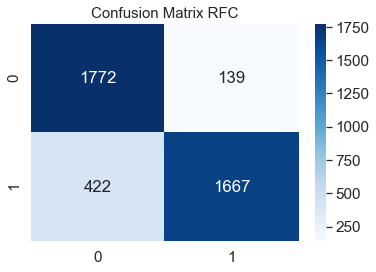

In [71]:
cf_matrix = confusion_matrix(y_test, y_preds)
# print(cf_matrix)

ax = plt.subplot()
title_font = {'size':'15'}  # Adjust to fit
sns.set(font_scale=1.4) 
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g")
ax.set_title('Confusion Matrix RFC', fontdict=title_font);
plt.savefig('plot_RFC_2.png', dpi=300, bbox_inches='tight')

In [72]:
# Different hyperparameters for our RandomForest model
dtc_grid =  {'min_samples_split': [14, 15],
             'min_samples_leaf': [25],
             'max_leaf_nodes': np.arange(85, 87, 1),
             'max_depth': np.arange(78, 80, 1),
             'criterion': ["gini", "entropy"]}

# Setup grid hyperparameter search for LogisticRegression
gs_dtc = GridSearchCV(DecisionTreeClassifier(),
                      param_grid=dtc_grid,
                      cv=5,
                      n_jobs=-1,
                      verbose=True)

# Fit grid hyperparameter search model
gs_dtc.fit(X_train, Y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([78, 79]),
                         'max_leaf_nodes': array([85, 86]),
                         'min_samples_leaf': [25],
                         'min_samples_split': [14, 15]},
             verbose=True)

In [73]:
# Check the best hyperparameters
gs_dtc.best_params_

{'criterion': 'gini',
 'max_depth': 78,
 'max_leaf_nodes': 85,
 'min_samples_leaf': 25,
 'min_samples_split': 14}

In [74]:
# Evaluate the grid search LogisticRegression model
gs_dtc.score(x_test, y_test)

0.8115

In [75]:
y_preds = gs_dtc.predict(x_test)

print(accuracy_score(y_test, y_preds))
print(precision_score(y_test, y_preds))
print(recall_score(y_test, y_preds))
print(f1_score(y_test, y_preds))

0.8115
0.9018663455749548
0.717089516515079
0.7989333333333334


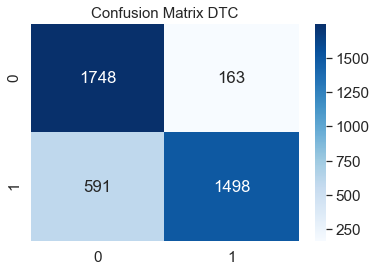

In [76]:
cf_matrix = confusion_matrix(y_test, y_preds)
# print(cf_matrix)

ax = plt.subplot()
title_font = {'size':'15'}  # Adjust to fit
sns.set(font_scale=1.4) 
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g")
ax.set_title('Confusion Matrix DTC', fontdict=title_font);
plt.savefig('plot_DTC_2.png', dpi=300, bbox_inches='tight')

In [77]:
# Different hyperparameters for our RandomForest model
xgb_grid =  {'verbosity': [1], 
             'n_estimators': [830, 850], 
             'max_depth': [74, 75], 
             'learning_rate': [0.1],
             'min_child_weight': [1],
             'subsample': [0.5],
             'colsample_bytree': [0.5]}


# Setup grid hyperparameter search for LogisticRegression
gs_xgb = GridSearchCV(XGBClassifier(),
                      param_grid=xgb_grid,
                      cv=5,
                      n_jobs=-1,
                      verbose=True)

# Fit grid hyperparameter search model
gs_xgb.fit(X_train, Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.5], 'learning_rate': [0.1],
                         'max_depth': [74, 75], 'min_child_weight': [1],
                         'n_estimators': [830, 850], 'subsample': [0.5],
                         'verbosity': [1]},
             verbose=True)

In [78]:
# Check the best hyperparameters
gs_xgb.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 74,
 'min_child_weight': 1,
 'n_estimators': 850,
 'subsample': 0.5,
 'verbosity': 1}

In [79]:
# Evaluate the grid search LogisticRegression model
gs_xgb.score(x_test, y_test)

0.899

In [80]:
y_preds = gs_xgb.predict(x_test)

print(accuracy_score(y_test, y_preds))
print(precision_score(y_test, y_preds))
print(recall_score(y_test, y_preds))
print(f1_score(y_test, y_preds))

0.899
0.9349509550851832
0.8669219722355194
0.8996522603079979


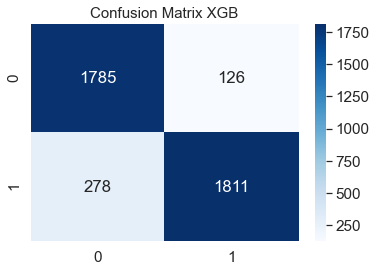

In [81]:
cf_matrix = confusion_matrix(y_test, y_preds)
# print(cf_matrix)

ax = plt.subplot()
title_font = {'size':'15'}  # Adjust to fit
sns.set(font_scale=1.4) 
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g")
ax.set_title('Confusion Matrix XGB', fontdict=title_font);
plt.savefig('plot_XGB_2.png', dpi=300, bbox_inches='tight')

In [82]:
# Different hyperparameters for our RandomForest model
cbc_grid = {'thread_count': [4],
            'learning_rate': [0.2, 0.3],
            'l2_leaf_reg': [2],
            'iterations': [450, 500],
            'depth': [8],
            'border_count': [110]}

# Setup grid hyperparameter search for LogisticRegression
gs_cbc = GridSearchCV(CatBoostClassifier(),
                      param_grid=cbc_grid,
                      cv=5,
                      n_jobs=-1,
                      verbose=True)

# Fit grid hyperparameter search model
gs_cbc.fit(X_train, Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0:	learn: 0.5476809	total: 26.8ms	remaining: 13.4s
1:	learn: 0.4903775	total: 41.7ms	remaining: 10.4s
2:	learn: 0.4749209	total: 57.1ms	remaining: 9.46s
3:	learn: 0.4584614	total: 72.8ms	remaining: 9.03s
4:	learn: 0.4491751	total: 88.9ms	remaining: 8.8s
5:	learn: 0.4396217	total: 106ms	remaining: 8.72s
6:	learn: 0.4341629	total: 123ms	remaining: 8.64s
7:	learn: 0.4311905	total: 141ms	remaining: 8.66s
8:	learn: 0.4286461	total: 158ms	remaining: 8.61s
9:	learn: 0.4247818	total: 175ms	remaining: 8.6s
10:	learn: 0.4225397	total: 192ms	remaining: 8.55s
11:	learn: 0.4176458	total: 211ms	remaining: 8.56s
12:	learn: 0.4151963	total: 232ms	remaining: 8.71s
13:	learn: 0.4117149	total: 251ms	remaining: 8.7s
14:	learn: 0.4089673	total: 269ms	remaining: 8.69s
15:	learn: 0.4069692	total: 287ms	remaining: 8.69s
16:	learn: 0.4052469	total: 310ms	remaining: 8.8s
17:	learn: 0.4028825	total: 331ms	remaining: 8.86s
18:	learn: 0.4014275	total: 352

167:	learn: 0.2180947	total: 3.35s	remaining: 6.62s
168:	learn: 0.2172149	total: 3.37s	remaining: 6.6s
169:	learn: 0.2165725	total: 3.39s	remaining: 6.59s
170:	learn: 0.2155827	total: 3.42s	remaining: 6.57s
171:	learn: 0.2148943	total: 3.43s	remaining: 6.55s
172:	learn: 0.2140821	total: 3.45s	remaining: 6.53s
173:	learn: 0.2133215	total: 3.48s	remaining: 6.51s
174:	learn: 0.2125165	total: 3.5s	remaining: 6.49s
175:	learn: 0.2117038	total: 3.52s	remaining: 6.47s
176:	learn: 0.2110508	total: 3.53s	remaining: 6.45s
177:	learn: 0.2102840	total: 3.56s	remaining: 6.45s
178:	learn: 0.2095987	total: 3.59s	remaining: 6.43s
179:	learn: 0.2089412	total: 3.61s	remaining: 6.41s
180:	learn: 0.2085087	total: 3.63s	remaining: 6.39s
181:	learn: 0.2078633	total: 3.64s	remaining: 6.37s
182:	learn: 0.2071422	total: 3.66s	remaining: 6.35s
183:	learn: 0.2063036	total: 3.68s	remaining: 6.33s
184:	learn: 0.2057092	total: 3.7s	remaining: 6.31s
185:	learn: 0.2052304	total: 3.72s	remaining: 6.29s
186:	learn: 0.2

330:	learn: 0.1283292	total: 6.66s	remaining: 3.4s
331:	learn: 0.1277868	total: 6.68s	remaining: 3.38s
332:	learn: 0.1275606	total: 6.7s	remaining: 3.36s
333:	learn: 0.1271305	total: 6.72s	remaining: 3.34s
334:	learn: 0.1267890	total: 6.74s	remaining: 3.32s
335:	learn: 0.1264252	total: 6.76s	remaining: 3.3s
336:	learn: 0.1259709	total: 6.78s	remaining: 3.28s
337:	learn: 0.1256912	total: 6.8s	remaining: 3.26s
338:	learn: 0.1252241	total: 6.82s	remaining: 3.24s
339:	learn: 0.1247884	total: 6.84s	remaining: 3.22s
340:	learn: 0.1243857	total: 6.86s	remaining: 3.2s
341:	learn: 0.1240048	total: 6.88s	remaining: 3.18s
342:	learn: 0.1236536	total: 6.9s	remaining: 3.16s
343:	learn: 0.1232523	total: 6.92s	remaining: 3.14s
344:	learn: 0.1229972	total: 6.95s	remaining: 3.12s
345:	learn: 0.1225633	total: 6.96s	remaining: 3.1s
346:	learn: 0.1222824	total: 6.98s	remaining: 3.08s
347:	learn: 0.1217259	total: 7.01s	remaining: 3.06s
348:	learn: 0.1213056	total: 7.03s	remaining: 3.04s
349:	learn: 0.12083

492:	learn: 0.0808069	total: 9.94s	remaining: 141ms
493:	learn: 0.0806331	total: 9.96s	remaining: 121ms
494:	learn: 0.0803294	total: 9.98s	remaining: 101ms
495:	learn: 0.0802278	total: 10s	remaining: 80.7ms
496:	learn: 0.0800625	total: 10s	remaining: 60.5ms
497:	learn: 0.0798625	total: 10s	remaining: 40.3ms
498:	learn: 0.0796090	total: 10.1s	remaining: 20.2ms
499:	learn: 0.0794394	total: 10.1s	remaining: 0us


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000002614436C4C8>,
             n_jobs=-1,
             param_grid={'border_count': [110], 'depth': [8],
                         'iterations': [450, 500], 'l2_leaf_reg': [2],
                         'learning_rate': [0.2, 0.3], 'thread_count': [4]},
             verbose=True)

In [83]:
# Check the best hyperparameters
gs_cbc.best_params_

{'border_count': 110,
 'depth': 8,
 'iterations': 500,
 'l2_leaf_reg': 2,
 'learning_rate': 0.3,
 'thread_count': 4}

In [84]:
# Evaluate the grid search LogisticRegression model
gs_cbc.score(x_test, y_test)

0.86875

In [85]:
y_preds = gs_cbc.predict(x_test)

print(accuracy_score(y_test, y_preds))
print(precision_score(y_test, y_preds))
print(recall_score(y_test, y_preds))
print(f1_score(y_test, y_preds))

0.86875
0.901025641025641
0.8410722833891814
0.8700173310225303


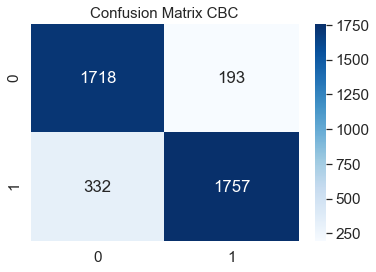

In [86]:
cf_matrix = confusion_matrix(y_test, y_preds)
# print(cf_matrix)

ax = plt.subplot()
title_font = {'size':'15'}  # Adjust to fit
sns.set(font_scale=1.4) 
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g")
ax.set_title('Confusion Matrix CBC', fontdict=title_font);
plt.savefig('plot_CBC_2.png', dpi=300, bbox_inches='tight')

# Confusion Matrix for All the Models Using the Best Hyper Parameters

In [87]:
# # All the models using best hyperparameters

# models = {
#     'Random Forest Classifier': RandomForestClassifier( bootstrap = True, 
#                                                         max_depth = None,
#                                                         min_samples_leaf = 1,
#                                                         min_samples_split = 5,
#                                                         n_estimators = 900),

    
#     'Decision Tree Classifier': DecisionTreeClassifier(criterion = "gini",
#                                                        max_depth = 79,
#                                                        max_leaf_nodes = 86,
#                                                        min_samples_leaf = 25,
#                                                        min_samples_split = 14), 
    
    
#     'XG Boost Classifier': XGBClassifier(colsample_bytree = 0.5,
#                                          learning_rate = 0.1,
#                                          max_depth = 74,
#                                          min_child_weight = 1,
#                                          n_estimators = 850,
#                                          subsample = 0.5,
#                                          verbosity = 1),
    
    
#     'Cat Boost Classifier': CatBoostClassifier(border_count = 110,
#                                                depth = 8,
#                                                iterations = 500,
#                                                l2_leaf_reg = 2,
#                                                learning_rate = 0.2,
#                                                thread_count = 4)
    
# }

In [88]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set(font_scale=1.5)

# def plot_conf_mat(y_test, y_preds, model):
    
#     fig, ax = plt.subplots(figsize=(8, 8))
#     ax = sns.heatmap(confusion_matrix(y_test, y_preds),
#                      annot=True,
#                      cbar=False)
#     plt.xlabel("True Label")
#     plt.ylabel(f'Predicted Label using {model}')

# for key, value in models.items():
#     model = value
#     model.fit(X_train, Y_train)
#     y_preds = model.predict(x_test)
#     plot_conf_mat(y_test, y_preds, key)

In [89]:
# from cf_matrix import make_confusion_matrix

# labels = ['True Neg','False Pos','False Neg','True Pos']
# categories = ['Zero', 'One']
# make_confusion_matrix(confusion_matrix(y_test, y_preds), group_names=labels, categories=categories, cmap="viridis", title='My Two-class CF Matrix')